Authors: José Raúl Romero (jrromero@uco.es), Aurora Ramírez (aurora.ramirez@uma.es), Francisco Javier Alcaide (f52almef@uco.es)

**Multiclass classification problem notebook for ECORE dataset**

- The "dummies" and "unknown" cases will be ignored.

- SVC, RF and KNN have been used

- For the metrics we consider the "macro" approach with the aim that the metrics are not affected by their number.

- It has been verified that after 10 classes there is a higher decrease in performance, so the number of classes has been considered as a reference.

- It has been proven that working with the 10 most frequent classes and eliminating the rest results in better performance than grouping the rest into a single class.

- In explainability, the 5 classes with the best performance in F1-score and the instance that have obtained the highest probability for that class were studied.

# Installation:

It is important to define the path to the folder that contains the Modelset files, in this notebook using the variable "MODELSET_HOME".

In [ ]:
MODELSET_HOME="/content/drive/MyDrive/modelset"

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
!pip install kaleido

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 4.8 MB/s eta 0:00:00


In [ ]:
!pip install modelset-py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.0/24.0 MB 51.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for wget: filename=wget-3.2-py3-none-any.whl size=9655 sha256=de0b21168744acd08ffaa42564358592e75e926c251a243624a8e44792f645ed
  Stored in directory: /root/.cache/pip/wheels/8b/f1/7f/5c94f0a7a505ca1c81cd1d9208ae2064675d97582078e6c769
Successfully built wget
  Attempting uninstall: gensim
    Found existing installation: gensim 4.3.2
    Uninstalling gensim-4.3.2:
      Successfully uninstalled gensim-4.3.2


In [ ]:
!pip install dalex -U

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 5.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for dalex: filename=dalex-1.7.0-py3-none-any.whl size=1042470 sha256=eb948611a9e799b7d0eb81cfff017d8e83b871230741689b4bdaa6c644ec5ba5
  Stored in directory: /root/.cache/pip/wheels/e2/38/c1/25a95206a4873a287d776fc8e77aa7d93971acc643ecb3db38
Successfully built dalex


In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 2.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283835 sha256=6517eef4c893758903008f397da2b997cc2923612a02d0e128a7441a19ca953f
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [ ]:
import sys
import pandas as pd
import re
import plotly
import kaleido
import pickle
import numpy as np
import dalex as dx
import os
import modelset.dataset as ds
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, balanced_accuracy_score
from sklearn.model_selection import GridSearchCV, cross_validate
from sklearn.inspection import permutation_importance

## Functions:

In [ ]:
# Function to evaluate the sign of values
def evaluate_value(value):
    if value >= 0:
        return "Positive"
    else:
        return "Negative"

In [ ]:
# Create the MultiIndex columns
columns_multi = pd.MultiIndex.from_tuples([
    ('Breakdown', 'Ranking'), ('Breakdown', 'Sign'),
    ('Shap', 'Ranking'), ('Shap', 'Sign'),
    ('Lime', 'Ranking'), ('Lime', 'Sign')
])

In [ ]:
# Function to evaluate the top 3 features
def top3_features(df, case):
    set_expl = {}

    for tech in ['Breakdown', 'Shap', 'Lime']:
        inst_top3 = set(df[df[(tech, 'Ranking')].isin([1, 2, 3])].index)
        set_expl[tech] = inst_top3

    result_case = {
        f'TOP3 {tech}': ', '.join(set_expl[tech]) for tech in ['Breakdown', 'Shap', 'Lime']
    }

    for tech1, inst_top3_1 in set_expl.items():
        for tech2, inst_top3_2 in set_expl.items():
            if tech1 < tech2:
                col_name = f'{tech1}-{tech2}'
                result_case[col_name] = len(inst_top3_1.intersection(inst_top3_2)) / 3

    df_top3_case = pd.DataFrame(result_case, index=[case])

    return df_top3_case

In [ ]:
# Function to evaluate the top 3 ranking
def top3_rank(df, case):
    set_expl = {}

    for tech in ['Breakdown', 'Shap', 'Lime']:
        inst_top3 = df[df[(tech, 'Ranking')].isin([1, 2, 3])]
        inst_top3_str = ', '.join([f'{ranking}:{inst}' for ranking, inst in zip(inst_top3[(tech, 'Ranking')], inst_top3.index)])

        set_expl[tech] = inst_top3_str

    result_case = {
        f'TOP3 {tech}': set_expl[tech] for tech in ['Breakdown', 'Shap', 'Lime']
    }

    for tech1, inst_top3_1 in set_expl.items():
        for tech2, inst_top3_2 in set_expl.items():
            if tech1 < tech2:
                col_name = f'{tech1}-{tech2}'

                coincidence = [inst for inst in inst_top3_1.split(', ') if inst in inst_top3_2.split(', ') and inst.split(':')[1] == inst.split(':')[1]]
                num_coincidence = len(coincidence)

                result_case[col_name] = num_coincidence / 3

    df_top3_rank = pd.DataFrame(result_case, index=[case])

    return df_top3_rank

In [ ]:
# Function to evaluate the top 3 sign
def top3_sign(df, case):
    set_expl = {}

    for tech in ['Breakdown', 'Shap', 'Lime']:
        inst_top3 = df[df[(tech, 'Ranking')].isin([1, 2, 3])]
        inst_top3_str = ', '.join([f'{inst}:{sign}' for inst, sign in zip(inst_top3.index, inst_top3[(tech, 'Sign')])])

        set_expl[tech] = inst_top3_str

    result_case = {
        f'TOP3 {tech}': set_expl[tech] for tech in ['Breakdown', 'Shap', 'Lime']
    }

    for tech1, inst_top3_1 in set_expl.items():
        for tech2, inst_top3_2 in set_expl.items():
            if tech1 < tech2:
                col_name = f'{tech1}-{tech2}'

                coincidence = [inst for inst in inst_top3_1.split(', ') if inst in inst_top3_2.split(', ')]
                num_coincidence = len(coincidence)

                result_case[col_name] = num_coincidence / 3

    df_top3_sign = pd.DataFrame(result_case, index=[case])

    return df_top3_sign

In [ ]:
# Function to evaluate the top 3 sign and ranking
def top3_rank_sign(df, case):
    set_expl = {}

    for tech in ['Breakdown', 'Shap', 'Lime']:
        inst_top3 = df[df[(tech, 'Ranking')].isin([1, 2, 3])]
        inst_top3_str = ', '.join([f'{ranking}:{inst}:{sign}' for ranking, inst, sign in zip(inst_top3[(tech, 'Ranking')], inst_top3.index, inst_top3[(tech, 'Sign')])])
        set_expl[tech] = inst_top3_str

    result_case = {
        f'TOP3 {tech}': set_expl[tech] for tech in ['Breakdown', 'Shap', 'Lime']
    }

    for tech1, inst_top3_1 in set_expl.items():
        for tech2, inst_top3_2 in set_expl.items():
            if tech1 < tech2:
                col_name = f'{tech1}-{tech2}'

                coincidence = [inst for inst in inst_top3_1.split(', ') if inst in inst_top3_2.split(', ') and inst.split(':')[1] == inst.split(':')[1] and inst.split(':')[2] == inst.split(':')[2]]
                num_coincidence = len(coincidence)
                result_case[col_name] = num_coincidence / 3

    df_top3_rank_sign = pd.DataFrame(result_case, index=[case])

    return df_top3_rank_sign

In [ ]:
# Function to obtain the dataframes of the tech Breakdown, SHAP, and LIME.
def preprocess_dfs(breakdown_df, shap_df, lime_df, n, m):

    pattern = re.compile(r'(?:<=|<|>=|>)\s*(\w+)\s*(?:<=|<|>=|>)')

    breakdown_df = breakdown_df.loc[:, ['variable_name', 'contribution', 'sign']]
    breakdown_df = breakdown_df.drop(index=[0, n+1])
    breakdown_df['sign'] = breakdown_df['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
    breakdown_df = breakdown_df.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

    shap_df = shap_df.loc[:, ['variable_name', 'contribution', 'sign']]
    shap_df = shap_df.tail(n)
    shap_df['sign'] = shap_df['sign'].replace({1.0: 'Positive', 0.0: 'Null', -1.0: 'Negative'})
    shap_df = shap_df.sort_values(by='contribution', key=lambda x: abs(x), ascending=False)

    lime_list = []
    for feature in lime_df['variable']:
      if pattern.findall(feature):
        match = pattern.search(feature)
        if match:
          lime_list.append(match.group(1))
      else:
        splits = feature.split(" ")
        lime_list.append(splits[0])

    lime_df["Feature"] = lime_list
    lime_df["Sign"] = lime_df["effect"].apply(evaluate_value)
    lime_df = lime_df.sort_values(by='effect', key=lambda x: abs(x), ascending=False)
    lime_df = lime_df.drop(columns=['variable'])

    breakdown_df['Ranking'] = breakdown_df['contribution'].abs().rank(ascending=False).astype(int)
    breakdown_df.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
    breakdown_df = breakdown_df[['Feature', 'Ranking', 'contribution', 'Sign']]

    shap_df['Ranking'] = shap_df['contribution'].abs().rank(ascending=False).astype(int)
    shap_df.rename(columns={'sign': 'Sign', 'variable_name':'Feature'}, inplace=True)
    shap_df = shap_df[['Feature', 'Ranking', 'contribution', 'Sign']]

    lime_df['Ranking'] = lime_df['effect'].abs().rank(ascending=False).astype(int)
    lime_df = lime_df.head(m)
    lime_df = lime_df[['Feature', 'Ranking', 'effect', 'Sign']]

    breakdown_df = breakdown_df.drop(columns=['contribution'])
    shap_df = shap_df.drop(columns=['contribution'])
    lime_df = lime_df.drop(columns=['effect'])

    breakdown_df = breakdown_df.head(m)
    breakdown_df = breakdown_df.reset_index(drop=True)

    shap_df= shap_df.head(m)
    shap_df = shap_df.reset_index(drop=True)

    lime_df = lime_df.reset_index(drop=True)

    breakdown_features = list(breakdown_df['Feature'])
    shap_features = list(shap_df['Feature'])
    lime_features = list(lime_df['Feature'])
    all_features = list(set(breakdown_features + shap_features + lime_features))
    all_features = all_features[::-1]

    df_final = pd.DataFrame(index=range(len(all_features)), columns=columns_multi)
    df_final['Feature'] = list(all_features)
    df_final = df_final[['Feature', 'Breakdown', 'Shap', 'Lime']]

    #print(breakdown_features)
    #print(shap_features)
    #print(lime_features)
    print(all_features)

    for feature in df_final['Feature']:

        breakdown_row = breakdown_df[breakdown_df['Feature'] == feature]
        if not breakdown_row.empty:

            ranking_breakdown = breakdown_row.iloc[0]['Ranking']
            sign_breakdown = breakdown_row.iloc[0]['Sign']
            df_final.loc[df_final['Feature'] == feature, ('Breakdown', 'Ranking')] = ranking_breakdown
            df_final.loc[df_final['Feature'] == feature, ('Breakdown', 'Sign')] = sign_breakdown
        else:

            df_final.loc[df_final['Feature'] == feature, ('Breakdown', 'Ranking')] = '-'
            df_final.loc[df_final['Feature'] == feature, ('Breakdown', 'Sign')] = '-'


        shap_row = shap_df[shap_df['Feature'] == feature]
        if not shap_row.empty:
            ranking_shap = shap_row.iloc[0]['Ranking']
            sign_shap = shap_row.iloc[0]['Sign']
            df_final.loc[df_final['Feature'] == feature, ('Shap', 'Ranking')] = ranking_shap
            df_final.loc[df_final['Feature'] == feature, ('Shap', 'Sign')] = sign_shap
        else:
            df_final.loc[df_final['Feature'] == feature, ('Shap', 'Ranking')] = '-'
            df_final.loc[df_final['Feature'] == feature, ('Shap', 'Sign')] = '-'


        lime_row = lime_df[lime_df['Feature'] == feature]
        if not lime_row.empty:
            ranking_lime = lime_row.iloc[0]['Ranking']
            sign_lime = lime_row.iloc[0]['Sign']
            df_final.loc[df_final['Feature'] == feature, ('Lime', 'Ranking')] = ranking_lime
            df_final.loc[df_final['Feature'] == feature, ('Lime', 'Sign')] = sign_lime
        else:
            df_final.loc[df_final['Feature'] == feature, ('Lime', 'Ranking')] = '-'
            df_final.loc[df_final['Feature'] == feature, ('Lime', 'Sign')] = '-'


    ranking_breakdown = df_final[('Breakdown', 'Ranking')]
    values_valid = ranking_breakdown[ranking_breakdown != '-']
    cases_invalid = ranking_breakdown[ranking_breakdown == '-'].index
    cases_valid = []
    cases_invalid_restantes = list(cases_invalid)
    cases_valid.extend(values_valid.sort_values().index.tolist())

    for cas in cases_invalid:
        value_shap = df_final.at[cas, ('Shap', 'Ranking')]
        if value_shap != '-':
            cases_valid.extend([cas])
            cases_invalid_restantes.remove(cas)

    for cas in cases_invalid_restantes:
        value_lime = df_final.at[cas, ('Lime', 'Ranking')]
        if value_lime != '-':
            cases_valid.extend([cas])

    df_final = df_final.loc[cases_valid]
    df_final.set_index('Feature', inplace=True)
    return breakdown_df, shap_df, lime_df, df_final


In [ ]:
# Function to create final dataframes with all the disagreement metrics and calculate the means of disagreement metrics for each pair of techniques.
def calculate_metrics(df_list):
    df_final = pd.concat(df_list)

    mean_bd_shap = df_final['Breakdown-Shap'].mean()
    mean_bd_lime = df_final['Breakdown-Lime'].mean()
    mean_lime_shap = df_final['Lime-Shap'].mean()

    return df_final, mean_bd_shap, mean_bd_lime, mean_lime_shap

In [ ]:
# Function to create dictionaries containing the disagreement metrics dataframes
def create_metrics_dfs(metrics_dict, metric_type):
    dfs = {'Model_comparison': {}, 'Class_comparison': {}}
    columns_model = ['Class', 'Mean Breakdown-Shap', 'Mean Breakdown-Lime', 'Mean Lime-Shap']
    columns_class = ['Model', 'Mean Breakdown-Shap', 'Mean Breakdown-Lime', 'Mean Lime-Shap']
    metric_names = [f'Mean_{metric_type}_BD_Shap', f'Mean_{metric_type}_BD_Lime', f'Mean_{metric_type}_Lime_Shap']

    for model_name, indexes_dict in metrics_dict.items():
        for index_name, metrics in indexes_dict.items():
            if model_name not in dfs['Class_comparison']:
                dfs['Class_comparison'][model_name] = pd.DataFrame(columns=columns_model)

            get_metrics = [metrics.get(metric_name) for metric_name in metric_names]
            class_data = [index_name] + get_metrics
            dfs['Class_comparison'][model_name] = pd.concat([dfs['Class_comparison'][model_name], pd.Series(class_data, index=columns_model).to_frame().T], ignore_index=True)

            if index_name not in dfs['Model_comparison']:
                dfs['Model_comparison'][index_name] = pd.DataFrame(columns=columns_class)

            get_metrics = [metrics.get(metric_name) for metric_name in metric_names]
            model_data = [model_name] + get_metrics
            dfs['Model_comparison'][index_name] = pd.concat([dfs['Model_comparison'][index_name], pd.Series(model_data, index=columns_class).to_frame().T], ignore_index=True)

    return dfs

In [ ]:
# Function to obtain dataframes of explanations, disagreement metrics, and each of the disagreement metrics dataframes
def calculate_metrics_for_indices(models_dict, indexes_dict, X_test, X_train, y_train, num_features, top_num_features):
    results_dict = {}
    metrics_dict = {}

    for model_name, model in models_dict.items():
        results_dict[model_name] = {}
        metrics_dict[model_name] = {}

        exp = dx.Explainer(model, X_train, y_train)

        for index_name, indices in indexes_dict.items():
          results_dict[model_name][index_name] = {}
          metrics_dict[model_name][index_name] = {}
          model_results = results_dict[model_name][index_name]
          df_list_top = []
          df_list_rank = []
          df_list_sign = []
          df_list_rank_sign = []

          for i in indices:
            instance = X_test.loc[i]

            breakdown = exp.predict_parts(instance, type="break_down", random_state=42)
            shap = exp.predict_parts(instance, type="shap", random_state=42)
            lime = exp.predict_surrogate(instance, random_state=42)
            breakdown_df = breakdown.result
            shap_df = shap.result
            lime_df = lime.result

            breakdown_df, shap_df, lime_df, df_final = preprocess_dfs(breakdown_df, shap_df, lime_df, num_features, top_num_features)

            model_results[f"breakdown_df_{i}"] = breakdown_df
            model_results[f"shap_df_{i}"] = shap_df
            model_results[f"lime_df_{i}"] = lime_df
            model_results[f"df_final_{i}"] = df_final

            metrics_dict[model_name][index_name][f"df_top_metric_{i}"] = top3_features(df_final, i)
            metrics_dict[model_name][index_name][f'df_rank_metric_{i}'] = top3_rank(df_final, i)
            metrics_dict[model_name][index_name][f'df_sign_metric_{i}'] = top3_sign(df_final, i)
            metrics_dict[model_name][index_name][f'df_rank_sign_metric_{i}'] = top3_rank_sign(df_final, i)

            #model_results[f"df_top_metric_{i}"] = top3_features(df_final, i)
            #model_results[f'df_rank_metric_{i}'] = top3_rank(df_final, i)
            #model_results[f'df_sign_metric_{i}'] = top3_sign(df_final, i)
            #model_results[f'df_rank_sign_metric_{i}'] = top3_rank_sign(df_final, i)

            df_list_top.append(metrics_dict[model_name][index_name][f'df_top_metric_{i}'])
            df_list_rank.append(metrics_dict[model_name][index_name][f'df_rank_metric_{i}'])
            df_list_sign.append(metrics_dict[model_name][index_name][f'df_sign_metric_{i}'])
            df_list_rank_sign.append(metrics_dict[model_name][index_name][f'df_rank_sign_metric_{i}'])

          df_top_metric_final, mean_top_bd_shap, mean_top_bd_lime, mean_top_lime_shap = calculate_metrics(df_list_top)
          df_rank_metric_final, mean_rank_bd_shap, mean_rank_bd_lime, mean_rank_lime_shap = calculate_metrics(df_list_rank)
          df_sign_metric_final, mean_sign_bd_shap, mean_sign_bd_lime, mean_sign_lime_shap = calculate_metrics(df_list_sign)
          df_rank_sign_metric_final, mean_rank_sign_bd_shap, mean_rank_sign_bd_lime, mean_rank_sign_lime_shap = calculate_metrics(df_list_rank_sign)

          metrics_dict[model_name][index_name][f'Mean_top_BD_Shap'] = mean_top_bd_shap
          metrics_dict[model_name][index_name][f'Mean_top_BD_Lime'] = mean_top_bd_lime
          metrics_dict[model_name][index_name][f'Mean_top_Lime_Shap'] = mean_top_lime_shap
          metrics_dict[model_name][index_name][f'df_top_metric_final'] = df_top_metric_final

          metrics_dict[model_name][index_name][f'Mean_rank_BD_Shap'] = mean_rank_bd_shap
          metrics_dict[model_name][index_name][f'Mean_rank_BD_Lime'] = mean_rank_bd_lime
          metrics_dict[model_name][index_name][f'Mean_rank_Lime_Shap'] = mean_rank_lime_shap
          metrics_dict[model_name][index_name][f'df_rank_metric_final'] = df_rank_metric_final

          metrics_dict[model_name][index_name][f'Mean_sign_BD_Shap'] = mean_sign_bd_shap
          metrics_dict[model_name][index_name][f'Mean_sign_BD_Lime'] = mean_sign_bd_lime
          metrics_dict[model_name][index_name][f'Mean_sign_Lime_Shap'] = mean_sign_lime_shap
          metrics_dict[model_name][index_name][f'df_sign_metric_final'] = df_sign_metric_final

          metrics_dict[model_name][index_name][f'Mean_rank_sign_BD_Shap'] = mean_rank_sign_bd_shap
          metrics_dict[model_name][index_name][f'Mean_rank_sign_BD_Lime'] = mean_rank_sign_bd_lime
          metrics_dict[model_name][index_name][f'Mean_rank_sign_Lime_Shap'] = mean_rank_sign_lime_shap
          metrics_dict[model_name][index_name][f'df_rank_sign_metric_final'] = df_rank_sign_metric_final

    top_metric_df = create_metrics_dfs(metrics_dict, 'top')
    rank_metric_df = create_metrics_dfs(metrics_dict, 'rank')
    sign_metric_df = create_metrics_dfs(metrics_dict, 'sign')
    rank_sign_metric_df = create_metrics_dfs(metrics_dict, 'rank_sign')

    return metrics_dict, results_dict, top_metric_df, rank_metric_df, sign_metric_df, rank_sign_metric_df


# Load and Preprocess:

In this section, we will perform data loading, cleaning, preprocessing, and an initial data analysis.

In [ ]:
dataset = ds.load(MODELSET_HOME,modeltype = 'ecore', selected_analysis = ['stats']) # load dataset
modelset_df = dataset._Dataset__to_df()

In [ ]:
duplicates = modelset_df.duplicated(subset='id', keep=False)
inst_dup = modelset_df[duplicates]
inst_dup

Empty DataFrame
Columns: [id, category, tags, language, references, elements, classes, attributes, packages, enum, datatypes]
Index: []

In [ ]:
modelset_df

id   category  \
0     repo-ecore-all/data/mde-optimiser/comma-18-map...  arguments   
2     repo-ecore-all/data/AmerPecuj/MBSE/dk.dtu.comp...   petrinet   
3     repo-ecore-all/data/nlohmann/service-technolog...   petrinet   
4     repo-ecore-all/data/damenac/puzzle/examples/em...  education   
5     repo-ecore-all/data/ModelWriter/AlloyInEcore/S...      dummy   
...                                                 ...        ...   
5470  repo-ecore-all/data/BlackBeltTechnology/emfbui...    company   
5471  repo-ecore-all/data/fmdkdd/monoge/emftuto/test...      dummy   
5472  repo-ecore-all/data/gssi/Edelta_bad_smells/mod...      dummy   
5473  repo-ecore-all/data/mathiasnh/TDT4250-Assignme...  education   
5474  repo-ecore-all/data/agacek/jkind-xtext/jkind.x...  simple-pl   

                                      tags language  references  elements  \
0                                      NaN  english          12        42   
2                                behaviour  english           7        27   
3                                behaviour  english          13        92   
4                              domainmodel  english           4        37   
5                                      NaN  english           0        71   
...                                    ...      ...         ...       ...   
5470                                   NaN  english           2        22   
5471                                   NaN  english           3         9   
5472                                   NaN  english           3        17   
5473                university|domainmodel  english          24       101   
5474  expressions|types|lustre|programming  english          55       214   

      classes  attributes  packages  enum  datatypes  
0           5           6         1     0          0  
2           6           2         1     0          0  
3          15          16         1     2          0  
4           4          12         1     0          0  
5           6          19         2     2          2  
...       ...         ...       ...   ...        ...  
5470        5           4         2     0          0  
5471        2           0         1     0          0  
5472        6           1         1     0          0  
5473       11          12         1     2          0  
5474       44          14         1     0          0  

[5466 rows x 11 columns]

In [ ]:
modelset_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5466 entries, 0 to 5474
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id          5466 non-null   object
 1   category    5466 non-null   object
 2   tags        3824 non-null   object
 3   language    5466 non-null   object
 4   references  5466 non-null   int64 
 5   elements    5466 non-null   int64 
 6   classes     5466 non-null   int64 
 7   attributes  5466 non-null   int64 
 8   packages    5466 non-null   int64 
 9   enum        5466 non-null   int64 
 10  datatypes   5466 non-null   int64 
dtypes: int64(7), object(4)
memory usage: 512.4+ KB


In [ ]:
modelset_df = modelset_df.reset_index(drop=True) # Reset index

In [ ]:
modelset_df.head()

id   category         tags  \
0  repo-ecore-all/data/mde-optimiser/comma-18-map...  arguments          NaN   
1  repo-ecore-all/data/AmerPecuj/MBSE/dk.dtu.comp...   petrinet    behaviour   
2  repo-ecore-all/data/nlohmann/service-technolog...   petrinet    behaviour   
3  repo-ecore-all/data/damenac/puzzle/examples/em...  education  domainmodel   
4  repo-ecore-all/data/ModelWriter/AlloyInEcore/S...      dummy          NaN   

  language  references  elements  classes  attributes  packages  enum  \
0  english          12        42        5           6         1     0   
1  english           7        27        6           2         1     0   
2  english          13        92       15          16         1     2   
3  english           4        37        4          12         1     0   
4  english           0        71        6          19         2     2   

   datatypes  
0          0  
1          0  
2          0  
3          0  
4          2

In [ ]:
modelset_df.describe()

references     elements      classes   attributes     packages  \
count  5466.000000  5466.000000  5466.000000  5466.000000  5466.000000   
mean     26.673253   205.912916    25.739297    16.268203     1.459202   
std      51.137585   406.224079    43.285126    33.742160     2.378441   
min       0.000000     1.000000     0.000000     0.000000     1.000000   
25%       4.000000    27.000000     4.000000     2.000000     1.000000   
50%       9.000000    63.000000     8.000000     6.000000     1.000000   
75%      25.000000   191.000000    24.000000    16.000000     1.000000   
max    1128.000000  4397.000000   391.000000   777.000000    46.000000   

              enum    datatypes  
count  5466.000000  5466.000000  
mean      1.237834     1.236004  
std       5.487452     5.356692  
min       0.000000     0.000000  
25%       0.000000     0.000000  
50%       0.000000     0.000000  
75%       1.000000     0.000000  
max     344.000000    58.000000

In [ ]:
modelset_df['category'].value_counts()

dummy                     729
statemachine              392
petrinet                  236
library                   235
modelling                 209
                         ... 
policies                    1
webservice                  1
decisiontree                1
addressbook-veterinary      1
aspects                     1
Name: category, Length: 222, dtype: int64

In [ ]:
modelset_df_filt = modelset_df.loc[(modelset_df['category'] != 'dummy') & (modelset_df['category'] != 'unknown')] # delete dummies and unknown cases
modelset_df_filt

id      category  \
0     repo-ecore-all/data/mde-optimiser/comma-18-map...     arguments   
1     repo-ecore-all/data/AmerPecuj/MBSE/dk.dtu.comp...      petrinet   
2     repo-ecore-all/data/nlohmann/service-technolog...      petrinet   
3     repo-ecore-all/data/damenac/puzzle/examples/em...     education   
5     repo-ecore-all/data/francoispfister/diagraph/o...  statemachine   
...                                                 ...           ...   
5459  repo-ecore-all/data/Barros-Lucas/DSL_State_Int...  statemachine   
5460  repo-ecore-all/data/luciuscode/test/projectStr...       library   
5461  repo-ecore-all/data/BlackBeltTechnology/emfbui...       company   
5464  repo-ecore-all/data/mathiasnh/TDT4250-Assignme...     education   
5465  repo-ecore-all/data/agacek/jkind-xtext/jkind.x...     simple-pl   

                                      tags language  references  elements  \
0                                      NaN  english          12        42   
1                                behaviour  english           7        27   
2                                behaviour  english          13        92   
3                              domainmodel  english           4        37   
5                                behaviour  english           7        87   
...                                    ...      ...         ...       ...   
5459                             behaviour  english           3        22   
5460                           domainmodel  english           4        34   
5461                                   NaN  english           2        22   
5464                university|domainmodel  english          24       101   
5465  expressions|types|lustre|programming  english          55       214   

      classes  attributes  packages  enum  datatypes  
0           5           6         1     0          0  
1           6           2         1     0          0  
2          15          16         1     2          0  
3           4          12         1     0          0  
5           9          13         1     0          0  
...       ...         ...       ...   ...        ...  
5459        5           4         1     0          0  
5460        6           3         1     1          0  
5461        5           4         2     0          0  
5464       11          12         1     2          0  
5465       44          14         1     0          0  

[4581 rows x 11 columns]

In [ ]:
# Delete columns that are not useful
modelset_df_filt = modelset_df_filt.drop(['elements'], axis=1)
modelset_df_filt = modelset_df_filt.drop(['tags'], axis=1)
modelset_df_filt = modelset_df_filt.drop(['language'], axis=1)
modelset_df_filt = modelset_df_filt.drop(['id'], axis=1)

In [ ]:
col_nan = modelset_df_filt.isnull().any() # NaN search
print(col_nan[col_nan])

Series([], dtype: bool)


In [ ]:
modelset_df_filt['category'].value_counts()

statemachine              392
petrinet                  236
library                   235
modelling                 209
class-diagram             182
                         ... 
policies                    1
webservice                  1
decisiontree                1
addressbook-veterinary      1
aspects                     1
Name: category, Length: 220, dtype: int64

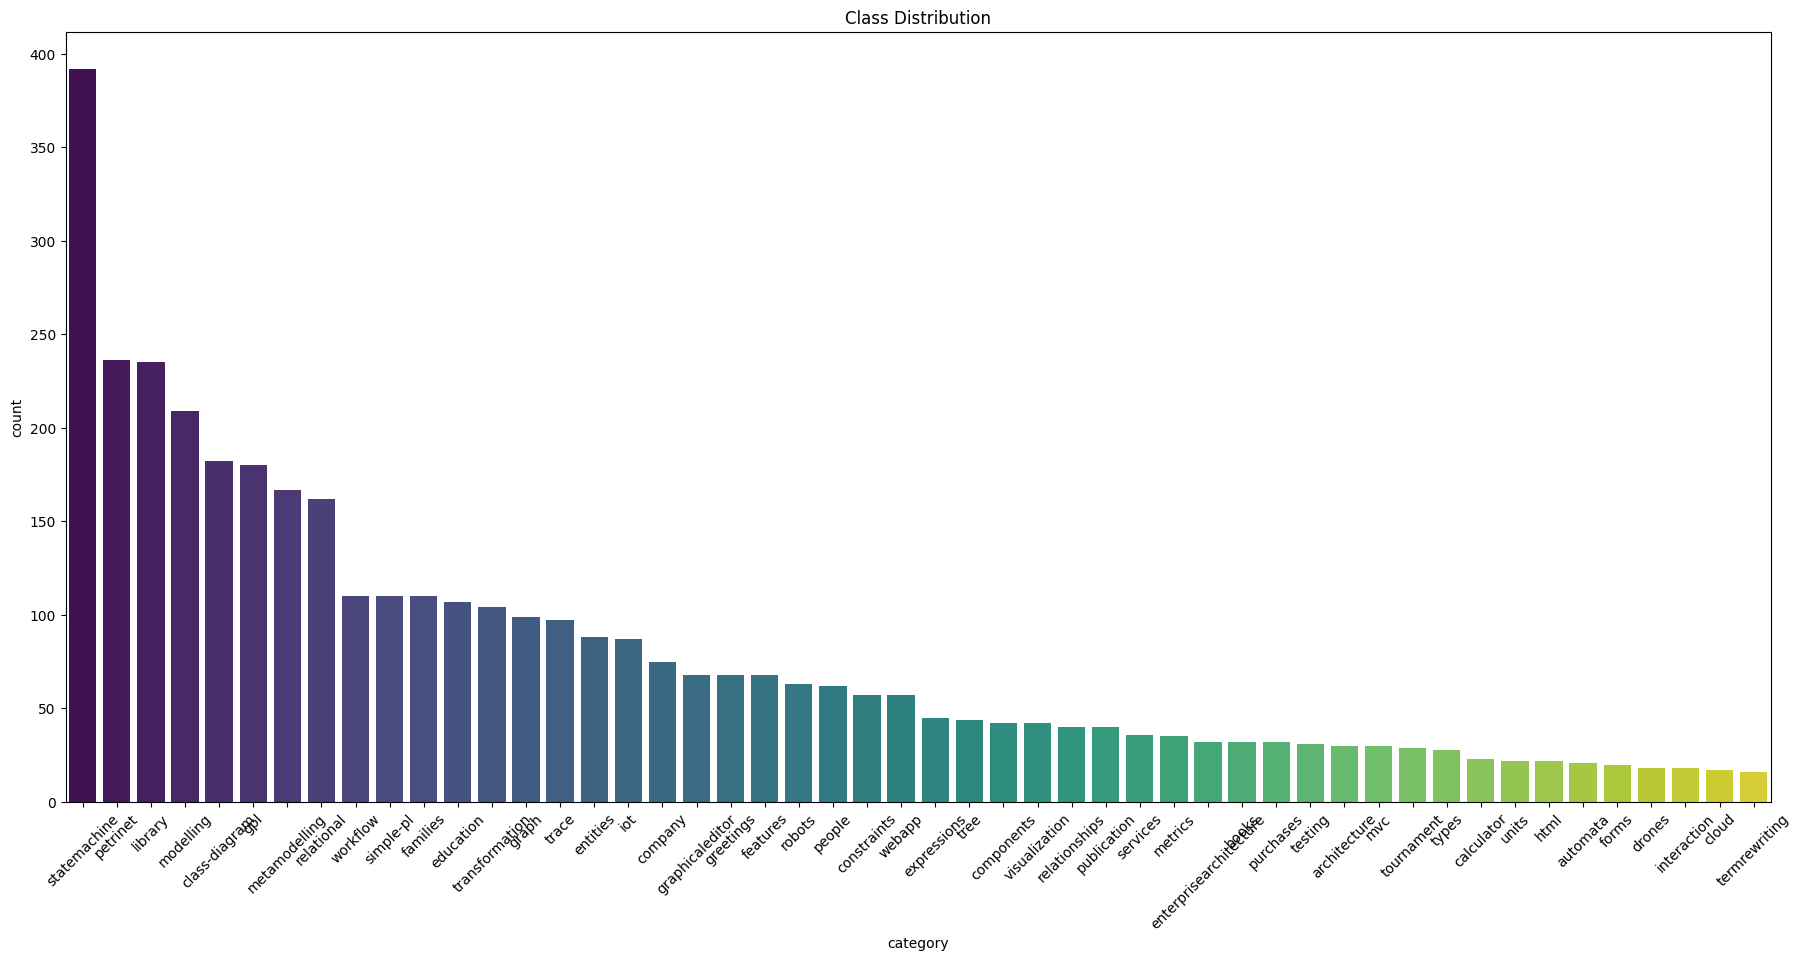

In [ ]:
# Class distribution
class_counts = modelset_df_filt['category'].value_counts().sort_values(ascending=False).head(50)
plt.figure(figsize=(22, 10))
sns.countplot(x='category', data=modelset_df_filt, order=class_counts.index, palette='viridis')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()

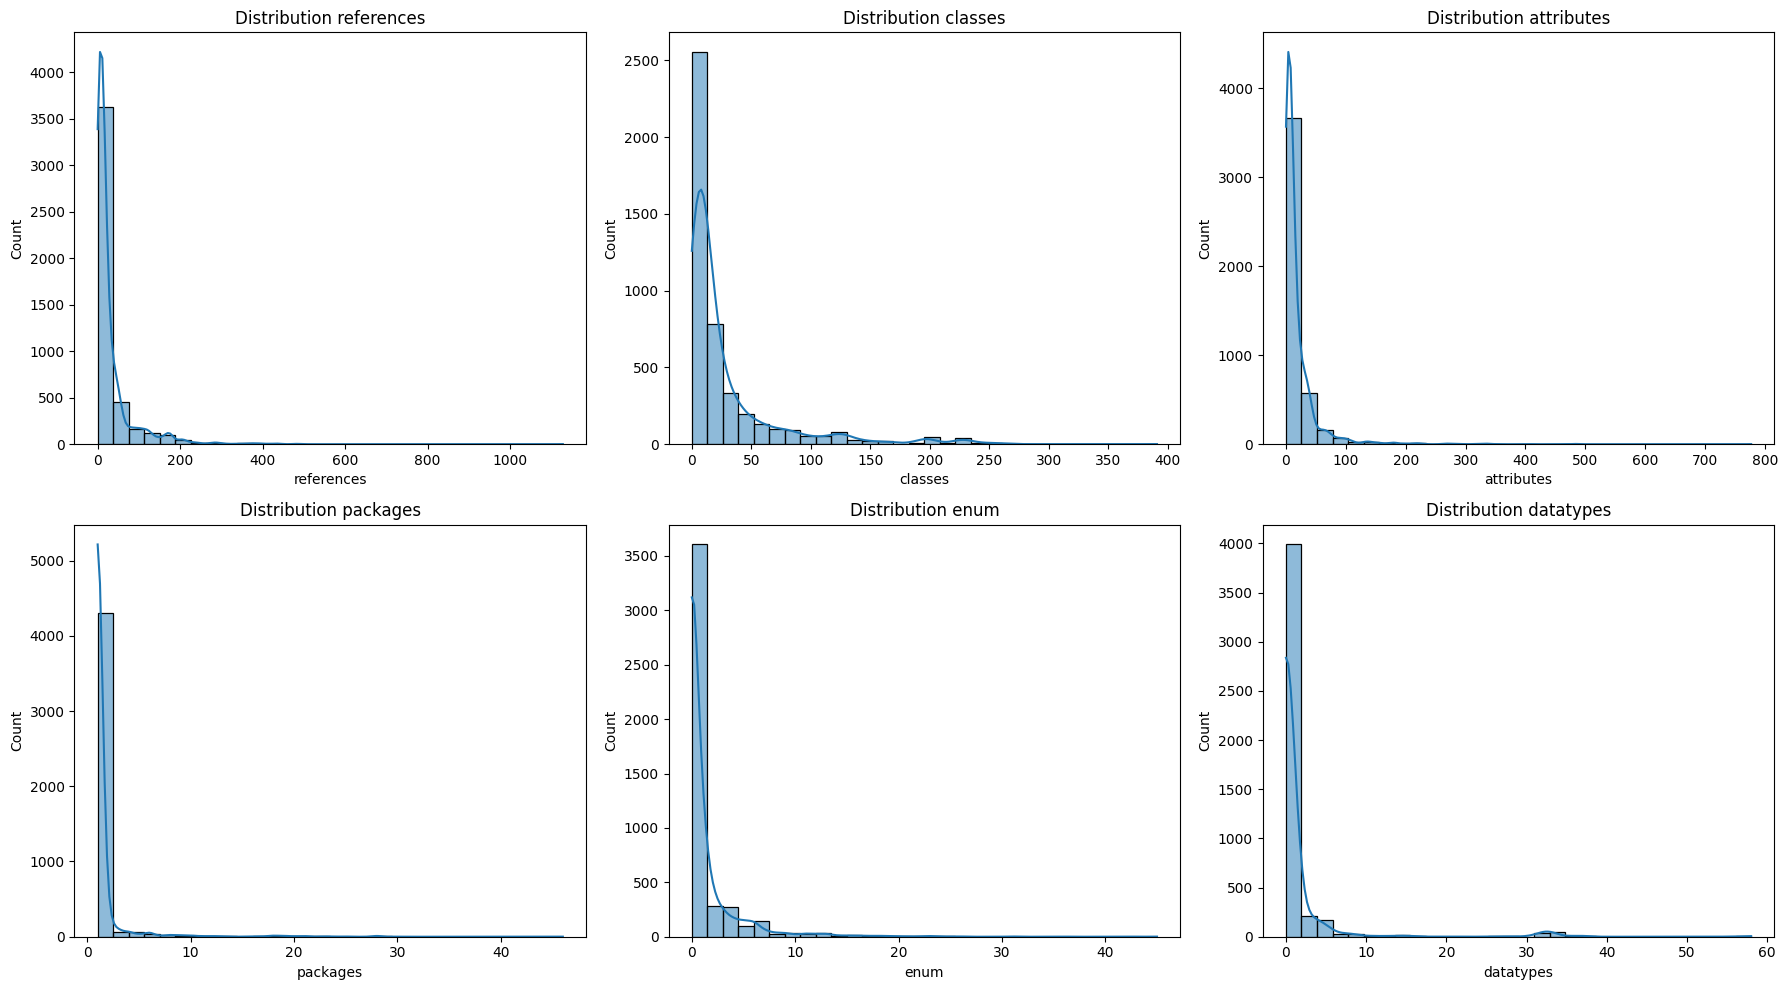

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(18, 10))
axes = axes.flatten()
for i, feature in enumerate(["references", "classes", "attributes", "packages", "enum", "datatypes"]):
    sns.histplot(modelset_df_filt[feature], kde=True, bins=30, ax=axes[i])
    axes[i].set_title(f'Distribution {feature}')
plt.tight_layout()
plt.show()

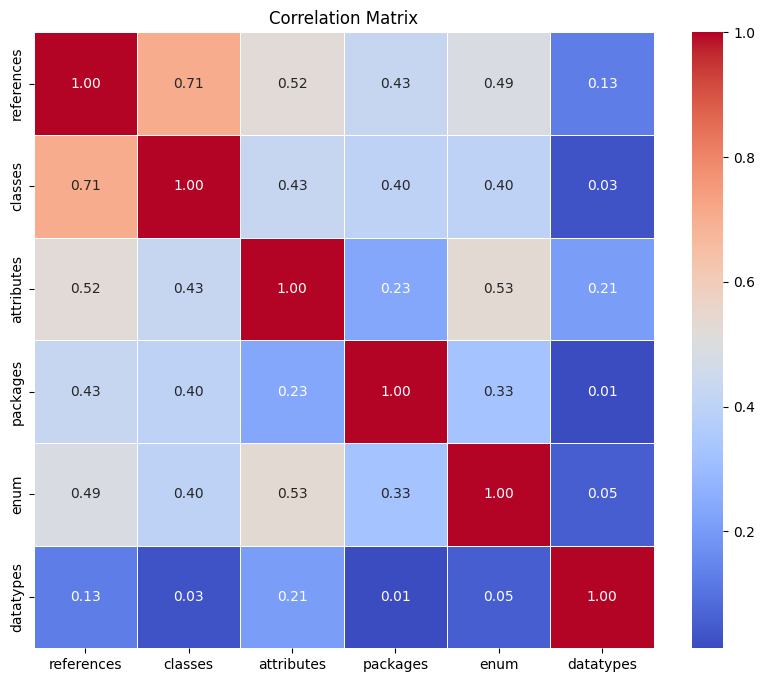

In [ ]:
# Correlation
correlation_matrix = modelset_df_filt.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix - Model Classification (Ecore)')
plt.show()



---

❗❗ **No features with a correlation value greater than 0.8, so we are going to keep them all.**


---



# Performance by No. Classes:

We search for the best number of classes to consider through a performance evaluation.

In [ ]:
modelset_df_label = modelset_df_filt.copy()

# Transform classes into numeric values
label_encoder_nclasses = LabelEncoder()
modelset_df_label['label'] = label_encoder_nclasses.fit_transform(modelset_df_label['category'])

In [ ]:
modelset_df_label.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4581 entries, 0 to 5465
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   category    4581 non-null   object
 1   references  4581 non-null   int64 
 2   classes     4581 non-null   int64 
 3   attributes  4581 non-null   int64 
 4   packages    4581 non-null   int64 
 5   enum        4581 non-null   int64 
 6   datatypes   4581 non-null   int64 
 7   label       4581 non-null   int64 
dtypes: int64(7), object(1)
memory usage: 322.1+ KB


In [ ]:
modelset_df_label.head()

category  references  classes  attributes  packages  enum  datatypes  \
0     arguments          12        5           6         1     0          0   
1      petrinet           7        6           2         1     0          0   
2      petrinet          13       15          16         1     2          0   
3     education           4        4          12         1     0          0   
5  statemachine           7        9          13         1     0          0   

   label  
0      8  
1    143  
2    143  
3     59  
5    186

In [ ]:
modelset_df_label = modelset_df_label.drop(['category'], axis=1)

In [ ]:
X_label = modelset_df_label[['references', 'classes', 'attributes', 'packages', 'enum', 'datatypes']]
y_label = modelset_df_label['label']

In [ ]:
nclasses = [5, 10, 20, 30, 40, 50, 60, 70, 80]
results_df = pd.DataFrame(columns=['No. Classes', 'Acc (SVC)', 'Prec (SVC)', 'Rec (SVC)', 'F1 (SVC)',
                                      'Acc (RF)', 'Prec (RF)', 'Rec (RF)', 'F1 (RF)',
                                      'Acc (KNN)', 'Prec (KNN)', 'Rec (KNN)', 'F1 (KNN)'])

for num_classes in nclasses:
    classes_frec_label = y_label.value_counts().nlargest(num_classes).index
    datos_filt = modelset_df_label[modelset_df_label['label'].isin(classes_frec_label)]

    X_filt = datos_filt[['references', 'classes', 'attributes', 'packages', 'enum', 'datatypes']]
    y_filt = datos_filt['label']
    X_train_filt, X_test_filt, y_train_filt, y_test_filt = train_test_split(X_filt, y_filt, test_size=0.3, random_state=42, stratify=y_filt)

    svc_model = SVC(random_state=42)
    rf_model = RandomForestClassifier(random_state=42)
    knn_model = KNeighborsClassifier()

    svc_model.fit(X_train_filt, y_train_filt)
    rf_model.fit(X_train_filt, y_train_filt)
    knn_model.fit(X_train_filt, y_train_filt)

    y_pred_svc = svc_model.predict(X_test_filt)
    y_pred_rf = rf_model.predict(X_test_filt)
    y_pred_knn = knn_model.predict(X_test_filt)

    acc_svc = balanced_accuracy_score(y_test_filt, y_pred_svc)
    precision_svc = precision_score(y_test_filt, y_pred_svc, average='macro')
    recall_svc = recall_score(y_test_filt, y_pred_svc, average='macro')
    f1_svc = f1_score(y_test_filt, y_pred_svc, average='macro')

    acc_rf = balanced_accuracy_score(y_test_filt, y_pred_rf)
    precision_rf = precision_score(y_test_filt, y_pred_rf, average='macro')
    recall_rf = recall_score(y_test_filt, y_pred_rf, average='macro')
    f1_rf = f1_score(y_test_filt, y_pred_rf, average='macro')

    acc_knn = balanced_accuracy_score(y_test_filt, y_pred_knn)
    precision_knn = precision_score(y_test_filt, y_pred_knn, average='macro')
    recall_knn = recall_score(y_test_filt, y_pred_knn, average='macro')
    f1_knn = f1_score(y_test_filt, y_pred_knn, average='macro')

    results_df = results_df.append({
        'No. Classes': num_classes,
        'Acc (SVC)': acc_svc, 'Prec (SVC)': precision_svc, 'Rec (SVC)': recall_svc, 'F1 (SVC)': f1_svc,
        'Acc (RF)': acc_rf, 'Prec (RF)': precision_rf, 'Rec (RF)': recall_rf, 'F1 (RF)': f1_rf,
        'Acc (KNN)': acc_knn, 'Prec (KNN)': precision_knn, 'Rec (KNN)': recall_knn, 'F1 (KNN)': f1_knn}, ignore_index=True)

In [ ]:
results_df

No. Classes  Acc (SVC)  Prec (SVC)  Rec (SVC)  F1 (SVC)  Acc (RF)  \
0          5.0   0.368630    0.622162   0.368630  0.307478  0.737883   
1         10.0   0.368406    0.448130   0.368406  0.344804  0.730273   
2         20.0   0.218666    0.288615   0.218666  0.208936  0.642582   
3         30.0   0.153013    0.167282   0.153013  0.136801  0.587739   
4         40.0   0.142459    0.197579   0.142459  0.137197  0.610725   
5         50.0   0.129701    0.142269   0.129701  0.120854  0.556547   
6         60.0   0.124648    0.130825   0.124648  0.117042  0.549379   
7         70.0   0.125105    0.138981   0.125105  0.117036  0.545203   
8         80.0   0.107673    0.108613   0.107673  0.097798  0.560449   

   Prec (RF)  Rec (RF)   F1 (RF)  Acc (KNN)  Prec (KNN)  Rec (KNN)  F1 (KNN)  
0   0.760782  0.737883  0.746495   0.686323    0.686376   0.686323  0.685161  
1   0.737337  0.730273  0.731167   0.605578    0.601612   0.605578  0.601340  
2   0.645669  0.642582  0.640312   0.507411    0.513176   0.507411  0.502348  
3   0.606994  0.587739  0.593567   0.405795    0.438841   0.405795  0.404441  
4   0.627112  0.610725  0.613628   0.440378    0.462254   0.440378  0.434470  
5   0.598870  0.556547  0.565747   0.408893    0.374450   0.408893  0.380998  
6   0.604163  0.549379  0.564012   0.372921    0.376360   0.372921  0.359688  
7   0.572564  0.545203  0.542599   0.361696    0.357053   0.361696  0.346035  
8   0.599048  0.560449  0.565007   0.410954    0.421414   0.410954  0.393528


---

❗❗ **We verified that the biggest performance jump in most metrics occurs between the cases with 10 and 20 most frequent classes. Therefore, we are going to consider that the best choice is 10 classes.**

---



# Performance Deleting VS Grouping:

In [ ]:
# Once we have determined the optimal number of classes to consider,
# we will explore which approach is better for handling the remaining classes: eliminating or grouping
num_classes = 10 # optimal number

In [ ]:
modelset_df_group = modelset_df_filt.copy()
X_group = modelset_df_group[['references', 'classes', 'attributes', 'packages', 'enum', 'datatypes']]
y_group = modelset_df_group['category']
classes_frec_group = y_group.value_counts().nlargest(num_classes).index

label_encoder_group = LabelEncoder()
modelset_df_group['category_grouped'] = modelset_df_group['category'].apply(lambda x: x if x in classes_frec_group else 'Others')
modelset_df_group['label'] = label_encoder_group.fit_transform(modelset_df_group['category_grouped'])

In [ ]:
classes_frec_group

Index(['statemachine', 'petrinet', 'library', 'modelling', 'class-diagram',
       'gpl', 'metamodelling', 'relational', 'workflow', 'simple-pl'],
      dtype='object')

In [ ]:
modelset_df_group['category_grouped'].value_counts()

Others           2598
statemachine      392
petrinet          236
library           235
modelling         209
class-diagram     182
gpl               180
metamodelling     167
relational        162
workflow          110
simple-pl         110
Name: category_grouped, dtype: int64

In [ ]:
modelset_df_group = modelset_df_group.drop(['category'], axis=1)
modelset_df_group = modelset_df_group.drop(['category_grouped'], axis=1)

In [ ]:
modelset_df_group

references  classes  attributes  packages  enum  datatypes  label
0             12        5           6         1     0          0      0
1              7        6           2         1     0          0      6
2             13       15          16         1     2          0      6
3              4        4          12         1     0          0      0
5              7        9          13         1     0          0      9
...          ...      ...         ...       ...   ...        ...    ...
5459           3        5           4         1     0          0      9
5460           4        6           3         1     1          0      3
5461           2        5           4         2     0          0      0
5464          24       11          12         1     2          0      0
5465          55       44          14         1     0          0      8

[4581 rows x 7 columns]

In [ ]:
classes_frec_label = y_label.value_counts().nlargest(num_classes).index
datos_filt_del = modelset_df_label[modelset_df_label['label'].isin(classes_frec_label)]

In [ ]:
results_df_10 = pd.DataFrame(columns=['Approach', 'Acc (SVC)', 'Prec (SVC)', 'Rec (SVC)', 'F1 (SVC)',
                                      'Acc (RF)', 'Prec (RF)', 'Rec (RF)', 'F1 (RF)',
                                      'Acc (KNN)', 'Prec (KNN)', 'Rec (KNN)', 'F1 (KNN)'])

In [ ]:
X_filt = datos_filt_del[['references', 'classes', 'attributes', 'packages', 'enum', 'datatypes']]
y_filt = datos_filt_del['label']
X_train_filt, X_test_filt, y_train_filt, y_test_filt = train_test_split(X_filt, y_filt, test_size=0.3, random_state=42, stratify=y_filt)

svc_model = SVC(random_state=42)
rf_model = RandomForestClassifier(random_state=42)
knn_model = KNeighborsClassifier()

svc_model.fit(X_train_filt, y_train_filt)
rf_model.fit(X_train_filt, y_train_filt)
knn_model.fit(X_train_filt, y_train_filt)

y_pred_svc_filt = svc_model.predict(X_test_filt)
y_pred_rf_filt = rf_model.predict(X_test_filt)
y_pred_knn_filt = knn_model.predict(X_test_filt)

acc_svc_del = balanced_accuracy_score(y_test_filt, y_pred_svc_filt)
precision_svc_del = precision_score(y_test_filt, y_pred_svc_filt, average='macro')
recall_svc_del = recall_score(y_test_filt, y_pred_svc_filt, average='macro')
f1_svc_del = f1_score(y_test_filt, y_pred_svc_filt, average='macro')

acc_rf_del = balanced_accuracy_score(y_test_filt, y_pred_rf_filt)
precision_rf_del = precision_score(y_test_filt, y_pred_rf_filt, average='macro')
recall_rf_del = recall_score(y_test_filt, y_pred_rf_filt, average='macro')
f1_rf_del = f1_score(y_test_filt, y_pred_rf_filt, average='macro')

acc_knn_del = balanced_accuracy_score(y_test_filt, y_pred_knn_filt)
precision_knn_del = precision_score(y_test_filt, y_pred_knn_filt, average='macro')
recall_knn_del = recall_score(y_test_filt, y_pred_knn_filt, average='macro')
f1_knn_del = f1_score(y_test_filt, y_pred_knn_filt, average='macro')

results_df_10 = results_df_10.append({
    'Approach': 'Deleting',
    'Acc (SVC)': acc_svc_del, 'Prec (SVC)': precision_svc_del, 'Rec (SVC)': recall_svc_del, 'F1 (SVC)': f1_svc_del,
    'Acc (RF)': acc_rf_del, 'Prec (RF)': precision_rf_del, 'Rec (RF)': recall_rf_del, 'F1 (RF)': f1_rf_del,
    'Acc (KNN)': acc_knn_del, 'Prec (KNN)': precision_knn_del, 'Rec (KNN)': recall_knn_del, 'F1 (KNN)': f1_knn_del}, ignore_index=True)

In [ ]:
X_group = modelset_df_group[['references', 'classes', 'attributes', 'packages', 'enum', 'datatypes']]
y_group = modelset_df_group['label']
X_train_group, X_test_group, y_train_group, y_test_group = train_test_split(X_group, y_group, test_size=0.3, random_state=42, stratify=y_group)

svc_model_group = SVC(random_state=42)
rf_model_group = RandomForestClassifier(random_state=42)
knn_model_group = KNeighborsClassifier()

svc_model_group.fit(X_train_group, y_train_group)
rf_model_group.fit(X_train_group, y_train_group)
knn_model_group.fit(X_train_group, y_train_group)

y_pred_svc_group = svc_model_group.predict(X_test_group)
y_pred_rf_group = rf_model_group.predict(X_test_group)
y_pred_knn_group = knn_model_group.predict(X_test_group)

acc_svc_group = balanced_accuracy_score(y_test_group, y_pred_svc_group)
precision_svc_group = precision_score(y_test_group, y_pred_svc_group, average='macro')
recall_svc_group = recall_score(y_test_group, y_pred_svc_group, average='macro')
f1_svc_group = f1_score(y_test_group, y_pred_svc_group, average='macro')

acc_rf_group = balanced_accuracy_score(y_test_group, y_pred_rf_group)
precision_rf_group = precision_score(y_test_group, y_pred_rf_group, average='macro')
recall_rf_group = recall_score(y_test_group, y_pred_rf_group, average='macro')
f1_rf_group = f1_score(y_test_group, y_pred_rf_group, average='macro')

acc_knn_group = balanced_accuracy_score(y_test_group, y_pred_knn_group)
precision_knn_group = precision_score(y_test_group, y_pred_knn_group, average='macro')
recall_knn_group = recall_score(y_test_group, y_pred_knn_group, average='macro')
f1_knn_group = f1_score(y_test_group, y_pred_knn_group, average='macro')

results_df_10 = results_df_10.append({
    'Approach': 'Grouping',
    'Acc (SVC)': acc_svc_group, 'Prec (SVC)': precision_svc_group, 'Rec (SVC)': recall_svc_group, 'F1 (SVC)': f1_svc_group,
    'Acc (RF)': acc_rf_group, 'Prec (RF)': precision_rf_group, 'Rec (RF)': recall_rf_group, 'F1 (RF)': f1_rf_group,
    'Acc (KNN)': acc_knn_group, 'Prec (KNN)': precision_knn_group, 'Rec (KNN)': recall_knn_group, 'F1 (KNN)': f1_knn_group}, ignore_index=True)

In [ ]:
results_df_10

Approach  Acc (SVC)  Prec (SVC)  Rec (SVC)  F1 (SVC)  Acc (RF)  Prec (RF)  \
0  Deleting   0.368406     0.44813   0.368406  0.344804  0.730273   0.737337   
1  Grouping   0.248800     0.39427   0.248800  0.268702  0.644077   0.769544   

   Rec (RF)   F1 (RF)  Acc (KNN)  Prec (KNN)  Rec (KNN)  F1 (KNN)  
0  0.730273  0.731167   0.605578    0.601612   0.605578  0.601340  
1  0.644077  0.688324   0.490315    0.645493   0.490315  0.538301



---

❗❗ **As we see, it seems that the performance is higher with the approach of deleting the rest of the classes than grouping them into a single class.**

---

# Models:

In this section, we perform the dataset splitting and data scaling. Afterward, we conduct a search for the best hyperparameters for our algorithms and define them with the best configuration found. Finally, we evaluate the performance.

In [ ]:
X = datos_filt_del[['references', 'classes', 'attributes', 'packages', 'enum', 'datatypes']]
Y = datos_filt_del['label']

X_train_split, X_test_split, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42, stratify=Y)

In [ ]:
X_train_split

references  classes  attributes  packages  enum  datatypes
3366          31       14           9         1     0          3
1945         235      125          15         1     0          0
2975          24       32          37         1     0          0
4181          59       67          28         1     1          0
4407           8        3           2         1     0          1
...          ...      ...         ...       ...   ...        ...
5087          20       29           9         1     4          0
1318          11       19           5         1     1          0
3580           4        3           5         1     1          1
1688         173      126          40         1     6          0
577          145      113          95         1     2          8

[1388 rows x 6 columns]

In [ ]:
X_test_split

references  classes  attributes  packages  enum  datatypes
3065          16       11          13         1     0          2
1861           4      198           1         1     1          0
3189           2        3           6         1     0          0
3023          97       98          58         2    10          0
1419           5        5           6         2     3          3
...          ...      ...         ...       ...   ...        ...
3619         203      137          96         4     6          3
1207           7        4           5         1     0          0
3982           6        5           3         1     0          0
3552           4      198           1         1     1          0
3406           8       16           3         1     0          0

[595 rows x 6 columns]

In [ ]:
X_train_index = X_train_split.index
X_test_index = X_test_split.index

scaler = StandardScaler()

X_train_scal = scaler.fit_transform(X_train_split)
X_train = pd.DataFrame(X_train_scal, columns=X_train_split.columns, index=X_train_index)

X_test_scal = scaler.transform(X_test_split)
X_test = pd.DataFrame(X_test_scal, columns=X_test_split.columns, index=X_test_index)

In [ ]:
X_train

references   classes  attributes  packages      enum  datatypes
3366   -0.020144 -0.371098   -0.217903 -0.181304 -0.384317   0.098864
1945    3.727459  1.624446    0.029871 -0.181304 -0.384317  -0.293576
2975   -0.148738 -0.047496    0.938376 -0.181304 -0.384317  -0.293576
4181    0.494233  0.581729    0.566715 -0.181304 -0.027028  -0.293576
4407   -0.442668 -0.568855   -0.506973 -0.181304 -0.384317  -0.162763
...          ...       ...         ...       ...       ...        ...
5087   -0.222221 -0.101430   -0.217903 -0.181304  1.044837  -0.293576
1318   -0.387556 -0.281209   -0.383086 -0.181304 -0.027028  -0.293576
3580   -0.516150 -0.568855   -0.383086 -0.181304 -0.027028  -0.162763
1688    2.588482  1.642424    1.062263 -0.181304  1.759414  -0.293576
577     2.074105  1.408712    3.333524 -0.181304  0.330260   0.752930

[1388 rows x 6 columns]

In [ ]:
X_test

references   classes  attributes  packages      enum  datatypes
3065   -0.295703 -0.425032   -0.052720 -0.181304 -0.384317  -0.031949
1861   -0.516150  2.936831   -0.548268 -0.181304 -0.027028  -0.293576
3189   -0.552892 -0.568855   -0.341790 -0.181304 -0.384317  -0.293576
3023    1.192316  1.139044    1.805585  0.221337  3.188567  -0.293576
1419   -0.497780 -0.532899   -0.341790  0.221337  0.687548   0.098864
...          ...       ...         ...       ...       ...        ...
3619    3.139600  1.840181    3.374820  1.026619  1.759414   0.098864
1207   -0.461039 -0.550877   -0.383086 -0.181304 -0.384317  -0.293576
3982   -0.479409 -0.532899   -0.465677 -0.181304 -0.384317  -0.293576
3552   -0.516150  2.936831   -0.548268 -0.181304 -0.027028  -0.293576
3406   -0.442668 -0.335142   -0.465677 -0.181304 -0.384317  -0.293576

[595 rows x 6 columns]

In [ ]:
#X_train.to_csv('ecore_multiclass_x_train.csv')
#X_test.to_csv('ecore_multiclass_x_test.csv')
#y_train.to_csv('ecore_multiclass_y_train.csv')
#y_test.to_csv('ecore_multiclass_y_test.csv')

In [ ]:
score_result = pd.DataFrame(columns=['Model', 'Balanced Accuracy', 'Precision', 'Recall', 'F1-score'])

In [ ]:
classes_frec_label # most frequent classes

Int64Index([186, 143, 109, 127, 26, 89, 119, 160, 218, 177], dtype='int64')

In [ ]:
class_labels = [26, 89, 109, 119, 127, 143, 160, 177, 186, 218]
classes_int_transf = label_encoder_nclasses.inverse_transform(class_labels)
mapeo_classes_int = {class_label: number for class_label, number in zip(classes_int_transf, class_labels)}
print("Mapping classes to numbers:")
for class_label, number in mapeo_classes_int.items():
    print(f"{class_label}: {number}")

Mapping classes to numbers:
class-diagram: 26
gpl: 89
library: 109
metamodelling: 119
modelling: 127
petrinet: 143
relational: 160
simple-pl: 177
statemachine: 186
workflow: 218


## **SVC:**

In [ ]:
model = SVC(random_state=42, probability=True)
params={'C':[0.1, 1.0, 10.0, 100.0, 300.0, 500.0, 1000.0],'kernel':['linear','rbf','sigmoid'],'gamma':['scale','auto', 0.1, 1.0, 10.0, 100.0, 300.0, 500.0, 1000.0], 'class_weight':[None, 'balanced']}
grid = GridSearchCV(model, params, cv=5, scoring='f1_macro', verbose=1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 378 candidates, totalling 1890 fits


GridSearchCV(cv=5, estimator=SVC(probability=True, random_state=42),
             param_grid={'C': [0.1, 1.0, 10.0, 100.0, 300.0, 500.0, 1000.0],
                         'class_weight': [None, 'balanced'],
                         'gamma': ['scale', 'auto', 0.1, 1.0, 10.0, 100.0,
                                   300.0, 500.0, 1000.0],
                         'kernel': ['linear', 'rbf', 'sigmoid']},
             scoring='f1_macro', verbose=1)

In [ ]:
print(grid.best_params_)
print(grid.best_estimator_)
print(grid.best_score_)

{'C': 1000.0, 'class_weight': None, 'gamma': 100.0, 'kernel': 'rbf'}
SVC(C=1000.0, gamma=100.0, probability=True, random_state=42)
0.6244904517448254


In [ ]:
svc = SVC(C=500.0, gamma=100.0, probability=True, random_state=42)

In [ ]:
model_svc = svc.fit(X_train, y_train)

In [ ]:
y_pred_svc = model_svc.predict(X_test)

**MODEL EVALUATION:**

In [ ]:
df_pred = pd.DataFrame({'Actual': y_test.squeeze(), 'Predicted': y_pred_svc.squeeze()})
print(df_pred)

      Actual  Predicted
3065     109        109
1861     127        127
3189     160         26
3023     218        218
1419      26         26
...      ...        ...
3619      89         89
1207     109        109
3982     186         26
3552     127        127
3406     186        177

[595 rows x 2 columns]


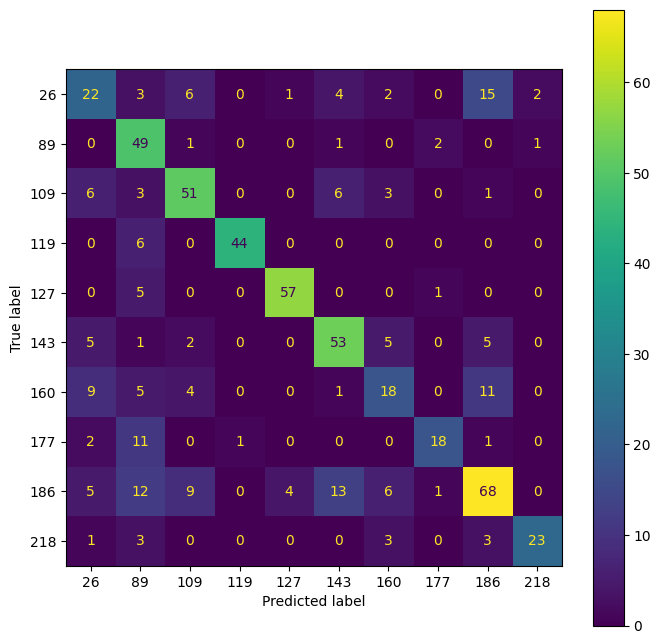

In [ ]:
cm_svc = confusion_matrix(y_test, y_pred_svc)
cm_display_svc = ConfusionMatrixDisplay(confusion_matrix=cm_svc, display_labels=class_labels)
fig, ax = plt.subplots(figsize=(8, 8))
cm_display_svc.plot(cmap='viridis', values_format='d', ax=ax)
plt.show()

In [ ]:
accuracy = accuracy_score(y_test, y_pred_svc)
recall = recall_score(y_test, y_pred_svc, average='macro')
precision = precision_score(y_test, y_pred_svc, average = 'macro')
f1 = f1_score(y_test, y_pred_svc, average = 'macro')
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1-score:", f1)

Accuracy: 0.6773109243697479
Recall: 0.6760915042845099
Precision: 0.705837977609078
F1-score: 0.6797144855758359


In [ ]:
print("Accuracy test: ", model_svc.score(X_test, y_test))
print("Accuracy train: ", model_svc.score(X_train, y_train))

Accuracy test:  0.6773109243697479
Accuracy train:  0.9113832853025937


**CROSS VALIDATION**

In [ ]:
cv_results = cross_validate(svc, X_test, y_test, cv=5, scoring=('balanced_accuracy','precision_macro', 'recall_macro','f1_macro'))

In [ ]:
sorted(cv_results.keys())

['fit_time',
 'score_time',
 'test_balanced_accuracy',
 'test_f1_macro',
 'test_precision_macro',
 'test_recall_macro']

In [ ]:
print("Accuracy:\n", cv_results['test_balanced_accuracy'], "\n Mean: ", np.mean(cv_results['test_balanced_accuracy']))
print("Precision:\n" , cv_results['test_precision_macro'], "\n Mean: ", np.mean(cv_results['test_precision_macro']))
print("Recall:\n", cv_results['test_recall_macro'], "\n Mean: ", np.mean(cv_results['test_recall_macro']))
print("F1-score:\n", cv_results['test_f1_macro'], "\n Mean: ", np.mean(cv_results['test_f1_macro']))

Accuracy:
 [0.57029471 0.57348263 0.53439922 0.58432242 0.48453463] 
 Mean:  0.5494067212980256
Precision:
 [0.62947486 0.66309117 0.66388889 0.62945055 0.55031746] 
 Mean:  0.6272445862484811
Recall:
 [0.57029471 0.57348263 0.53439922 0.58432242 0.48453463] 
 Mean:  0.5494067212980256
F1-score:
 [0.5619128  0.58935435 0.57254615 0.5852304  0.48146747] 
 Mean:  0.558102235428753


In [ ]:
score_result= score_result.append({"Model":"SVC","Balanced Accuracy":np.mean(cv_results['test_balanced_accuracy']), "Precision":np.mean(cv_results['test_precision_macro']), "Recall":np.mean(cv_results['test_recall_macro']), "F1-score":np.mean(cv_results['test_f1_macro'])}, ignore_index=True)

## **RandomForest:**

In [ ]:
model = RandomForestClassifier(random_state=42)
params = {'n_estimators':[50,100,200,300,500],'min_samples_split':[2,3,5,10],'min_samples_leaf':[1,3,5,10],'max_depth':[1,3,5,10,None], 'class_weight':['balanced', None]}
grid = GridSearchCV(model, params, cv=5, scoring='f1_macro', verbose=1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 800 candidates, totalling 4000 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={'class_weight': ['balanced', None],
                         'max_depth': [1, 3, 5, 10, None],
                         'min_samples_leaf': [1, 3, 5, 10],
                         'min_samples_split': [2, 3, 5, 10],
                         'n_estimators': [50, 100, 200, 300, 500]},
             scoring='f1_macro', verbose=1)

In [ ]:
print(grid.best_params_)
print(grid.best_estimator_)
print(grid.best_score_)

{'class_weight': 'balanced', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 300}
RandomForestClassifier(class_weight='balanced', min_samples_split=3,
                       n_estimators=300, random_state=42)
0.7207471635608913


In [ ]:
rf = RandomForestClassifier(class_weight='balanced', min_samples_split=3, n_estimators=300, random_state=42)

In [ ]:
model_rf = rf.fit(X_train,y_train)

In [ ]:
y_pred_rf = model_rf.predict(X_test)

**MODEL EVALUATION:**

In [ ]:
df_pred = pd.DataFrame({'Actual': y_test.squeeze(), 'Predicted': y_pred_rf.squeeze()})
print(df_pred)

      Actual  Predicted
3065     109        109
1861     127        127
3189     160         26
3023     218        218
1419      26         26
...      ...        ...
3619      89         89
1207     109        109
3982     186         26
3552     127        127
3406     186        177

[595 rows x 2 columns]


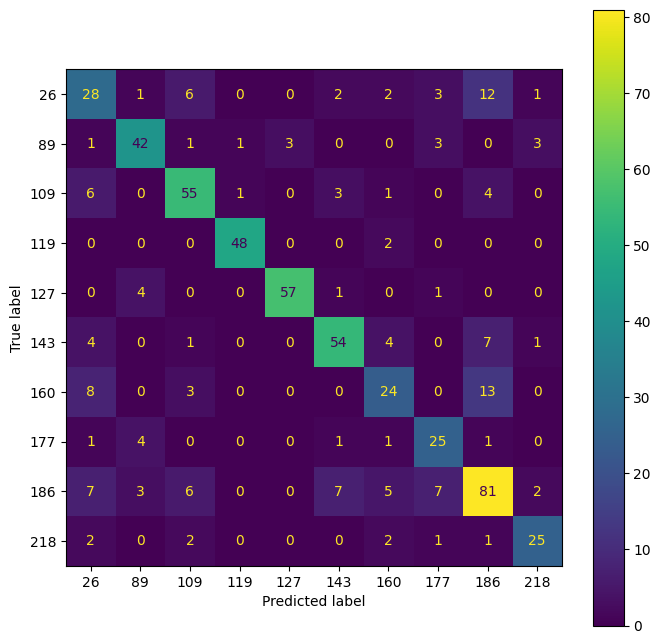

In [ ]:
cm_rf = confusion_matrix(y_test, y_pred_rf)
cm_display_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=class_labels)
fig, ax = plt.subplots(figsize=(8, 8))
cm_display_rf.plot(cmap='viridis', values_format='d', ax=ax)
plt.show()

In [ ]:
accuracy = balanced_accuracy_score(y_test, y_pred_rf)
recall = recall_score(y_test, y_pred_rf, average='macro')
precision = precision_score(y_test, y_pred_rf, average='macro')
f1 = f1_score(y_test, y_pred_rf, average='macro')
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1-score:", f1)

Accuracy: 0.7399500450744185
Recall: 0.7399500450744185
Precision: 0.7388654860821384
F1-score: 0.7382506774799718


In [ ]:
print("Accuracy test: ", model_rf.score(X_test, y_test))
print("Accuracy train: ", model_rf.score(X_train, y_train))

Accuracy test:  0.7378151260504202
Accuracy train:  0.9438040345821326


**CROSS VALIDATION**

In [ ]:
cv_results = cross_validate(rf, X_test, y_test, cv=5, scoring=('balanced_accuracy','precision_macro', 'recall_macro','f1_macro'))

In [ ]:
sorted(cv_results.keys())

['fit_time',
 'score_time',
 'test_balanced_accuracy',
 'test_f1_macro',
 'test_precision_macro',
 'test_recall_macro']

In [ ]:
print("Accuracy:\n", cv_results['test_balanced_accuracy'], "\n Mean: ", np.mean(cv_results['test_balanced_accuracy']))
print("Precision:\n" , cv_results['test_precision_macro'], "\n Mean: ", np.mean(cv_results['test_precision_macro']))
print("Recall:\n", cv_results['test_recall_macro'], "\n Mean: ", np.mean(cv_results['test_recall_macro']))
print("F1-score:\n", cv_results['test_f1_macro'], "\n Mean: ", np.mean(cv_results['test_f1_macro']))

Accuracy:
 [0.59358475 0.69268287 0.70686898 0.65803689 0.66212121] 
 Mean:  0.6626589400937226
Precision:
 [0.59688702 0.75031131 0.72258728 0.65859413 0.64215146] 
 Mean:  0.6741062401425485
Recall:
 [0.59358475 0.69268287 0.70686898 0.65803689 0.66212121] 
 Mean:  0.6626589400937226
F1-score:
 [0.58177093 0.70233991 0.71142279 0.65214935 0.64683416] 
 Mean:  0.6589034279130745


In [ ]:
score_result= score_result.append({"Model":"RF","Balanced Accuracy":np.mean(cv_results['test_balanced_accuracy']), "Precision":np.mean(cv_results['test_precision_macro']), "Recall":np.mean(cv_results['test_recall_macro']), "F1-score":np.mean(cv_results['test_f1_macro'])}, ignore_index=True)

## **KNN:**

In [ ]:
model = KNeighborsClassifier()
params = {'n_neighbors':[2,3,4,5,7,10,20],'weights':['uniform','distance'],'leaf_size':[5,10,30,50,100],'p':[1,2,3]}
grid = GridSearchCV(model, params, cv=5, scoring='f1_macro', verbose=1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 210 candidates, totalling 1050 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'leaf_size': [5, 10, 30, 50, 100],
                         'n_neighbors': [2, 3, 4, 5, 7, 10, 20], 'p': [1, 2, 3],
                         'weights': ['uniform', 'distance']},
             scoring='f1_macro', verbose=1)

In [ ]:
print(grid.best_params_)
print(grid.best_estimator_)
print(grid.best_score_)

{'leaf_size': 50, 'n_neighbors': 4, 'p': 1, 'weights': 'distance'}
KNeighborsClassifier(leaf_size=50, n_neighbors=4, p=1, weights='distance')
0.7020736409778927


In [ ]:
knn = KNeighborsClassifier(leaf_size=50, n_neighbors=4, p=1, weights='distance')

In [ ]:
model_knn = knn.fit(X_train,y_train)

In [ ]:
y_pred_knn = model_knn.predict(X_test)

**MODEL EVALUATION:**

In [ ]:
df_pred = pd.DataFrame({'Actual': y_test.squeeze(), 'Predicted': y_pred_knn.squeeze()})
print(df_pred)

      Actual  Predicted
3065     109        109
1861     127        127
3189     160         26
3023     218        218
1419      26         26
...      ...        ...
3619      89         89
1207     109        109
3982     186         26
3552     127        127
3406     186        177

[595 rows x 2 columns]


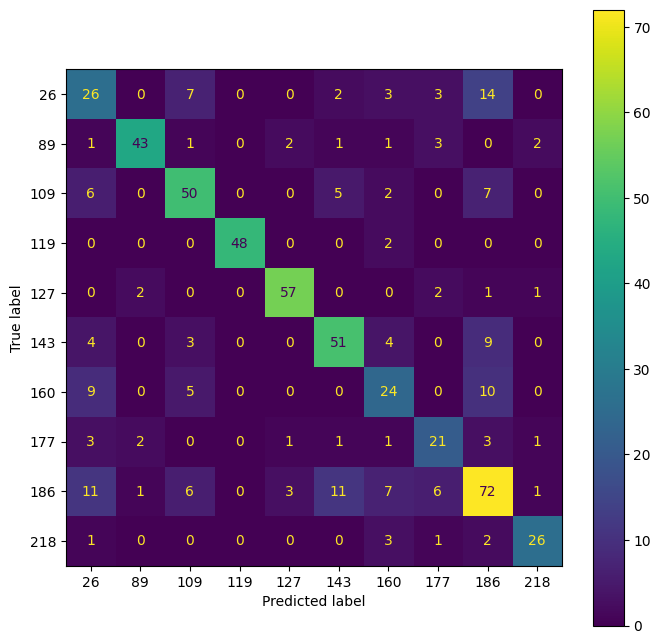

In [ ]:
cm_knn = confusion_matrix(y_test, y_pred_knn)
cm_display_knn = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=class_labels)
fig, ax = plt.subplots(figsize=(8, 8))
cm_display_knn.plot(cmap='viridis', values_format='d', ax=ax)
plt.show()

In [ ]:
accuracy = balanced_accuracy_score(y_test, y_pred_knn)
recall = recall_score(y_test, y_pred_knn, average='macro')
precision = precision_score(y_test, y_pred_knn, average='macro')
f1 = f1_score(y_test, y_pred_knn, average='macro')
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Precision:", precision)
print("F1-score:", f1)

Accuracy: 0.7100792962993967
Recall: 0.7100792962993967
Precision: 0.7182429850041786
F1-score: 0.7134930371329204


In [ ]:
print("Accuracy test: ", model_knn.score(X_test, y_test))
print("Accuracy train: ", model_knn.score(X_train, y_train))

Accuracy test:  0.7025210084033613
Accuracy train:  0.9423631123919308


**CROSS VALIDATION**

In [ ]:
cv_results = cross_validate(knn, X_test, y_test, cv=5, scoring=('balanced_accuracy','precision_macro', 'recall_macro','f1_macro'))

In [ ]:
sorted(cv_results.keys())

['fit_time',
 'score_time',
 'test_balanced_accuracy',
 'test_f1_macro',
 'test_precision_macro',
 'test_recall_macro']

In [ ]:
print("Accuracy:\n", cv_results['test_balanced_accuracy'], "\n Mean: ", np.mean(cv_results['test_balanced_accuracy']))
print("Precision:\n" , cv_results['test_precision_macro'], "\n Mean: ", np.mean(cv_results['test_precision_macro']))
print("Recall:\n", cv_results['test_recall_macro'], "\n Mean: ", np.mean(cv_results['test_recall_macro']))
print("F1-score:\n", cv_results['test_f1_macro'], "\n Mean: ", np.mean(cv_results['test_f1_macro']))

Accuracy:
 [0.57135281 0.62272256 0.66743488 0.68301807 0.60041126] 
 Mean:  0.6289879154661764
Precision:
 [0.55946875 0.64630571 0.71027778 0.67819934 0.59358225] 
 Mean:  0.637566765664676
Recall:
 [0.57135281 0.62272256 0.66743488 0.68301807 0.60041126] 
 Mean:  0.6289879154661764
F1-score:
 [0.55650231 0.62637069 0.67503883 0.67462514 0.58936152] 
 Mean:  0.6243796967119825


In [ ]:
score_result= score_result.append({"Model":"KNN","Balanced Accuracy":np.mean(cv_results['test_balanced_accuracy']), "Precision":np.mean(cv_results['test_precision_macro']), "Recall":np.mean(cv_results['test_recall_macro']), "F1-score":np.mean(cv_results['test_f1_macro'])}, ignore_index=True)

## **Results:**

In [ ]:
y_test.value_counts()

186    118
143     71
109     70
127     63
26      55
89      54
119     50
160     48
218     33
177     33
Name: label, dtype: int64

In [ ]:
score_result

Model  Balanced Accuracy  Precision    Recall  F1-score
0   SVC           0.549407   0.627245  0.549407  0.558102
1    RF           0.662659   0.674106  0.662659  0.658903
2   KNN           0.628988   0.637567  0.628988  0.624380

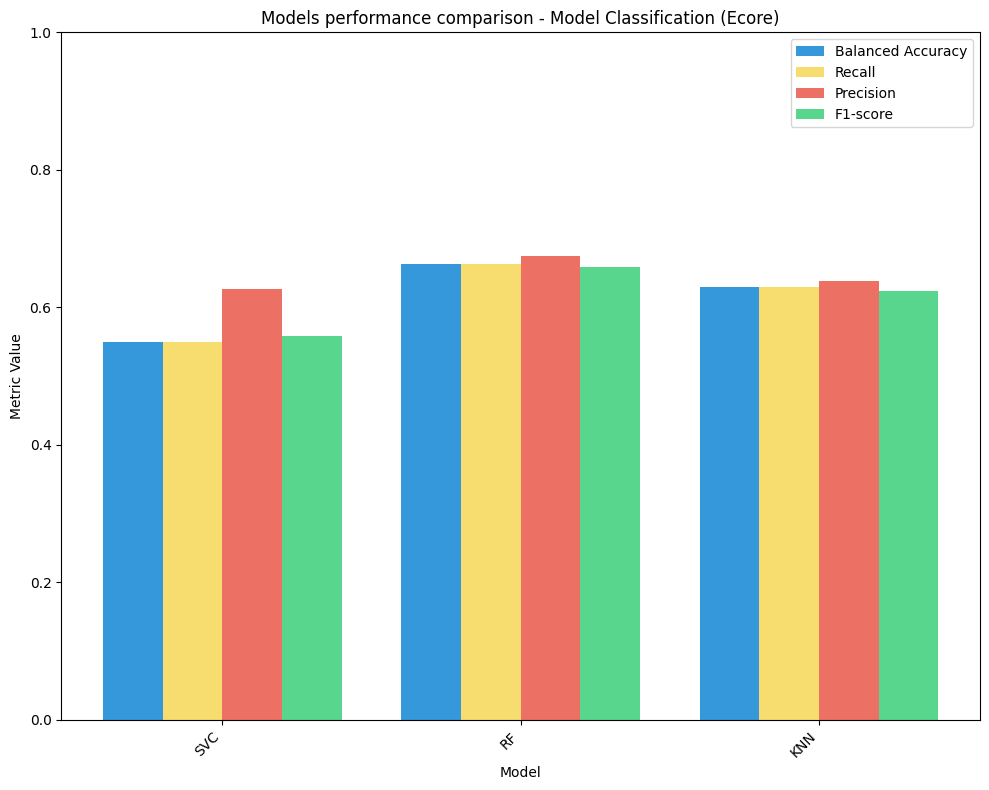

In [ ]:
metrics = ['Balanced Accuracy', 'Recall', 'Precision', 'F1-score']
colors = ['#3498DB', '#F7DC6F','#EC7063', '#58D68D']

num_models = len(score_result)
width_bar = 0.20
x = range(num_models)

plt.figure(figsize=(10, 8))

for i, metric in enumerate(metrics):
    pos_x = [pos + i * width_bar for pos in x]
    values_metric = score_result[metric]

    plt.bar(
        pos_x,
        values_metric,
        width=width_bar,
        label=metric,
        color=colors[i],
    )

plt.xlabel('Model')
plt.ylabel('Metric Value')
plt.title('Models performance comparison - Model Classification (Ecore)')
plt.xticks([pos + (len(metrics) - 1) * width_bar / 2 for pos in x], score_result['Model'], rotation=45, ha="right")
plt.legend(loc='best')
plt.tight_layout()
plt.ylim(0,1)
plt.show()

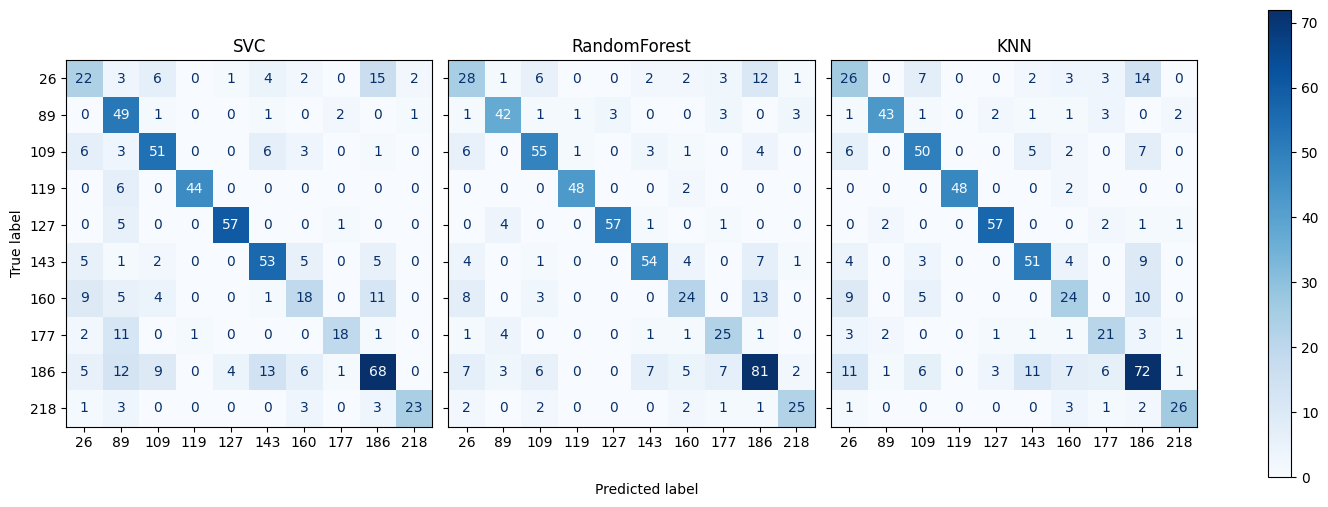

In [ ]:
classifiers = ["SVC", "RandomForest", "KNN"]
matrices_confusion = [cm_svc, cm_rf, cm_knn]
class_names = ["26", "89", "109", "119", "127", "143", "160", "177", "186", "218"]

fig, axes = plt.subplots(1, 3, figsize=(15, 5), sharey="row")

for i, (cm, classifier_name) in enumerate(zip(matrices_confusion, classifiers)):

    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

    disp.plot(ax=axes[i], cmap="Blues")
    axes[i].set_title(classifier_name)
    disp.im_.colorbar.remove()
    disp.ax_.set_xlabel('')
    if i!=0:
        disp.ax_.set_ylabel('')

plt.tight_layout()
fig.text(0.4, 0.0, "Predicted label", ha="left")
fig.colorbar(disp.im_, ax=axes)
plt.show()

In [ ]:
classes_int_transf = label_encoder_nclasses.inverse_transform(class_labels)
mapeo_classes_int = {class_label: number for class_label, number in zip(classes_int_transf, class_labels)}
print("Mapping classes to numbers:")
for class_label, number in mapeo_classes_int.items():
    print(f"{class_label}: {number}")

Mapping classes to numbers:
class-diagram: 26
gpl: 89
library: 109
metamodelling: 119
modelling: 127
petrinet: 143
relational: 160
simple-pl: 177
statemachine: 186
workflow: 218


In [ ]:
report_svc = classification_report(y_test, y_pred_svc, target_names=classes_int_transf)
print(report_svc)

               precision    recall  f1-score   support

class-diagram       0.44      0.40      0.42        55
          gpl       0.50      0.91      0.64        54
      library       0.70      0.73      0.71        70
metamodelling       0.98      0.88      0.93        50
    modelling       0.92      0.90      0.91        63
     petrinet       0.68      0.75      0.71        71
   relational       0.49      0.38      0.42        48
    simple-pl       0.82      0.55      0.65        33
 statemachine       0.65      0.58      0.61       118
     workflow       0.88      0.70      0.78        33

     accuracy                           0.68       595
    macro avg       0.71      0.68      0.68       595
 weighted avg       0.69      0.68      0.68       595



In [ ]:
report_rf = classification_report(y_test, y_pred_rf, target_names=classes_int_transf)
print(report_rf)

               precision    recall  f1-score   support

class-diagram       0.49      0.51      0.50        55
          gpl       0.78      0.78      0.78        54
      library       0.74      0.79      0.76        70
metamodelling       0.96      0.96      0.96        50
    modelling       0.95      0.90      0.93        63
     petrinet       0.79      0.76      0.78        71
   relational       0.59      0.50      0.54        48
    simple-pl       0.62      0.76      0.68        33
 statemachine       0.68      0.69      0.68       118
     workflow       0.78      0.76      0.77        33

     accuracy                           0.74       595
    macro avg       0.74      0.74      0.74       595
 weighted avg       0.74      0.74      0.74       595



In [ ]:
report_knn = classification_report(y_test, y_pred_knn, target_names=classes_int_transf)
print(report_knn)

               precision    recall  f1-score   support

class-diagram       0.43      0.47      0.45        55
          gpl       0.90      0.80      0.84        54
      library       0.69      0.71      0.70        70
metamodelling       1.00      0.96      0.98        50
    modelling       0.90      0.90      0.90        63
     petrinet       0.72      0.72      0.72        71
   relational       0.51      0.50      0.51        48
    simple-pl       0.58      0.64      0.61        33
 statemachine       0.61      0.61      0.61       118
     workflow       0.84      0.79      0.81        33

     accuracy                           0.70       595
    macro avg       0.72      0.71      0.71       595
 weighted avg       0.71      0.70      0.71       595





---

Las classes que mejor se predicen segun F1-score son:
- metamodelling ---> 119
- modelling ---> 127
- workflow ---> 218
- gpl ---> 89
- library ---> 109

---



# Instance Selection:

In this section, we perform the selection of instances to be studied in local explainability. The selected instances must meet the condition of being classified in the same class by all three models.

In [ ]:
df_results = pd.DataFrame({'Real': y_test, 'Pred_SVC': y_pred_svc, 'Pred_RF': y_pred_rf, 'Pred_KNN': y_pred_knn})
df_results = df_results[(df_results['Real'] == df_results['Pred_SVC']) & (df_results['Real'] == df_results['Pred_RF']) & (df_results['Real'] == df_results['Pred_KNN'])]

In [ ]:
df_results

Real  Pred_SVC  Pred_RF  Pred_KNN
3065   109       109      109       109
1861   127       127      127       127
3023   218       218      218       218
1419    26        26       26        26
212    218       218      218       218
...    ...       ...      ...       ...
4834   109       109      109       109
124     89        89       89        89
3619    89        89       89        89
1207   109       109      109       109
3552   127       127      127       127

[364 rows x 4 columns]

In [ ]:
df_class_meta = df_results[df_results['Real'] == 119]
df_class_model = df_results[df_results['Real'] == 127]
df_class_wf = df_results[df_results['Real'] == 218]
df_class_gpl = df_results[df_results['Real'] == 89]
df_class_lib = df_results[df_results['Real'] == 109]

In [ ]:
print(f"Number of instances for the class Metamodelling: {len(df_class_meta)}")
print(f"Number of instances for the class Modelling: {len(df_class_model)}")
print(f"Number of instances for the class Workflow: {len(df_class_wf)}")
print(f"Number of instances for the class Gpl: {len(df_class_gpl)}")
print(f"Number of instances for the class Library: {len(df_class_lib)}")

Number of instances for the class Metamodelling: 44
Number of instances for the class Modelling: 56
Number of instances for the class Workflow: 23
Number of instances for the class Gpl: 40
Number of instances for the class Library: 47


In [ ]:
df_class_meta.head()

Real  Pred_SVC  Pred_RF  Pred_KNN
4634   119       119      119       119
1022   119       119      119       119
274    119       119      119       119
2327   119       119      119       119
4472   119       119      119       119

In [ ]:
df_class_model.head()

Real  Pred_SVC  Pred_RF  Pred_KNN
1861   127       127      127       127
881    127       127      127       127
4694   127       127      127       127
2600   127       127      127       127
2897   127       127      127       127

In [ ]:
df_class_wf.head()

Real  Pred_SVC  Pred_RF  Pred_KNN
3023   218       218      218       218
212    218       218      218       218
1908   218       218      218       218
3203   218       218      218       218
1441   218       218      218       218

In [ ]:
df_class_gpl.head()

Real  Pred_SVC  Pred_RF  Pred_KNN
3702    89        89       89        89
5256    89        89       89        89
4656    89        89       89        89
2460    89        89       89        89
4087    89        89       89        89

In [ ]:
df_class_lib.head()

Real  Pred_SVC  Pred_RF  Pred_KNN
3065   109       109      109       109
2012   109       109      109       109
4891   109       109      109       109
903    109       109      109       109
2122   109       109      109       109

In [ ]:
X_results = X_test.loc[df_results[df_results['Real'] == 119].index]
X_results.head()

references   classes  attributes  packages      enum  datatypes
4634    0.292156 -0.227275    0.773193 -0.181304 -0.384317   4.546513
1022   -0.516150 -0.550877   -0.135312 -0.181304 -0.384317   7.293591
274    -0.589633 -0.622788   -0.589564 -0.181304 -0.384317   0.360490
2327   -0.589633 -0.622788   -0.589564 -0.181304 -0.384317   0.360490
4472   -0.405927 -0.407054   -0.259199  0.221337 -0.384317   0.098864

In [ ]:
instances_class = df_results[df_results['Real'] == 119]
instances_class.head()

Real  Pred_SVC  Pred_RF  Pred_KNN
4634   119       119      119       119
1022   119       119      119       119
274    119       119      119       119
2327   119       119      119       119
4472   119       119      119       119

In [ ]:
dfs_select = ["df_class_meta", "df_class_model", "df_class_wf", "df_class_gpl", "df_class_lib"]
inst_select_indexes = {}

for df_select in dfs_select:
    df = globals()[df_select]
    if len(df) > 100:
        indexes_inst = df.sample(n=100, random_state=42).index
    else:
        indexes_inst = df.index
    indexes_inst = list(indexes_inst)
    inst_select_indexes[df_select] = indexes_inst

In [ ]:
with open('ecore_multiclass_indexes.pickle', 'wb') as f:
    pickle.dump(inst_select_indexes, f)

In [ ]:
classes_select = [119, 127, 218, 89, 109]
for class_label in classes_select:
    instances_class = df_results[df_results['Real'] == class_label]
    X_results = X_test.loc[df_results[df_results['Real'] == class_label].index]

    probab_pred_svc = svc.predict_proba(X_results)
    probab_pred_rf = rf.predict_proba(X_results)
    probab_pred_knn = knn.predict_proba(X_results)

    index_label = np.where(classes_int_transf ==  label_encoder_nclasses.inverse_transform([class_label]))[0][0]

    prob_svc = probab_pred_svc[:, index_label]
    prob_rf = probab_pred_rf[:, index_label]
    prob_knn = probab_pred_knn[:, index_label]

    index_max_prob_svc = prob_svc.argmax()
    index_max_prob_rf = prob_rf.argmax()
    index_max_prob_knn = prob_knn.argmax()

    instance_max_prob_svc = instances_class.iloc[index_max_prob_svc]
    instance_max_prob_rf = instances_class.iloc[index_max_prob_rf]
    instance_max_prob_knn = instances_class.iloc[index_max_prob_knn]

    if class_label == 119:
      inst_meta_svc = instance_max_prob_svc.name
      inst_meta_rf = instance_max_prob_rf.name
      inst_meta_knn = instance_max_prob_knn.name
    elif class_label == 127:
      inst_mod_svc = instance_max_prob_svc.name
      inst_mod_rf = instance_max_prob_rf.name
      inst_mod_knn = instance_max_prob_knn.name
    elif class_label == 218:
      inst_wf_svc = instance_max_prob_svc.name
      inst_wf_rf = instance_max_prob_rf.name
      inst_wf_knn = instance_max_prob_knn.name
    elif class_label == 89:
      inst_gpl_svc = instance_max_prob_svc.name
      inst_gpl_rf = instance_max_prob_rf.name
      inst_gpl_knn = instance_max_prob_knn.name
    elif class_label == 109:
      inst_lib_svc = instance_max_prob_svc.name
      inst_lib_rf = instance_max_prob_rf.name
      inst_lib_knn = instance_max_prob_knn.name


    print(f"For class {class_label} ({label_encoder_nclasses.inverse_transform([class_label])[0]})")
    print(f"Instance with highest predict_proba in SVC: {instance_max_prob_svc.name}")
    print(f"Instance with highest predict_proba in RF: {instance_max_prob_rf.name}")
    print(f"Instance with highest predict_proba in KNN: {instance_max_prob_knn.name}")
    print("------------------------------------------------------------------------")


For class 119 (metamodelling)
Instance with highest predict_proba in SVC: 3121
Instance with highest predict_proba in RF: 4634
Instance with highest predict_proba in KNN: 4634
------------------------------------------------------------------------
For class 127 (modelling)
Instance with highest predict_proba in SVC: 2600
Instance with highest predict_proba in RF: 1861
Instance with highest predict_proba in KNN: 1861
------------------------------------------------------------------------
For class 218 (workflow)
Instance with highest predict_proba in SVC: 4199
Instance with highest predict_proba in RF: 2194
Instance with highest predict_proba in KNN: 3023
------------------------------------------------------------------------
For class 89 (gpl)
Instance with highest predict_proba in SVC: 3702
Instance with highest predict_proba in RF: 3702
Instance with highest predict_proba in KNN: 3702
------------------------------------------------------------------------
For class 109 (library)


# Explainability:

# Global Explainability:

We conduct the study of global explainability using permutation importance.

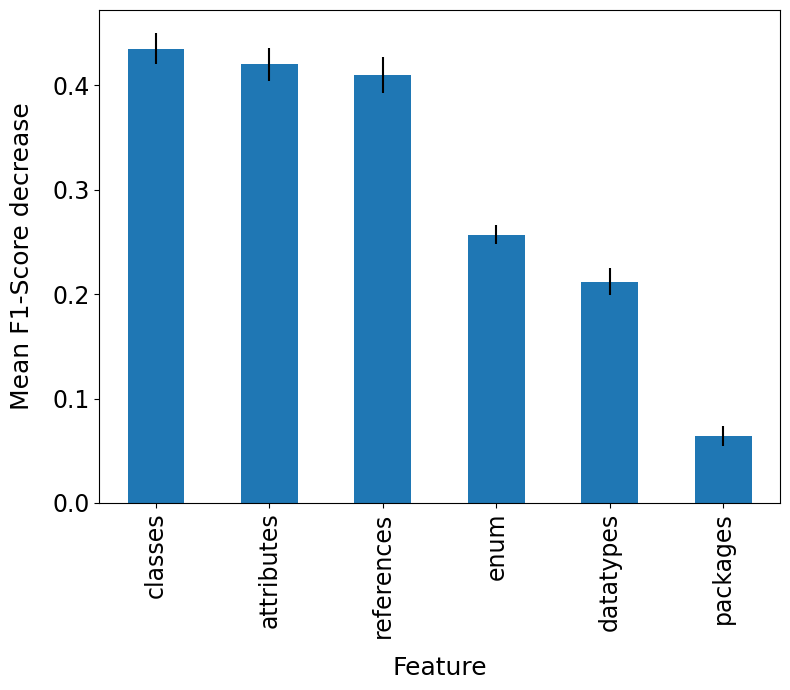

In [ ]:
permu = permutation_importance(model_svc, X_test, y_test, scoring='f1_macro', n_repeats=20, random_state=42, n_jobs=2)
permu_importances = pd.Series(permu.importances_mean.round(3), index=X.columns)[abs(permu.importances_mean.round(3)) > 0.000]
permu_importances.sort_values(ascending=False, inplace=True)
fig, ax = plt.subplots(figsize=(8,7))
permu_importances.plot.bar(yerr=permu.importances_std[abs(permu.importances_mean.round(3)) > 0.000], ax=ax)
ax.set_ylabel("Mean F1-Score decrease", fontsize=18, labelpad=13)
ax.set_xlabel("Feature", fontsize=18, labelpad=13)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
fig.tight_layout()
plt.savefig('ecore_multiclass_globSVC.pdf')
plt.show()

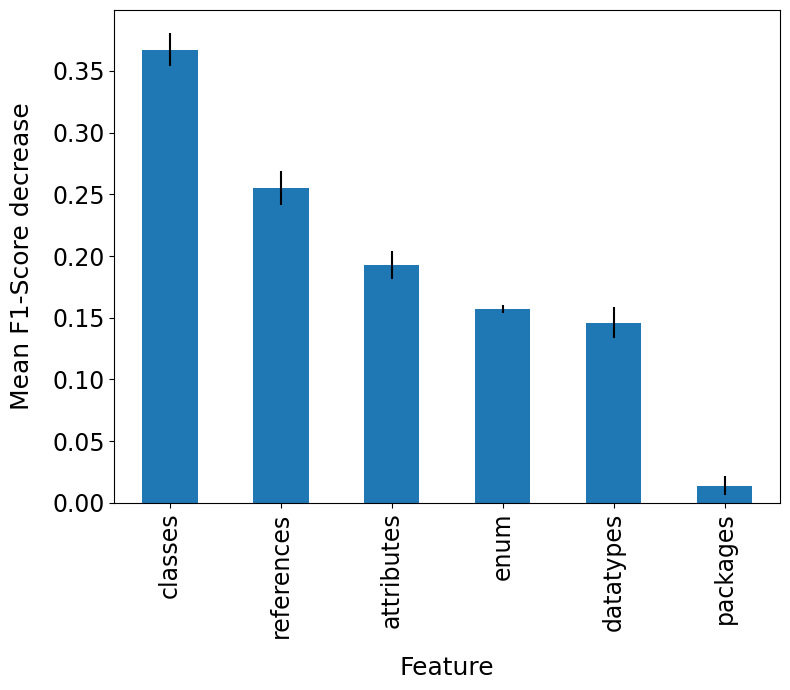

In [ ]:
permu = permutation_importance(model_rf, X_test, y_test, scoring='f1_macro', n_repeats=20, random_state=42, n_jobs=2)
permu_importances = pd.Series(permu.importances_mean.round(3), index=X.columns)[abs(permu.importances_mean.round(3)) > 0.000]
permu_importances.sort_values(ascending=False, inplace=True)
fig, ax = plt.subplots(figsize=(8,7))
permu_importances.plot.bar(yerr=permu.importances_std[abs(permu.importances_mean.round(3)) > 0.000], ax=ax)
ax.set_ylabel("Mean F1-Score decrease", fontsize=18, labelpad=13)
ax.set_xlabel("Feature", fontsize=18, labelpad=13)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
fig.tight_layout()
plt.savefig('ecore_multiclass_globRF.pdf')
plt.show()

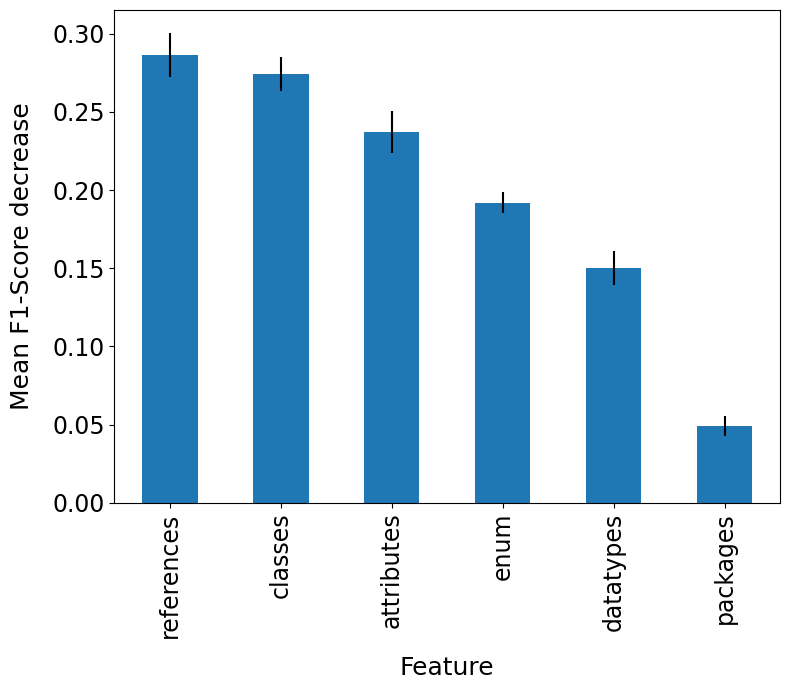

In [ ]:
permu = permutation_importance(model_knn, X_test, y_test, scoring='f1_macro', n_repeats=20, random_state=42, n_jobs=2)
permu_importances = pd.Series(permu.importances_mean.round(3), index=X.columns)[abs(permu.importances_mean.round(3)) > 0.000]
permu_importances.sort_values(ascending=False, inplace=True)
fig, ax = plt.subplots(figsize=(8,7))
permu_importances.plot.bar(yerr=permu.importances_std[abs(permu.importances_mean.round(3)) > 0.000], ax=ax)
ax.set_ylabel("Mean F1-Score decrease", fontsize=18, labelpad=13)
ax.set_xlabel("Feature", fontsize=18, labelpad=13)
plt.xticks(fontsize=17)
plt.yticks(fontsize=17)
fig.tight_layout()
plt.savefig('ecore_multiclass_globKNN.pdf')
plt.show()

# Local Explainability:

Finally, we obtain explanations for the selected instances and calculate the disagreement metrics.

In [ ]:
num_features = len(X_test.columns)
top_num_features = 6

In [ ]:
unique_values = np.unique(y_train)
inst_names = ["metamodelling", "modelling", "workflow", "gpl", "library"]
class_index = [1, 2, 3, 4, 9]

## SVC:

In [ ]:
exp_list_svc = []

for i in range(len(unique_values)):
    class_value = unique_values[i]
    pf = lambda m, d, i=i: m.predict_proba(d)[:, i]
    e = dx.Explainer(
        model_svc, X_train,
        y_train,
        predict_function=pf,
        label=f'SVClassifier: class {class_value}',
        verbose=False
    )
    exp_list_svc += [e]

exp_list_svc

In [ ]:
inst_metamodelling = X_test.loc[inst_meta_svc]
inst_modelling = X_test.loc[inst_mod_svc]
inst_workflow = X_test.loc[inst_wf_svc]
inst_gpl = X_test.loc[inst_gpl_svc]
inst_library = X_test.loc[inst_lib_svc]

In [ ]:
svc_exp_results = {}

for instance in inst_names:
    breakdown_exp = [exp.predict_parts(eval(f"inst_{instance}"), type='break_down', random_state=42) for exp in exp_list_svc]
    svc_exp_results[f"breakdown_{instance}"] = breakdown_exp

    shap_exp = [exp.predict_parts(eval(f"inst_{instance}"), type='shap', random_state=42) for exp in exp_list_svc]
    svc_exp_results[f"shap_{instance}"] = shap_exp

    lime_exp = [exp.predict_surrogate(eval(f"inst_{instance}"), random_state=42, class_names=[0, unique_values[i]]) for i, exp in enumerate(exp_list_svc)]
    svc_exp_results[f"lime_{instance}"] = lime_exp

### **METAMODELLING:**

In [ ]:
breakdown_df_metamodelling_gpl = svc_exp_results['breakdown_metamodelling'][1].result
shap_df_metamodelling_gpl = svc_exp_results['shap_metamodelling'][1].result
lime_df_metamodelling_gpl = svc_exp_results['lime_metamodelling'][1].result

In [ ]:
breakdown_df_metamodelling_lib = svc_exp_results['breakdown_metamodelling'][2].result
shap_df_metamodelling_lib = svc_exp_results['shap_metamodelling'][2].result
lime_df_metamodelling_lib = svc_exp_results['lime_metamodelling'][2].result

In [ ]:
breakdown_df_metamodelling_meta = svc_exp_results['breakdown_metamodelling'][3].result
shap_df_metamodelling_meta = svc_exp_results['shap_metamodelling'][3].result
lime_df_metamodelling_meta = svc_exp_results['lime_metamodelling'][3].result

In [ ]:
breakdown_df_metamodelling_mod = svc_exp_results['breakdown_metamodelling'][4].result
shap_df_metamodelling_mod = svc_exp_results['shap_metamodelling'][4].result
lime_df_metamodelling_mod = svc_exp_results['lime_metamodelling'][4].result

In [ ]:
breakdown_df_metamodelling_wf = svc_exp_results['breakdown_metamodelling'][9].result
shap_df_metamodelling_wf = svc_exp_results['shap_metamodelling'][9].result
lime_df_metamodelling_wf = svc_exp_results['lime_metamodelling'][9].result

In [ ]:
exp_plots_bd = [svc_exp_results['breakdown_metamodelling'][i] for i in class_index]
exp_plots_bd[0].plot(exp_plots_bd[1:])

In [ ]:
exp_plots_shap = [svc_exp_results['shap_metamodelling'][i] for i in class_index]
exp_plots_shap[0].plot(exp_plots_shap[1:])

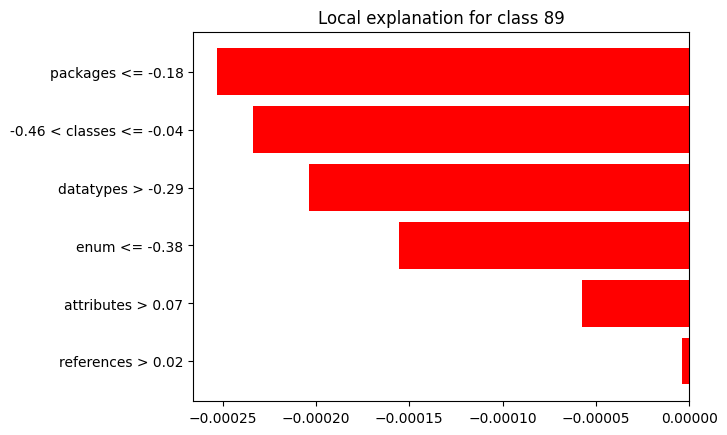

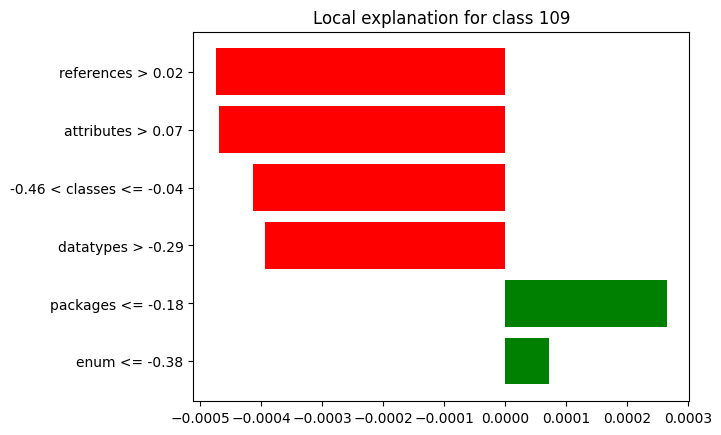

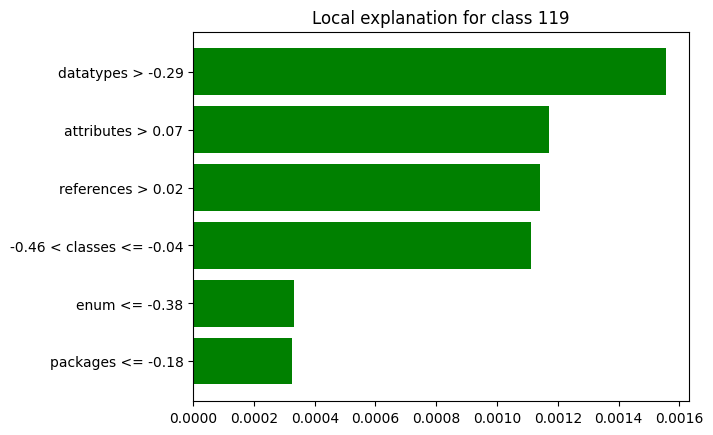

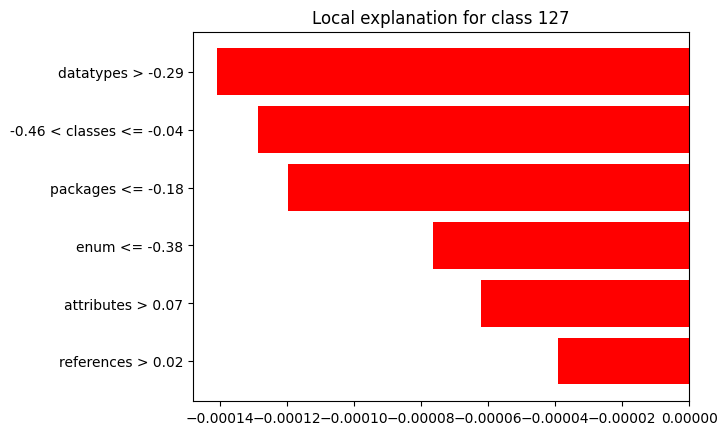

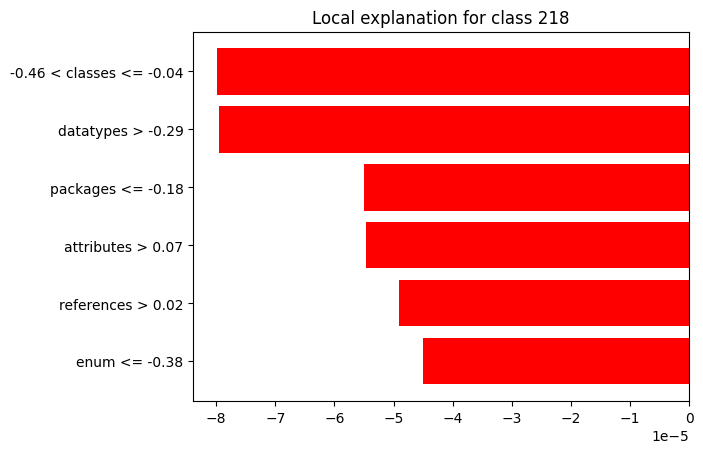

In [ ]:
for i in class_index:
  svc_exp_results['lime_metamodelling'][i].plot()

In [ ]:
breakdown_df_metamodelling_gpl, shap_df_metamodelling_gpl, lime_df_metamodelling_gpl, df_final_svc_meta_gpl = preprocess_dfs(breakdown_df_metamodelling_gpl, shap_df_metamodelling_gpl, lime_df_metamodelling_gpl, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_metamodelling_gpl)
print('----------------------------------------------')
print(shap_df_metamodelling_gpl)
print('----------------------------------------------')
print(lime_df_metamodelling_gpl)

['classes', 'packages', 'enum', 'references', 'attributes', 'datatypes']
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Negative
1  references        2  Positive
2        enum        3  Negative
3  attributes        4  Negative
4    packages        5  Negative
5   datatypes        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Negative
1  attributes        2  Negative
2   datatypes        3  Negative
3        enum        4  Negative
4  references        5  Positive
5    packages        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0    packages        1  Negative
1     classes        2  Negative
2   datatypes        3  Negative
3        enum        4  Negative
4  attributes        5  Negative
5  references        6  Negative


In [ ]:
df_final_svc_meta_gpl

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
classes            1  Negative       1  Negative       2  Negative
references         2  Positive       5  Positive       6  Negative
enum               3  Negative       4  Negative       4  Negative
attributes         4  Negative       2  Negative       5  Negative
packages           5  Negative       6  Negative       1  Negative
datatypes          6  Negative       3  Negative       3  Negative

In [ ]:
breakdown_df_metamodelling_lib, shap_df_metamodelling_lib, lime_df_metamodelling_lib, df_final_svc_meta_lib = preprocess_dfs(breakdown_df_metamodelling_lib, shap_df_metamodelling_lib, lime_df_metamodelling_lib, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_metamodelling_lib)
print('----------------------------------------------')
print(shap_df_metamodelling_lib)
print('----------------------------------------------')
print(lime_df_metamodelling_lib)

['classes', 'enum', 'references', 'attributes', 'datatypes', 'packages']
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Negative
1  attributes        2  Negative
2  references        3  Negative
3        enum        4  Negative
4   datatypes        5  Negative
5    packages        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0  references        1  Negative
1     classes        2  Negative
2   datatypes        3  Negative
3  attributes        4  Negative
4        enum        5  Negative
5    packages        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0  references        1  Negative
1  attributes        2  Negative
2     classes        3  Negative
3   datatypes        4  Negative
4    packages        5  Positive
5        enum        6  Positive


In [ ]:
df_final_svc_meta_lib

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
classes            1  Negative       2  Negative       3  Negative
attributes         2  Negative       4  Negative       2  Negative
references         3  Negative       1  Negative       1  Negative
enum               4  Negative       5  Negative       6  Positive
datatypes          5  Negative       3  Negative       4  Negative
packages           6  Positive       6  Negative       5  Positive

In [ ]:
breakdown_df_metamodelling_meta, shap_df_metamodelling_meta, lime_df_metamodelling_meta, df_final_svc_meta_meta = preprocess_dfs(breakdown_df_metamodelling_meta, shap_df_metamodelling_meta, lime_df_metamodelling_meta, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_metamodelling_meta)
print('----------------------------------------------')
print(shap_df_metamodelling_meta)
print('----------------------------------------------')
print(lime_df_metamodelling_meta)

['classes', 'packages', 'enum', 'references', 'attributes', 'datatypes']
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Positive
1        enum        2  Positive
2    packages        3  Positive
3   datatypes        4  Positive
4  attributes        5  Positive
5  references        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0   datatypes        1  Positive
1  attributes        2  Positive
2     classes        3  Positive
3  references        4  Positive
4        enum        5  Positive
5    packages        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0   datatypes        1  Positive
1  attributes        2  Positive
2  references        3  Positive
3     classes        4  Positive
4        enum        5  Positive
5    packages        6  Positive


In [ ]:
df_final_svc_meta_meta

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
classes            1  Positive       3  Positive       4  Positive
enum               2  Positive       5  Positive       5  Positive
packages           3  Positive       6  Positive       6  Positive
datatypes          4  Positive       1  Positive       1  Positive
attributes         5  Positive       2  Positive       2  Positive
references         6  Negative       4  Positive       3  Positive

In [ ]:
breakdown_df_metamodelling_mod, shap_df_metamodelling_mod, lime_df_metamodelling_mod, df_final_svc_meta_mod = preprocess_dfs(breakdown_df_metamodelling_mod, shap_df_metamodelling_mod, lime_df_metamodelling_mod, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_metamodelling_mod)
print('----------------------------------------------')
print(shap_df_metamodelling_mod)
print('----------------------------------------------')
print(lime_df_metamodelling_mod)

['classes', 'enum', 'references', 'attributes', 'datatypes', 'packages']
----------------------------------------------
      Feature  Ranking      Sign
0  attributes        1  Negative
1     classes        2  Positive
2  references        3  Negative
3        enum        4  Negative
4   datatypes        5  Negative
5    packages        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0   datatypes        1  Negative
1  attributes        2  Negative
2  references        3  Negative
3        enum        4  Negative
4     classes        5  Negative
5    packages        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0   datatypes        1  Negative
1     classes        2  Negative
2    packages        3  Negative
3        enum        4  Negative
4  attributes        5  Negative
5  references        6  Negative


In [ ]:
df_final_svc_meta_mod

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
attributes         1  Negative       2  Negative       5  Negative
classes            2  Positive       5  Negative       2  Negative
references         3  Negative       3  Negative       6  Negative
enum               4  Negative       4  Negative       4  Negative
datatypes          5  Negative       1  Negative       1  Negative
packages           6  Negative       6  Negative       3  Negative

In [ ]:
breakdown_df_metamodelling_wf, shap_df_metamodelling_wf, lime_df_metamodelling_wf, df_final_svc_meta_wf = preprocess_dfs(breakdown_df_metamodelling_wf, shap_df_metamodelling_wf, lime_df_metamodelling_wf, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_metamodelling_wf)
print('----------------------------------------------')
print(shap_df_metamodelling_wf)
print('----------------------------------------------')
print(lime_df_metamodelling_wf)

['classes', 'packages', 'enum', 'references', 'attributes', 'datatypes']
----------------------------------------------
      Feature  Ranking      Sign
0  references        1  Negative
1     classes        2  Positive
2   datatypes        3  Negative
3        enum        4  Negative
4    packages        5  Negative
5  attributes        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0   datatypes        1  Negative
1  references        2  Negative
2  attributes        3  Negative
3        enum        4  Negative
4     classes        5  Negative
5    packages        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Negative
1   datatypes        2  Negative
2    packages        3  Negative
3  attributes        4  Negative
4  references        5  Negative
5        enum        6  Negative


In [ ]:
df_final_svc_meta_wf

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
references         1  Negative       2  Negative       5  Negative
classes            2  Positive       5  Negative       1  Negative
datatypes          3  Negative       1  Negative       2  Negative
enum               4  Negative       4  Negative       6  Negative
packages           5  Negative       6  Negative       3  Negative
attributes         6  Negative       3  Negative       4  Negative

### **RESULTS METAMODELLING:**

In [ ]:
df_topfeatures_meta_gpl = top3_features(df_final_svc_meta_gpl, 'Metamodelling - Class: GPL')
df_topfeatures_meta_lib = top3_features(df_final_svc_meta_lib, 'Metamodelling - Class: Library')
df_topfeatures_meta_meta = top3_features(df_final_svc_meta_meta, 'Metamodelling - Class: Metamodelling')
df_topfeatures_meta_mod = top3_features(df_final_svc_meta_mod, 'Metamodelling - Class: Modelling')
df_topfeatures_meta_wf = top3_features(df_final_svc_meta_wf, 'Metamodelling - Class: Workflow')

df_topfeatures_metamodelling_svc = pd.concat([df_topfeatures_meta_gpl, df_topfeatures_meta_lib, df_topfeatures_meta_meta, df_topfeatures_meta_mod, df_topfeatures_meta_wf])
df_topfeatures_metamodelling_svc

TOP3 Breakdown  \
Metamodelling - Class: GPL                  enum, classes, references   
Metamodelling - Class: Library        attributes, classes, references   
Metamodelling - Class: Metamodelling          packages, enum, classes   
Metamodelling - Class: Modelling      attributes, classes, references   
Metamodelling - Class: Workflow        datatypes, classes, references   

                                                              TOP3 Shap  \
Metamodelling - Class: GPL               attributes, datatypes, classes   
Metamodelling - Class: Library           datatypes, classes, references   
Metamodelling - Class: Metamodelling     attributes, datatypes, classes   
Metamodelling - Class: Modelling      attributes, datatypes, references   
Metamodelling - Class: Workflow       attributes, datatypes, references   

                                                              TOP3 Lime  \
Metamodelling - Class: GPL                 packages, datatypes, classes   
Metamodelling - Class: Library          attributes, classes, references   
Metamodelling - Class: Metamodelling  attributes, datatypes, references   
Metamodelling - Class: Modelling           packages, datatypes, classes   
Metamodelling - Class: Workflow            packages, datatypes, classes   

                                      Breakdown-Shap  Breakdown-Lime  \
Metamodelling - Class: GPL                  0.333333        0.333333   
Metamodelling - Class: Library              0.666667        1.000000   
Metamodelling - Class: Metamodelling        0.333333        0.000000   
Metamodelling - Class: Modelling            0.666667        0.333333   
Metamodelling - Class: Workflow             0.666667        0.666667   

                                      Lime-Shap  
Metamodelling - Class: GPL             0.666667  
Metamodelling - Class: Library         0.666667  
Metamodelling - Class: Metamodelling   0.666667  
Metamodelling - Class: Modelling       0.333333  
Metamodelling - Class: Workflow        0.333333

In [ ]:
df_topfeatures_meta_gpl_rank = top3_rank(df_final_svc_meta_gpl, 'Metamodelling - Class GPL')
df_topfeatures_meta_lib_rank = top3_rank(df_final_svc_meta_lib, 'Metamodelling - Class Library')
df_topfeatures_meta_meta_rank = top3_rank(df_final_svc_meta_meta, 'Metamodelling - Class Metamodelling')
df_topfeatures_meta_mod_rank = top3_rank(df_final_svc_meta_mod, 'Metamodelling - Class Modelling')
df_topfeatures_meta_wf_rank = top3_rank(df_final_svc_meta_wf, 'Metamodelling - Class Workflow')

df_topfeatures_rank_metamodelling_svc = pd.concat([df_topfeatures_meta_gpl_rank, df_topfeatures_meta_lib_rank, df_topfeatures_meta_meta_rank, df_topfeatures_meta_mod_rank, df_topfeatures_meta_wf_rank])
df_topfeatures_rank_metamodelling_svc

TOP3 Breakdown  \
Metamodelling - Class GPL                  1:classes, 2:references, 3:enum   
Metamodelling - Class Library        1:classes, 2:attributes, 3:references   
Metamodelling - Class Metamodelling          1:classes, 2:enum, 3:packages   
Metamodelling - Class Modelling      1:attributes, 2:classes, 3:references   
Metamodelling - Class Workflow        1:references, 2:classes, 3:datatypes   

                                                                   TOP3 Shap  \
Metamodelling - Class GPL               1:classes, 2:attributes, 3:datatypes   
Metamodelling - Class Library           2:classes, 1:references, 3:datatypes   
Metamodelling - Class Metamodelling     3:classes, 1:datatypes, 2:attributes   
Metamodelling - Class Modelling      2:attributes, 3:references, 1:datatypes   
Metamodelling - Class Workflow       2:references, 1:datatypes, 3:attributes   

                                                                   TOP3 Lime  \
Metamodelling - Class GPL                 2:classes, 1:packages, 3:datatypes   
Metamodelling - Class Library          3:classes, 2:attributes, 1:references   
Metamodelling - Class Metamodelling  1:datatypes, 2:attributes, 3:references   
Metamodelling - Class Modelling           2:classes, 1:datatypes, 3:packages   
Metamodelling - Class Workflow            1:classes, 2:datatypes, 3:packages   

                                     Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Metamodelling - Class GPL                  0.333333        0.000000   0.333333  
Metamodelling - Class Library              0.000000        0.333333   0.333333  
Metamodelling - Class Metamodelling        0.000000        0.000000   0.666667  
Metamodelling - Class Modelling            0.333333        0.333333   0.333333  
Metamodelling - Class Workflow             0.000000        0.000000   0.000000

In [ ]:
df_topfeatures_meta_gpl_sign = top3_sign(df_final_svc_meta_gpl, 'Metamodelling - Class GPL')
df_topfeatures_meta_lib_sign = top3_sign(df_final_svc_meta_lib, 'Metamodelling - Class Library')
df_topfeatures_meta_meta_sign = top3_sign(df_final_svc_meta_meta, 'Metamodelling - Class Metamodelling')
df_topfeatures_meta_mod_sign = top3_sign(df_final_svc_meta_mod, 'Metamodelling - Class Modelling')
df_topfeatures_meta_wf_sign = top3_sign(df_final_svc_meta_wf, 'Metamodelling - Class Workflow')

df_topfeatures_sign_metamodelling_svc = pd.concat([df_topfeatures_meta_gpl_sign, df_topfeatures_meta_lib_sign, df_topfeatures_meta_meta_sign, df_topfeatures_meta_mod_sign, df_topfeatures_meta_wf_sign])
df_topfeatures_sign_metamodelling_svc

TOP3 Breakdown  \
Metamodelling - Class GPL            classes:Negative, references:Positive, enum:Ne...   
Metamodelling - Class Library        classes:Negative, attributes:Negative, referen...   
Metamodelling - Class Metamodelling  classes:Positive, enum:Positive, packages:Posi...   
Metamodelling - Class Modelling      attributes:Negative, classes:Positive, referen...   
Metamodelling - Class Workflow       references:Negative, classes:Positive, datatyp...   

                                                                             TOP3 Shap  \
Metamodelling - Class GPL            classes:Negative, attributes:Negative, datatyp...   
Metamodelling - Class Library        classes:Negative, references:Negative, datatyp...   
Metamodelling - Class Metamodelling  classes:Positive, datatypes:Positive, attribut...   
Metamodelling - Class Modelling      attributes:Negative, references:Negative, data...   
Metamodelling - Class Workflow       references:Negative, datatypes:Negative, attri...   

                                                                             TOP3 Lime  \
Metamodelling - Class GPL            classes:Negative, packages:Negative, datatypes...   
Metamodelling - Class Library        classes:Negative, attributes:Negative, referen...   
Metamodelling - Class Metamodelling  datatypes:Positive, attributes:Positive, refer...   
Metamodelling - Class Modelling      classes:Negative, datatypes:Negative, packages...   
Metamodelling - Class Workflow       classes:Negative, datatypes:Negative, packages...   

                                     Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Metamodelling - Class GPL                  0.333333        0.333333   0.666667  
Metamodelling - Class Library              0.666667        1.000000   0.666667  
Metamodelling - Class Metamodelling        0.333333        0.000000   0.666667  
Metamodelling - Class Modelling            0.666667        0.000000   0.333333  
Metamodelling - Class Workflow             0.666667        0.333333   0.333333

In [ ]:
df_topfeatures_meta_gpl_rank_sign = top3_rank_sign(df_final_svc_meta_gpl, 'Metamodelling - Class GPL')
df_topfeatures_meta_lib_rank_sign = top3_rank_sign(df_final_svc_meta_lib, 'Metamodelling - Class Library')
df_topfeatures_meta_meta_rank_sign = top3_rank_sign(df_final_svc_meta_meta, 'Metamodelling - Class Metamodelling')
df_topfeatures_meta_mod_rank_sign = top3_rank_sign(df_final_svc_meta_mod, 'Metamodelling - Class Modelling')
df_topfeatures_meta_wf_rank_sign = top3_rank_sign(df_final_svc_meta_wf, 'Metamodelling - Class Workflow')

df_topfeatures_rank_sign_metamodelling = pd.concat([df_topfeatures_meta_gpl_rank_sign, df_topfeatures_meta_lib_rank_sign, df_topfeatures_meta_meta_rank_sign, df_topfeatures_meta_mod_rank_sign, df_topfeatures_meta_wf_rank_sign])
df_topfeatures_rank_sign_metamodelling

TOP3 Breakdown  \
Metamodelling - Class GPL            1:classes:Negative, 2:references:Positive, 3:e...   
Metamodelling - Class Library        1:classes:Negative, 2:attributes:Negative, 3:r...   
Metamodelling - Class Metamodelling  1:classes:Positive, 2:enum:Positive, 3:package...   
Metamodelling - Class Modelling      1:attributes:Negative, 2:classes:Positive, 3:r...   
Metamodelling - Class Workflow       1:references:Negative, 2:classes:Positive, 3:d...   

                                                                             TOP3 Shap  \
Metamodelling - Class GPL            1:classes:Negative, 2:attributes:Negative, 3:d...   
Metamodelling - Class Library        2:classes:Negative, 1:references:Negative, 3:d...   
Metamodelling - Class Metamodelling  3:classes:Positive, 1:datatypes:Positive, 2:at...   
Metamodelling - Class Modelling      2:attributes:Negative, 3:references:Negative, ...   
Metamodelling - Class Workflow       2:references:Negative, 1:datatypes:Negative, 3...   

                                                                             TOP3 Lime  \
Metamodelling - Class GPL            2:classes:Negative, 1:packages:Negative, 3:dat...   
Metamodelling - Class Library        3:classes:Negative, 2:attributes:Negative, 1:r...   
Metamodelling - Class Metamodelling  1:datatypes:Positive, 2:attributes:Positive, 3...   
Metamodelling - Class Modelling      2:classes:Negative, 1:datatypes:Negative, 3:pa...   
Metamodelling - Class Workflow       1:classes:Negative, 2:datatypes:Negative, 3:pa...   

                                     Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Metamodelling - Class GPL                  0.333333        0.000000   0.333333  
Metamodelling - Class Library              0.000000        0.333333   0.333333  
Metamodelling - Class Metamodelling        0.000000        0.000000   0.666667  
Metamodelling - Class Modelling            0.333333        0.000000   0.333333  
Metamodelling - Class Workflow             0.000000        0.000000   0.000000

### **MODELLING:**

In [ ]:
breakdown_df_modelling_gpl = svc_exp_results['breakdown_modelling'][1].result
shap_df_modelling_gpl = svc_exp_results['shap_modelling'][1].result
lime_df_modelling_gpl = svc_exp_results['lime_modelling'][1].result

In [ ]:
breakdown_df_modelling_lib = svc_exp_results['breakdown_modelling'][2].result
shap_df_modelling_lib = svc_exp_results['shap_modelling'][2].result
lime_df_modelling_lib = svc_exp_results['lime_modelling'][2].result

In [ ]:
breakdown_df_modelling_meta = svc_exp_results['breakdown_modelling'][3].result
shap_df_modelling_meta = svc_exp_results['shap_modelling'][3].result
lime_df_modelling_meta = svc_exp_results['lime_modelling'][3].result

In [ ]:
breakdown_df_modelling_mod = svc_exp_results['breakdown_modelling'][4].result
shap_df_modelling_mod = svc_exp_results['shap_modelling'][4].result
lime_df_modelling_mod = svc_exp_results['lime_modelling'][4].result

In [ ]:
breakdown_df_modelling_wf = svc_exp_results['breakdown_modelling'][9].result
shap_df_modelling_wf = svc_exp_results['shap_modelling'][9].result
lime_df_modelling_wf = svc_exp_results['lime_modelling'][9].result

In [ ]:
exp_plots_bd = [svc_exp_results['breakdown_modelling'][i] for i in class_index]
exp_plots_bd[0].plot(exp_plots_bd[1:])

In [ ]:
exp_plots_shap = [svc_exp_results['shap_modelling'][i] for i in class_index]
exp_plots_shap[0].plot(exp_plots_shap[1:])

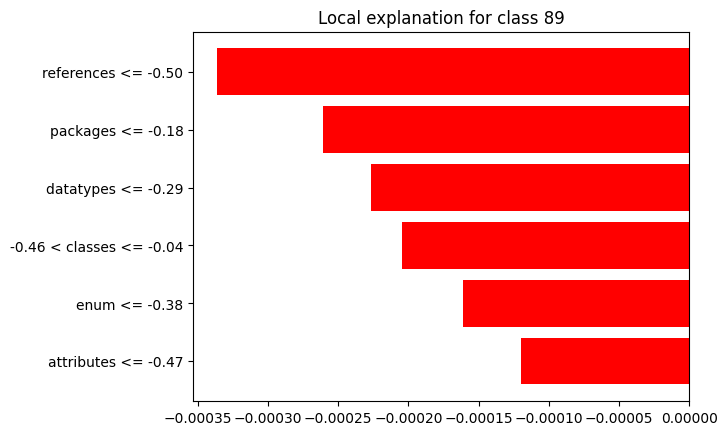

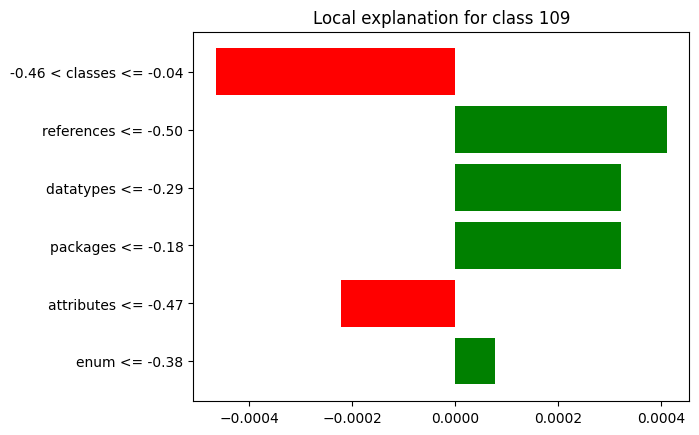

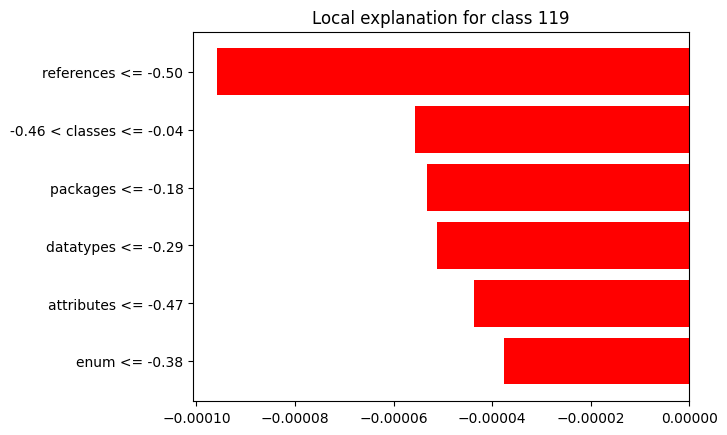

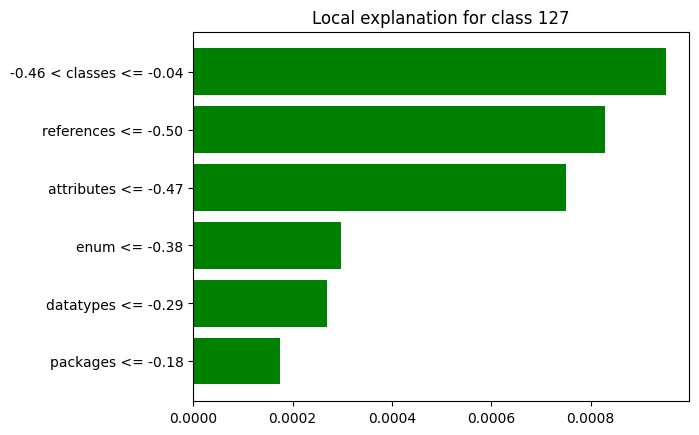

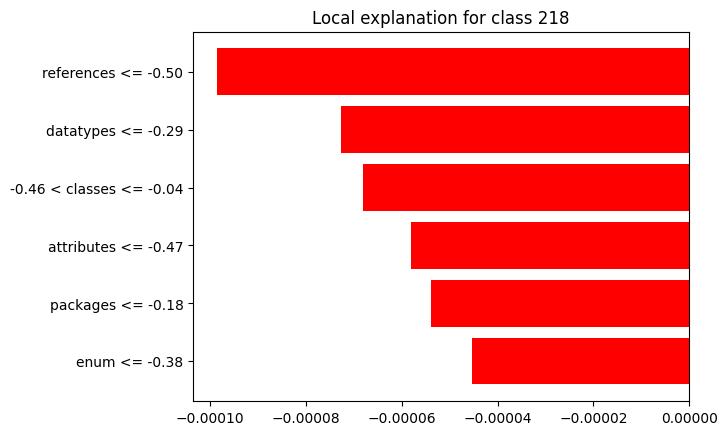

In [ ]:
for i in class_index:
  svc_exp_results['lime_modelling'][i].plot()

In [ ]:
breakdown_df_modelling_gpl, shap_df_modelling_gpl, lime_df_modelling_gpl, df_final_svc_mod_gpl = preprocess_dfs(breakdown_df_modelling_gpl, shap_df_modelling_gpl, lime_df_modelling_gpl, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_modelling_gpl)
print('----------------------------------------------')
print(shap_df_modelling_gpl)
print('----------------------------------------------')
print(lime_df_modelling_gpl)

['classes', 'enum', 'references', 'attributes', 'datatypes', 'packages']
----------------------------------------------
      Feature  Ranking      Sign
0        enum        1  Negative
1  attributes        2  Negative
2  references        3  Negative
3     classes        4  Positive
4   datatypes        5  Positive
5    packages        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0  attributes        1  Negative
1        enum        2  Negative
2  references        3  Negative
3   datatypes        4  Negative
4    packages        5  Negative
5     classes        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0  references        1  Negative
1    packages        2  Negative
2   datatypes        3  Negative
3     classes        4  Negative
4        enum        5  Negative
5  attributes        6  Negative


In [ ]:
df_final_svc_mod_gpl

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
enum               1  Negative       2  Negative       5  Negative
attributes         2  Negative       1  Negative       6  Negative
references         3  Negative       3  Negative       1  Negative
classes            4  Positive       6  Negative       4  Negative
datatypes          5  Positive       4  Negative       3  Negative
packages           6  Negative       5  Negative       2  Negative

In [ ]:
breakdown_df_modelling_lib, shap_df_modelling_lib, lime_df_modelling_lib, df_final_svc_mod_lib = preprocess_dfs(breakdown_df_modelling_lib, shap_df_modelling_lib, lime_df_modelling_lib, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_modelling_lib)
print('----------------------------------------------')
print(shap_df_modelling_lib)
print('----------------------------------------------')
print(lime_df_modelling_lib)

['classes', 'enum', 'references', 'attributes', 'datatypes', 'packages']
----------------------------------------------
      Feature  Ranking      Sign
0  attributes        1  Negative
1  references        2  Positive
2     classes        3  Negative
3        enum        4  Positive
4   datatypes        5  Positive
5    packages        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Negative
1  attributes        2  Negative
2  references        3  Positive
3        enum        4  Negative
4    packages        5  Negative
5   datatypes        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Negative
1  references        2  Positive
2   datatypes        3  Positive
3    packages        4  Positive
4  attributes        5  Negative
5        enum        6  Positive


In [ ]:
df_final_svc_mod_lib

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
attributes         1  Negative       2  Negative       5  Negative
references         2  Positive       3  Positive       2  Positive
classes            3  Negative       1  Negative       1  Negative
enum               4  Positive       4  Negative       6  Positive
datatypes          5  Positive       6  Positive       3  Positive
packages           6  Positive       5  Negative       4  Positive

In [ ]:
breakdown_df_modelling_meta, shap_df_modelling_meta, lime_df_modelling_meta, df_final_svc_mod_meta = preprocess_dfs(breakdown_df_modelling_meta, shap_df_modelling_meta, lime_df_modelling_meta, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_modelling_meta)
print('----------------------------------------------')
print(shap_df_modelling_meta)
print('----------------------------------------------')
print(lime_df_modelling_meta)

['classes', 'enum', 'references', 'attributes', 'datatypes', 'packages']
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Negative
1  references        2  Negative
2  attributes        3  Negative
3   datatypes        4  Negative
4        enum        5  Positive
5    packages        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0  references        1  Negative
1  attributes        2  Negative
2   datatypes        3  Negative
3     classes        4  Negative
4        enum        5  Negative
5    packages        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0  references        1  Negative
1     classes        2  Negative
2    packages        3  Negative
3   datatypes        4  Negative
4  attributes        5  Negative
5        enum        6  Negative


In [ ]:
df_final_svc_mod_meta

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
classes            1  Negative       4  Negative       2  Negative
references         2  Negative       1  Negative       1  Negative
attributes         3  Negative       2  Negative       5  Negative
datatypes          4  Negative       3  Negative       4  Negative
enum               5  Positive       5  Negative       6  Negative
packages           6  Negative       6  Negative       3  Negative

In [ ]:
breakdown_df_modelling_mod, shap_df_modelling_mod, lime_df_modelling_mod, df_final_svc_mod_mod = preprocess_dfs(breakdown_df_modelling_mod, shap_df_modelling_mod, lime_df_modelling_mod, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_modelling_mod)
print('----------------------------------------------')
print(shap_df_modelling_mod)
print('----------------------------------------------')
print(lime_df_modelling_mod)

['classes', 'packages', 'enum', 'references', 'attributes', 'datatypes']
----------------------------------------------
      Feature  Ranking      Sign
0  references        1  Positive
1        enum        2  Positive
2  attributes        3  Positive
3   datatypes        4  Positive
4    packages        5  Positive
5     classes        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0  attributes        1  Positive
1     classes        2  Positive
2  references        3  Positive
3        enum        4  Positive
4   datatypes        5  Positive
5    packages        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Positive
1  references        2  Positive
2  attributes        3  Positive
3        enum        4  Positive
4   datatypes        5  Positive
5    packages        6  Positive


In [ ]:
df_final_svc_mod_mod

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
references         1  Positive       3  Positive       2  Positive
enum               2  Positive       4  Positive       4  Positive
attributes         3  Positive       1  Positive       3  Positive
datatypes          4  Positive       5  Positive       5  Positive
packages           5  Positive       6  Positive       6  Positive
classes            6  Positive       2  Positive       1  Positive

In [ ]:
breakdown_df_modelling_wf, shap_df_modelling_wf, lime_df_modelling_wf, df_final_svc_mod_wf = preprocess_dfs(breakdown_df_modelling_wf, shap_df_modelling_wf, lime_df_modelling_wf, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_modelling_wf)
print('----------------------------------------------')
print(shap_df_modelling_wf)
print('----------------------------------------------')
print(lime_df_modelling_wf)

['classes', 'packages', 'enum', 'references', 'attributes', 'datatypes']
----------------------------------------------
      Feature  Ranking      Sign
0  attributes        1  Negative
1        enum        2  Negative
2     classes        3  Negative
3  references        4  Negative
4    packages        5  Negative
5   datatypes        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0  references        1  Negative
1  attributes        2  Negative
2        enum        3  Negative
3     classes        4  Negative
4   datatypes        5  Negative
5    packages        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0  references        1  Negative
1   datatypes        2  Negative
2     classes        3  Negative
3  attributes        4  Negative
4    packages        5  Negative
5        enum        6  Negative


In [ ]:
df_final_svc_mod_wf

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
attributes         1  Negative       2  Negative       4  Negative
enum               2  Negative       3  Negative       6  Negative
classes            3  Negative       4  Negative       3  Negative
references         4  Negative       1  Negative       1  Negative
packages           5  Negative       6  Negative       5  Negative
datatypes          6  Positive       5  Negative       2  Negative

### **RESULTS MODELLING:**

In [ ]:
df_topfeatures_mod_gpl = top3_features(df_final_svc_mod_gpl, 'Modelling - Class: GPL')
df_topfeatures_mod_lib = top3_features(df_final_svc_mod_lib, 'Modelling - Class: Library')
df_topfeatures_mod_meta = top3_features(df_final_svc_mod_meta, 'Modelling - Class: Metamodelling')
df_topfeatures_mod_mod = top3_features(df_final_svc_mod_mod, 'Modelling - Class: Modelling')
df_topfeatures_mod_wf = top3_features(df_final_svc_mod_wf, 'Modelling - Class: Workflow')

df_topfeatures_modelling_svc = pd.concat([df_topfeatures_mod_gpl, df_topfeatures_mod_lib, df_topfeatures_mod_meta, df_topfeatures_mod_mod, df_topfeatures_mod_wf])
df_topfeatures_modelling_svc

TOP3 Breakdown  \
Modelling - Class: GPL               attributes, enum, references   
Modelling - Class: Library        attributes, classes, references   
Modelling - Class: Metamodelling  attributes, classes, references   
Modelling - Class: Modelling         attributes, enum, references   
Modelling - Class: Workflow             attributes, enum, classes   

                                                          TOP3 Shap  \
Modelling - Class: GPL                 attributes, enum, references   
Modelling - Class: Library          attributes, classes, references   
Modelling - Class: Metamodelling  attributes, datatypes, references   
Modelling - Class: Modelling        attributes, classes, references   
Modelling - Class: Workflow            attributes, enum, references   

                                                        TOP3 Lime  \
Modelling - Class: GPL            datatypes, packages, references   
Modelling - Class: Library         datatypes, classes, references   
Modelling - Class: Metamodelling    packages, classes, references   
Modelling - Class: Modelling      attributes, classes, references   
Modelling - Class: Workflow        datatypes, classes, references   

                                  Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Modelling - Class: GPL                  1.000000        0.333333   0.333333  
Modelling - Class: Library              1.000000        0.666667   0.666667  
Modelling - Class: Metamodelling        0.666667        0.666667   0.333333  
Modelling - Class: Modelling            0.666667        0.666667   1.000000  
Modelling - Class: Workflow             0.666667        0.333333   0.333333

In [ ]:
df_topfeatures_mod_gpl_rank = top3_rank(df_final_svc_mod_gpl, 'Modelling - Class GPL')
df_topfeatures_mod_lib_rank = top3_rank(df_final_svc_mod_lib, 'Modelling - Class Library')
df_topfeatures_mod_meta_rank = top3_rank(df_final_svc_mod_meta, 'Modelling - Class Metamodelling')
df_topfeatures_mod_mod_rank = top3_rank(df_final_svc_mod_mod, 'Modelling - Class Modelling')
df_topfeatures_mod_wf_rank = top3_rank(df_final_svc_mod_wf, 'Modelling - Class Workflow')

df_topfeatures_rank_modelling_svc = pd.concat([df_topfeatures_mod_gpl_rank, df_topfeatures_mod_lib_rank, df_topfeatures_mod_meta_rank, df_topfeatures_mod_mod_rank, df_topfeatures_mod_wf_rank])
df_topfeatures_rank_modelling_svc

TOP3 Breakdown  \
Modelling - Class GPL               1:enum, 2:attributes, 3:references   
Modelling - Class Library        1:attributes, 2:references, 3:classes   
Modelling - Class Metamodelling  1:classes, 2:references, 3:attributes   
Modelling - Class Modelling         1:references, 2:enum, 3:attributes   
Modelling - Class Workflow             1:attributes, 2:enum, 3:classes   

                                                               TOP3 Shap  \
Modelling - Class GPL                 2:enum, 1:attributes, 3:references   
Modelling - Class Library          2:attributes, 3:references, 1:classes   
Modelling - Class Metamodelling  1:references, 2:attributes, 3:datatypes   
Modelling - Class Modelling        3:references, 1:attributes, 2:classes   
Modelling - Class Workflow            2:attributes, 3:enum, 1:references   

                                                             TOP3 Lime  \
Modelling - Class GPL            1:references, 3:datatypes, 2:packages   
Modelling - Class Library         2:references, 1:classes, 3:datatypes   
Modelling - Class Metamodelling    2:classes, 1:references, 3:packages   
Modelling - Class Modelling      2:references, 3:attributes, 1:classes   
Modelling - Class Workflow        3:classes, 1:references, 2:datatypes   

                                 Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Modelling - Class GPL                  0.333333        0.000000   0.000000  
Modelling - Class Library              0.000000        0.333333   0.333333  
Modelling - Class Metamodelling        0.000000        0.000000   0.333333  
Modelling - Class Modelling            0.000000        0.333333   0.000000  
Modelling - Class Workflow             0.000000        0.333333   0.333333

In [ ]:
df_topfeatures_mod_gpl_sign = top3_sign(df_final_svc_mod_gpl, 'Modelling - Class GPL')
df_topfeatures_mod_lib_sign = top3_sign(df_final_svc_mod_lib, 'Modelling - Class Library')
df_topfeatures_mod_meta_sign = top3_sign(df_final_svc_mod_meta, 'Modelling - Class Metamodelling')
df_topfeatures_mod_mod_sign = top3_sign(df_final_svc_mod_mod, 'Modelling - Class Modelling')
df_topfeatures_mod_wf_sign = top3_sign(df_final_svc_mod_wf, 'Modelling - Class Workflow')

df_topfeatures_sign_modelling_svc = pd.concat([df_topfeatures_mod_gpl_sign, df_topfeatures_mod_lib_sign, df_topfeatures_mod_meta_sign, df_topfeatures_mod_mod_sign, df_topfeatures_mod_wf_sign])
df_topfeatures_sign_modelling_svc

TOP3 Breakdown  \
Modelling - Class GPL            enum:Negative, attributes:Negative, references...   
Modelling - Class Library        attributes:Negative, references:Positive, clas...   
Modelling - Class Metamodelling  classes:Negative, references:Negative, attribu...   
Modelling - Class Modelling      references:Positive, enum:Positive, attributes...   
Modelling - Class Workflow       attributes:Negative, enum:Negative, classes:Ne...   

                                                                         TOP3 Shap  \
Modelling - Class GPL            enum:Negative, attributes:Negative, references...   
Modelling - Class Library        attributes:Negative, references:Positive, clas...   
Modelling - Class Metamodelling  references:Negative, attributes:Negative, data...   
Modelling - Class Modelling      references:Positive, attributes:Positive, clas...   
Modelling - Class Workflow       attributes:Negative, enum:Negative, references...   

                                                                         TOP3 Lime  \
Modelling - Class GPL            references:Negative, datatypes:Negative, packa...   
Modelling - Class Library        references:Positive, classes:Negative, datatyp...   
Modelling - Class Metamodelling  classes:Negative, references:Negative, package...   
Modelling - Class Modelling      references:Positive, attributes:Positive, clas...   
Modelling - Class Workflow       classes:Negative, references:Negative, datatyp...   

                                 Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Modelling - Class GPL                  1.000000        0.333333   0.333333  
Modelling - Class Library              1.000000        0.666667   0.666667  
Modelling - Class Metamodelling        0.666667        0.666667   0.333333  
Modelling - Class Modelling            0.666667        0.666667   1.000000  
Modelling - Class Workflow             0.666667        0.333333   0.333333

In [ ]:
df_topfeatures_mod_gpl_rank_sign = top3_rank_sign(df_final_svc_mod_gpl, 'Modelling - Class GPL')
df_topfeatures_mod_lib_rank_sign = top3_rank_sign(df_final_svc_mod_lib, 'Modelling - Class Library')
df_topfeatures_mod_meta_rank_sign = top3_rank_sign(df_final_svc_mod_meta, 'Modelling - Class Metamodelling')
df_topfeatures_mod_mod_rank_sign = top3_rank_sign(df_final_svc_mod_mod, 'Modelling - Class Modelling')
df_topfeatures_mod_wf_rank_sign = top3_rank_sign(df_final_svc_mod_wf, 'Modelling - Class Workflow')

df_topfeatures_rank_sign_modelling_svc = pd.concat([df_topfeatures_mod_gpl_rank_sign, df_topfeatures_mod_lib_rank_sign, df_topfeatures_mod_meta_rank_sign, df_topfeatures_mod_mod_rank_sign, df_topfeatures_mod_wf_rank_sign])
df_topfeatures_rank_sign_modelling_svc

TOP3 Breakdown  \
Modelling - Class GPL            1:enum:Negative, 2:attributes:Negative, 3:refe...   
Modelling - Class Library        1:attributes:Negative, 2:references:Positive, ...   
Modelling - Class Metamodelling  1:classes:Negative, 2:references:Negative, 3:a...   
Modelling - Class Modelling      1:references:Positive, 2:enum:Positive, 3:attr...   
Modelling - Class Workflow       1:attributes:Negative, 2:enum:Negative, 3:clas...   

                                                                         TOP3 Shap  \
Modelling - Class GPL            2:enum:Negative, 1:attributes:Negative, 3:refe...   
Modelling - Class Library        2:attributes:Negative, 3:references:Positive, ...   
Modelling - Class Metamodelling  1:references:Negative, 2:attributes:Negative, ...   
Modelling - Class Modelling      3:references:Positive, 1:attributes:Positive, ...   
Modelling - Class Workflow       2:attributes:Negative, 3:enum:Negative, 1:refe...   

                                                                         TOP3 Lime  \
Modelling - Class GPL            1:references:Negative, 3:datatypes:Negative, 2...   
Modelling - Class Library        2:references:Positive, 1:classes:Negative, 3:d...   
Modelling - Class Metamodelling  2:classes:Negative, 1:references:Negative, 3:p...   
Modelling - Class Modelling      2:references:Positive, 3:attributes:Positive, ...   
Modelling - Class Workflow       3:classes:Negative, 1:references:Negative, 2:d...   

                                 Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Modelling - Class GPL                  0.333333        0.000000   0.000000  
Modelling - Class Library              0.000000        0.333333   0.333333  
Modelling - Class Metamodelling        0.000000        0.000000   0.333333  
Modelling - Class Modelling            0.000000        0.333333   0.000000  
Modelling - Class Workflow             0.000000        0.333333   0.333333

### **WORKFLOW:**

In [ ]:
breakdown_df_workflow_gpl = svc_exp_results['breakdown_workflow'][1].result
shap_df_workflow_gpl = svc_exp_results['shap_workflow'][1].result
lime_df_workflow_gpl = svc_exp_results['lime_workflow'][1].result

In [ ]:
breakdown_df_workflow_lib = svc_exp_results['breakdown_workflow'][2].result
shap_df_workflow_lib = svc_exp_results['shap_workflow'][2].result
lime_df_workflow_lib = svc_exp_results['lime_workflow'][2].result

In [ ]:
breakdown_df_workflow_meta = svc_exp_results['breakdown_workflow'][3].result
shap_df_workflow_meta = svc_exp_results['shap_workflow'][3].result
lime_df_workflow_meta = svc_exp_results['lime_workflow'][3].result

In [ ]:
breakdown_df_workflow_mod = svc_exp_results['breakdown_workflow'][4].result
shap_df_workflow_mod = svc_exp_results['shap_workflow'][4].result
lime_df_workflow_mod = svc_exp_results['lime_workflow'][4].result

In [ ]:
breakdown_df_workflow_wf = svc_exp_results['breakdown_workflow'][9].result
shap_df_workflow_wf = svc_exp_results['shap_workflow'][9].result
lime_df_workflow_wf = svc_exp_results['lime_workflow'][9].result

In [ ]:
exp_plots_bd = [svc_exp_results['breakdown_workflow'][i] for i in class_index]
exp_plots_bd[0].plot(exp_plots_bd[1:])

In [ ]:
exp_plots_shap = [svc_exp_results['shap_workflow'][i] for i in class_index]
exp_plots_shap[0].plot(exp_plots_shap[1:])

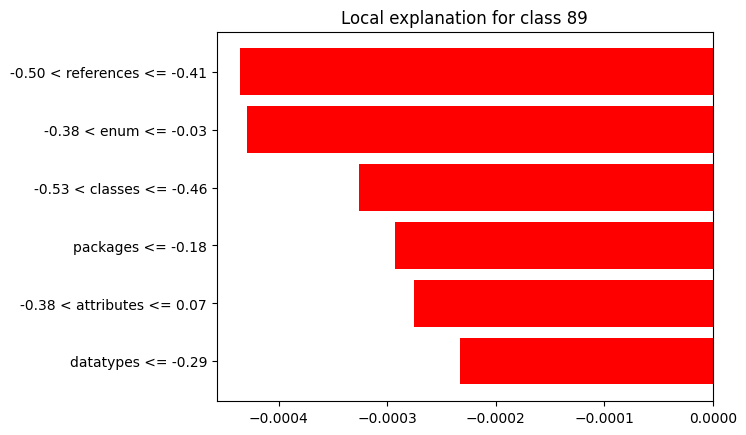

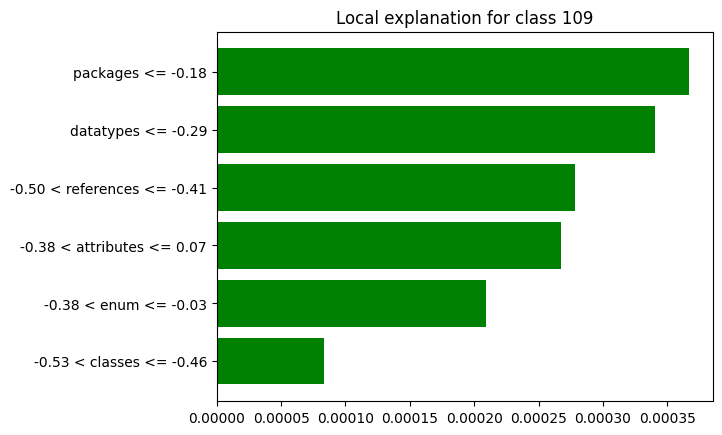

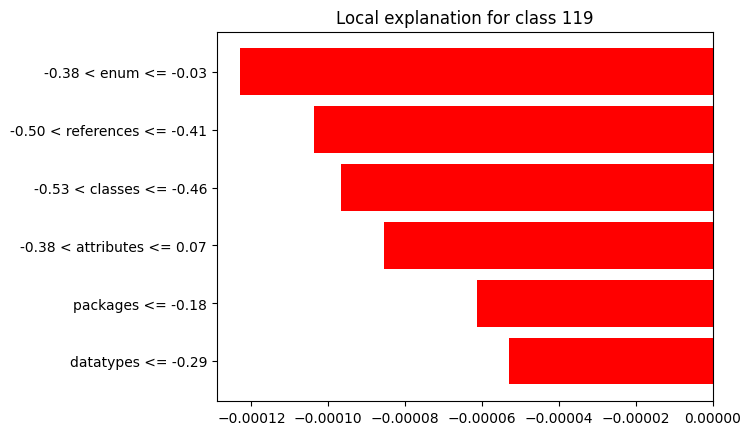

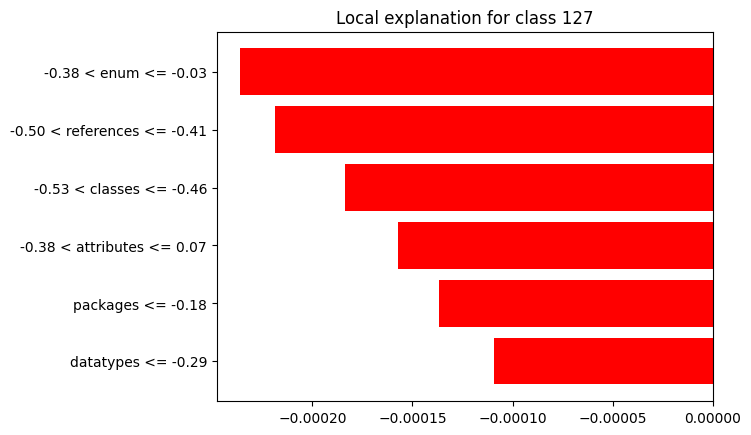

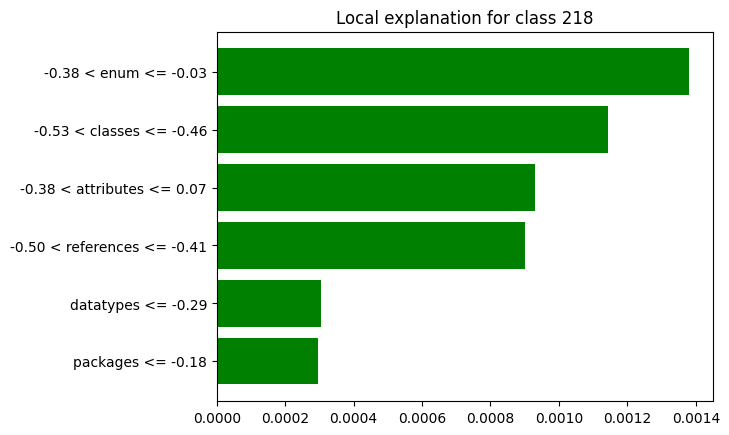

In [ ]:
for i in class_index:
  svc_exp_results['lime_workflow'][i].plot()

In [ ]:
breakdown_df_workflow_gpl, shap_df_workflow_gpl, lime_df_workflow_gpl, df_final_svc_wf_gpl = preprocess_dfs(breakdown_df_workflow_gpl, shap_df_workflow_gpl, lime_df_workflow_gpl, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_workflow_gpl)
print('----------------------------------------------')
print(shap_df_workflow_gpl)
print('----------------------------------------------')
print(lime_df_workflow_gpl)

['classes', 'enum', 'references', 'attributes', 'datatypes', 'packages']
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Negative
1        enum        2  Negative
2  references        3  Negative
3   datatypes        4  Positive
4  attributes        5  Positive
5    packages        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Negative
1  references        2  Negative
2  attributes        3  Negative
3   datatypes        4  Negative
4    packages        5  Negative
5        enum        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0  references        1  Negative
1        enum        2  Negative
2     classes        3  Negative
3    packages        4  Negative
4  attributes        5  Negative
5   datatypes        6  Negative


In [ ]:
df_final_svc_wf_gpl

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
classes            1  Negative       1  Negative       3  Negative
enum               2  Negative       6  Positive       2  Negative
references         3  Negative       2  Negative       1  Negative
datatypes          4  Positive       4  Negative       6  Negative
attributes         5  Positive       3  Negative       5  Negative
packages           6  Negative       5  Negative       4  Negative

In [ ]:
breakdown_df_workflow_lib, shap_df_workflow_lib, lime_df_workflow_lib, df_final_svc_wf_lib = preprocess_dfs(breakdown_df_workflow_lib, shap_df_workflow_lib, lime_df_workflow_lib, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_workflow_lib)
print('----------------------------------------------')
print(shap_df_workflow_lib)
print('----------------------------------------------')
print(lime_df_workflow_lib)

['classes', 'enum', 'references', 'attributes', 'datatypes', 'packages']
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Negative
1  attributes        2  Positive
2  references        3  Negative
3        enum        4  Positive
4   datatypes        5  Positive
5    packages        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Negative
1        enum        2  Positive
2  attributes        3  Negative
3  references        4  Negative
4   datatypes        5  Negative
5    packages        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0    packages        1  Positive
1   datatypes        2  Positive
2  references        3  Positive
3  attributes        4  Positive
4        enum        5  Positive
5     classes        6  Positive


In [ ]:
df_final_svc_wf_lib

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
classes            1  Negative       1  Negative       6  Positive
attributes         2  Positive       3  Negative       4  Positive
references         3  Negative       4  Negative       3  Positive
enum               4  Positive       2  Positive       5  Positive
datatypes          5  Positive       5  Negative       2  Positive
packages           6  Positive       6  Positive       1  Positive

In [ ]:
breakdown_df_workflow_meta, shap_df_workflow_meta, lime_df_workflow_meta, df_final_svc_wf_meta = preprocess_dfs(breakdown_df_workflow_meta, shap_df_workflow_meta, lime_df_workflow_meta, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_workflow_meta)
print('----------------------------------------------')
print(shap_df_workflow_meta)
print('----------------------------------------------')
print(lime_df_workflow_meta)

['classes', 'enum', 'references', 'attributes', 'datatypes', 'packages']
----------------------------------------------
      Feature  Ranking      Sign
0  attributes        1  Negative
1        enum        2  Negative
2   datatypes        3  Negative
3  references        4  Positive
4     classes        5  Negative
5    packages        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0  references        1  Negative
1        enum        2  Negative
2     classes        3  Negative
3   datatypes        4  Negative
4  attributes        5  Negative
5    packages        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0        enum        1  Negative
1  references        2  Negative
2     classes        3  Negative
3  attributes        4  Negative
4    packages        5  Negative
5   datatypes        6  Negative


In [ ]:
df_final_svc_wf_meta

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
attributes         1  Negative       5  Negative       4  Negative
enum               2  Negative       2  Negative       1  Negative
datatypes          3  Negative       4  Negative       6  Negative
references         4  Positive       1  Negative       2  Negative
classes            5  Negative       3  Negative       3  Negative
packages           6  Negative       6  Negative       5  Negative

In [ ]:
breakdown_df_workflow_mod, shap_df_workflow_mod, lime_df_workflow_mod, df_final_svc_wf_mod = preprocess_dfs(breakdown_df_workflow_mod, shap_df_workflow_mod, lime_df_workflow_mod, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_workflow_mod)
print('----------------------------------------------')
print(shap_df_workflow_mod)
print('----------------------------------------------')
print(lime_df_workflow_mod)

['classes', 'packages', 'enum', 'references', 'attributes', 'datatypes']
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Negative
1        enum        2  Negative
2  references        3  Negative
3  attributes        4  Negative
4    packages        5  Negative
5   datatypes        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Negative
1  attributes        2  Negative
2  references        3  Negative
3   datatypes        4  Negative
4        enum        5  Negative
5    packages        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0        enum        1  Negative
1  references        2  Negative
2     classes        3  Negative
3  attributes        4  Negative
4    packages        5  Negative
5   datatypes        6  Negative


In [ ]:
df_final_svc_wf_mod

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
classes            1  Negative       1  Negative       3  Negative
enum               2  Negative       5  Negative       1  Negative
references         3  Negative       3  Negative       2  Negative
attributes         4  Negative       2  Negative       4  Negative
packages           5  Negative       6  Negative       5  Negative
datatypes          6  Positive       4  Negative       6  Negative

In [ ]:
breakdown_df_workflow_wf, shap_df_workflow_wf, lime_df_workflow_wf, df_final_svc_wf_wf = preprocess_dfs(breakdown_df_workflow_wf, shap_df_workflow_wf, lime_df_workflow_wf, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_workflow_wf)
print('----------------------------------------------')
print(shap_df_workflow_wf)
print('----------------------------------------------')
print(lime_df_workflow_wf)

['classes', 'packages', 'enum', 'references', 'attributes', 'datatypes']
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Positive
1   datatypes        2  Positive
2  attributes        3  Positive
3    packages        4  Positive
4  references        5  Positive
5        enum        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0  attributes        1  Positive
1        enum        2  Positive
2     classes        3  Positive
3  references        4  Positive
4   datatypes        5  Positive
5    packages        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0        enum        1  Positive
1     classes        2  Positive
2  attributes        3  Positive
3  references        4  Positive
4   datatypes        5  Positive
5    packages        6  Positive


In [ ]:
df_final_svc_wf_wf

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
classes            1  Positive       3  Positive       2  Positive
datatypes          2  Positive       5  Positive       5  Positive
attributes         3  Positive       1  Positive       3  Positive
packages           4  Positive       6  Positive       6  Positive
references         5  Positive       4  Positive       4  Positive
enum               6  Positive       2  Positive       1  Positive

### **RESULTS WORKFLOW:**

In [ ]:
df_topfeatures_wf_gpl = top3_features(df_final_svc_wf_gpl, 'Workflow - Class: GPL')
df_topfeatures_wf_lib = top3_features(df_final_svc_wf_lib, 'Workflow - Class: Library')
df_topfeatures_wf_meta = top3_features(df_final_svc_wf_meta, 'Workflow - Class: Metamodelling')
df_topfeatures_wf_mod = top3_features(df_final_svc_wf_mod, 'Workflow - Class: Modelling')
df_topfeatures_wf_wf = top3_features(df_final_svc_wf_wf, 'Workflow - Class: Workflow')

df_topfeatures_workflow_svc = pd.concat([df_topfeatures_wf_gpl, df_topfeatures_wf_lib, df_topfeatures_wf_meta, df_topfeatures_wf_mod, df_topfeatures_wf_wf])
df_topfeatures_workflow_svc

TOP3 Breakdown  \
Workflow - Class: GPL                  enum, classes, references   
Workflow - Class: Library        attributes, classes, references   
Workflow - Class: Metamodelling      attributes, enum, datatypes   
Workflow - Class: Modelling            enum, classes, references   
Workflow - Class: Workflow        attributes, datatypes, classes   

                                                       TOP3 Shap  \
Workflow - Class: GPL            attributes, classes, references   
Workflow - Class: Library              attributes, enum, classes   
Workflow - Class: Metamodelling        enum, classes, references   
Workflow - Class: Modelling      attributes, classes, references   
Workflow - Class: Workflow             attributes, enum, classes   

                                                       TOP3 Lime  \
Workflow - Class: GPL                  enum, classes, references   
Workflow - Class: Library        datatypes, packages, references   
Workflow - Class: Metamodelling        enum, classes, references   
Workflow - Class: Modelling            enum, classes, references   
Workflow - Class: Workflow             attributes, enum, classes   

                                 Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Workflow - Class: GPL                  0.666667        1.000000   0.666667  
Workflow - Class: Library              0.666667        0.333333   0.000000  
Workflow - Class: Metamodelling        0.333333        0.333333   1.000000  
Workflow - Class: Modelling            0.666667        1.000000   0.666667  
Workflow - Class: Workflow             0.666667        0.666667   1.000000

In [ ]:
df_topfeatures_wf_gpl_rank = top3_rank(df_final_svc_wf_gpl, 'Workflow - Class GPL')
df_topfeatures_wf_lib_rank = top3_rank(df_final_svc_wf_lib, 'Workflow - Class Library')
df_topfeatures_wf_meta_rank = top3_rank(df_final_svc_wf_meta, 'Workflow - Class Metamodelling')
df_topfeatures_wf_mod_rank = top3_rank(df_final_svc_wf_mod, 'Workflow - Class Modelling')
df_topfeatures_wf_wf_rank = top3_rank(df_final_svc_wf_wf, 'Workflow - Class Workflow')

df_topfeatures_rank_workflow_svc = pd.concat([df_topfeatures_wf_gpl_rank, df_topfeatures_wf_lib_rank, df_topfeatures_wf_meta_rank, df_topfeatures_wf_mod_rank, df_topfeatures_wf_wf_rank])
df_topfeatures_rank_workflow_svc

TOP3 Breakdown  \
Workflow - Class GPL                  1:classes, 2:enum, 3:references   
Workflow - Class Library        1:classes, 2:attributes, 3:references   
Workflow - Class Metamodelling      1:attributes, 2:enum, 3:datatypes   
Workflow - Class Modelling            1:classes, 2:enum, 3:references   
Workflow - Class Workflow        1:classes, 2:datatypes, 3:attributes   

                                                            TOP3 Shap  \
Workflow - Class GPL            1:classes, 2:references, 3:attributes   
Workflow - Class Library              1:classes, 3:attributes, 2:enum   
Workflow - Class Metamodelling        2:enum, 1:references, 3:classes   
Workflow - Class Modelling      1:classes, 3:references, 2:attributes   
Workflow - Class Workflow             3:classes, 1:attributes, 2:enum   

                                                            TOP3 Lime  \
Workflow - Class GPL                  3:classes, 2:enum, 1:references   
Workflow - Class Library        3:references, 2:datatypes, 1:packages   
Workflow - Class Metamodelling        1:enum, 2:references, 3:classes   
Workflow - Class Modelling            3:classes, 1:enum, 2:references   
Workflow - Class Workflow             2:classes, 3:attributes, 1:enum   

                                Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Workflow - Class GPL                  0.333333        0.333333   0.000000  
Workflow - Class Library              0.333333        0.333333   0.000000  
Workflow - Class Metamodelling        0.333333        0.000000   0.333333  
Workflow - Class Modelling            0.666667        0.000000   0.000000  
Workflow - Class Workflow             0.000000        0.333333   0.000000

In [ ]:
df_topfeatures_wf_gpl_sign = top3_sign(df_final_svc_wf_gpl, 'Workflow - Class GPL')
df_topfeatures_wf_lib_sign = top3_sign(df_final_svc_wf_lib, 'Workflow - Class Library')
df_topfeatures_wf_meta_sign = top3_sign(df_final_svc_wf_meta, 'Workflow - Class Metamodelling')
df_topfeatures_wf_mod_sign = top3_sign(df_final_svc_wf_mod, 'Workflow - Class Modelling')
df_topfeatures_wf_wf_sign = top3_sign(df_final_svc_wf_wf, 'Workflow - Class Workflow')

df_topfeatures_sign_workflow_svc = pd.concat([df_topfeatures_wf_gpl_sign, df_topfeatures_wf_lib_sign, df_topfeatures_wf_meta_sign, df_topfeatures_wf_mod_sign, df_topfeatures_wf_wf_sign])
df_topfeatures_sign_workflow_svc

TOP3 Breakdown  \
Workflow - Class GPL            classes:Negative, enum:Negative, references:Ne...   
Workflow - Class Library        classes:Negative, attributes:Positive, referen...   
Workflow - Class Metamodelling  attributes:Negative, enum:Negative, datatypes:...   
Workflow - Class Modelling      classes:Negative, enum:Negative, references:Ne...   
Workflow - Class Workflow       classes:Positive, datatypes:Positive, attribut...   

                                                                        TOP3 Shap  \
Workflow - Class GPL            classes:Negative, references:Negative, attribu...   
Workflow - Class Library        classes:Negative, attributes:Negative, enum:Po...   
Workflow - Class Metamodelling  enum:Negative, references:Negative, classes:Ne...   
Workflow - Class Modelling      classes:Negative, references:Negative, attribu...   
Workflow - Class Workflow       classes:Positive, attributes:Positive, enum:Po...   

                                                                        TOP3 Lime  \
Workflow - Class GPL            classes:Negative, enum:Negative, references:Ne...   
Workflow - Class Library        references:Positive, datatypes:Positive, packa...   
Workflow - Class Metamodelling  enum:Negative, references:Negative, classes:Ne...   
Workflow - Class Modelling      classes:Negative, enum:Negative, references:Ne...   
Workflow - Class Workflow       classes:Positive, attributes:Positive, enum:Po...   

                                Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Workflow - Class GPL                  0.666667        1.000000   0.666667  
Workflow - Class Library              0.333333        0.000000   0.000000  
Workflow - Class Metamodelling        0.333333        0.333333   1.000000  
Workflow - Class Modelling            0.666667        1.000000   0.666667  
Workflow - Class Workflow             0.666667        0.666667   1.000000

In [ ]:
df_topfeatures_wf_gpl_rank_sign = top3_rank_sign(df_final_svc_wf_gpl, 'Workflow - Class GPL')
df_topfeatures_wf_lib_rank_sign = top3_rank_sign(df_final_svc_wf_lib, 'Workflow - Class Library')
df_topfeatures_wf_meta_rank_sign = top3_rank_sign(df_final_svc_wf_meta, 'Workflow - Class Metamodelling')
df_topfeatures_wf_mod_rank_sign = top3_rank_sign(df_final_svc_wf_mod, 'Workflow - Class Modelling')
df_topfeatures_wf_wf_rank_sign = top3_rank_sign(df_final_svc_wf_wf, 'Workflow - Class Workflow')

df_topfeatures_rank_sign_workflow_svc = pd.concat([df_topfeatures_wf_gpl_rank_sign, df_topfeatures_wf_lib_rank_sign, df_topfeatures_wf_meta_rank_sign, df_topfeatures_wf_mod_rank_sign, df_topfeatures_wf_wf_rank_sign])
df_topfeatures_rank_sign_workflow_svc

TOP3 Breakdown  \
Workflow - Class GPL            1:classes:Negative, 2:enum:Negative, 3:referen...   
Workflow - Class Library        1:classes:Negative, 2:attributes:Positive, 3:r...   
Workflow - Class Metamodelling  1:attributes:Negative, 2:enum:Negative, 3:data...   
Workflow - Class Modelling      1:classes:Negative, 2:enum:Negative, 3:referen...   
Workflow - Class Workflow       1:classes:Positive, 2:datatypes:Positive, 3:at...   

                                                                        TOP3 Shap  \
Workflow - Class GPL            1:classes:Negative, 2:references:Negative, 3:a...   
Workflow - Class Library        1:classes:Negative, 3:attributes:Negative, 2:e...   
Workflow - Class Metamodelling  2:enum:Negative, 1:references:Negative, 3:clas...   
Workflow - Class Modelling      1:classes:Negative, 3:references:Negative, 2:a...   
Workflow - Class Workflow       3:classes:Positive, 1:attributes:Positive, 2:e...   

                                                                        TOP3 Lime  \
Workflow - Class GPL            3:classes:Negative, 2:enum:Negative, 1:referen...   
Workflow - Class Library        3:references:Positive, 2:datatypes:Positive, 1...   
Workflow - Class Metamodelling  1:enum:Negative, 2:references:Negative, 3:clas...   
Workflow - Class Modelling      3:classes:Negative, 1:enum:Negative, 2:referen...   
Workflow - Class Workflow       2:classes:Positive, 3:attributes:Positive, 1:e...   

                                Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Workflow - Class GPL                  0.333333        0.333333   0.000000  
Workflow - Class Library              0.333333        0.000000   0.000000  
Workflow - Class Metamodelling        0.333333        0.000000   0.333333  
Workflow - Class Modelling            0.666667        0.000000   0.000000  
Workflow - Class Workflow             0.000000        0.333333   0.000000

### **GPL:**

In [ ]:
breakdown_df_gpl_gpl = svc_exp_results['breakdown_gpl'][1].result
shap_df_gpl_gpl = svc_exp_results['shap_gpl'][1].result
lime_df_gpl_gpl = svc_exp_results['lime_gpl'][1].result

In [ ]:
breakdown_df_gpl_lib = svc_exp_results['breakdown_gpl'][2].result
shap_df_gpl_lib = svc_exp_results['shap_gpl'][2].result
lime_df_gpl_lib = svc_exp_results['lime_gpl'][2].result

In [ ]:
breakdown_df_gpl_meta = svc_exp_results['breakdown_gpl'][3].result
shap_df_gpl_meta = svc_exp_results['shap_gpl'][3].result
lime_df_gpl_meta = svc_exp_results['lime_gpl'][3].result

In [ ]:
breakdown_df_gpl_mod = svc_exp_results['breakdown_gpl'][4].result
shap_df_gpl_mod = svc_exp_results['shap_gpl'][4].result
lime_df_gpl_mod = svc_exp_results['lime_gpl'][4].result

In [ ]:
breakdown_df_gpl_wf = svc_exp_results['breakdown_gpl'][9].result
shap_df_gpl_wf = svc_exp_results['shap_gpl'][9].result
lime_df_gpl_wf = svc_exp_results['lime_gpl'][9].result

In [ ]:
exp_plots_bd = [svc_exp_results['breakdown_gpl'][i] for i in class_index]
exp_plots_bd[0].plot(exp_plots_bd[1:])

In [ ]:
exp_plots_shap = [svc_exp_results['shap_gpl'][i] for i in class_index]
exp_plots_shap[0].plot(exp_plots_shap[1:])

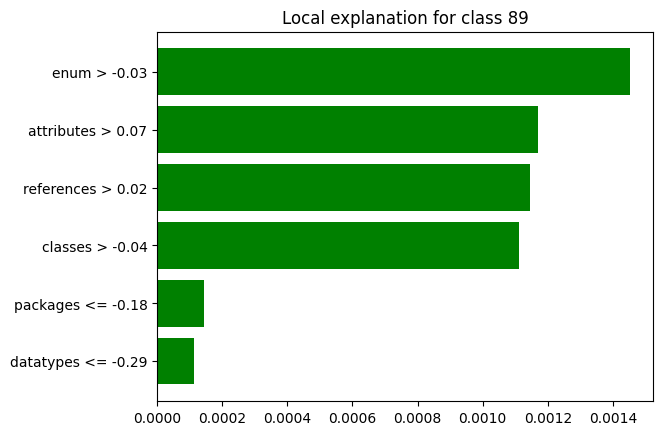

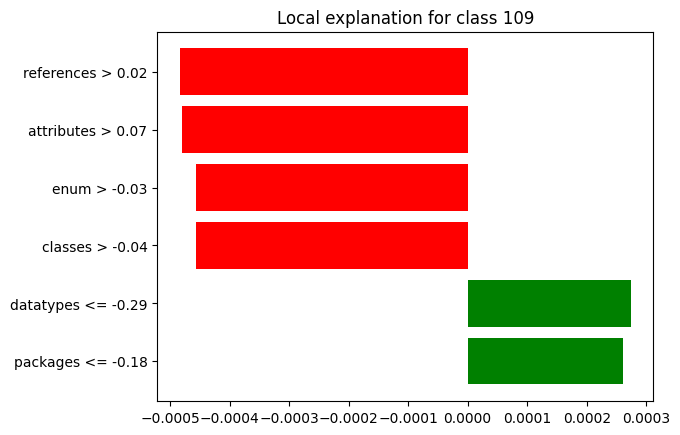

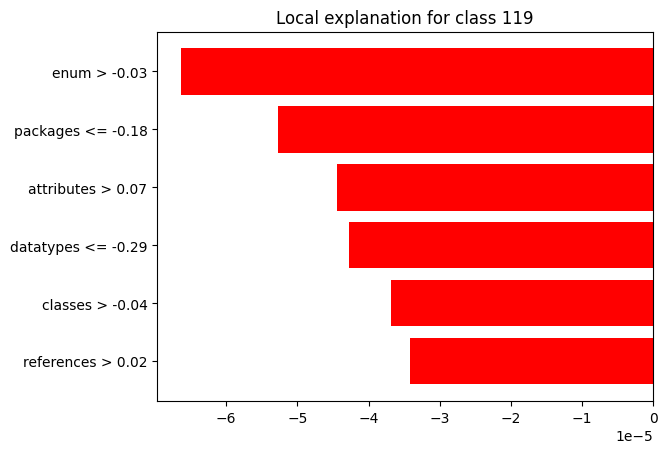

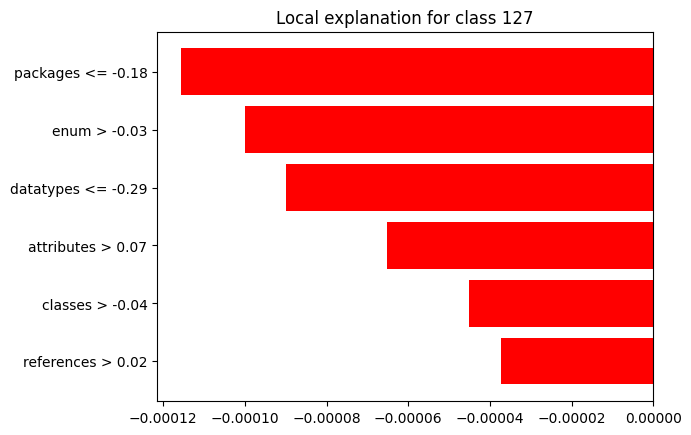

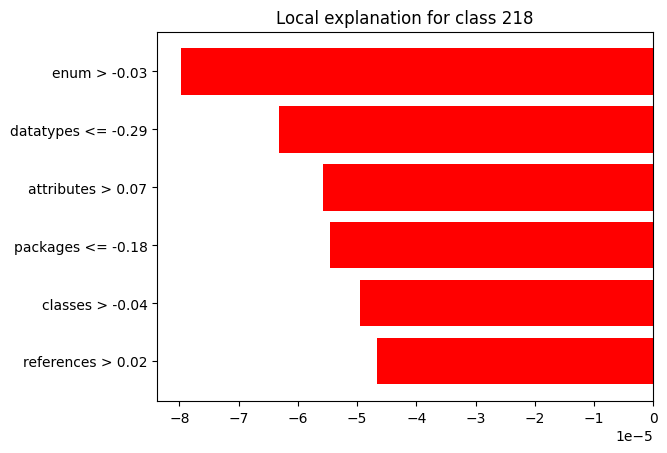

In [ ]:
for i in class_index:
  svc_exp_results['lime_gpl'][i].plot()

In [ ]:
breakdown_df_gpl_gpl, shap_df_gpl_gpl, lime_df_gpl_gpl, df_final_svc_gpl_gpl = preprocess_dfs(breakdown_df_gpl_gpl, shap_df_gpl_gpl, lime_df_gpl_gpl, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_gpl_gpl)
print('----------------------------------------------')
print(shap_df_gpl_gpl)
print('----------------------------------------------')
print(lime_df_gpl_gpl)

['classes', 'packages', 'enum', 'references', 'attributes', 'datatypes']
----------------------------------------------
      Feature  Ranking      Sign
0        enum        1  Positive
1     classes        2  Positive
2   datatypes        3  Positive
3    packages        4  Positive
4  references        5  Positive
5  attributes        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Positive
1  attributes        2  Positive
2        enum        3  Positive
3  references        4  Positive
4   datatypes        5  Positive
5    packages        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0        enum        1  Positive
1  attributes        2  Positive
2  references        3  Positive
3     classes        4  Positive
4    packages        5  Positive
5   datatypes        6  Positive


In [ ]:
df_final_svc_gpl_gpl

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
enum               1  Positive       3  Positive       1  Positive
classes            2  Positive       1  Positive       4  Positive
datatypes          3  Positive       5  Positive       6  Positive
packages           4  Positive       6  Positive       5  Positive
references         5  Positive       4  Positive       3  Positive
attributes         6  Negative       2  Positive       2  Positive

In [ ]:
breakdown_df_gpl_lib, shap_df_gpl_lib, lime_df_gpl_lib, df_final_svc_gpl_lib = preprocess_dfs(breakdown_df_gpl_lib, shap_df_gpl_lib, lime_df_gpl_lib, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_gpl_lib)
print('----------------------------------------------')
print(shap_df_gpl_lib)
print('----------------------------------------------')
print(lime_df_gpl_lib)

['classes', 'packages', 'enum', 'references', 'attributes', 'datatypes']
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Negative
1  attributes        2  Negative
2   datatypes        3  Positive
3    packages        4  Negative
4        enum        5  Negative
5  references        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0  references        1  Negative
1  attributes        2  Negative
2     classes        3  Negative
3        enum        4  Negative
4    packages        5  Negative
5   datatypes        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0  references        1  Negative
1  attributes        2  Negative
2        enum        3  Negative
3     classes        4  Negative
4   datatypes        5  Positive
5    packages        6  Positive


In [ ]:
df_final_svc_gpl_lib

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
classes            1  Negative       3  Negative       4  Negative
attributes         2  Negative       2  Negative       2  Negative
datatypes          3  Positive       6  Negative       5  Positive
packages           4  Negative       5  Negative       6  Positive
enum               5  Negative       4  Negative       3  Negative
references         6  Negative       1  Negative       1  Negative

In [ ]:
breakdown_df_gpl_meta, shap_df_gpl_meta, lime_df_gpl_meta, df_final_svc_gpl_meta = preprocess_dfs(breakdown_df_gpl_meta, shap_df_gpl_meta, lime_df_gpl_meta, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_gpl_meta)
print('----------------------------------------------')
print(shap_df_gpl_meta)
print('----------------------------------------------')
print(lime_df_gpl_meta)

['classes', 'enum', 'references', 'attributes', 'datatypes', 'packages']
----------------------------------------------
      Feature  Ranking      Sign
0        enum        1  Negative
1  references        2  Negative
2   datatypes        3  Negative
3     classes        4  Negative
4  attributes        5  Negative
5    packages        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0  references        1  Negative
1        enum        2  Negative
2     classes        3  Negative
3  attributes        4  Negative
4   datatypes        5  Negative
5    packages        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0        enum        1  Negative
1    packages        2  Negative
2  attributes        3  Negative
3   datatypes        4  Negative
4     classes        5  Negative
5  references        6  Negative


In [ ]:
df_final_svc_gpl_meta

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
enum               1  Negative       2  Negative       1  Negative
references         2  Negative       1  Negative       6  Negative
datatypes          3  Negative       5  Negative       4  Negative
classes            4  Negative       3  Negative       5  Negative
attributes         5  Negative       4  Negative       3  Negative
packages           6  Negative       6  Negative       2  Negative

In [ ]:
breakdown_df_gpl_mod, shap_df_gpl_mod, lime_df_gpl_mod, df_final_svc_gpl_mod = preprocess_dfs(breakdown_df_gpl_mod, shap_df_gpl_mod, lime_df_gpl_mod, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_gpl_mod)
print('----------------------------------------------')
print(shap_df_gpl_mod)
print('----------------------------------------------')
print(lime_df_gpl_mod)

['classes', 'packages', 'enum', 'references', 'attributes', 'datatypes']
----------------------------------------------
      Feature  Ranking      Sign
0        enum        1  Negative
1    packages        2  Negative
2  references        3  Negative
3   datatypes        4  Positive
4  attributes        5  Negative
5     classes        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0  attributes        1  Negative
1     classes        2  Negative
2        enum        3  Negative
3  references        4  Negative
4   datatypes        5  Negative
5    packages        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0    packages        1  Negative
1        enum        2  Negative
2   datatypes        3  Negative
3  attributes        4  Negative
4     classes        5  Negative
5  references        6  Negative


In [ ]:
df_final_svc_gpl_mod

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
enum               1  Negative       3  Negative       2  Negative
packages           2  Negative       6  Negative       1  Negative
references         3  Negative       4  Negative       6  Negative
datatypes          4  Positive       5  Negative       3  Negative
attributes         5  Negative       1  Negative       4  Negative
classes            6  Negative       2  Negative       5  Negative

In [ ]:
breakdown_df_gpl_wf, shap_df_gpl_wf, lime_df_gpl_wf, df_final_svc_gpl_wf = preprocess_dfs(breakdown_df_gpl_wf, shap_df_gpl_wf, lime_df_gpl_wf, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_gpl_wf)
print('----------------------------------------------')
print(shap_df_gpl_wf)
print('----------------------------------------------')
print(lime_df_gpl_wf)

['classes', 'enum', 'references', 'attributes', 'datatypes', 'packages']
----------------------------------------------
      Feature  Ranking      Sign
0  references        1  Negative
1   datatypes        2  Negative
2        enum        3  Positive
3    packages        4  Negative
4     classes        5  Negative
5  attributes        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Negative
1  attributes        2  Negative
2        enum        3  Negative
3  references        4  Negative
4   datatypes        5  Negative
5    packages        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0        enum        1  Negative
1   datatypes        2  Negative
2  attributes        3  Negative
3    packages        4  Negative
4     classes        5  Negative
5  references        6  Negative


In [ ]:
df_final_svc_gpl_wf

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
references         1  Negative       4  Negative       6  Negative
datatypes          2  Negative       5  Negative       2  Negative
enum               3  Positive       3  Negative       1  Negative
packages           4  Negative       6  Negative       4  Negative
classes            5  Negative       1  Negative       5  Negative
attributes         6  Negative       2  Negative       3  Negative

### **RESULTS GPL:**



In [ ]:
df_topfeatures_gpl_gpl = top3_features(df_final_svc_gpl_gpl, 'GPL - Class: GPL')
df_topfeatures_gpl_lib = top3_features(df_final_svc_gpl_lib, 'GPL - Class: Library')
df_topfeatures_gpl_meta = top3_features(df_final_svc_gpl_meta, 'GPL - Class: Metamodelling')
df_topfeatures_gpl_mod = top3_features(df_final_svc_gpl_mod, 'GPL - Class: Modelling')
df_topfeatures_gpl_wf = top3_features(df_final_svc_gpl_wf, 'GPL - Class: Workflow')

df_topfeatures_gpl_svc = pd.concat([df_topfeatures_gpl_gpl, df_topfeatures_gpl_lib, df_topfeatures_gpl_meta, df_topfeatures_gpl_mod, df_topfeatures_gpl_wf])
df_topfeatures_gpl_svc

TOP3 Breakdown  \
GPL - Class: GPL                  datatypes, enum, classes   
GPL - Class: Library        attributes, datatypes, classes   
GPL - Class: Metamodelling     datatypes, enum, references   
GPL - Class: Modelling          enum, packages, references   
GPL - Class: Workflow          enum, datatypes, references   

                                                  TOP3 Shap  \
GPL - Class: GPL                  attributes, enum, classes   
GPL - Class: Library        attributes, classes, references   
GPL - Class: Metamodelling        enum, classes, references   
GPL - Class: Modelling            attributes, enum, classes   
GPL - Class: Workflow             attributes, enum, classes   

                                               TOP3 Lime  Breakdown-Shap  \
GPL - Class: GPL            attributes, enum, references        0.666667   
GPL - Class: Library        attributes, enum, references        0.666667   
GPL - Class: Metamodelling    attributes, enum, packages        0.666667   
GPL - Class: Modelling         datatypes, enum, packages        0.333333   
GPL - Class: Workflow        attributes, enum, datatypes        0.333333   

                            Breakdown-Lime  Lime-Shap  
GPL - Class: GPL                  0.333333   0.666667  
GPL - Class: Library              0.333333   0.666667  
GPL - Class: Metamodelling        0.333333   0.333333  
GPL - Class: Modelling            0.666667   0.333333  
GPL - Class: Workflow             0.666667   0.666667

In [ ]:
df_topfeatures_gpl_gpl_rank = top3_rank(df_final_svc_gpl_gpl, 'GPL - Class GPL')
df_topfeatures_gpl_lib_rank = top3_rank(df_final_svc_gpl_lib, 'GPL - Class Library')
df_topfeatures_gpl_meta_rank = top3_rank(df_final_svc_gpl_meta, 'GPL - Class Metamodelling')
df_topfeatures_gpl_mod_rank = top3_rank(df_final_svc_gpl_mod, 'GPL - Class Modelling')
df_topfeatures_gpl_wf_rank = top3_rank(df_final_svc_gpl_wf, 'GPL - Class Workflow')

df_topfeatures_rank_gpl_svc = pd.concat([df_topfeatures_gpl_gpl_rank, df_topfeatures_gpl_lib_rank, df_topfeatures_gpl_meta_rank, df_topfeatures_gpl_mod_rank, df_topfeatures_gpl_wf_rank])
df_topfeatures_rank_gpl_svc

TOP3 Breakdown  \
GPL - Class GPL                  1:enum, 2:classes, 3:datatypes   
GPL - Class Library        1:classes, 2:attributes, 3:datatypes   
GPL - Class Metamodelling     1:enum, 2:references, 3:datatypes   
GPL - Class Modelling          1:enum, 2:packages, 3:references   
GPL - Class Workflow          1:references, 2:datatypes, 3:enum   

                                                       TOP3 Shap  \
GPL - Class GPL                  3:enum, 1:classes, 2:attributes   
GPL - Class Library        3:classes, 2:attributes, 1:references   
GPL - Class Metamodelling        2:enum, 1:references, 3:classes   
GPL - Class Modelling            3:enum, 1:attributes, 2:classes   
GPL - Class Workflow             3:enum, 1:classes, 2:attributes   

                                                    TOP3 Lime  Breakdown-Shap  \
GPL - Class GPL            1:enum, 3:references, 2:attributes        0.000000   
GPL - Class Library        2:attributes, 3:enum, 1:references        0.333333   
GPL - Class Metamodelling    1:enum, 3:attributes, 2:packages        0.000000   
GPL - Class Modelling         2:enum, 1:packages, 3:datatypes        0.000000   
GPL - Class Workflow        2:datatypes, 1:enum, 3:attributes        0.333333   

                           Breakdown-Lime  Lime-Shap  
GPL - Class GPL                  0.333333   0.333333  
GPL - Class Library              0.333333   0.666667  
GPL - Class Metamodelling        0.333333   0.000000  
GPL - Class Modelling            0.000000   0.000000  
GPL - Class Workflow             0.333333   0.000000

In [ ]:
df_topfeatures_gpl_gpl_sign = top3_sign(df_final_svc_gpl_gpl, 'GPL - Class GPL')
df_topfeatures_gpl_lib_sign = top3_sign(df_final_svc_gpl_lib, 'GPL - Class Library')
df_topfeatures_gpl_meta_sign = top3_sign(df_final_svc_gpl_meta, 'GPL - Class Metamodelling')
df_topfeatures_gpl_mod_sign = top3_sign(df_final_svc_gpl_mod, 'GPL - Class Modelling')
df_topfeatures_gpl_wf_sign = top3_sign(df_final_svc_gpl_wf, 'GPL - Class Workflow')

df_topfeatures_sign_gpl_svc = pd.concat([df_topfeatures_gpl_gpl_sign, df_topfeatures_gpl_lib_sign, df_topfeatures_gpl_meta_sign, df_topfeatures_gpl_mod_sign, df_topfeatures_gpl_wf_sign])
df_topfeatures_sign_gpl_svc

TOP3 Breakdown  \
GPL - Class GPL            enum:Positive, classes:Positive, datatypes:Pos...   
GPL - Class Library        classes:Negative, attributes:Negative, datatyp...   
GPL - Class Metamodelling  enum:Negative, references:Negative, datatypes:...   
GPL - Class Modelling      enum:Negative, packages:Negative, references:N...   
GPL - Class Workflow       references:Negative, datatypes:Negative, enum:...   

                                                                   TOP3 Shap  \
GPL - Class GPL            enum:Positive, classes:Positive, attributes:Po...   
GPL - Class Library        classes:Negative, attributes:Negative, referen...   
GPL - Class Metamodelling  enum:Negative, references:Negative, classes:Ne...   
GPL - Class Modelling      enum:Negative, attributes:Negative, classes:Ne...   
GPL - Class Workflow       enum:Negative, classes:Negative, attributes:Ne...   

                                                                   TOP3 Lime  \
GPL - Class GPL            enum:Positive, references:Positive, attributes...   
GPL - Class Library        attributes:Negative, enum:Negative, references...   
GPL - Class Metamodelling  enum:Negative, attributes:Negative, packages:N...   
GPL - Class Modelling      enum:Negative, packages:Negative, datatypes:Ne...   
GPL - Class Workflow       datatypes:Negative, enum:Negative, attributes:...   

                           Breakdown-Shap  Breakdown-Lime  Lime-Shap  
GPL - Class GPL                  0.666667        0.333333   0.666667  
GPL - Class Library              0.666667        0.333333   0.666667  
GPL - Class Metamodelling        0.666667        0.333333   0.333333  
GPL - Class Modelling            0.333333        0.666667   0.333333  
GPL - Class Workflow             0.000000        0.333333   0.666667

In [ ]:
df_topfeatures_gpl_gpl_rank_sign = top3_rank_sign(df_final_svc_gpl_gpl, 'GPL - Class GPL')
df_topfeatures_gpl_lib_rank_sign = top3_rank_sign(df_final_svc_gpl_lib, 'GPL - Class Library')
df_topfeatures_gpl_meta_rank_sign = top3_rank_sign(df_final_svc_gpl_meta, 'GPL - Class Metamodelling')
df_topfeatures_gpl_mod_rank_sign = top3_rank_sign(df_final_svc_gpl_mod, 'GPL - Class Modelling')
df_topfeatures_gpl_wf_rank_sign = top3_rank_sign(df_final_svc_gpl_wf, 'GPL - Class Workflow')

df_topfeatures_rank_sign_gpl_svc = pd.concat([df_topfeatures_gpl_gpl_rank_sign, df_topfeatures_gpl_lib_rank_sign, df_topfeatures_gpl_meta_rank_sign, df_topfeatures_gpl_mod_rank_sign, df_topfeatures_gpl_wf_rank_sign])
df_topfeatures_rank_sign_gpl_svc

TOP3 Breakdown  \
GPL - Class GPL            1:enum:Positive, 2:classes:Positive, 3:datatyp...   
GPL - Class Library        1:classes:Negative, 2:attributes:Negative, 3:d...   
GPL - Class Metamodelling  1:enum:Negative, 2:references:Negative, 3:data...   
GPL - Class Modelling      1:enum:Negative, 2:packages:Negative, 3:refere...   
GPL - Class Workflow       1:references:Negative, 2:datatypes:Negative, 3...   

                                                                   TOP3 Shap  \
GPL - Class GPL            3:enum:Positive, 1:classes:Positive, 2:attribu...   
GPL - Class Library        3:classes:Negative, 2:attributes:Negative, 1:r...   
GPL - Class Metamodelling  2:enum:Negative, 1:references:Negative, 3:clas...   
GPL - Class Modelling      3:enum:Negative, 1:attributes:Negative, 2:clas...   
GPL - Class Workflow       3:enum:Negative, 1:classes:Negative, 2:attribu...   

                                                                   TOP3 Lime  \
GPL - Class GPL            1:enum:Positive, 3:references:Positive, 2:attr...   
GPL - Class Library        2:attributes:Negative, 3:enum:Negative, 1:refe...   
GPL - Class Metamodelling  1:enum:Negative, 3:attributes:Negative, 2:pack...   
GPL - Class Modelling      2:enum:Negative, 1:packages:Negative, 3:dataty...   
GPL - Class Workflow       2:datatypes:Negative, 1:enum:Negative, 3:attri...   

                           Breakdown-Shap  Breakdown-Lime  Lime-Shap  
GPL - Class GPL                  0.000000        0.333333   0.333333  
GPL - Class Library              0.333333        0.333333   0.666667  
GPL - Class Metamodelling        0.000000        0.333333   0.000000  
GPL - Class Modelling            0.000000        0.000000   0.000000  
GPL - Class Workflow             0.000000        0.333333   0.000000

### **LIBRARY:**

In [ ]:
breakdown_df_library_gpl = svc_exp_results['breakdown_library'][1].result
shap_df_library_gpl = svc_exp_results['shap_library'][1].result
lime_df_library_gpl = svc_exp_results['lime_library'][1].result

In [ ]:
breakdown_df_library_lib = svc_exp_results['breakdown_library'][2].result
shap_df_library_lib = svc_exp_results['shap_library'][2].result
lime_df_library_lib = svc_exp_results['lime_library'][2].result

In [ ]:
breakdown_df_library_meta = svc_exp_results['breakdown_library'][3].result
shap_df_library_meta = svc_exp_results['shap_library'][3].result
lime_df_library_meta = svc_exp_results['lime_library'][3].result

In [ ]:
breakdown_df_library_mod = svc_exp_results['breakdown_library'][4].result
shap_df_library_mod = svc_exp_results['shap_library'][4].result
lime_df_library_mod = svc_exp_results['lime_library'][4].result

In [ ]:
breakdown_df_library_wf = svc_exp_results['breakdown_library'][9].result
shap_df_library_wf = svc_exp_results['shap_library'][9].result
lime_df_library_wf = svc_exp_results['lime_library'][9].result

In [ ]:
exp_plots_bd = [svc_exp_results['breakdown_library'][i] for i in class_index]
exp_plots_bd[0].plot(exp_plots_bd[1:])

In [ ]:
exp_plots_shap = [svc_exp_results['shap_library'][i] for i in class_index]
exp_plots_shap[0].plot(exp_plots_shap[1:])

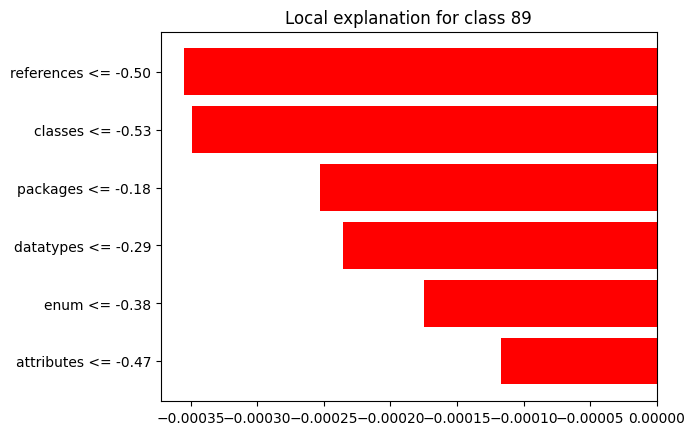

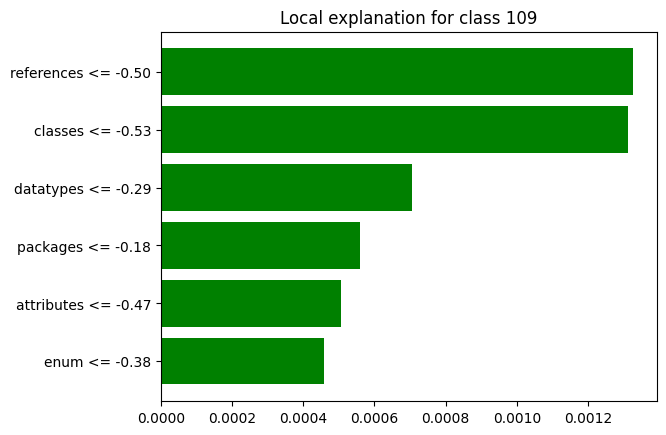

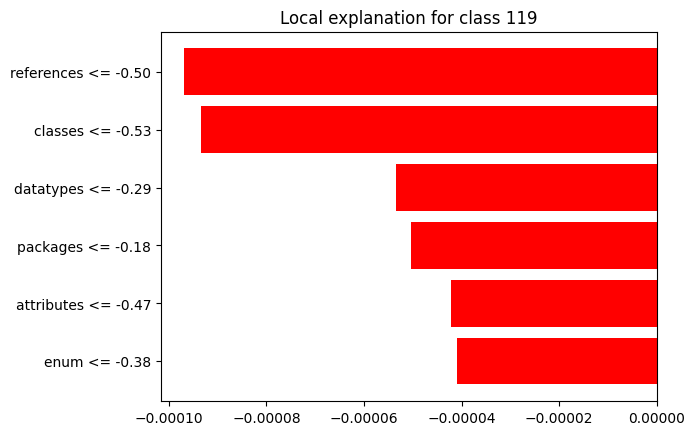

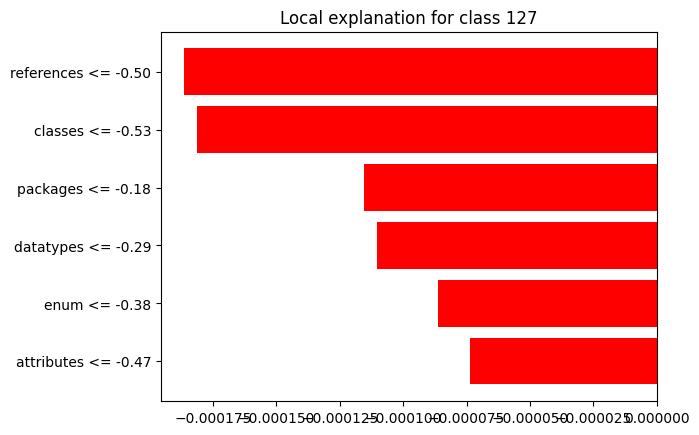

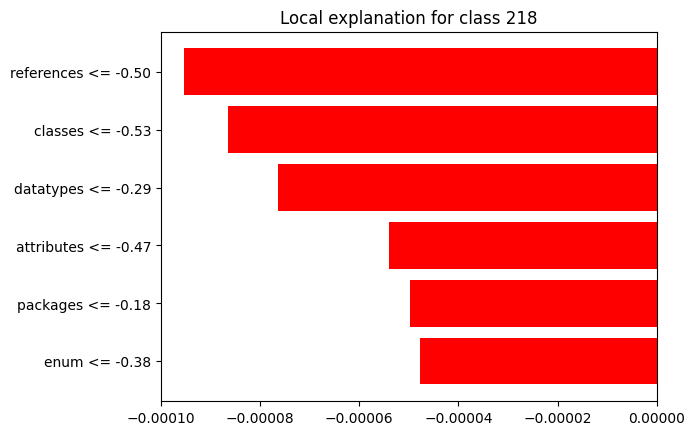

In [ ]:
for i in class_index:
  svc_exp_results['lime_library'][i].plot()

In [ ]:
breakdown_df_library_gpl, shap_df_library_gpl, lime_df_library_gpl, df_final_svc_lib_gpl = preprocess_dfs(breakdown_df_library_gpl, shap_df_library_gpl, lime_df_library_gpl, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_library_gpl)
print('----------------------------------------------')
print(shap_df_library_gpl)
print('----------------------------------------------')
print(lime_df_library_gpl)

['classes', 'enum', 'references', 'attributes', 'datatypes', 'packages']
----------------------------------------------
      Feature  Ranking      Sign
0        enum        1  Negative
1  attributes        2  Negative
2     classes        3  Negative
3  references        4  Negative
4   datatypes        5  Positive
5    packages        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0  references        1  Negative
1  attributes        2  Negative
2        enum        3  Negative
3     classes        4  Negative
4   datatypes        5  Negative
5    packages        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0  references        1  Negative
1     classes        2  Negative
2    packages        3  Negative
3   datatypes        4  Negative
4        enum        5  Negative
5  attributes        6  Negative


In [ ]:
df_final_svc_lib_gpl

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
enum               1  Negative       3  Negative       5  Negative
attributes         2  Negative       2  Negative       6  Negative
classes            3  Negative       4  Negative       2  Negative
references         4  Negative       1  Negative       1  Negative
datatypes          5  Positive       5  Negative       4  Negative
packages           6  Negative       6  Negative       3  Negative

In [ ]:
breakdown_df_library_lib, shap_df_library_lib, lime_df_library_lib, df_final_svc_lib_lib = preprocess_dfs(breakdown_df_library_lib, shap_df_library_lib, lime_df_library_lib, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_library_lib)
print('----------------------------------------------')
print(shap_df_library_lib)
print('----------------------------------------------')
print(lime_df_library_lib)

['classes', 'packages', 'enum', 'references', 'attributes', 'datatypes']
----------------------------------------------
      Feature  Ranking      Sign
0  attributes        1  Positive
1  references        2  Positive
2     classes        3  Positive
3    packages        4  Positive
4        enum        5  Negative
5   datatypes        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Positive
1  attributes        2  Positive
2  references        3  Positive
3   datatypes        4  Positive
4        enum        5  Positive
5    packages        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0  references        1  Positive
1     classes        2  Positive
2   datatypes        3  Positive
3    packages        4  Positive
4  attributes        5  Positive
5        enum        6  Positive


In [ ]:
df_final_svc_lib_lib

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
attributes         1  Positive       2  Positive       5  Positive
references         2  Positive       3  Positive       1  Positive
classes            3  Positive       1  Positive       2  Positive
packages           4  Positive       6  Positive       4  Positive
enum               5  Negative       5  Positive       6  Positive
datatypes          6  Positive       4  Positive       3  Positive

In [ ]:
breakdown_df_library_meta, shap_df_library_meta, lime_df_library_meta, df_final_svc_lib_meta = preprocess_dfs(breakdown_df_library_meta, shap_df_library_meta, lime_df_library_meta, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_library_meta)
print('----------------------------------------------')
print(shap_df_library_meta)
print('----------------------------------------------')
print(lime_df_library_meta)

['classes', 'packages', 'enum', 'references', 'attributes', 'datatypes']
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Negative
1   datatypes        2  Negative
2  references        3  Negative
3        enum        4  Positive
4    packages        5  Negative
5  attributes        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0   datatypes        1  Negative
1  references        2  Negative
2  attributes        3  Negative
3     classes        4  Negative
4        enum        5  Negative
5    packages        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0  references        1  Negative
1     classes        2  Negative
2   datatypes        3  Negative
3    packages        4  Negative
4  attributes        5  Negative
5        enum        6  Negative


In [ ]:
df_final_svc_lib_meta

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
classes            1  Negative       4  Negative       2  Negative
datatypes          2  Negative       1  Negative       3  Negative
references         3  Negative       2  Negative       1  Negative
enum               4  Positive       5  Negative       6  Negative
packages           5  Negative       6  Negative       4  Negative
attributes         6  Negative       3  Negative       5  Negative

In [ ]:
breakdown_df_library_mod, shap_df_library_mod, lime_df_library_mod, df_final_svc_lib_mod = preprocess_dfs(breakdown_df_library_mod, shap_df_library_mod, lime_df_library_mod, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_library_mod)
print('----------------------------------------------')
print(shap_df_library_mod)
print('----------------------------------------------')
print(lime_df_library_mod)

['classes', 'enum', 'references', 'attributes', 'datatypes', 'packages']
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Negative
1        enum        2  Positive
2  references        3  Positive
3   datatypes        4  Positive
4  attributes        5  Positive
5    packages        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Negative
1  references        2  Positive
2  attributes        3  Positive
3   datatypes        4  Positive
4    packages        5  Negative
5        enum        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0  references        1  Negative
1     classes        2  Negative
2    packages        3  Negative
3   datatypes        4  Negative
4        enum        5  Negative
5  attributes        6  Negative


In [ ]:
df_final_svc_lib_mod

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
classes            1  Negative       1  Negative       2  Negative
enum               2  Positive       6  Positive       5  Negative
references         3  Positive       2  Positive       1  Negative
datatypes          4  Positive       4  Positive       4  Negative
attributes         5  Positive       3  Positive       6  Negative
packages           6  Positive       5  Negative       3  Negative

In [ ]:
breakdown_df_library_wf, shap_df_library_wf, lime_df_library_wf, df_final_svc_lib_wf = preprocess_dfs(breakdown_df_library_wf, shap_df_library_wf, lime_df_library_wf, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_library_wf)
print('----------------------------------------------')
print(shap_df_library_wf)
print('----------------------------------------------')
print(lime_df_library_wf)

['classes', 'packages', 'enum', 'references', 'attributes', 'datatypes']
----------------------------------------------
      Feature  Ranking      Sign
0  attributes        1  Negative
1  references        2  Negative
2        enum        3  Negative
3     classes        4  Negative
4    packages        5  Negative
5   datatypes        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0  references        1  Negative
1  attributes        2  Negative
2     classes        3  Negative
3        enum        4  Negative
4   datatypes        5  Negative
5    packages        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0  references        1  Negative
1     classes        2  Negative
2   datatypes        3  Negative
3  attributes        4  Negative
4    packages        5  Negative
5        enum        6  Negative


In [ ]:
df_final_svc_lib_wf

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
attributes         1  Negative       2  Negative       4  Negative
references         2  Negative       1  Negative       1  Negative
enum               3  Negative       4  Negative       6  Negative
classes            4  Negative       3  Negative       2  Negative
packages           5  Negative       6  Negative       5  Negative
datatypes          6  Positive       5  Negative       3  Negative

### **RESULTS LIBRARY:**

In [ ]:
df_topfeatures_lib_gpl = top3_features(df_final_svc_lib_gpl, 'Library - Class: GPL')
df_topfeatures_lib_lib = top3_features(df_final_svc_lib_lib, 'Library - Class: Library')
df_topfeatures_lib_meta = top3_features(df_final_svc_lib_meta, 'Library - Class: Metamodelling')
df_topfeatures_lib_mod = top3_features(df_final_svc_lib_mod, 'Library - Class: Modelling')
df_topfeatures_lib_wf = top3_features(df_final_svc_lib_wf, 'Library - Class: Workflow')

df_topfeatures_library_svc = pd.concat([df_topfeatures_lib_gpl, df_topfeatures_lib_lib, df_topfeatures_lib_meta, df_topfeatures_lib_mod, df_topfeatures_lib_wf])
df_topfeatures_library_svc

TOP3 Breakdown  \
Library - Class: GPL                  attributes, enum, classes   
Library - Class: Library        attributes, classes, references   
Library - Class: Metamodelling   datatypes, classes, references   
Library - Class: Modelling            enum, classes, references   
Library - Class: Workflow          attributes, enum, references   

                                                        TOP3 Shap  \
Library - Class: GPL                 attributes, enum, references   
Library - Class: Library          attributes, classes, references   
Library - Class: Metamodelling  attributes, datatypes, references   
Library - Class: Modelling        attributes, classes, references   
Library - Class: Workflow         attributes, classes, references   

                                                     TOP3 Lime  \
Library - Class: GPL             packages, classes, references   
Library - Class: Library        datatypes, classes, references   
Library - Class: Metamodelling  datatypes, classes, references   
Library - Class: Modelling       packages, classes, references   
Library - Class: Workflow       datatypes, classes, references   

                                Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Library - Class: GPL                  0.666667        0.333333   0.333333  
Library - Class: Library              1.000000        0.666667   0.666667  
Library - Class: Metamodelling        0.666667        1.000000   0.666667  
Library - Class: Modelling            0.666667        0.666667   0.666667  
Library - Class: Workflow             0.666667        0.333333   0.666667

In [ ]:
df_topfeatures_lib_gpl_rank = top3_rank(df_final_svc_lib_gpl, 'Library - Class GPL')
df_topfeatures_lib_lib_rank = top3_rank(df_final_svc_lib_lib, 'Library - Class Library')
df_topfeatures_lib_meta_rank = top3_rank(df_final_svc_lib_meta, 'Library - Class Metamodelling')
df_topfeatures_lib_mod_rank = top3_rank(df_final_svc_lib_mod, 'Library - Class Modelling')
df_topfeatures_lib_wf_rank = top3_rank(df_final_svc_lib_wf, 'Library - Class Workflow')

df_topfeatures_rank_library_svc = pd.concat([df_topfeatures_lib_gpl_rank, df_topfeatures_lib_lib_rank, df_topfeatures_lib_meta_rank, df_topfeatures_lib_mod_rank, df_topfeatures_lib_wf_rank])
df_topfeatures_rank_library_svc

TOP3 Breakdown  \
Library - Class GPL                  1:enum, 2:attributes, 3:classes   
Library - Class Library        1:attributes, 2:references, 3:classes   
Library - Class Metamodelling   1:classes, 2:datatypes, 3:references   
Library - Class Modelling            1:classes, 2:enum, 3:references   
Library - Class Workflow          1:attributes, 2:references, 3:enum   

                                                             TOP3 Shap  \
Library - Class GPL                 3:enum, 2:attributes, 1:references   
Library - Class Library          2:attributes, 3:references, 1:classes   
Library - Class Metamodelling  1:datatypes, 2:references, 3:attributes   
Library - Class Modelling        1:classes, 2:references, 3:attributes   
Library - Class Workflow         2:attributes, 1:references, 3:classes   

                                                          TOP3 Lime  \
Library - Class GPL             2:classes, 1:references, 3:packages   
Library - Class Library        1:references, 2:classes, 3:datatypes   
Library - Class Metamodelling  2:classes, 3:datatypes, 1:references   
Library - Class Modelling       2:classes, 1:references, 3:packages   
Library - Class Workflow       1:references, 2:classes, 3:datatypes   

                               Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Library - Class GPL                  0.333333             0.0   0.333333  
Library - Class Library              0.000000             0.0   0.000000  
Library - Class Metamodelling        0.000000             0.0   0.000000  
Library - Class Modelling            0.333333             0.0   0.000000  
Library - Class Workflow             0.000000             0.0   0.333333

In [ ]:
df_topfeatures_lib_gpl_sign = top3_sign(df_final_svc_lib_gpl, 'Library - Class GPL')
df_topfeatures_lib_lib_sign = top3_sign(df_final_svc_lib_lib, 'Library - Class Library')
df_topfeatures_lib_meta_sign = top3_sign(df_final_svc_lib_meta, 'Library - Class Metamodelling')
df_topfeatures_lib_mod_sign = top3_sign(df_final_svc_lib_mod, 'Library - Class Modelling')
df_topfeatures_lib_wf_sign = top3_sign(df_final_svc_lib_wf, 'Library - Class Workflow')

df_topfeatures_sign_library_svc = pd.concat([df_topfeatures_lib_gpl_sign, df_topfeatures_lib_lib_sign, df_topfeatures_lib_meta_sign, df_topfeatures_lib_mod_sign, df_topfeatures_lib_wf_sign])
df_topfeatures_sign_library_svc

TOP3 Breakdown  \
Library - Class GPL            enum:Negative, attributes:Negative, classes:Ne...   
Library - Class Library        attributes:Positive, references:Positive, clas...   
Library - Class Metamodelling  classes:Negative, datatypes:Negative, referenc...   
Library - Class Modelling      classes:Negative, enum:Positive, references:Po...   
Library - Class Workflow       attributes:Negative, references:Negative, enum...   

                                                                       TOP3 Shap  \
Library - Class GPL            enum:Negative, attributes:Negative, references...   
Library - Class Library        attributes:Positive, references:Positive, clas...   
Library - Class Metamodelling  datatypes:Negative, references:Negative, attri...   
Library - Class Modelling      classes:Negative, references:Positive, attribu...   
Library - Class Workflow       attributes:Negative, references:Negative, clas...   

                                                                       TOP3 Lime  \
Library - Class GPL            classes:Negative, references:Negative, package...   
Library - Class Library        references:Positive, classes:Positive, datatyp...   
Library - Class Metamodelling  classes:Negative, datatypes:Negative, referenc...   
Library - Class Modelling      classes:Negative, references:Negative, package...   
Library - Class Workflow       references:Negative, classes:Negative, datatyp...   

                               Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Library - Class GPL                  0.666667        0.333333   0.333333  
Library - Class Library              1.000000        0.666667   0.666667  
Library - Class Metamodelling        0.666667        1.000000   0.666667  
Library - Class Modelling            0.666667        0.333333   0.333333  
Library - Class Workflow             0.666667        0.333333   0.666667

In [ ]:
df_topfeatures_lib_gpl_rank_sign = top3_rank_sign(df_final_svc_lib_gpl, 'Library - Class GPL')
df_topfeatures_lib_lib_rank_sign = top3_rank_sign(df_final_svc_lib_lib, 'Library - Class Library')
df_topfeatures_lib_meta_rank_sign = top3_rank_sign(df_final_svc_lib_meta, 'Library - Class Metamodelling')
df_topfeatures_lib_mod_rank_sign = top3_rank_sign(df_final_svc_lib_mod, 'Library - Class Modelling')
df_topfeatures_lib_wf_rank_sign = top3_rank_sign(df_final_svc_lib_wf, 'Library - Class Workflow')

df_topfeatures_rank_sign_library_svc = pd.concat([df_topfeatures_lib_gpl_rank_sign, df_topfeatures_lib_lib_rank_sign, df_topfeatures_lib_meta_rank_sign, df_topfeatures_lib_mod_rank_sign, df_topfeatures_lib_wf_rank_sign])
df_topfeatures_rank_sign_library_svc

TOP3 Breakdown  \
Library - Class GPL            1:enum:Negative, 2:attributes:Negative, 3:clas...   
Library - Class Library        1:attributes:Positive, 2:references:Positive, ...   
Library - Class Metamodelling  1:classes:Negative, 2:datatypes:Negative, 3:re...   
Library - Class Modelling      1:classes:Negative, 2:enum:Positive, 3:referen...   
Library - Class Workflow       1:attributes:Negative, 2:references:Negative, ...   

                                                                       TOP3 Shap  \
Library - Class GPL            3:enum:Negative, 2:attributes:Negative, 1:refe...   
Library - Class Library        2:attributes:Positive, 3:references:Positive, ...   
Library - Class Metamodelling  1:datatypes:Negative, 2:references:Negative, 3...   
Library - Class Modelling      1:classes:Negative, 2:references:Positive, 3:a...   
Library - Class Workflow       2:attributes:Negative, 1:references:Negative, ...   

                                                                       TOP3 Lime  \
Library - Class GPL            2:classes:Negative, 1:references:Negative, 3:p...   
Library - Class Library        1:references:Positive, 2:classes:Positive, 3:d...   
Library - Class Metamodelling  2:classes:Negative, 3:datatypes:Negative, 1:re...   
Library - Class Modelling      2:classes:Negative, 1:references:Negative, 3:p...   
Library - Class Workflow       1:references:Negative, 2:classes:Negative, 3:d...   

                               Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Library - Class GPL                  0.333333             0.0   0.333333  
Library - Class Library              0.000000             0.0   0.000000  
Library - Class Metamodelling        0.000000             0.0   0.000000  
Library - Class Modelling            0.333333             0.0   0.000000  
Library - Class Workflow             0.000000             0.0   0.333333

## RF:

In [ ]:
exp_list_rf = []

for i in range(len(unique_values)):
    class_value = unique_values[i]
    pf = lambda m, d, i=i: m.predict_proba(d)[:, i]
    e = dx.Explainer(
        model_rf, X_train,
        y_train,
        predict_function=pf,
        label=f'RFClassifier: class {class_value}',
        verbose=False
    )
    exp_list_rf += [e]

exp_list_rf

In [ ]:
inst_metamodelling = X_test.loc[inst_meta_rf]
inst_modelling = X_test.loc[inst_mod_rf]
inst_workflow = X_test.loc[inst_wf_rf]
inst_gpl = X_test.loc[inst_gpl_rf]
inst_library = X_test.loc[inst_lib_rf]

In [ ]:
rf_exp_results = {}

for instance in inst_names:
    breakdown_exp = [exp.predict_parts(eval(f"inst_{instance}"), type='break_down', random_state=42) for exp in exp_list_rf]
    rf_exp_results[f"breakdown_{instance}"] = breakdown_exp

    shap_exp = [exp.predict_parts(eval(f"inst_{instance}"), type='shap', random_state=42) for exp in exp_list_rf]
    rf_exp_results[f"shap_{instance}"] = shap_exp

    lime_exp = [exp.predict_surrogate(eval(f"inst_{instance}"), random_state=42, class_names=[0, unique_values[i]]) for i, exp in enumerate(exp_list_rf)]
    rf_exp_results[f"lime_{instance}"] = lime_exp

### **METAMODELLING:**

In [ ]:
breakdown_df_metamodelling_gpl = rf_exp_results['breakdown_metamodelling'][1].result
shap_df_metamodelling_gpl = rf_exp_results['shap_metamodelling'][1].result
lime_df_metamodelling_gpl = rf_exp_results['lime_metamodelling'][1].result

In [ ]:
breakdown_df_metamodelling_lib = rf_exp_results['breakdown_metamodelling'][2].result
shap_df_metamodelling_lib = rf_exp_results['shap_metamodelling'][2].result
lime_df_metamodelling_lib = rf_exp_results['lime_metamodelling'][2].result

In [ ]:
breakdown_df_metamodelling_meta = rf_exp_results['breakdown_metamodelling'][3].result
shap_df_metamodelling_meta = rf_exp_results['shap_metamodelling'][3].result
lime_df_metamodelling_meta = rf_exp_results['lime_metamodelling'][3].result

In [ ]:
breakdown_df_metamodelling_mod = rf_exp_results['breakdown_metamodelling'][4].result
shap_df_metamodelling_mod = rf_exp_results['shap_metamodelling'][4].result
lime_df_metamodelling_mod = rf_exp_results['lime_metamodelling'][4].result

In [ ]:
breakdown_df_metamodelling_wf = rf_exp_results['breakdown_metamodelling'][9].result
shap_df_metamodelling_wf = rf_exp_results['shap_metamodelling'][9].result
lime_df_metamodelling_wf = rf_exp_results['lime_metamodelling'][9].result

In [ ]:
exp_plots_bd = [rf_exp_results['breakdown_metamodelling'][i] for i in class_index]
exp_plots_bd[0].plot(exp_plots_bd[1:])

In [ ]:
exp_plots_shap = [rf_exp_results['shap_metamodelling'][i] for i in class_index]
exp_plots_shap[0].plot(exp_plots_shap[1:])

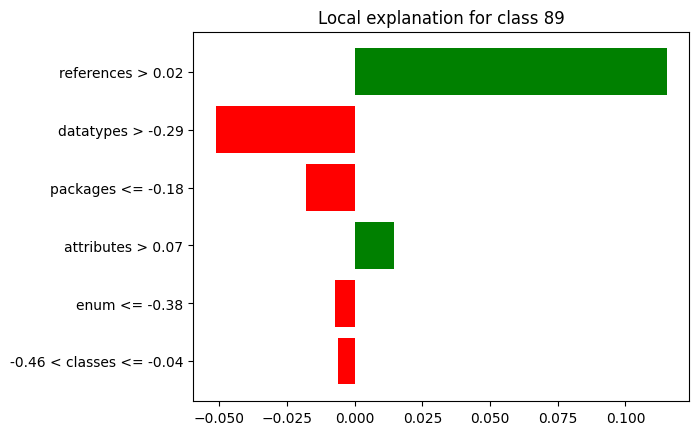

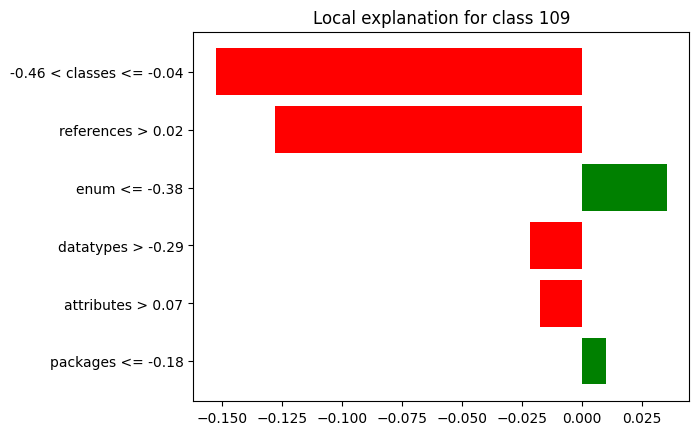

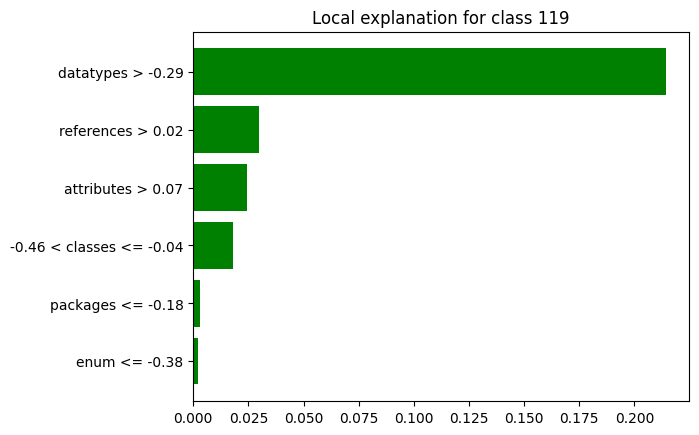

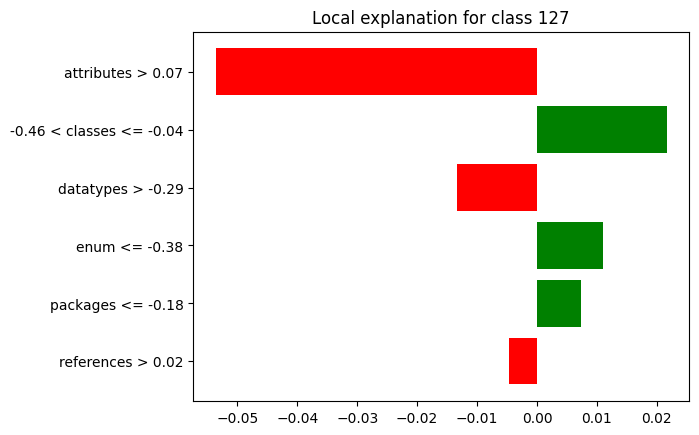

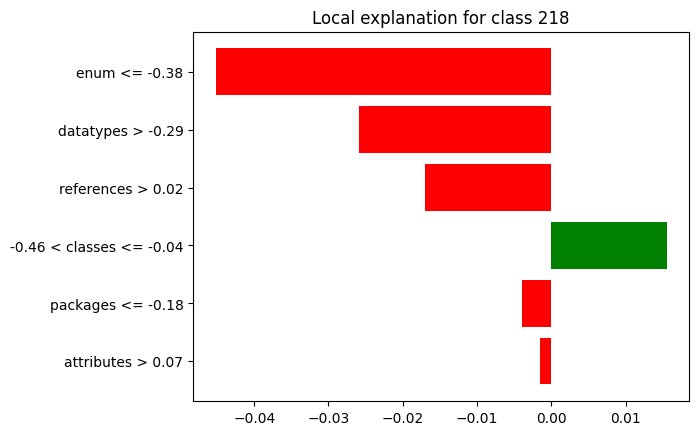

In [ ]:
for i in class_index:
  rf_exp_results['lime_metamodelling'][i].plot()

In [ ]:
breakdown_df_metamodelling_gpl, shap_df_metamodelling_gpl, lime_df_metamodelling_gpl, df_final_rf_meta_gpl = preprocess_dfs(breakdown_df_metamodelling_gpl, shap_df_metamodelling_gpl, lime_df_metamodelling_gpl, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_metamodelling_gpl)
print('----------------------------------------------')
print(shap_df_metamodelling_gpl)
print('----------------------------------------------')
print(lime_df_metamodelling_gpl)

['classes', 'enum', 'references', 'attributes', 'datatypes', 'packages']
----------------------------------------------
      Feature  Ranking      Sign
0   datatypes        1  Negative
1     classes        2  Negative
2  references        3  Positive
3        enum        4  Positive
4  attributes        5  Negative
5    packages        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0   datatypes        1  Negative
1  references        2  Negative
2     classes        3  Negative
3        enum        4  Positive
4  attributes        5  Negative
5    packages        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0  references        1  Positive
1   datatypes        2  Negative
2    packages        3  Negative
3  attributes        4  Positive
4        enum        5  Negative
5     classes        6  Negative


In [ ]:
df_final_rf_meta_gpl

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
datatypes          1  Negative       1  Negative       2  Negative
classes            2  Negative       3  Negative       6  Negative
references         3  Positive       2  Negative       1  Positive
enum               4  Positive       4  Positive       5  Negative
attributes         5  Negative       5  Negative       4  Positive
packages           6  Negative       6  Negative       3  Negative

In [ ]:
breakdown_df_metamodelling_lib, shap_df_metamodelling_lib, lime_df_metamodelling_lib, df_final_rf_meta_lib = preprocess_dfs(breakdown_df_metamodelling_lib, shap_df_metamodelling_lib, lime_df_metamodelling_lib, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_metamodelling_lib)
print('----------------------------------------------')
print(shap_df_metamodelling_lib)
print('----------------------------------------------')
print(lime_df_metamodelling_lib)

['classes', 'enum', 'references', 'attributes', 'datatypes', 'packages']
----------------------------------------------
      Feature  Ranking      Sign
0   datatypes        1  Negative
1  references        2  Negative
2  attributes        3  Positive
3     classes        4  Negative
4        enum        5  Negative
5    packages        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Negative
1  references        2  Negative
2  attributes        3  Positive
3   datatypes        4  Negative
4        enum        5  Negative
5    packages        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Negative
1  references        2  Negative
2        enum        3  Positive
3   datatypes        4  Negative
4  attributes        5  Negative
5    packages        6  Positive


In [ ]:
df_final_rf_meta_lib

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
datatypes          1  Negative       4  Negative       4  Negative
references         2  Negative       2  Negative       2  Negative
attributes         3  Positive       3  Positive       5  Negative
classes            4  Negative       1  Negative       1  Negative
enum               5  Negative       5  Negative       3  Positive
packages           6  Positive       6  Negative       6  Positive

In [ ]:
breakdown_df_metamodelling_meta, shap_df_metamodelling_meta, lime_df_metamodelling_meta, df_final_rf_meta_meta = preprocess_dfs(breakdown_df_metamodelling_meta, shap_df_metamodelling_meta, lime_df_metamodelling_meta, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_metamodelling_meta)
print('----------------------------------------------')
print(shap_df_metamodelling_meta)
print('----------------------------------------------')
print(lime_df_metamodelling_meta)

['classes', 'enum', 'references', 'attributes', 'datatypes', 'packages']
----------------------------------------------
      Feature  Ranking      Sign
0   datatypes        1  Positive
1     classes        2  Positive
2  attributes        3  Positive
3        enum        4  Positive
4  references        5  Positive
5    packages        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0   datatypes        1  Positive
1  attributes        2  Positive
2  references        3  Positive
3     classes        4  Positive
4        enum        5  Positive
5    packages        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0   datatypes        1  Positive
1  references        2  Positive
2  attributes        3  Positive
3     classes        4  Positive
4    packages        5  Positive
5        enum        6  Positive


In [ ]:
df_final_rf_meta_meta

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
datatypes          1  Positive       1  Positive       1  Positive
classes            2  Positive       4  Positive       4  Positive
attributes         3  Positive       2  Positive       3  Positive
enum               4  Positive       5  Positive       6  Positive
references         5  Positive       3  Positive       2  Positive
packages           6  Positive       6  Positive       5  Positive

In [ ]:
breakdown_df_metamodelling_mod, shap_df_metamodelling_mod, lime_df_metamodelling_mod, df_final_rf_meta_mod = preprocess_dfs(breakdown_df_metamodelling_mod, shap_df_metamodelling_mod, lime_df_metamodelling_mod, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_metamodelling_mod)
print('----------------------------------------------')
print(shap_df_metamodelling_mod)
print('----------------------------------------------')
print(lime_df_metamodelling_mod)

['classes', 'enum', 'references', 'attributes', 'datatypes', 'packages']
----------------------------------------------
      Feature  Ranking      Sign
0  attributes        1  Negative
1     classes        2  Positive
2  references        3  Negative
3        enum        4  Negative
4   datatypes        5  Negative
5    packages        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0   datatypes        1  Negative
1  attributes        2  Negative
2     classes        3  Positive
3        enum        4  Negative
4  references        5  Negative
5    packages        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0  attributes        1  Negative
1     classes        2  Positive
2   datatypes        3  Negative
3        enum        4  Positive
4    packages        5  Positive
5  references        6  Negative


In [ ]:
df_final_rf_meta_mod

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
attributes         1  Negative       2  Negative       1  Negative
classes            2  Positive       3  Positive       2  Positive
references         3  Negative       5  Negative       6  Negative
enum               4  Negative       4  Negative       4  Positive
datatypes          5  Negative       1  Negative       3  Negative
packages           6  Positive       6  Negative       5  Positive

In [ ]:
breakdown_df_metamodelling_wf, shap_df_metamodelling_wf, lime_df_metamodelling_wf, df_final_rf_meta_wf = preprocess_dfs(breakdown_df_metamodelling_wf, shap_df_metamodelling_wf, lime_df_metamodelling_wf, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_metamodelling_wf)
print('----------------------------------------------')
print(shap_df_metamodelling_wf)
print('----------------------------------------------')
print(lime_df_metamodelling_wf)

['classes', 'enum', 'references', 'attributes', 'datatypes', 'packages']
----------------------------------------------
      Feature  Ranking      Sign
0  references        1  Negative
1     classes        2  Positive
2        enum        3  Negative
3   datatypes        4  Negative
4  attributes        5  Negative
5    packages        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0  references        1  Negative
1   datatypes        2  Negative
2  attributes        3  Negative
3        enum        4  Negative
4     classes        5  Positive
5    packages        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0        enum        1  Negative
1   datatypes        2  Negative
2  references        3  Negative
3     classes        4  Positive
4    packages        5  Negative
5  attributes        6  Negative


In [ ]:
df_final_rf_meta_wf

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
references         1  Negative       1  Negative       3  Negative
classes            2  Positive       5  Positive       4  Positive
enum               3  Negative       4  Negative       1  Negative
datatypes          4  Negative       2  Negative       2  Negative
attributes         5  Negative       3  Negative       6  Negative
packages           6  Negative       6  Negative       5  Negative

### **RESULTS METAMODELLING:**

In [ ]:
df_topfeatures_meta_gpl = top3_features(df_final_rf_meta_gpl, 'Metamodelling - Class: GPL')
df_topfeatures_meta_lib = top3_features(df_final_rf_meta_lib, 'Metamodelling - Class: Library')
df_topfeatures_meta_meta = top3_features(df_final_rf_meta_meta, 'Metamodelling - Class: Metamodelling')
df_topfeatures_meta_mod = top3_features(df_final_rf_meta_mod, 'Metamodelling - Class: Modelling')
df_topfeatures_meta_wf = top3_features(df_final_rf_meta_wf, 'Metamodelling - Class: Workflow')

df_topfeatures_metamodelling_rf = pd.concat([df_topfeatures_meta_gpl, df_topfeatures_meta_lib, df_topfeatures_meta_meta, df_topfeatures_meta_mod, df_topfeatures_meta_wf])
df_topfeatures_metamodelling_rf

TOP3 Breakdown  \
Metamodelling - Class: GPL               datatypes, classes, references   
Metamodelling - Class: Library        attributes, datatypes, references   
Metamodelling - Class: Metamodelling     attributes, datatypes, classes   
Metamodelling - Class: Modelling        attributes, classes, references   
Metamodelling - Class: Workflow               enum, classes, references   

                                                              TOP3 Shap  \
Metamodelling - Class: GPL               datatypes, classes, references   
Metamodelling - Class: Library          attributes, classes, references   
Metamodelling - Class: Metamodelling  attributes, datatypes, references   
Metamodelling - Class: Modelling         attributes, datatypes, classes   
Metamodelling - Class: Workflow       attributes, datatypes, references   

                                                              TOP3 Lime  \
Metamodelling - Class: GPL              datatypes, packages, references   
Metamodelling - Class: Library                enum, classes, references   
Metamodelling - Class: Metamodelling  attributes, datatypes, references   
Metamodelling - Class: Modelling         attributes, datatypes, classes   
Metamodelling - Class: Workflow             datatypes, enum, references   

                                      Breakdown-Shap  Breakdown-Lime  \
Metamodelling - Class: GPL                  1.000000        0.666667   
Metamodelling - Class: Library              0.666667        0.333333   
Metamodelling - Class: Metamodelling        0.666667        0.666667   
Metamodelling - Class: Modelling            0.666667        0.666667   
Metamodelling - Class: Workflow             0.333333        0.666667   

                                      Lime-Shap  
Metamodelling - Class: GPL             0.666667  
Metamodelling - Class: Library         0.666667  
Metamodelling - Class: Metamodelling   1.000000  
Metamodelling - Class: Modelling       1.000000  
Metamodelling - Class: Workflow        0.666667

In [ ]:
df_topfeatures_meta_gpl_rank = top3_rank(df_final_rf_meta_gpl, 'Metamodelling - Class GPL')
df_topfeatures_meta_lib_rank = top3_rank(df_final_rf_meta_lib, 'Metamodelling - Class Library')
df_topfeatures_meta_meta_rank = top3_rank(df_final_rf_meta_meta, 'Metamodelling - Class Metamodelling')
df_topfeatures_meta_mod_rank = top3_rank(df_final_rf_meta_mod, 'Metamodelling - Class Modelling')
df_topfeatures_meta_wf_rank = top3_rank(df_final_rf_meta_wf, 'Metamodelling - Class Workflow')

df_topfeatures_rank_metamodelling_rf = pd.concat([df_topfeatures_meta_gpl_rank, df_topfeatures_meta_lib_rank, df_topfeatures_meta_meta_rank, df_topfeatures_meta_mod_rank, df_topfeatures_meta_wf_rank])
df_topfeatures_rank_metamodelling_rf

TOP3 Breakdown  \
Metamodelling - Class GPL               1:datatypes, 2:classes, 3:references   
Metamodelling - Class Library        1:datatypes, 2:references, 3:attributes   
Metamodelling - Class Metamodelling     1:datatypes, 2:classes, 3:attributes   
Metamodelling - Class Modelling        1:attributes, 2:classes, 3:references   
Metamodelling - Class Workflow               1:references, 2:classes, 3:enum   

                                                                   TOP3 Shap  \
Metamodelling - Class GPL               1:datatypes, 3:classes, 2:references   
Metamodelling - Class Library          2:references, 3:attributes, 1:classes   
Metamodelling - Class Metamodelling  1:datatypes, 2:attributes, 3:references   
Metamodelling - Class Modelling         2:attributes, 3:classes, 1:datatypes   
Metamodelling - Class Workflow       1:references, 2:datatypes, 3:attributes   

                                                                   TOP3 Lime  \
Metamodelling - Class GPL              2:datatypes, 1:references, 3:packages   
Metamodelling - Class Library                2:references, 1:classes, 3:enum   
Metamodelling - Class Metamodelling  1:datatypes, 3:attributes, 2:references   
Metamodelling - Class Modelling         1:attributes, 2:classes, 3:datatypes   
Metamodelling - Class Workflow             3:references, 1:enum, 2:datatypes   

                                     Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Metamodelling - Class GPL                  0.333333        0.000000   0.000000  
Metamodelling - Class Library              0.666667        0.333333   0.666667  
Metamodelling - Class Metamodelling        0.333333        0.666667   0.333333  
Metamodelling - Class Modelling            0.000000        0.666667   0.000000  
Metamodelling - Class Workflow             0.333333        0.000000   0.333333

In [ ]:
df_topfeatures_meta_gpl_sign = top3_sign(df_final_rf_meta_gpl, 'Metamodelling - Class GPL')
df_topfeatures_meta_lib_sign = top3_sign(df_final_rf_meta_lib, 'Metamodelling - Class Library')
df_topfeatures_meta_meta_sign = top3_sign(df_final_rf_meta_meta, 'Metamodelling - Class Metamodelling')
df_topfeatures_meta_mod_sign = top3_sign(df_final_rf_meta_mod, 'Metamodelling - Class Modelling')
df_topfeatures_meta_wf_sign = top3_sign(df_final_rf_meta_wf, 'Metamodelling - Class Workflow')

df_topfeatures_sign_metamodelling_rf = pd.concat([df_topfeatures_meta_gpl_sign, df_topfeatures_meta_lib_sign, df_topfeatures_meta_meta_sign, df_topfeatures_meta_mod_sign, df_topfeatures_meta_wf_sign])
df_topfeatures_sign_metamodelling_rf

TOP3 Breakdown  \
Metamodelling - Class GPL            datatypes:Negative, classes:Negative, referenc...   
Metamodelling - Class Library        datatypes:Negative, references:Negative, attri...   
Metamodelling - Class Metamodelling  datatypes:Positive, classes:Positive, attribut...   
Metamodelling - Class Modelling      attributes:Negative, classes:Positive, referen...   
Metamodelling - Class Workflow       references:Negative, classes:Positive, enum:Ne...   

                                                                             TOP3 Shap  \
Metamodelling - Class GPL            datatypes:Negative, classes:Negative, referenc...   
Metamodelling - Class Library        references:Negative, attributes:Positive, clas...   
Metamodelling - Class Metamodelling  datatypes:Positive, attributes:Positive, refer...   
Metamodelling - Class Modelling      attributes:Negative, classes:Positive, datatyp...   
Metamodelling - Class Workflow       references:Negative, datatypes:Negative, attri...   

                                                                             TOP3 Lime  \
Metamodelling - Class GPL            datatypes:Negative, references:Positive, packa...   
Metamodelling - Class Library        references:Negative, classes:Negative, enum:Po...   
Metamodelling - Class Metamodelling  datatypes:Positive, attributes:Positive, refer...   
Metamodelling - Class Modelling      attributes:Negative, classes:Positive, datatyp...   
Metamodelling - Class Workflow       references:Negative, enum:Negative, datatypes:...   

                                     Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Metamodelling - Class GPL                  0.666667        0.666667   0.333333  
Metamodelling - Class Library              0.666667        0.333333   0.666667  
Metamodelling - Class Metamodelling        0.666667        0.666667   1.000000  
Metamodelling - Class Modelling            0.666667        0.666667   1.000000  
Metamodelling - Class Workflow             0.333333        0.666667   0.666667

In [ ]:
df_topfeatures_meta_gpl_rank_sign = top3_rank_sign(df_final_rf_meta_gpl, 'Metamodelling - Class GPL')
df_topfeatures_meta_lib_rank_sign = top3_rank_sign(df_final_rf_meta_lib, 'Metamodelling - Class Library')
df_topfeatures_meta_meta_rank_sign = top3_rank_sign(df_final_rf_meta_meta, 'Metamodelling - Class Metamodelling')
df_topfeatures_meta_mod_rank_sign = top3_rank_sign(df_final_rf_meta_mod, 'Metamodelling - Class Modelling')
df_topfeatures_meta_wf_rank_sign = top3_rank_sign(df_final_rf_meta_wf, 'Metamodelling - Class Workflow')

df_topfeatures_rank_sign_metamodelling_rf = pd.concat([df_topfeatures_meta_gpl_rank_sign, df_topfeatures_meta_lib_rank_sign, df_topfeatures_meta_meta_rank_sign, df_topfeatures_meta_mod_rank_sign, df_topfeatures_meta_wf_rank_sign])
df_topfeatures_rank_sign_metamodelling_rf

TOP3 Breakdown  \
Metamodelling - Class GPL            1:datatypes:Negative, 2:classes:Negative, 3:re...   
Metamodelling - Class Library        1:datatypes:Negative, 2:references:Negative, 3...   
Metamodelling - Class Metamodelling  1:datatypes:Positive, 2:classes:Positive, 3:at...   
Metamodelling - Class Modelling      1:attributes:Negative, 2:classes:Positive, 3:r...   
Metamodelling - Class Workflow       1:references:Negative, 2:classes:Positive, 3:e...   

                                                                             TOP3 Shap  \
Metamodelling - Class GPL            1:datatypes:Negative, 3:classes:Negative, 2:re...   
Metamodelling - Class Library        2:references:Negative, 3:attributes:Positive, ...   
Metamodelling - Class Metamodelling  1:datatypes:Positive, 2:attributes:Positive, 3...   
Metamodelling - Class Modelling      2:attributes:Negative, 3:classes:Positive, 1:d...   
Metamodelling - Class Workflow       1:references:Negative, 2:datatypes:Negative, 3...   

                                                                             TOP3 Lime  \
Metamodelling - Class GPL            2:datatypes:Negative, 1:references:Positive, 3...   
Metamodelling - Class Library        2:references:Negative, 1:classes:Negative, 3:e...   
Metamodelling - Class Metamodelling  1:datatypes:Positive, 3:attributes:Positive, 2...   
Metamodelling - Class Modelling      1:attributes:Negative, 2:classes:Positive, 3:d...   
Metamodelling - Class Workflow       3:references:Negative, 1:enum:Negative, 2:data...   

                                     Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Metamodelling - Class GPL                  0.333333        0.000000   0.000000  
Metamodelling - Class Library              0.666667        0.333333   0.666667  
Metamodelling - Class Metamodelling        0.333333        0.666667   0.333333  
Metamodelling - Class Modelling            0.000000        0.666667   0.000000  
Metamodelling - Class Workflow             0.333333        0.000000   0.333333

### **MODELLING:**

In [ ]:
breakdown_df_modelling_gpl = rf_exp_results['breakdown_modelling'][1].result
shap_df_modelling_gpl = rf_exp_results['shap_modelling'][1].result
lime_df_modelling_gpl = rf_exp_results['lime_modelling'][1].result

In [ ]:
breakdown_df_modelling_lib = rf_exp_results['breakdown_modelling'][2].result
shap_df_modelling_lib = rf_exp_results['shap_modelling'][2].result
lime_df_modelling_lib = rf_exp_results['lime_modelling'][2].result

In [ ]:
breakdown_df_modelling_meta = rf_exp_results['breakdown_modelling'][3].result
shap_df_modelling_meta = rf_exp_results['shap_modelling'][3].result
lime_df_modelling_meta = rf_exp_results['lime_modelling'][3].result

In [ ]:
breakdown_df_modelling_mod = rf_exp_results['breakdown_modelling'][4].result
shap_df_modelling_mod = rf_exp_results['shap_modelling'][4].result
lime_df_modelling_mod = rf_exp_results['lime_modelling'][4].result

In [ ]:
breakdown_df_modelling_wf = rf_exp_results['breakdown_modelling'][9].result
shap_df_modelling_wf = rf_exp_results['shap_modelling'][9].result
lime_df_modelling_wf = rf_exp_results['lime_modelling'][9].result

In [ ]:
exp_plots_bd = [rf_exp_results['breakdown_modelling'][i] for i in class_index]
exp_plots_bd[0].plot(exp_plots_bd[1:])

In [ ]:
exp_plots_shap = [rf_exp_results['shap_modelling'][i] for i in class_index]
exp_plots_shap[0].plot(exp_plots_shap[1:])

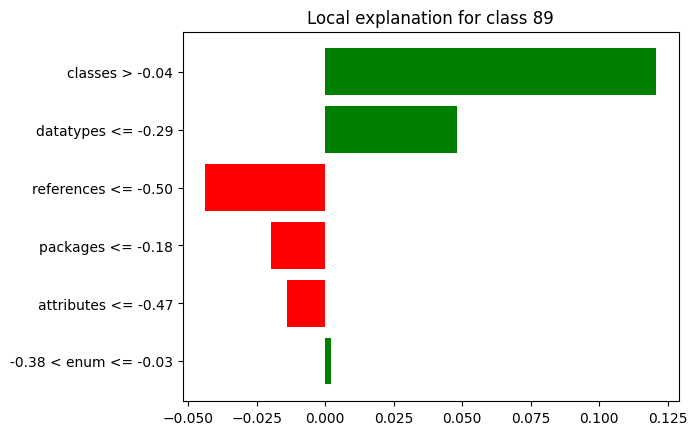

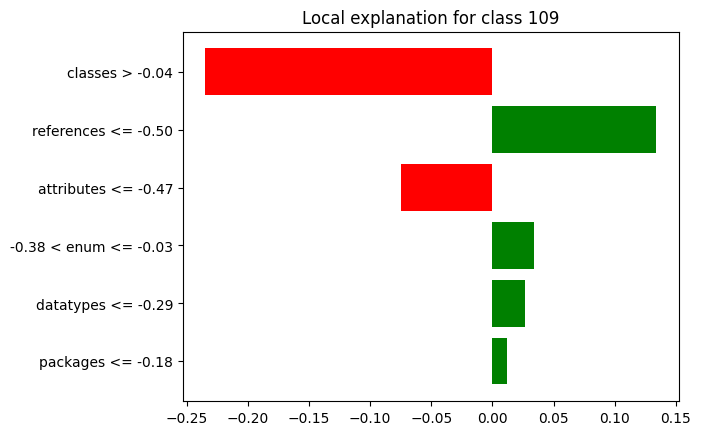

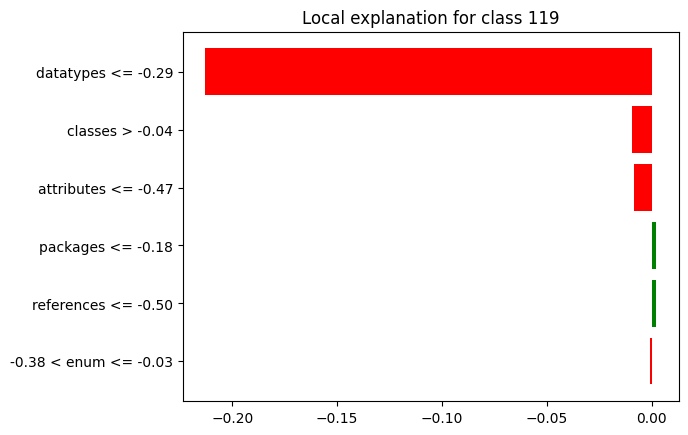

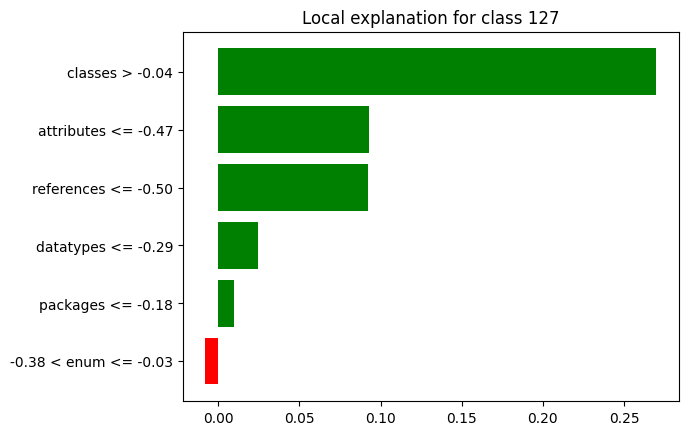

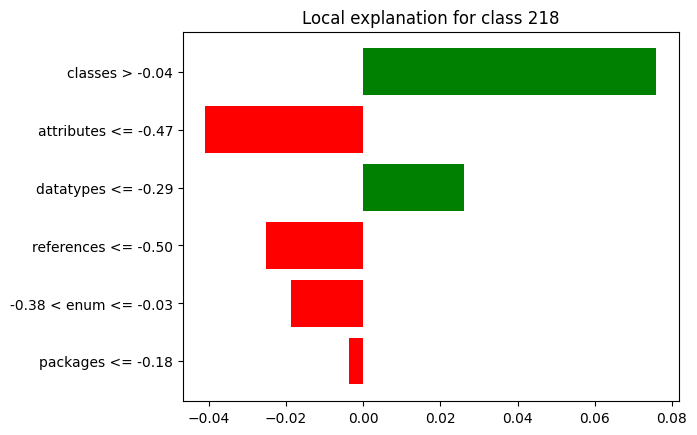

In [ ]:
for i in class_index:
  rf_exp_results['lime_modelling'][i].plot()

In [ ]:
breakdown_df_modelling_gpl, shap_df_modelling_gpl, lime_df_modelling_gpl, df_final_rf_mod_gpl = preprocess_dfs(breakdown_df_modelling_gpl, shap_df_modelling_gpl, lime_df_modelling_gpl, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_modelling_gpl)
print('----------------------------------------------')
print(shap_df_modelling_gpl)
print('----------------------------------------------')
print(lime_df_modelling_gpl)

['classes', 'enum', 'references', 'attributes', 'datatypes', 'packages']
----------------------------------------------
      Feature  Ranking      Sign
0  references        1  Negative
1  attributes        2  Negative
2     classes        3  Positive
3   datatypes        4  Positive
4        enum        5  Positive
5    packages        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0  references        1  Negative
1  attributes        2  Negative
2     classes        3  Positive
3        enum        4  Positive
4   datatypes        5  Positive
5    packages        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Positive
1   datatypes        2  Positive
2  references        3  Negative
3    packages        4  Negative
4  attributes        5  Negative
5        enum        6  Positive


In [ ]:
df_final_rf_mod_gpl

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
references         1  Negative       1  Negative       3  Negative
attributes         2  Negative       2  Negative       5  Negative
classes            3  Positive       3  Positive       1  Positive
datatypes          4  Positive       5  Positive       2  Positive
enum               5  Positive       4  Positive       6  Positive
packages           6  Positive       6  Negative       4  Negative

In [ ]:
breakdown_df_modelling_lib, shap_df_modelling_lib, lime_df_modelling_lib, df_final_rf_mod_lib = preprocess_dfs(breakdown_df_modelling_lib, shap_df_modelling_lib, lime_df_modelling_lib, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_modelling_lib)
print('----------------------------------------------')
print(shap_df_modelling_lib)
print('----------------------------------------------')
print(lime_df_modelling_lib)

['classes', 'enum', 'references', 'attributes', 'datatypes', 'packages']
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Negative
1  references        2  Positive
2        enum        3  Positive
3  attributes        4  Negative
4   datatypes        5  Negative
5    packages        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Negative
1        enum        2  Positive
2  attributes        3  Negative
3  references        4  Positive
4   datatypes        5  Negative
5    packages        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Negative
1  references        2  Positive
2  attributes        3  Negative
3        enum        4  Positive
4   datatypes        5  Positive
5    packages        6  Positive


In [ ]:
df_final_rf_mod_lib

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
classes            1  Negative       1  Negative       1  Negative
references         2  Positive       4  Positive       2  Positive
enum               3  Positive       2  Positive       4  Positive
attributes         4  Negative       3  Negative       3  Negative
datatypes          5  Negative       5  Negative       5  Positive
packages           6  Negative       6  Negative       6  Positive

In [ ]:
breakdown_df_modelling_meta, shap_df_modelling_meta, lime_df_modelling_meta, df_final_rf_mod_meta = preprocess_dfs(breakdown_df_modelling_meta, shap_df_modelling_meta, lime_df_modelling_meta, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_modelling_meta)
print('----------------------------------------------')
print(shap_df_modelling_meta)
print('----------------------------------------------')
print(lime_df_modelling_meta)

['classes', 'enum', 'references', 'attributes', 'datatypes', 'packages']
----------------------------------------------
      Feature  Ranking      Sign
0   datatypes        1  Negative
1  attributes        2  Negative
2     classes        3  Negative
3        enum        4  Negative
4  references        5  Negative
5    packages        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0   datatypes        1  Negative
1  attributes        2  Negative
2        enum        3  Negative
3     classes        4  Negative
4  references        5  Negative
5    packages        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0   datatypes        1  Negative
1     classes        2  Negative
2  attributes        3  Negative
3    packages        4  Positive
4  references        5  Positive
5        enum        6  Negative


In [ ]:
df_final_rf_mod_meta

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
datatypes          1  Negative       1  Negative       1  Negative
attributes         2  Negative       2  Negative       3  Negative
classes            3  Negative       4  Negative       2  Negative
enum               4  Negative       3  Negative       6  Negative
references         5  Negative       5  Negative       5  Positive
packages           6  Negative       6  Positive       4  Positive

In [ ]:
breakdown_df_modelling_mod, shap_df_modelling_mod, lime_df_modelling_mod, df_final_rf_mod_mod = preprocess_dfs(breakdown_df_modelling_mod, shap_df_modelling_mod, lime_df_modelling_mod, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_modelling_mod)
print('----------------------------------------------')
print(shap_df_modelling_mod)
print('----------------------------------------------')
print(lime_df_modelling_mod)

['classes', 'enum', 'references', 'attributes', 'datatypes', 'packages']
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Positive
1  references        2  Positive
2  attributes        3  Positive
3        enum        4  Positive
4   datatypes        5  Positive
5    packages        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Positive
1  attributes        2  Positive
2  references        3  Positive
3        enum        4  Positive
4   datatypes        5  Positive
5    packages        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Positive
1  attributes        2  Positive
2  references        3  Positive
3   datatypes        4  Positive
4    packages        5  Positive
5        enum        6  Negative


In [ ]:
df_final_rf_mod_mod

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
classes            1  Positive       1  Positive       1  Positive
references         2  Positive       3  Positive       3  Positive
attributes         3  Positive       2  Positive       2  Positive
enum               4  Positive       4  Positive       6  Negative
datatypes          5  Positive       5  Positive       4  Positive
packages           6  Positive       6  Positive       5  Positive

In [ ]:
breakdown_df_modelling_wf, shap_df_modelling_wf, lime_df_modelling_wf, df_final_rf_mod_wf = preprocess_dfs(breakdown_df_modelling_wf, shap_df_modelling_wf, lime_df_modelling_wf, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_modelling_wf)
print('----------------------------------------------')
print(shap_df_modelling_wf)
print('----------------------------------------------')
print(lime_df_modelling_wf)

['classes', 'enum', 'references', 'attributes', 'datatypes', 'packages']
----------------------------------------------
      Feature  Ranking      Sign
0  attributes        1  Negative
1     classes        2  Positive
2  references        3  Negative
3        enum        4  Negative
4   datatypes        5  Negative
5    packages        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0  attributes        1  Negative
1  references        2  Negative
2        enum        3  Negative
3     classes        4  Positive
4   datatypes        5  Negative
5    packages        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Positive
1  attributes        2  Negative
2   datatypes        3  Positive
3  references        4  Negative
4        enum        5  Negative
5    packages        6  Negative


In [ ]:
df_final_rf_mod_wf

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
attributes         1  Negative       1  Negative       2  Negative
classes            2  Positive       4  Positive       1  Positive
references         3  Negative       2  Negative       4  Negative
enum               4  Negative       3  Negative       5  Negative
datatypes          5  Negative       5  Negative       3  Positive
packages           6  Positive       6  Positive       6  Negative

### **RESULTS MODELLING:**

In [ ]:
df_topfeatures_mod_gpl = top3_features(df_final_rf_mod_gpl, 'Modelling - Class: GPL')
df_topfeatures_mod_lib = top3_features(df_final_rf_mod_lib, 'Modelling - Class: Library')
df_topfeatures_mod_meta = top3_features(df_final_rf_mod_meta, 'Modelling - Class: Metamodelling')
df_topfeatures_mod_mod = top3_features(df_final_rf_mod_mod, 'Modelling - Class: Modelling')
df_topfeatures_mod_wf = top3_features(df_final_rf_mod_wf, 'Modelling - Class: Workflow')

df_topfeatures_modelling_rf = pd.concat([df_topfeatures_mod_gpl, df_topfeatures_mod_lib, df_topfeatures_mod_meta, df_topfeatures_mod_mod, df_topfeatures_mod_wf])
df_topfeatures_modelling_rf

TOP3 Breakdown  \
Modelling - Class: GPL            attributes, classes, references   
Modelling - Class: Library              enum, classes, references   
Modelling - Class: Metamodelling   attributes, datatypes, classes   
Modelling - Class: Modelling      attributes, classes, references   
Modelling - Class: Workflow       attributes, classes, references   

                                                        TOP3 Shap  \
Modelling - Class: GPL            attributes, classes, references   
Modelling - Class: Library              attributes, enum, classes   
Modelling - Class: Metamodelling      attributes, enum, datatypes   
Modelling - Class: Modelling      attributes, classes, references   
Modelling - Class: Workflow          attributes, enum, references   

                                                        TOP3 Lime  \
Modelling - Class: GPL             datatypes, classes, references   
Modelling - Class: Library        attributes, classes, references   
Modelling - Class: Metamodelling   attributes, datatypes, classes   
Modelling - Class: Modelling      attributes, classes, references   
Modelling - Class: Workflow        attributes, datatypes, classes   

                                  Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Modelling - Class: GPL                  1.000000        0.666667   0.666667  
Modelling - Class: Library              0.666667        0.666667   0.666667  
Modelling - Class: Metamodelling        0.666667        1.000000   0.666667  
Modelling - Class: Modelling            1.000000        1.000000   1.000000  
Modelling - Class: Workflow             0.666667        0.666667   0.333333

In [ ]:
df_topfeatures_mod_gpl_rank = top3_rank(df_final_rf_mod_gpl, 'Modelling - Class GPL')
df_topfeatures_mod_lib_rank = top3_rank(df_final_rf_mod_lib, 'Modelling - Class Library')
df_topfeatures_mod_meta_rank = top3_rank(df_final_rf_mod_meta, 'Modelling - Class Metamodelling')
df_topfeatures_mod_mod_rank = top3_rank(df_final_rf_mod_mod, 'Modelling - Class Modelling')
df_topfeatures_mod_wf_rank = top3_rank(df_final_rf_mod_wf, 'Modelling - Class Workflow')

df_topfeatures_rank_modelling_rf = pd.concat([df_topfeatures_mod_gpl_rank, df_topfeatures_mod_lib_rank, df_topfeatures_mod_meta_rank, df_topfeatures_mod_mod_rank, df_topfeatures_mod_wf_rank])
df_topfeatures_rank_modelling_rf

TOP3 Breakdown  \
Modelling - Class GPL            1:references, 2:attributes, 3:classes   
Modelling - Class Library              1:classes, 2:references, 3:enum   
Modelling - Class Metamodelling   1:datatypes, 2:attributes, 3:classes   
Modelling - Class Modelling      1:classes, 2:references, 3:attributes   
Modelling - Class Workflow       1:attributes, 2:classes, 3:references   

                                                             TOP3 Shap  \
Modelling - Class GPL            1:references, 2:attributes, 3:classes   
Modelling - Class Library              1:classes, 2:enum, 3:attributes   
Modelling - Class Metamodelling      1:datatypes, 2:attributes, 3:enum   
Modelling - Class Modelling      1:classes, 3:references, 2:attributes   
Modelling - Class Workflow          1:attributes, 2:references, 3:enum   

                                                             TOP3 Lime  \
Modelling - Class GPL             3:references, 1:classes, 2:datatypes   
Modelling - Class Library        1:classes, 2:references, 3:attributes   
Modelling - Class Metamodelling   1:datatypes, 3:attributes, 2:classes   
Modelling - Class Modelling      1:classes, 3:references, 2:attributes   
Modelling - Class Workflow        2:attributes, 1:classes, 3:datatypes   

                                 Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Modelling - Class GPL                  1.000000        0.000000   0.000000  
Modelling - Class Library              0.333333        0.666667   0.666667  
Modelling - Class Metamodelling        0.666667        0.333333   0.333333  
Modelling - Class Modelling            0.333333        0.333333   1.000000  
Modelling - Class Workflow             0.333333        0.000000   0.000000

In [ ]:
df_topfeatures_mod_gpl_sign = top3_sign(df_final_rf_mod_gpl, 'Modelling - Class GPL')
df_topfeatures_mod_lib_sign = top3_sign(df_final_rf_mod_lib, 'Modelling - Class Library')
df_topfeatures_mod_meta_sign = top3_sign(df_final_rf_mod_meta, 'Modelling - Class Metamodelling')
df_topfeatures_mod_mod_sign = top3_sign(df_final_rf_mod_mod, 'Modelling - Class Modelling')
df_topfeatures_mod_wf_sign = top3_sign(df_final_rf_mod_wf, 'Modelling - Class Workflow')

df_topfeatures_sign_modelling_rf = pd.concat([df_topfeatures_mod_gpl_sign, df_topfeatures_mod_lib_sign, df_topfeatures_mod_meta_sign, df_topfeatures_mod_mod_sign, df_topfeatures_mod_wf_sign])
df_topfeatures_sign_modelling_rf

TOP3 Breakdown  \
Modelling - Class GPL            references:Negative, attributes:Negative, clas...   
Modelling - Class Library        classes:Negative, references:Positive, enum:Po...   
Modelling - Class Metamodelling  datatypes:Negative, attributes:Negative, class...   
Modelling - Class Modelling      classes:Positive, references:Positive, attribu...   
Modelling - Class Workflow       attributes:Negative, classes:Positive, referen...   

                                                                         TOP3 Shap  \
Modelling - Class GPL            references:Negative, attributes:Negative, clas...   
Modelling - Class Library        classes:Negative, enum:Positive, attributes:Ne...   
Modelling - Class Metamodelling  datatypes:Negative, attributes:Negative, enum:...   
Modelling - Class Modelling      classes:Positive, references:Positive, attribu...   
Modelling - Class Workflow       attributes:Negative, references:Negative, enum...   

                                                                         TOP3 Lime  \
Modelling - Class GPL            references:Negative, classes:Positive, datatyp...   
Modelling - Class Library        classes:Negative, references:Positive, attribu...   
Modelling - Class Metamodelling  datatypes:Negative, attributes:Negative, class...   
Modelling - Class Modelling      classes:Positive, references:Positive, attribu...   
Modelling - Class Workflow       attributes:Negative, classes:Positive, datatyp...   

                                 Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Modelling - Class GPL                  1.000000        0.666667   0.666667  
Modelling - Class Library              0.666667        0.666667   0.666667  
Modelling - Class Metamodelling        0.666667        1.000000   0.666667  
Modelling - Class Modelling            1.000000        1.000000   1.000000  
Modelling - Class Workflow             0.666667        0.666667   0.333333

In [ ]:
df_topfeatures_mod_gpl_rank_sign = top3_rank_sign(df_final_rf_mod_gpl, 'Modelling - Class GPL')
df_topfeatures_mod_lib_rank_sign = top3_rank_sign(df_final_rf_mod_lib, 'Modelling - Class Library')
df_topfeatures_mod_meta_rank_sign = top3_rank_sign(df_final_rf_mod_meta, 'Modelling - Class Metamodelling')
df_topfeatures_mod_mod_rank_sign = top3_rank_sign(df_final_rf_mod_mod, 'Modelling - Class Modelling')
df_topfeatures_mod_wf_rank_sign = top3_rank_sign(df_final_rf_mod_wf, 'Modelling - Class Workflow')

df_topfeatures_rank_sign_modelling_rf = pd.concat([df_topfeatures_mod_gpl_rank_sign, df_topfeatures_mod_lib_rank_sign, df_topfeatures_mod_meta_rank_sign, df_topfeatures_mod_mod_rank_sign, df_topfeatures_mod_wf_rank_sign])
df_topfeatures_rank_sign_modelling_rf

TOP3 Breakdown  \
Modelling - Class GPL            1:references:Negative, 2:attributes:Negative, ...   
Modelling - Class Library        1:classes:Negative, 2:references:Positive, 3:e...   
Modelling - Class Metamodelling  1:datatypes:Negative, 2:attributes:Negative, 3...   
Modelling - Class Modelling      1:classes:Positive, 2:references:Positive, 3:a...   
Modelling - Class Workflow       1:attributes:Negative, 2:classes:Positive, 3:r...   

                                                                         TOP3 Shap  \
Modelling - Class GPL            1:references:Negative, 2:attributes:Negative, ...   
Modelling - Class Library        1:classes:Negative, 2:enum:Positive, 3:attribu...   
Modelling - Class Metamodelling  1:datatypes:Negative, 2:attributes:Negative, 3...   
Modelling - Class Modelling      1:classes:Positive, 3:references:Positive, 2:a...   
Modelling - Class Workflow       1:attributes:Negative, 2:references:Negative, ...   

                                                                         TOP3 Lime  \
Modelling - Class GPL            3:references:Negative, 1:classes:Positive, 2:d...   
Modelling - Class Library        1:classes:Negative, 2:references:Positive, 3:a...   
Modelling - Class Metamodelling  1:datatypes:Negative, 3:attributes:Negative, 2...   
Modelling - Class Modelling      1:classes:Positive, 3:references:Positive, 2:a...   
Modelling - Class Workflow       2:attributes:Negative, 1:classes:Positive, 3:d...   

                                 Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Modelling - Class GPL                  1.000000        0.000000   0.000000  
Modelling - Class Library              0.333333        0.666667   0.666667  
Modelling - Class Metamodelling        0.666667        0.333333   0.333333  
Modelling - Class Modelling            0.333333        0.333333   1.000000  
Modelling - Class Workflow             0.333333        0.000000   0.000000

### **WORKFLOW:**

In [ ]:
breakdown_df_workflow_gpl = rf_exp_results['breakdown_workflow'][1].result
shap_df_workflow_gpl = rf_exp_results['shap_workflow'][1].result
lime_df_workflow_gpl = rf_exp_results['lime_workflow'][1].result

In [ ]:
breakdown_df_workflow_lib = rf_exp_results['breakdown_workflow'][2].result
shap_df_workflow_lib = rf_exp_results['shap_workflow'][2].result
lime_df_workflow_lib = rf_exp_results['lime_workflow'][2].result

In [ ]:
breakdown_df_workflow_meta = rf_exp_results['breakdown_workflow'][3].result
shap_df_workflow_meta = rf_exp_results['shap_workflow'][3].result
lime_df_workflow_meta = rf_exp_results['lime_workflow'][3].result

In [ ]:
breakdown_df_workflow_mod = rf_exp_results['breakdown_workflow'][4].result
shap_df_workflow_mod = rf_exp_results['shap_workflow'][4].result
lime_df_workflow_mod = rf_exp_results['lime_workflow'][4].result

In [ ]:
breakdown_df_workflow_wf = rf_exp_results['breakdown_workflow'][9].result
shap_df_workflow_wf = rf_exp_results['shap_workflow'][9].result
lime_df_workflow_wf = rf_exp_results['lime_workflow'][9].result

In [ ]:
exp_plots_bd = [rf_exp_results['breakdown_workflow'][i] for i in class_index]
exp_plots_bd[0].plot(exp_plots_bd[1:])

In [ ]:
exp_plots_shap = [rf_exp_results['shap_workflow'][i] for i in class_index]
exp_plots_shap[0].plot(exp_plots_shap[1:])

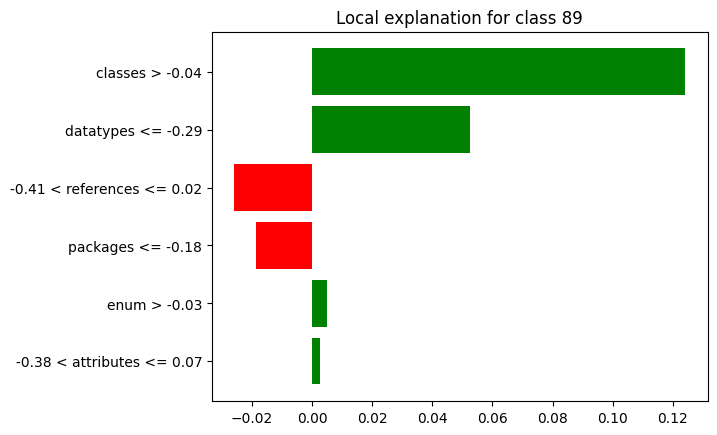

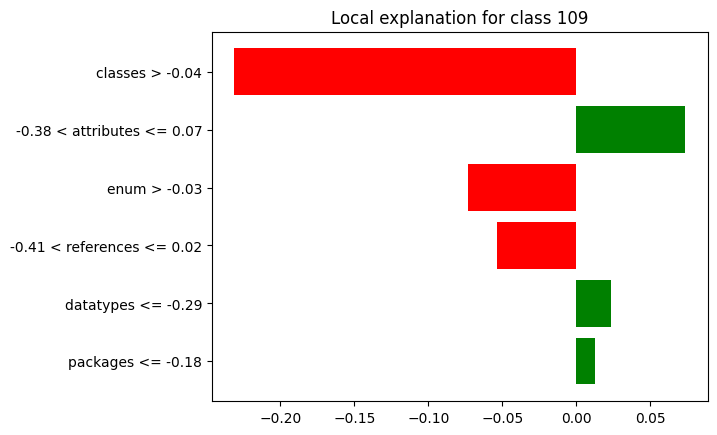

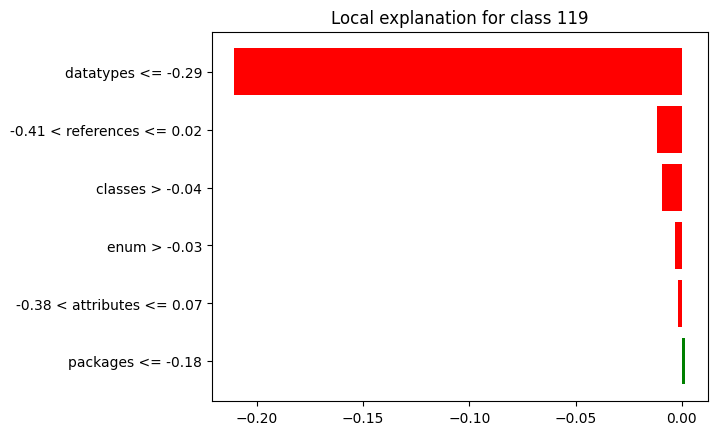

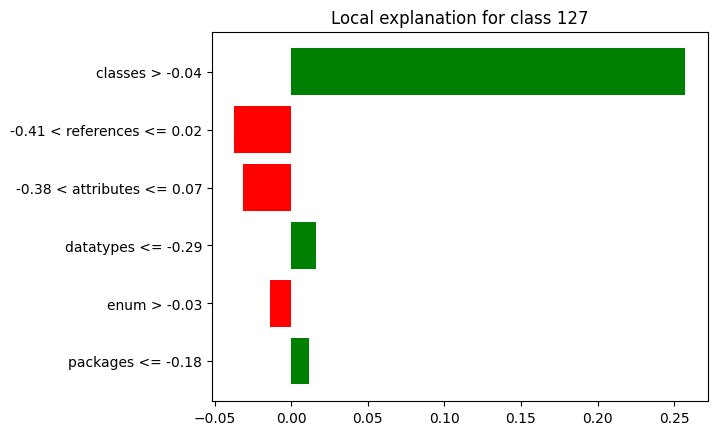

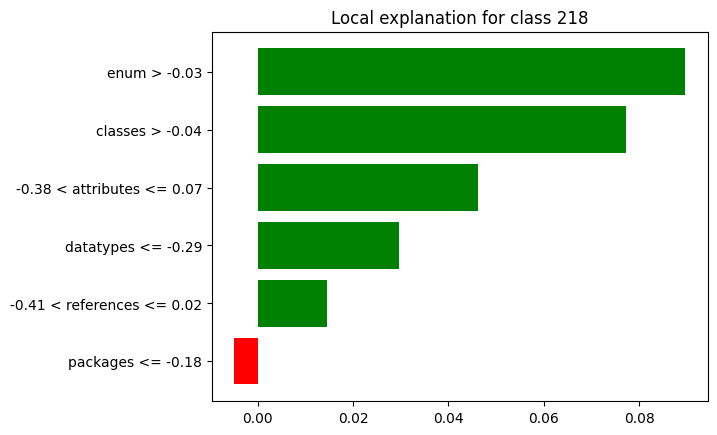

In [ ]:
for i in class_index:
  rf_exp_results['lime_workflow'][i].plot()

In [ ]:
breakdown_df_workflow_gpl, shap_df_workflow_gpl, lime_df_workflow_gpl, df_final_rf_wf_gpl = preprocess_dfs(breakdown_df_workflow_gpl, shap_df_workflow_gpl, lime_df_workflow_gpl, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_workflow_gpl)
print('----------------------------------------------')
print(shap_df_workflow_gpl)
print('----------------------------------------------')
print(lime_df_workflow_gpl)

['classes', 'enum', 'references', 'attributes', 'datatypes', 'packages']
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Negative
1        enum        2  Positive
2  references        3  Negative
3  attributes        4  Negative
4   datatypes        5  Positive
5    packages        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Negative
1  references        2  Negative
2  attributes        3  Negative
3   datatypes        4  Positive
4        enum        5  Negative
5    packages        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Positive
1   datatypes        2  Positive
2  references        3  Negative
3    packages        4  Negative
4        enum        5  Positive
5  attributes        6  Positive


In [ ]:
df_final_rf_wf_gpl

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
classes            1  Negative       1  Negative       1  Positive
enum               2  Positive       5  Negative       5  Positive
references         3  Negative       2  Negative       3  Negative
attributes         4  Negative       3  Negative       6  Positive
datatypes          5  Positive       4  Positive       2  Positive
packages           6  Positive       6  Negative       4  Negative

In [ ]:
breakdown_df_workflow_lib, shap_df_workflow_lib, lime_df_workflow_lib, df_final_rf_wf_lib = preprocess_dfs(breakdown_df_workflow_lib, shap_df_workflow_lib, lime_df_workflow_lib, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_workflow_lib)
print('----------------------------------------------')
print(shap_df_workflow_lib)
print('----------------------------------------------')
print(lime_df_workflow_lib)

['classes', 'packages', 'enum', 'references', 'attributes', 'datatypes']
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Negative
1  references        2  Negative
2  attributes        3  Positive
3        enum        4  Negative
4    packages        5  Negative
5   datatypes        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Negative
1  references        2  Negative
2  attributes        3  Positive
3        enum        4  Negative
4   datatypes        5  Negative
5    packages        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Negative
1  attributes        2  Positive
2        enum        3  Negative
3  references        4  Negative
4   datatypes        5  Positive
5    packages        6  Positive


In [ ]:
df_final_rf_wf_lib

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
classes            1  Negative       1  Negative       1  Negative
references         2  Negative       2  Negative       4  Negative
attributes         3  Positive       3  Positive       2  Positive
enum               4  Negative       4  Negative       3  Negative
packages           5  Negative       6  Negative       6  Positive
datatypes          6  Negative       5  Negative       5  Positive

In [ ]:
breakdown_df_workflow_meta, shap_df_workflow_meta, lime_df_workflow_meta, df_final_rf_wf_meta = preprocess_dfs(breakdown_df_workflow_meta, shap_df_workflow_meta, lime_df_workflow_meta, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_workflow_meta)
print('----------------------------------------------')
print(shap_df_workflow_meta)
print('----------------------------------------------')
print(lime_df_workflow_meta)

['classes', 'enum', 'references', 'attributes', 'datatypes', 'packages']
----------------------------------------------
      Feature  Ranking      Sign
0  references        1  Positive
1     classes        2  Negative
2        enum        3  Negative
3   datatypes        4  Negative
4  attributes        5  Negative
5    packages        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0  references        1  Positive
1        enum        2  Negative
2   datatypes        3  Negative
3     classes        4  Negative
4  attributes        5  Negative
5    packages        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0   datatypes        1  Negative
1  references        2  Negative
2     classes        3  Negative
3        enum        4  Negative
4  attributes        5  Negative
5    packages        6  Positive


In [ ]:
df_final_rf_wf_meta

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
references         1  Positive       1  Positive       2  Negative
classes            2  Negative       4  Negative       3  Negative
enum               3  Negative       2  Negative       4  Negative
datatypes          4  Negative       3  Negative       1  Negative
attributes         5  Negative       5  Negative       5  Negative
packages           6  Positive       6  Positive       6  Positive

In [ ]:
breakdown_df_workflow_mod, shap_df_workflow_mod, lime_df_workflow_mod, df_final_rf_wf_mod = preprocess_dfs(breakdown_df_workflow_mod, shap_df_workflow_mod, lime_df_workflow_mod, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_workflow_mod)
print('----------------------------------------------')
print(shap_df_workflow_mod)
print('----------------------------------------------')
print(lime_df_workflow_mod)

['classes', 'enum', 'references', 'attributes', 'datatypes', 'packages']
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Positive
1  references        2  Negative
2        enum        3  Negative
3  attributes        4  Negative
4   datatypes        5  Positive
5    packages        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0  references        1  Negative
1  attributes        2  Negative
2        enum        3  Negative
3     classes        4  Positive
4    packages        5  Negative
5   datatypes        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Positive
1  references        2  Negative
2  attributes        3  Negative
3   datatypes        4  Positive
4        enum        5  Negative
5    packages        6  Positive


In [ ]:
df_final_rf_wf_mod

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
classes            1  Positive       4  Positive       1  Positive
references         2  Negative       1  Negative       2  Negative
enum               3  Negative       3  Negative       5  Negative
attributes         4  Negative       2  Negative       3  Negative
datatypes          5  Positive       6  Negative       4  Positive
packages           6  Negative       5  Negative       6  Positive

In [ ]:
breakdown_df_workflow_wf, shap_df_workflow_wf, lime_df_workflow_wf, df_final_rf_wf_wf = preprocess_dfs(breakdown_df_workflow_wf, shap_df_workflow_wf, lime_df_workflow_wf, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_workflow_wf)
print('----------------------------------------------')
print(shap_df_workflow_wf)
print('----------------------------------------------')
print(lime_df_workflow_wf)

['classes', 'enum', 'references', 'attributes', 'datatypes', 'packages']
----------------------------------------------
      Feature  Ranking      Sign
0  references        1  Positive
1     classes        2  Positive
2  attributes        3  Positive
3        enum        4  Positive
4   datatypes        5  Positive
5    packages        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0        enum        1  Positive
1     classes        2  Positive
2  attributes        3  Positive
3  references        4  Positive
4   datatypes        5  Positive
5    packages        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0        enum        1  Positive
1     classes        2  Positive
2  attributes        3  Positive
3   datatypes        4  Positive
4  references        5  Positive
5    packages        6  Negative


In [ ]:
df_final_rf_wf_wf

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
references         1  Positive       4  Positive       5  Positive
classes            2  Positive       2  Positive       2  Positive
attributes         3  Positive       3  Positive       3  Positive
enum               4  Positive       1  Positive       1  Positive
datatypes          5  Positive       5  Positive       4  Positive
packages           6  Positive       6  Positive       6  Negative

### **RESULTS WORKFLOW:**

In [ ]:
df_topfeatures_wf_gpl = top3_features(df_final_rf_wf_gpl, 'Workflow - Class: GPL')
df_topfeatures_wf_lib = top3_features(df_final_rf_wf_lib, 'Workflow - Class: Library')
df_topfeatures_wf_meta = top3_features(df_final_rf_wf_meta, 'Workflow - Class: Metamodelling')
df_topfeatures_wf_mod = top3_features(df_final_rf_wf_mod, 'Workflow - Class: Modelling')
df_topfeatures_wf_wf = top3_features(df_final_rf_wf_wf, 'Workflow - Class: Workflow')

df_topfeatures_workflow_rf = pd.concat([df_topfeatures_wf_gpl, df_topfeatures_wf_lib, df_topfeatures_wf_meta, df_topfeatures_wf_mod, df_topfeatures_wf_wf])
df_topfeatures_workflow_rf

TOP3 Breakdown  \
Workflow - Class: GPL                  enum, classes, references   
Workflow - Class: Library        attributes, classes, references   
Workflow - Class: Metamodelling        enum, classes, references   
Workflow - Class: Modelling            enum, classes, references   
Workflow - Class: Workflow       attributes, classes, references   

                                                       TOP3 Shap  \
Workflow - Class: GPL            attributes, classes, references   
Workflow - Class: Library        attributes, classes, references   
Workflow - Class: Metamodelling      datatypes, enum, references   
Workflow - Class: Modelling         attributes, enum, references   
Workflow - Class: Workflow             attributes, enum, classes   

                                                       TOP3 Lime  \
Workflow - Class: GPL             datatypes, classes, references   
Workflow - Class: Library              attributes, enum, classes   
Workflow - Class: Metamodelling   datatypes, classes, references   
Workflow - Class: Modelling      attributes, classes, references   
Workflow - Class: Workflow             attributes, enum, classes   

                                 Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Workflow - Class: GPL                  0.666667        0.666667   0.666667  
Workflow - Class: Library              1.000000        0.666667   0.666667  
Workflow - Class: Metamodelling        0.666667        0.666667   0.666667  
Workflow - Class: Modelling            0.666667        0.666667   0.666667  
Workflow - Class: Workflow             0.666667        0.666667   1.000000

In [ ]:
df_topfeatures_wf_gpl_rank = top3_rank(df_final_rf_wf_gpl, 'Workflow - Class GPL')
df_topfeatures_wf_lib_rank = top3_rank(df_final_rf_wf_lib, 'Workflow - Class Library')
df_topfeatures_wf_meta_rank = top3_rank(df_final_rf_wf_meta, 'Workflow - Class Metamodelling')
df_topfeatures_wf_mod_rank = top3_rank(df_final_rf_wf_mod, 'Workflow - Class Modelling')
df_topfeatures_wf_wf_rank = top3_rank(df_final_rf_wf_wf, 'Workflow - Class Workflow')

df_topfeatures_rank_workflow_rf = pd.concat([df_topfeatures_wf_gpl_rank, df_topfeatures_wf_lib_rank, df_topfeatures_wf_meta_rank, df_topfeatures_wf_mod_rank, df_topfeatures_wf_wf_rank])
df_topfeatures_rank_workflow_rf

TOP3 Breakdown  \
Workflow - Class GPL                  1:classes, 2:enum, 3:references   
Workflow - Class Library        1:classes, 2:references, 3:attributes   
Workflow - Class Metamodelling        1:references, 2:classes, 3:enum   
Workflow - Class Modelling            1:classes, 2:references, 3:enum   
Workflow - Class Workflow       1:references, 2:classes, 3:attributes   

                                                            TOP3 Shap  \
Workflow - Class GPL            1:classes, 2:references, 3:attributes   
Workflow - Class Library        1:classes, 2:references, 3:attributes   
Workflow - Class Metamodelling      1:references, 2:enum, 3:datatypes   
Workflow - Class Modelling         1:references, 3:enum, 2:attributes   
Workflow - Class Workflow             2:classes, 3:attributes, 1:enum   

                                                            TOP3 Lime  \
Workflow - Class GPL             1:classes, 3:references, 2:datatypes   
Workflow - Class Library              1:classes, 2:attributes, 3:enum   
Workflow - Class Metamodelling   2:references, 3:classes, 1:datatypes   
Workflow - Class Modelling      1:classes, 2:references, 3:attributes   
Workflow - Class Workflow             2:classes, 3:attributes, 1:enum   

                                Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Workflow - Class GPL                  0.333333        0.666667   0.333333  
Workflow - Class Library              1.000000        0.333333   0.333333  
Workflow - Class Metamodelling        0.333333        0.000000   0.000000  
Workflow - Class Modelling            0.333333        0.666667   0.000000  
Workflow - Class Workflow             0.666667        0.666667   1.000000

In [ ]:
df_topfeatures_wf_gpl_sign = top3_sign(df_final_rf_wf_gpl, 'Workflow - Class GPL')
df_topfeatures_wf_lib_sign = top3_sign(df_final_rf_wf_lib, 'Workflow - Class Library')
df_topfeatures_wf_meta_sign = top3_sign(df_final_rf_wf_meta, 'Workflow - Class Metamodelling')
df_topfeatures_wf_mod_sign = top3_sign(df_final_rf_wf_mod, 'Workflow - Class Modelling')
df_topfeatures_wf_wf_sign = top3_sign(df_final_rf_wf_wf, 'Workflow - Class Workflow')

df_topfeatures_sign_workflow_rf = pd.concat([df_topfeatures_wf_gpl_sign, df_topfeatures_wf_lib_sign, df_topfeatures_wf_meta_sign, df_topfeatures_wf_mod_sign, df_topfeatures_wf_wf_sign])
df_topfeatures_sign_workflow_rf

TOP3 Breakdown  \
Workflow - Class GPL            classes:Negative, enum:Positive, references:Ne...   
Workflow - Class Library        classes:Negative, references:Negative, attribu...   
Workflow - Class Metamodelling  references:Positive, classes:Negative, enum:Ne...   
Workflow - Class Modelling      classes:Positive, references:Negative, enum:Ne...   
Workflow - Class Workflow       references:Positive, classes:Positive, attribu...   

                                                                        TOP3 Shap  \
Workflow - Class GPL            classes:Negative, references:Negative, attribu...   
Workflow - Class Library        classes:Negative, references:Negative, attribu...   
Workflow - Class Metamodelling  references:Positive, enum:Negative, datatypes:...   
Workflow - Class Modelling      references:Negative, enum:Negative, attributes...   
Workflow - Class Workflow       classes:Positive, attributes:Positive, enum:Po...   

                                                                        TOP3 Lime  \
Workflow - Class GPL            classes:Positive, references:Negative, datatyp...   
Workflow - Class Library        classes:Negative, attributes:Positive, enum:Ne...   
Workflow - Class Metamodelling  references:Negative, classes:Negative, datatyp...   
Workflow - Class Modelling      classes:Positive, references:Negative, attribu...   
Workflow - Class Workflow       classes:Positive, attributes:Positive, enum:Po...   

                                Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Workflow - Class GPL                  0.666667        0.333333   0.333333  
Workflow - Class Library              1.000000        0.666667   0.666667  
Workflow - Class Metamodelling        0.666667        0.333333   0.333333  
Workflow - Class Modelling            0.666667        0.666667   0.666667  
Workflow - Class Workflow             0.666667        0.666667   1.000000

In [ ]:
df_topfeatures_wf_gpl_rank_sign = top3_rank_sign(df_final_rf_wf_gpl, 'Workflow - Class GPL')
df_topfeatures_wf_lib_rank_sign = top3_rank_sign(df_final_rf_wf_lib, 'Workflow - Class Library')
df_topfeatures_wf_meta_rank_sign = top3_rank_sign(df_final_rf_wf_meta, 'Workflow - Class Metamodelling')
df_topfeatures_wf_mod_rank_sign = top3_rank_sign(df_final_rf_wf_mod, 'Workflow - Class Modelling')
df_topfeatures_wf_wf_rank_sign = top3_rank_sign(df_final_rf_wf_wf, 'Workflow - Class Workflow')

df_topfeatures_rank_sign_workflow_rf = pd.concat([df_topfeatures_wf_gpl_rank_sign, df_topfeatures_wf_lib_rank_sign, df_topfeatures_wf_meta_rank_sign, df_topfeatures_wf_mod_rank_sign, df_topfeatures_wf_wf_rank_sign])
df_topfeatures_rank_sign_workflow_rf

TOP3 Breakdown  \
Workflow - Class GPL            1:classes:Negative, 2:enum:Positive, 3:referen...   
Workflow - Class Library        1:classes:Negative, 2:references:Negative, 3:a...   
Workflow - Class Metamodelling  1:references:Positive, 2:classes:Negative, 3:e...   
Workflow - Class Modelling      1:classes:Positive, 2:references:Negative, 3:e...   
Workflow - Class Workflow       1:references:Positive, 2:classes:Positive, 3:a...   

                                                                        TOP3 Shap  \
Workflow - Class GPL            1:classes:Negative, 2:references:Negative, 3:a...   
Workflow - Class Library        1:classes:Negative, 2:references:Negative, 3:a...   
Workflow - Class Metamodelling  1:references:Positive, 2:enum:Negative, 3:data...   
Workflow - Class Modelling      1:references:Negative, 3:enum:Negative, 2:attr...   
Workflow - Class Workflow       2:classes:Positive, 3:attributes:Positive, 1:e...   

                                                                        TOP3 Lime  \
Workflow - Class GPL            1:classes:Positive, 3:references:Negative, 2:d...   
Workflow - Class Library        1:classes:Negative, 2:attributes:Positive, 3:e...   
Workflow - Class Metamodelling  2:references:Negative, 3:classes:Negative, 1:d...   
Workflow - Class Modelling      1:classes:Positive, 2:references:Negative, 3:a...   
Workflow - Class Workflow       2:classes:Positive, 3:attributes:Positive, 1:e...   

                                Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Workflow - Class GPL                  0.333333        0.333333   0.000000  
Workflow - Class Library              1.000000        0.333333   0.333333  
Workflow - Class Metamodelling        0.333333        0.000000   0.000000  
Workflow - Class Modelling            0.333333        0.666667   0.000000  
Workflow - Class Workflow             0.666667        0.666667   1.000000

### **GPL:**

In [ ]:
breakdown_df_gpl_gpl = rf_exp_results['breakdown_gpl'][1].result
shap_df_gpl_gpl = rf_exp_results['shap_gpl'][1].result
lime_df_gpl_gpl = rf_exp_results['lime_gpl'][1].result

In [ ]:
breakdown_df_gpl_lib = rf_exp_results['breakdown_gpl'][2].result
shap_df_gpl_lib = rf_exp_results['shap_gpl'][2].result
lime_df_gpl_lib = rf_exp_results['lime_gpl'][2].result

In [ ]:
breakdown_df_gpl_meta = rf_exp_results['breakdown_gpl'][3].result
shap_df_gpl_meta = rf_exp_results['shap_gpl'][3].result
lime_df_gpl_meta = rf_exp_results['lime_gpl'][3].result

In [ ]:
breakdown_df_gpl_mod = rf_exp_results['breakdown_gpl'][4].result
shap_df_gpl_mod = rf_exp_results['shap_gpl'][4].result
lime_df_gpl_mod = rf_exp_results['lime_gpl'][4].result

In [ ]:
breakdown_df_gpl_wf = rf_exp_results['breakdown_gpl'][9].result
shap_df_gpl_wf = rf_exp_results['shap_gpl'][9].result
lime_df_gpl_wf = rf_exp_results['lime_gpl'][9].result

In [ ]:
exp_plots_bd = [rf_exp_results['breakdown_gpl'][i] for i in class_index]
exp_plots_bd[0].plot(exp_plots_bd[1:])

In [ ]:
exp_plots_shap = [rf_exp_results['shap_gpl'][i] for i in class_index]
exp_plots_shap[0].plot(exp_plots_shap[1:])

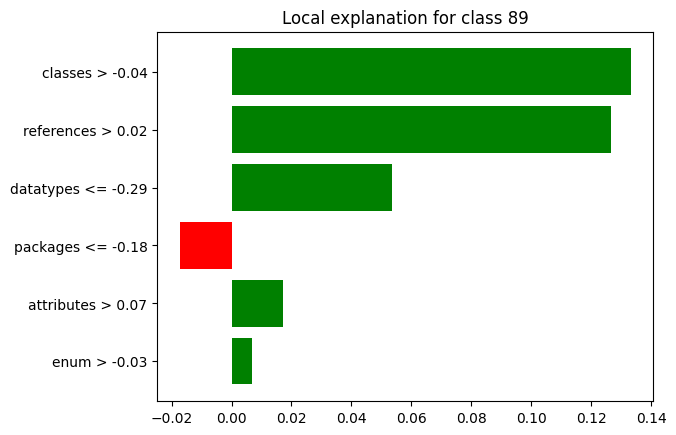

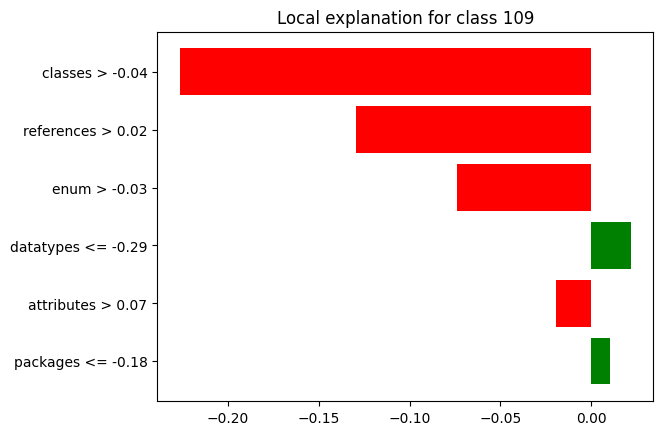

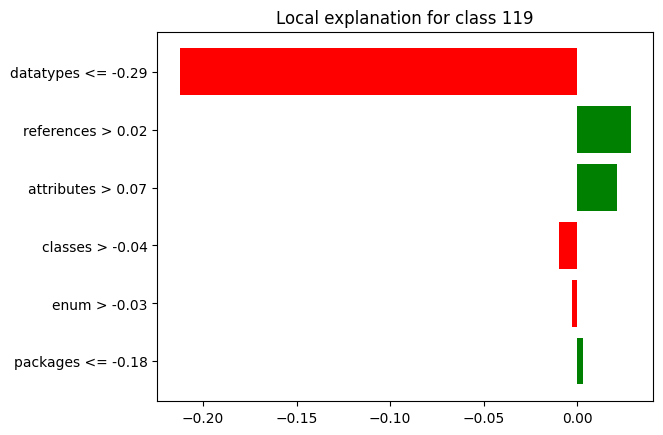

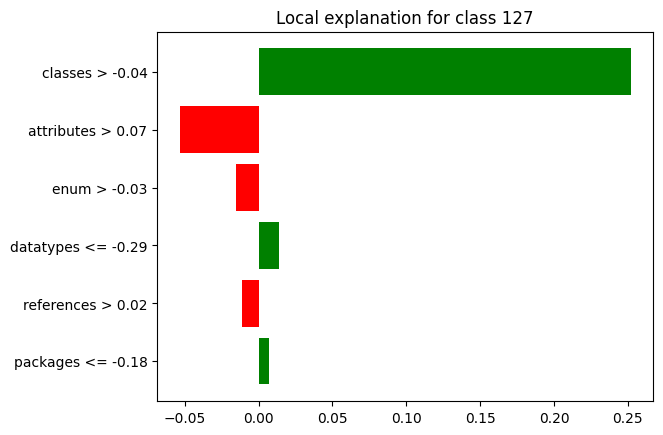

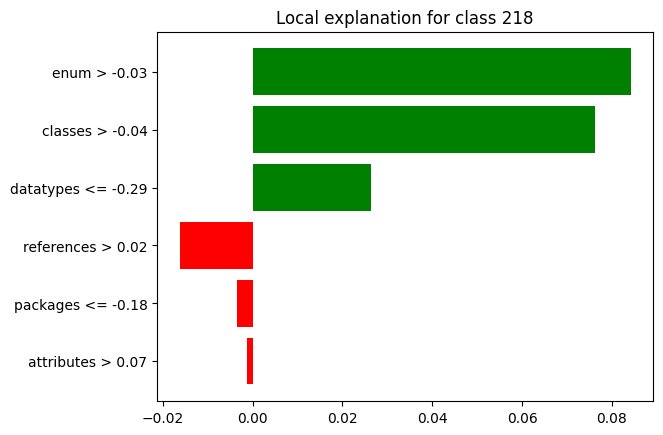

In [ ]:
for i in class_index:
  rf_exp_results['lime_gpl'][i].plot()

In [ ]:
breakdown_df_gpl_gpl, shap_df_gpl_gpl, lime_df_gpl_gpl, df_final_rf_gpl_gpl = preprocess_dfs(breakdown_df_gpl_gpl, shap_df_gpl_gpl, lime_df_gpl_gpl, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_gpl_gpl)
print('----------------------------------------------')
print(shap_df_gpl_gpl)
print('----------------------------------------------')
print(lime_df_gpl_gpl)

['classes', 'packages', 'enum', 'references', 'attributes', 'datatypes']
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Positive
1  attributes        2  Positive
2  references        3  Positive
3   datatypes        4  Positive
4    packages        5  Positive
5        enum        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Positive
1  references        2  Positive
2  attributes        3  Positive
3        enum        4  Positive
4   datatypes        5  Positive
5    packages        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Positive
1  references        2  Positive
2   datatypes        3  Positive
3    packages        4  Negative
4  attributes        5  Positive
5        enum        6  Positive


In [ ]:
df_final_rf_gpl_gpl

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
classes            1  Positive       1  Positive       1  Positive
attributes         2  Positive       3  Positive       5  Positive
references         3  Positive       2  Positive       2  Positive
datatypes          4  Positive       5  Positive       3  Positive
packages           5  Positive       6  Positive       4  Negative
enum               6  Positive       4  Positive       6  Positive

In [ ]:
breakdown_df_gpl_lib, shap_df_gpl_lib, lime_df_gpl_lib, df_final_rf_gpl_lib = preprocess_dfs(breakdown_df_gpl_lib, shap_df_gpl_lib, lime_df_gpl_lib, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_gpl_lib)
print('----------------------------------------------')
print(shap_df_gpl_lib)
print('----------------------------------------------')
print(lime_df_gpl_lib)

['classes', 'enum', 'references', 'attributes', 'datatypes', 'packages']
----------------------------------------------
      Feature  Ranking      Sign
0  references        1  Negative
1  attributes        2  Positive
2     classes        3  Negative
3        enum        4  Negative
4   datatypes        5  Positive
5    packages        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Negative
1  references        2  Negative
2  attributes        3  Positive
3        enum        4  Negative
4    packages        5  Negative
5   datatypes        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Negative
1  references        2  Negative
2        enum        3  Negative
3   datatypes        4  Positive
4  attributes        5  Negative
5    packages        6  Positive


In [ ]:
df_final_rf_gpl_lib

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
references         1  Negative       2  Negative       2  Negative
attributes         2  Positive       3  Positive       5  Negative
classes            3  Negative       1  Negative       1  Negative
enum               4  Negative       4  Negative       3  Negative
datatypes          5  Positive       6  Positive       4  Positive
packages           6  Negative       5  Negative       6  Positive

In [ ]:
breakdown_df_gpl_meta, shap_df_gpl_meta, lime_df_gpl_meta, df_final_rf_gpl_meta = preprocess_dfs(breakdown_df_gpl_meta, shap_df_gpl_meta, lime_df_gpl_meta, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_gpl_meta)
print('----------------------------------------------')
print(shap_df_gpl_meta)
print('----------------------------------------------')
print(lime_df_gpl_meta)

['classes', 'enum', 'references', 'attributes', 'datatypes', 'packages']
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Negative
1  references        2  Positive
2   datatypes        3  Negative
3  attributes        4  Positive
4        enum        5  Negative
5    packages        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Negative
1   datatypes        2  Negative
2  references        3  Positive
3        enum        4  Negative
4  attributes        5  Positive
5    packages        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0   datatypes        1  Negative
1  references        2  Positive
2  attributes        3  Positive
3     classes        4  Negative
4        enum        5  Negative
5    packages        6  Positive


In [ ]:
df_final_rf_gpl_meta

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
classes            1  Negative       1  Negative       4  Negative
references         2  Positive       3  Positive       2  Positive
datatypes          3  Negative       2  Negative       1  Negative
attributes         4  Positive       5  Positive       3  Positive
enum               5  Negative       4  Negative       5  Negative
packages           6  Positive       6  Positive       6  Positive

In [ ]:
breakdown_df_gpl_mod, shap_df_gpl_mod, lime_df_gpl_mod, df_final_rf_gpl_mod = preprocess_dfs(breakdown_df_gpl_mod, shap_df_gpl_mod, lime_df_gpl_mod, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_gpl_mod)
print('----------------------------------------------')
print(shap_df_gpl_mod)
print('----------------------------------------------')
print(lime_df_gpl_mod)

['classes', 'packages', 'enum', 'references', 'attributes', 'datatypes']
----------------------------------------------
      Feature  Ranking      Sign
0  references        1  Negative
1     classes        2  Positive
2  attributes        3  Negative
3        enum        4  Positive
4    packages        5  Negative
5   datatypes        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0  references        1  Negative
1     classes        2  Positive
2  attributes        3  Negative
3        enum        4  Negative
4   datatypes        5  Negative
5    packages        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Positive
1  attributes        2  Negative
2        enum        3  Negative
3   datatypes        4  Positive
4  references        5  Negative
5    packages        6  Positive


In [ ]:
df_final_rf_gpl_mod

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
references         1  Negative       1  Negative       5  Negative
classes            2  Positive       2  Positive       1  Positive
attributes         3  Negative       3  Negative       2  Negative
enum               4  Positive       4  Negative       3  Negative
packages           5  Negative       6  Negative       6  Positive
datatypes          6  Positive       5  Negative       4  Positive

In [ ]:
breakdown_df_gpl_wf, shap_df_gpl_wf, lime_df_gpl_wf, df_final_rf_gpl_wf = preprocess_dfs(breakdown_df_gpl_wf, shap_df_gpl_wf, lime_df_gpl_wf, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_gpl_wf)
print('----------------------------------------------')
print(shap_df_gpl_wf)
print('----------------------------------------------')
print(lime_df_gpl_wf)

['classes', 'enum', 'references', 'attributes', 'datatypes', 'packages']
----------------------------------------------
      Feature  Ranking      Sign
0  attributes        1  Negative
1  references        2  Negative
2     classes        3  Positive
3        enum        4  Positive
4   datatypes        5  Negative
5    packages        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0  attributes        1  Negative
1  references        2  Negative
2        enum        3  Positive
3     classes        4  Positive
4   datatypes        5  Negative
5    packages        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0        enum        1  Positive
1     classes        2  Positive
2   datatypes        3  Positive
3  references        4  Negative
4    packages        5  Negative
5  attributes        6  Negative


In [ ]:
df_final_rf_gpl_wf

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
attributes         1  Negative       1  Negative       6  Negative
references         2  Negative       2  Negative       4  Negative
classes            3  Positive       4  Positive       2  Positive
enum               4  Positive       3  Positive       1  Positive
datatypes          5  Negative       5  Negative       3  Positive
packages           6  Positive       6  Negative       5  Negative

### **RESULTS GPL:**



In [ ]:
df_topfeatures_gpl_gpl = top3_features(df_final_rf_gpl_gpl, 'GPL - Class: GPL')
df_topfeatures_gpl_lib = top3_features(df_final_rf_gpl_lib, 'GPL - Class: Library')
df_topfeatures_gpl_meta = top3_features(df_final_rf_gpl_meta, 'GPL - Class: Metamodelling')
df_topfeatures_gpl_mod = top3_features(df_final_rf_gpl_mod, 'GPL - Class: Modelling')
df_topfeatures_gpl_wf = top3_features(df_final_rf_gpl_wf, 'GPL - Class: Workflow')

df_topfeatures_gpl_rf = pd.concat([df_topfeatures_gpl_gpl, df_topfeatures_gpl_lib, df_topfeatures_gpl_meta, df_topfeatures_gpl_mod, df_topfeatures_gpl_wf])
df_topfeatures_gpl_rf

TOP3 Breakdown  \
GPL - Class: GPL            attributes, classes, references   
GPL - Class: Library        attributes, classes, references   
GPL - Class: Metamodelling   datatypes, classes, references   
GPL - Class: Modelling      attributes, classes, references   
GPL - Class: Workflow       attributes, classes, references   

                                                  TOP3 Shap  \
GPL - Class: GPL            attributes, classes, references   
GPL - Class: Library        attributes, classes, references   
GPL - Class: Metamodelling   datatypes, classes, references   
GPL - Class: Modelling      attributes, classes, references   
GPL - Class: Workflow          attributes, enum, references   

                                                    TOP3 Lime  Breakdown-Shap  \
GPL - Class: GPL               datatypes, classes, references        1.000000   
GPL - Class: Library                enum, classes, references        1.000000   
GPL - Class: Metamodelling  attributes, datatypes, references        1.000000   
GPL - Class: Modelling              attributes, enum, classes        1.000000   
GPL - Class: Workflow                datatypes, enum, classes        0.666667   

                            Breakdown-Lime  Lime-Shap  
GPL - Class: GPL                  0.666667   0.666667  
GPL - Class: Library              0.666667   0.666667  
GPL - Class: Metamodelling        0.666667   0.666667  
GPL - Class: Modelling            0.666667   0.666667  
GPL - Class: Workflow             0.333333   0.333333

In [ ]:
df_topfeatures_gpl_gpl_rank = top3_rank(df_final_rf_gpl_gpl, 'GPL - Class GPL')
df_topfeatures_gpl_lib_rank = top3_rank(df_final_rf_gpl_lib, 'GPL - Class Library')
df_topfeatures_gpl_meta_rank = top3_rank(df_final_rf_gpl_meta, 'GPL - Class Metamodelling')
df_topfeatures_gpl_mod_rank = top3_rank(df_final_rf_gpl_mod, 'GPL - Class Modelling')
df_topfeatures_gpl_wf_rank = top3_rank(df_final_rf_gpl_wf, 'GPL - Class Workflow')

df_topfeatures_rank_gpl_rf = pd.concat([df_topfeatures_gpl_gpl_rank, df_topfeatures_gpl_lib_rank, df_topfeatures_gpl_meta_rank, df_topfeatures_gpl_mod_rank, df_topfeatures_gpl_wf_rank])
df_topfeatures_rank_gpl_rf

TOP3 Breakdown  \
GPL - Class GPL            1:classes, 2:attributes, 3:references   
GPL - Class Library        1:references, 2:attributes, 3:classes   
GPL - Class Metamodelling   1:classes, 2:references, 3:datatypes   
GPL - Class Modelling      1:references, 2:classes, 3:attributes   
GPL - Class Workflow       1:attributes, 2:references, 3:classes   

                                                       TOP3 Shap  \
GPL - Class GPL            1:classes, 3:attributes, 2:references   
GPL - Class Library        2:references, 3:attributes, 1:classes   
GPL - Class Metamodelling   1:classes, 3:references, 2:datatypes   
GPL - Class Modelling      1:references, 2:classes, 3:attributes   
GPL - Class Workflow          1:attributes, 2:references, 3:enum   

                                                         TOP3 Lime  \
GPL - Class GPL               1:classes, 2:references, 3:datatypes   
GPL - Class Library                2:references, 1:classes, 3:enum   
GPL - Class Metamodelling  2:references, 1:datatypes, 3:attributes   
GPL - Class Modelling              1:classes, 2:attributes, 3:enum   
GPL - Class Workflow                2:classes, 1:enum, 3:datatypes   

                           Breakdown-Shap  Breakdown-Lime  Lime-Shap  
GPL - Class GPL                  0.333333        0.333333   0.666667  
GPL - Class Library              0.000000        0.000000   0.666667  
GPL - Class Metamodelling        0.333333        0.333333   0.000000  
GPL - Class Modelling            1.000000        0.000000   0.000000  
GPL - Class Workflow             0.666667        0.000000   0.000000

In [ ]:
df_topfeatures_gpl_gpl_sign = top3_sign(df_final_rf_gpl_gpl, 'GPL - Class GPL')
df_topfeatures_gpl_lib_sign = top3_sign(df_final_rf_gpl_lib, 'GPL - Class Library')
df_topfeatures_gpl_meta_sign = top3_sign(df_final_rf_gpl_meta, 'GPL - Class Metamodelling')
df_topfeatures_gpl_mod_sign = top3_sign(df_final_rf_gpl_mod, 'GPL - Class Modelling')
df_topfeatures_gpl_wf_sign = top3_sign(df_final_rf_gpl_wf, 'GPL - Class Workflow')

df_topfeatures_sign_gpl_rf = pd.concat([df_topfeatures_gpl_gpl_sign, df_topfeatures_gpl_lib_sign, df_topfeatures_gpl_meta_sign, df_topfeatures_gpl_mod_sign, df_topfeatures_gpl_wf_sign])
df_topfeatures_sign_gpl_rf

TOP3 Breakdown  \
GPL - Class GPL            classes:Positive, attributes:Positive, referen...   
GPL - Class Library        references:Negative, attributes:Positive, clas...   
GPL - Class Metamodelling  classes:Negative, references:Positive, datatyp...   
GPL - Class Modelling      references:Negative, classes:Positive, attribu...   
GPL - Class Workflow       attributes:Negative, references:Negative, clas...   

                                                                   TOP3 Shap  \
GPL - Class GPL            classes:Positive, attributes:Positive, referen...   
GPL - Class Library        references:Negative, attributes:Positive, clas...   
GPL - Class Metamodelling  classes:Negative, references:Positive, datatyp...   
GPL - Class Modelling      references:Negative, classes:Positive, attribu...   
GPL - Class Workflow       attributes:Negative, references:Negative, enum...   

                                                                   TOP3 Lime  \
GPL - Class GPL            classes:Positive, references:Positive, datatyp...   
GPL - Class Library        references:Negative, classes:Negative, enum:Ne...   
GPL - Class Metamodelling  references:Positive, datatypes:Negative, attri...   
GPL - Class Modelling      classes:Positive, attributes:Negative, enum:Ne...   
GPL - Class Workflow       classes:Positive, enum:Positive, datatypes:Pos...   

                           Breakdown-Shap  Breakdown-Lime  Lime-Shap  
GPL - Class GPL                  1.000000        0.666667   0.666667  
GPL - Class Library              1.000000        0.666667   0.666667  
GPL - Class Metamodelling        1.000000        0.666667   0.666667  
GPL - Class Modelling            1.000000        0.666667   0.666667  
GPL - Class Workflow             0.666667        0.333333   0.333333

In [ ]:
df_topfeatures_gpl_gpl_rank_sign = top3_rank_sign(df_final_rf_gpl_gpl, 'GPL - Class GPL')
df_topfeatures_gpl_lib_rank_sign = top3_rank_sign(df_final_rf_gpl_lib, 'GPL - Class Library')
df_topfeatures_gpl_meta_rank_sign = top3_rank_sign(df_final_rf_gpl_meta, 'GPL - Class Metamodelling')
df_topfeatures_gpl_mod_rank_sign = top3_rank_sign(df_final_rf_gpl_mod, 'GPL - Class Modelling')
df_topfeatures_gpl_wf_rank_sign = top3_rank_sign(df_final_rf_gpl_wf, 'GPL - Class Workflow')

df_topfeatures_rank_sign_gpl_rf = pd.concat([df_topfeatures_gpl_gpl_rank_sign, df_topfeatures_gpl_lib_rank_sign, df_topfeatures_gpl_meta_rank_sign, df_topfeatures_gpl_mod_rank_sign, df_topfeatures_gpl_wf_rank_sign])
df_topfeatures_rank_sign_gpl_rf

TOP3 Breakdown  \
GPL - Class GPL            1:classes:Positive, 2:attributes:Positive, 3:r...   
GPL - Class Library        1:references:Negative, 2:attributes:Positive, ...   
GPL - Class Metamodelling  1:classes:Negative, 2:references:Positive, 3:d...   
GPL - Class Modelling      1:references:Negative, 2:classes:Positive, 3:a...   
GPL - Class Workflow       1:attributes:Negative, 2:references:Negative, ...   

                                                                   TOP3 Shap  \
GPL - Class GPL            1:classes:Positive, 3:attributes:Positive, 2:r...   
GPL - Class Library        2:references:Negative, 3:attributes:Positive, ...   
GPL - Class Metamodelling  1:classes:Negative, 3:references:Positive, 2:d...   
GPL - Class Modelling      1:references:Negative, 2:classes:Positive, 3:a...   
GPL - Class Workflow       1:attributes:Negative, 2:references:Negative, ...   

                                                                   TOP3 Lime  \
GPL - Class GPL            1:classes:Positive, 2:references:Positive, 3:d...   
GPL - Class Library        2:references:Negative, 1:classes:Negative, 3:e...   
GPL - Class Metamodelling  2:references:Positive, 1:datatypes:Negative, 3...   
GPL - Class Modelling      1:classes:Positive, 2:attributes:Negative, 3:e...   
GPL - Class Workflow       2:classes:Positive, 1:enum:Positive, 3:datatyp...   

                           Breakdown-Shap  Breakdown-Lime  Lime-Shap  
GPL - Class GPL                  0.333333        0.333333   0.666667  
GPL - Class Library              0.000000        0.000000   0.666667  
GPL - Class Metamodelling        0.333333        0.333333   0.000000  
GPL - Class Modelling            1.000000        0.000000   0.000000  
GPL - Class Workflow             0.666667        0.000000   0.000000

### **LIBRARY:**

In [ ]:
breakdown_df_library_gpl = rf_exp_results['breakdown_library'][1].result
shap_df_library_gpl = rf_exp_results['shap_library'][1].result
lime_df_library_gpl = rf_exp_results['lime_library'][1].result

In [ ]:
breakdown_df_library_lib = rf_exp_results['breakdown_library'][2].result
shap_df_library_lib = rf_exp_results['shap_library'][2].result
lime_df_library_lib = rf_exp_results['lime_library'][2].result

In [ ]:
breakdown_df_library_meta = rf_exp_results['breakdown_library'][3].result
shap_df_library_meta = rf_exp_results['shap_library'][3].result
lime_df_library_meta = rf_exp_results['lime_library'][3].result

In [ ]:
breakdown_df_library_mod = rf_exp_results['breakdown_library'][4].result
shap_df_library_mod = rf_exp_results['shap_library'][4].result
lime_df_library_mod = rf_exp_results['lime_library'][4].result

In [ ]:
breakdown_df_library_wf = rf_exp_results['breakdown_library'][9].result
shap_df_library_wf = rf_exp_results['shap_library'][9].result
lime_df_library_wf = rf_exp_results['lime_library'][9].result

In [ ]:
exp_plots_bd = [rf_exp_results['breakdown_library'][i] for i in class_index]
exp_plots_bd[0].plot(exp_plots_bd[1:])

In [ ]:
exp_plots_shap = [rf_exp_results['shap_library'][i] for i in class_index]
exp_plots_shap[0].plot(exp_plots_shap[1:])

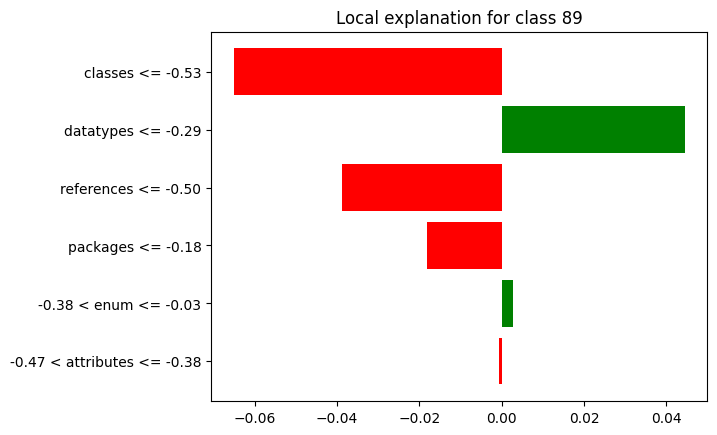

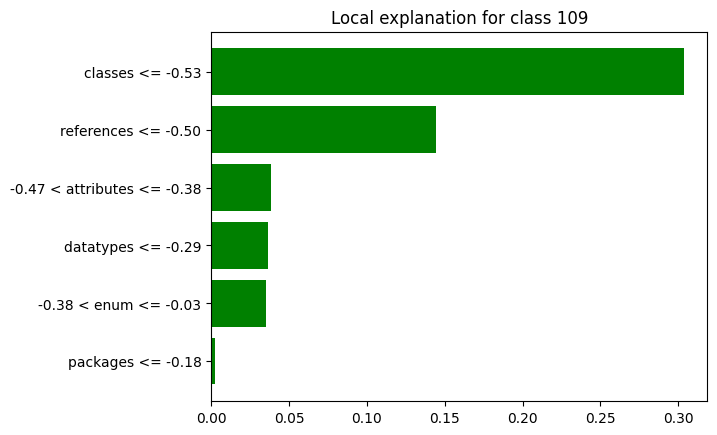

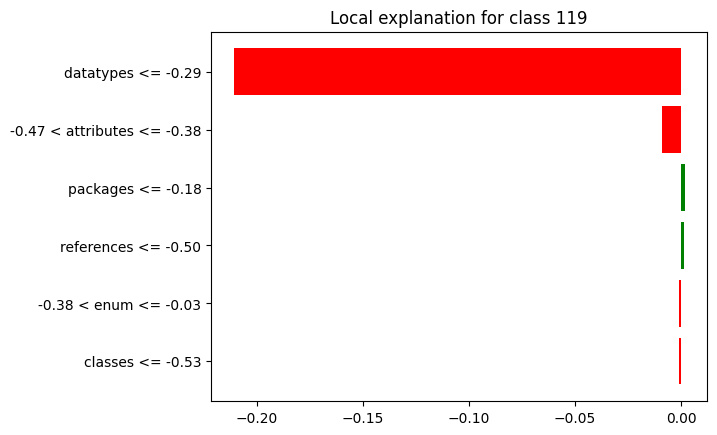

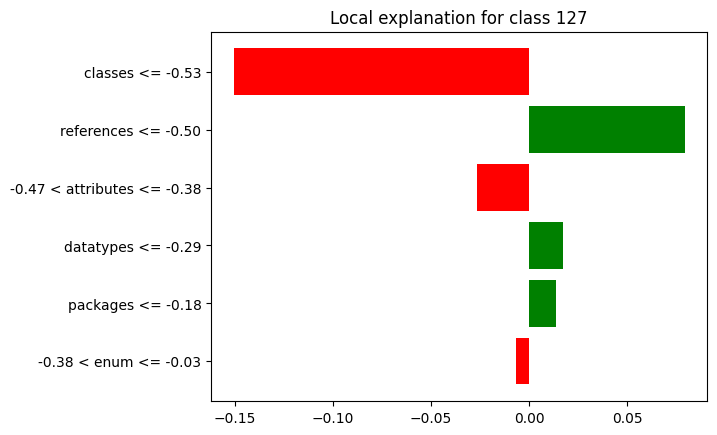

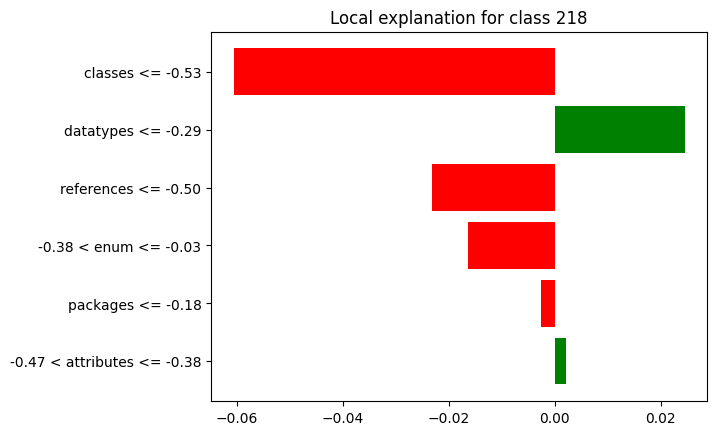

In [ ]:
for i in class_index:
  rf_exp_results['lime_library'][i].plot()

In [ ]:
breakdown_df_library_gpl, shap_df_library_gpl, lime_df_library_gpl, df_final_rf_lib_gpl = preprocess_dfs(breakdown_df_library_gpl, shap_df_library_gpl, lime_df_library_gpl, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_library_gpl)
print('----------------------------------------------')
print(shap_df_library_gpl)
print('----------------------------------------------')
print(lime_df_library_gpl)

['classes', 'enum', 'references', 'attributes', 'datatypes', 'packages']
----------------------------------------------
      Feature  Ranking      Sign
0  references        1  Negative
1     classes        2  Negative
2  attributes        3  Negative
3        enum        4  Positive
4   datatypes        5  Positive
5    packages        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Negative
1  references        2  Negative
2  attributes        3  Negative
3   datatypes        4  Positive
4        enum        5  Positive
5    packages        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Negative
1   datatypes        2  Positive
2  references        3  Negative
3    packages        4  Negative
4        enum        5  Positive
5  attributes        6  Negative


In [ ]:
df_final_rf_lib_gpl

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
references         1  Negative       2  Negative       3  Negative
classes            2  Negative       1  Negative       1  Negative
attributes         3  Negative       3  Negative       6  Negative
enum               4  Positive       5  Positive       5  Positive
datatypes          5  Positive       4  Positive       2  Positive
packages           6  Positive       6  Negative       4  Negative

In [ ]:
breakdown_df_library_lib, shap_df_library_lib, lime_df_library_lib, df_final_rf_lib_lib = preprocess_dfs(breakdown_df_library_lib, shap_df_library_lib, lime_df_library_lib, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_library_lib)
print('----------------------------------------------')
print(shap_df_library_lib)
print('----------------------------------------------')
print(lime_df_library_lib)

['classes', 'enum', 'references', 'attributes', 'datatypes', 'packages']
----------------------------------------------
      Feature  Ranking      Sign
0  references        1  Positive
1        enum        2  Positive
2     classes        3  Positive
3  attributes        4  Positive
4   datatypes        5  Positive
5    packages        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Positive
1  references        2  Positive
2        enum        3  Positive
3  attributes        4  Positive
4   datatypes        5  Positive
5    packages        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Positive
1  references        2  Positive
2  attributes        3  Positive
3   datatypes        4  Positive
4        enum        5  Positive
5    packages        6  Positive


In [ ]:
df_final_rf_lib_lib

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
references         1  Positive       2  Positive       2  Positive
enum               2  Positive       3  Positive       5  Positive
classes            3  Positive       1  Positive       1  Positive
attributes         4  Positive       4  Positive       3  Positive
datatypes          5  Positive       5  Positive       4  Positive
packages           6  Positive       6  Negative       6  Positive

In [ ]:
breakdown_df_library_meta, shap_df_library_meta, lime_df_library_meta, df_final_rf_lib_meta = preprocess_dfs(breakdown_df_library_meta, shap_df_library_meta, lime_df_library_meta, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_library_meta)
print('----------------------------------------------')
print(shap_df_library_meta)
print('----------------------------------------------')
print(lime_df_library_meta)

['classes', 'enum', 'references', 'attributes', 'datatypes', 'packages']
----------------------------------------------
      Feature  Ranking      Sign
0   datatypes        1  Negative
1        enum        2  Negative
2  attributes        3  Negative
3  references        4  Negative
4     classes        5  Negative
5    packages        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0   datatypes        1  Negative
1        enum        2  Negative
2  references        3  Negative
3  attributes        4  Negative
4     classes        5  Negative
5    packages        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0   datatypes        1  Negative
1  attributes        2  Negative
2    packages        3  Positive
3  references        4  Positive
4        enum        5  Negative
5     classes        6  Negative


In [ ]:
df_final_rf_lib_meta

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
datatypes          1  Negative       1  Negative       1  Negative
enum               2  Negative       2  Negative       5  Negative
attributes         3  Negative       4  Negative       2  Negative
references         4  Negative       3  Negative       4  Positive
classes            5  Negative       5  Negative       6  Negative
packages           6  Negative       6  Positive       3  Positive

In [ ]:
breakdown_df_library_mod, shap_df_library_mod, lime_df_library_mod, df_final_rf_lib_mod = preprocess_dfs(breakdown_df_library_mod, shap_df_library_mod, lime_df_library_mod, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_library_mod)
print('----------------------------------------------')
print(shap_df_library_mod)
print('----------------------------------------------')
print(lime_df_library_mod)

['classes', 'enum', 'references', 'attributes', 'datatypes', 'packages']
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Negative
1  references        2  Positive
2   datatypes        3  Positive
3  attributes        4  Negative
4        enum        5  Negative
5    packages        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Negative
1  references        2  Positive
2  attributes        3  Negative
3   datatypes        4  Positive
4        enum        5  Positive
5    packages        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Negative
1  references        2  Positive
2  attributes        3  Negative
3   datatypes        4  Positive
4    packages        5  Positive
5        enum        6  Negative


In [ ]:
df_final_rf_lib_mod

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
classes            1  Negative       1  Negative       1  Negative
references         2  Positive       2  Positive       2  Positive
datatypes          3  Positive       4  Positive       4  Positive
attributes         4  Negative       3  Negative       3  Negative
enum               5  Negative       5  Positive       6  Negative
packages           6  Positive       6  Negative       5  Positive

In [ ]:
breakdown_df_library_wf, shap_df_library_wf, lime_df_library_wf, df_final_rf_lib_wf = preprocess_dfs(breakdown_df_library_wf, shap_df_library_wf, lime_df_library_wf, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_library_wf)
print('----------------------------------------------')
print(shap_df_library_wf)
print('----------------------------------------------')
print(lime_df_library_wf)

['classes', 'packages', 'enum', 'references', 'attributes', 'datatypes']
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Negative
1  attributes        2  Negative
2        enum        3  Positive
3   datatypes        4  Positive
4    packages        5  Negative
5  references        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Negative
1  references        2  Negative
2  attributes        3  Negative
3        enum        4  Positive
4   datatypes        5  Positive
5    packages        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Negative
1   datatypes        2  Positive
2  references        3  Negative
3        enum        4  Negative
4    packages        5  Negative
5  attributes        6  Positive


In [ ]:
df_final_rf_lib_wf

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
classes            1  Negative       1  Negative       1  Negative
attributes         2  Negative       3  Negative       6  Positive
enum               3  Positive       4  Positive       4  Negative
datatypes          4  Positive       5  Positive       2  Positive
packages           5  Negative       6  Positive       5  Negative
references         6  Positive       2  Negative       3  Negative

### **RESULTS LIBRARY:**

In [ ]:
df_topfeatures_lib_gpl = top3_features(df_final_rf_lib_gpl, 'Library - Class: GPL')
df_topfeatures_lib_lib = top3_features(df_final_rf_lib_lib, 'Library - Class: Library')
df_topfeatures_lib_meta = top3_features(df_final_rf_lib_meta, 'Library - Class: Metamodelling')
df_topfeatures_lib_mod = top3_features(df_final_rf_lib_mod, 'Library - Class: Modelling')
df_topfeatures_lib_wf = top3_features(df_final_rf_lib_wf, 'Library - Class: Workflow')

df_topfeatures_library_rf = pd.concat([df_topfeatures_lib_gpl, df_topfeatures_lib_lib, df_topfeatures_lib_meta, df_topfeatures_lib_mod, df_topfeatures_lib_wf])
df_topfeatures_library_rf

TOP3 Breakdown  \
Library - Class: GPL            attributes, classes, references   
Library - Class: Library              enum, classes, references   
Library - Class: Metamodelling      attributes, enum, datatypes   
Library - Class: Modelling       datatypes, classes, references   
Library - Class: Workflow             attributes, enum, classes   

                                                      TOP3 Shap  \
Library - Class: GPL            attributes, classes, references   
Library - Class: Library              enum, classes, references   
Library - Class: Metamodelling      enum, datatypes, references   
Library - Class: Modelling      attributes, classes, references   
Library - Class: Workflow       attributes, classes, references   

                                                      TOP3 Lime  \
Library - Class: GPL             datatypes, classes, references   
Library - Class: Library        attributes, classes, references   
Library - Class: Metamodelling  attributes, datatypes, packages   
Library - Class: Modelling      attributes, classes, references   
Library - Class: Workflow        datatypes, classes, references   

                                Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Library - Class: GPL                  1.000000        0.666667   0.666667  
Library - Class: Library              1.000000        0.666667   0.666667  
Library - Class: Metamodelling        0.666667        0.666667   0.333333  
Library - Class: Modelling            0.666667        0.666667   1.000000  
Library - Class: Workflow             0.666667        0.333333   0.666667

In [ ]:
df_topfeatures_lib_gpl_rank = top3_rank(df_final_rf_lib_gpl, 'Library - Class GPL')
df_topfeatures_lib_lib_rank = top3_rank(df_final_rf_lib_lib, 'Library - Class Library')
df_topfeatures_lib_meta_rank = top3_rank(df_final_rf_lib_meta, 'Library - Class Metamodelling')
df_topfeatures_lib_mod_rank = top3_rank(df_final_rf_lib_mod, 'Library - Class Modelling')
df_topfeatures_lib_wf_rank = top3_rank(df_final_rf_lib_wf, 'Library - Class Workflow')

df_topfeatures_rank_library_rf = pd.concat([df_topfeatures_lib_gpl_rank, df_topfeatures_lib_lib_rank, df_topfeatures_lib_meta_rank, df_topfeatures_lib_mod_rank, df_topfeatures_lib_wf_rank])
df_topfeatures_rank_library_rf

TOP3 Breakdown  \
Library - Class GPL            1:references, 2:classes, 3:attributes   
Library - Class Library              1:references, 2:enum, 3:classes   
Library - Class Metamodelling      1:datatypes, 2:enum, 3:attributes   
Library - Class Modelling       1:classes, 2:references, 3:datatypes   
Library - Class Workflow             1:classes, 2:attributes, 3:enum   

                                                           TOP3 Shap  \
Library - Class GPL            2:references, 1:classes, 3:attributes   
Library - Class Library              2:references, 3:enum, 1:classes   
Library - Class Metamodelling      1:datatypes, 2:enum, 3:references   
Library - Class Modelling      1:classes, 2:references, 3:attributes   
Library - Class Workflow       1:classes, 3:attributes, 2:references   

                                                           TOP3 Lime  \
Library - Class GPL             3:references, 1:classes, 2:datatypes   
Library - Class Library        2:references, 1:classes, 3:attributes   
Library - Class Metamodelling  1:datatypes, 2:attributes, 3:packages   
Library - Class Modelling      1:classes, 2:references, 3:attributes   
Library - Class Workflow        1:classes, 2:datatypes, 3:references   

                               Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Library - Class GPL                  0.333333        0.000000   0.333333  
Library - Class Library              0.000000        0.000000   0.666667  
Library - Class Metamodelling        0.666667        0.333333   0.333333  
Library - Class Modelling            0.666667        0.666667   1.000000  
Library - Class Workflow             0.333333        0.333333   0.333333

In [ ]:
df_topfeatures_lib_gpl_sign = top3_sign(df_final_rf_lib_gpl, 'Library - Class GPL')
df_topfeatures_lib_lib_sign = top3_sign(df_final_rf_lib_lib, 'Library - Class Library')
df_topfeatures_lib_meta_sign = top3_sign(df_final_rf_lib_meta, 'Library - Class Metamodelling')
df_topfeatures_lib_mod_sign = top3_sign(df_final_rf_lib_mod, 'Library - Class Modelling')
df_topfeatures_lib_wf_sign = top3_sign(df_final_rf_lib_wf, 'Library - Class Workflow')

df_topfeatures_sign_library_rf = pd.concat([df_topfeatures_lib_gpl_sign, df_topfeatures_lib_lib_sign, df_topfeatures_lib_meta_sign, df_topfeatures_lib_mod_sign, df_topfeatures_lib_wf_sign])
df_topfeatures_sign_library_rf

TOP3 Breakdown  \
Library - Class GPL            references:Negative, classes:Negative, attribu...   
Library - Class Library        references:Positive, enum:Positive, classes:Po...   
Library - Class Metamodelling  datatypes:Negative, enum:Negative, attributes:...   
Library - Class Modelling      classes:Negative, references:Positive, datatyp...   
Library - Class Workflow       classes:Negative, attributes:Negative, enum:Po...   

                                                                       TOP3 Shap  \
Library - Class GPL            references:Negative, classes:Negative, attribu...   
Library - Class Library        references:Positive, enum:Positive, classes:Po...   
Library - Class Metamodelling  datatypes:Negative, enum:Negative, references:...   
Library - Class Modelling      classes:Negative, references:Positive, attribu...   
Library - Class Workflow       classes:Negative, attributes:Negative, referen...   

                                                                       TOP3 Lime  \
Library - Class GPL            references:Negative, classes:Negative, datatyp...   
Library - Class Library        references:Positive, classes:Positive, attribu...   
Library - Class Metamodelling  datatypes:Negative, attributes:Negative, packa...   
Library - Class Modelling      classes:Negative, references:Positive, attribu...   
Library - Class Workflow       classes:Negative, datatypes:Positive, referenc...   

                               Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Library - Class GPL                  1.000000        0.666667   0.666667  
Library - Class Library              1.000000        0.666667   0.666667  
Library - Class Metamodelling        0.666667        0.666667   0.333333  
Library - Class Modelling            0.666667        0.666667   1.000000  
Library - Class Workflow             0.666667        0.333333   0.666667

In [ ]:
df_topfeatures_lib_gpl_rank_sign = top3_rank_sign(df_final_rf_lib_gpl, 'Library - Class GPL')
df_topfeatures_lib_lib_rank_sign = top3_rank_sign(df_final_rf_lib_lib, 'Library - Class Library')
df_topfeatures_lib_meta_rank_sign = top3_rank_sign(df_final_rf_lib_meta, 'Library - Class Metamodelling')
df_topfeatures_lib_mod_rank_sign = top3_rank_sign(df_final_rf_lib_mod, 'Library - Class Modelling')
df_topfeatures_lib_wf_rank_sign = top3_rank_sign(df_final_rf_lib_wf, 'Library - Class Workflow')

df_topfeatures_rank_sign_library_rf = pd.concat([df_topfeatures_lib_gpl_rank_sign, df_topfeatures_lib_lib_rank_sign, df_topfeatures_lib_meta_rank_sign, df_topfeatures_lib_mod_rank_sign, df_topfeatures_lib_wf_rank_sign])
df_topfeatures_rank_sign_library_rf

TOP3 Breakdown  \
Library - Class GPL            1:references:Negative, 2:classes:Negative, 3:a...   
Library - Class Library        1:references:Positive, 2:enum:Positive, 3:clas...   
Library - Class Metamodelling  1:datatypes:Negative, 2:enum:Negative, 3:attri...   
Library - Class Modelling      1:classes:Negative, 2:references:Positive, 3:d...   
Library - Class Workflow       1:classes:Negative, 2:attributes:Negative, 3:e...   

                                                                       TOP3 Shap  \
Library - Class GPL            2:references:Negative, 1:classes:Negative, 3:a...   
Library - Class Library        2:references:Positive, 3:enum:Positive, 1:clas...   
Library - Class Metamodelling  1:datatypes:Negative, 2:enum:Negative, 3:refer...   
Library - Class Modelling      1:classes:Negative, 2:references:Positive, 3:a...   
Library - Class Workflow       1:classes:Negative, 3:attributes:Negative, 2:r...   

                                                                       TOP3 Lime  \
Library - Class GPL            3:references:Negative, 1:classes:Negative, 2:d...   
Library - Class Library        2:references:Positive, 1:classes:Positive, 3:a...   
Library - Class Metamodelling  1:datatypes:Negative, 2:attributes:Negative, 3...   
Library - Class Modelling      1:classes:Negative, 2:references:Positive, 3:a...   
Library - Class Workflow       1:classes:Negative, 2:datatypes:Positive, 3:re...   

                               Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Library - Class GPL                  0.333333        0.000000   0.333333  
Library - Class Library              0.000000        0.000000   0.666667  
Library - Class Metamodelling        0.666667        0.333333   0.333333  
Library - Class Modelling            0.666667        0.666667   1.000000  
Library - Class Workflow             0.333333        0.333333   0.333333

## KNN:

In [ ]:
exp_list_knn = []

for i in range(len(unique_values)):
    class_value = unique_values[i]
    pf = lambda m, d, i=i: m.predict_proba(d)[:, i]
    e = dx.Explainer(
        model_knn, X_train,
        y_train,
        predict_function=pf,
        label=f'KNNClassifier: class {class_value}',
        verbose=False
    )
    exp_list_knn += [e]

exp_list_knn

In [ ]:
inst_metamodelling = X_test.loc[inst_meta_knn]
inst_modelling = X_test.loc[inst_mod_knn]
inst_workflow = X_test.loc[inst_wf_knn]
inst_gpl = X_test.loc[inst_gpl_knn]
inst_library = X_test.loc[inst_lib_knn]

In [ ]:
knn_exp_results = {}

for instance in inst_names:
    breakdown_exp = [exp.predict_parts(eval(f"inst_{instance}"), type='break_down', random_state=42) for exp in exp_list_knn]
    knn_exp_results[f"breakdown_{instance}"] = breakdown_exp

    shap_exp = [exp.predict_parts(eval(f"inst_{instance}"), type='shap', random_state=42) for exp in exp_list_knn]
    knn_exp_results[f"shap_{instance}"] = shap_exp

    lime_exp = [exp.predict_surrogate(eval(f"inst_{instance}"), random_state=42, class_names=[0, unique_values[i]]) for i, exp in enumerate(exp_list_knn)]
    knn_exp_results[f"lime_{instance}"] = lime_exp

### **METAMODELLING:**

In [ ]:
breakdown_df_metamodelling_gpl = knn_exp_results['breakdown_metamodelling'][1].result
shap_df_metamodelling_gpl = knn_exp_results['shap_metamodelling'][1].result
lime_df_metamodelling_gpl = knn_exp_results['lime_metamodelling'][1].result

In [ ]:
breakdown_df_metamodelling_lib = knn_exp_results['breakdown_metamodelling'][2].result
shap_df_metamodelling_lib = knn_exp_results['shap_metamodelling'][2].result
lime_df_metamodelling_lib = knn_exp_results['lime_metamodelling'][2].result

In [ ]:
breakdown_df_metamodelling_meta = knn_exp_results['breakdown_metamodelling'][3].result
shap_df_metamodelling_meta = knn_exp_results['shap_metamodelling'][3].result
lime_df_metamodelling_meta = knn_exp_results['lime_metamodelling'][3].result

In [ ]:
breakdown_df_metamodelling_mod = knn_exp_results['breakdown_metamodelling'][4].result
shap_df_metamodelling_mod = knn_exp_results['shap_metamodelling'][4].result
lime_df_metamodelling_mod = knn_exp_results['lime_metamodelling'][4].result

In [ ]:
breakdown_df_metamodelling_wf = knn_exp_results['breakdown_metamodelling'][9].result
shap_df_metamodelling_wf = knn_exp_results['shap_metamodelling'][9].result
lime_df_metamodelling_wf = knn_exp_results['lime_metamodelling'][9].result

In [ ]:
exp_plots_bd = [knn_exp_results['breakdown_metamodelling'][i] for i in class_index]
exp_plots_bd[0].plot(exp_plots_bd[1:])

In [ ]:
exp_plots_shap = [knn_exp_results['shap_metamodelling'][i] for i in class_index]
exp_plots_shap[0].plot(exp_plots_shap[1:])

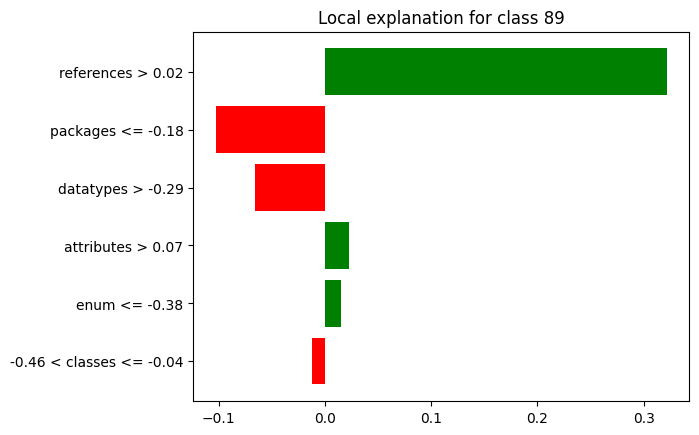

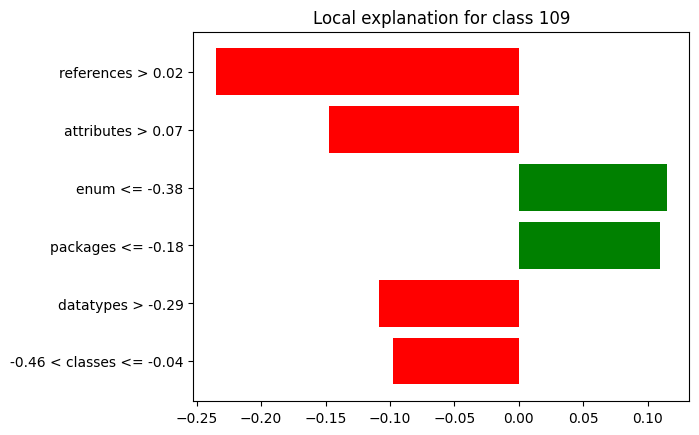

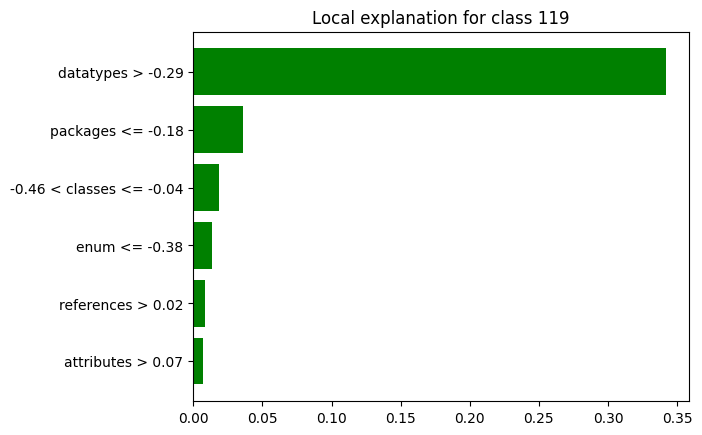

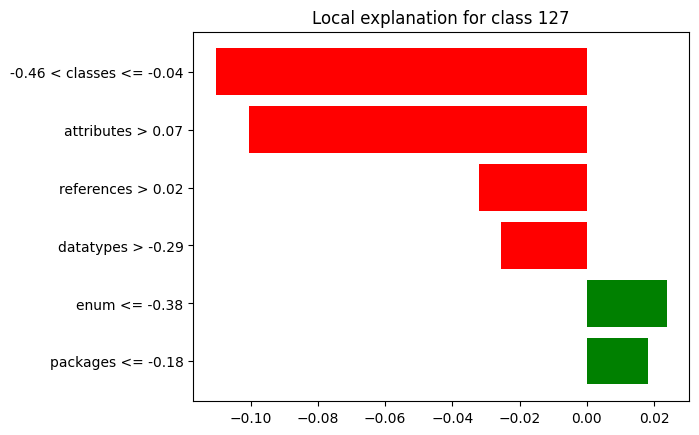

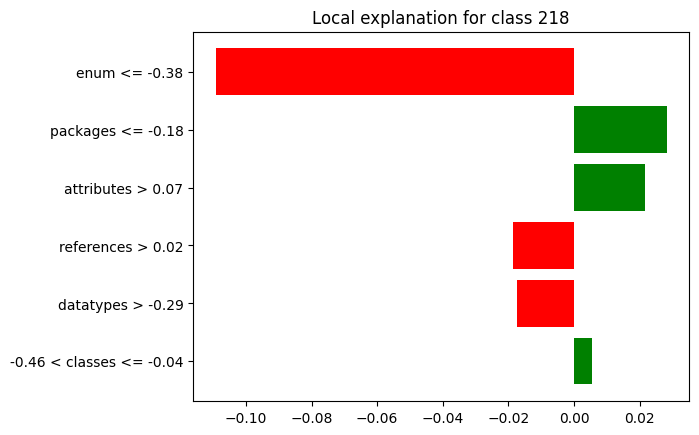

In [ ]:
for i in class_index:
  knn_exp_results['lime_metamodelling'][i].plot()

In [ ]:
breakdown_df_metamodelling_gpl, shap_df_metamodelling_gpl, lime_df_metamodelling_gpl, df_final_knn_meta_gpl = preprocess_dfs(breakdown_df_metamodelling_gpl, shap_df_metamodelling_gpl, lime_df_metamodelling_gpl, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_metamodelling_gpl)
print('----------------------------------------------')
print(shap_df_metamodelling_gpl)
print('----------------------------------------------')
print(lime_df_metamodelling_gpl)

['classes', 'packages', 'enum', 'references', 'attributes', 'datatypes']
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Negative
1  references        2  Positive
2        enum        3  Positive
3  attributes        4  Positive
4    packages        5  Negative
5   datatypes        6      Null
----------------------------------------------
      Feature  Ranking      Sign
0   datatypes        1  Negative
1  attributes        2  Negative
2  references        3  Positive
3    packages        4  Negative
4     classes        5  Positive
5        enum        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0  references        1  Positive
1    packages        2  Negative
2   datatypes        3  Negative
3  attributes        4  Positive
4        enum        5  Positive
5     classes        6  Negative


In [ ]:
df_final_knn_meta_gpl

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
classes            1  Negative       5  Positive       6  Negative
references         2  Positive       3  Positive       1  Positive
enum               3  Positive       6  Negative       5  Positive
attributes         4  Positive       2  Negative       4  Positive
packages           5  Negative       4  Negative       2  Negative
datatypes          6      Null       1  Negative       3  Negative

In [ ]:
breakdown_df_metamodelling_lib, shap_df_metamodelling_lib, lime_df_metamodelling_lib, df_final_knn_meta_lib = preprocess_dfs(breakdown_df_metamodelling_lib, shap_df_metamodelling_lib, lime_df_metamodelling_lib, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_metamodelling_lib)
print('----------------------------------------------')
print(shap_df_metamodelling_lib)
print('----------------------------------------------')
print(lime_df_metamodelling_lib)

['classes', 'enum', 'references', 'attributes', 'datatypes', 'packages']
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Negative
1  attributes        2  Positive
2  references        3  Negative
3        enum        4  Positive
4   datatypes        5  Negative
5    packages        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0   datatypes        1  Negative
1  references        2  Negative
2     classes        3  Negative
3  attributes        4  Positive
4        enum        5  Negative
5    packages        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0  references        1  Negative
1  attributes        2  Negative
2        enum        3  Positive
3    packages        4  Positive
4   datatypes        5  Negative
5     classes        6  Negative


In [ ]:
df_final_knn_meta_lib

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
classes            1  Negative       3  Negative       6  Negative
attributes         2  Positive       4  Positive       2  Negative
references         3  Negative       2  Negative       1  Negative
enum               4  Positive       5  Negative       3  Positive
datatypes          5  Negative       1  Negative       5  Negative
packages           6  Positive       6  Positive       4  Positive

In [ ]:
breakdown_df_metamodelling_meta, shap_df_metamodelling_meta, lime_df_metamodelling_meta, df_final_knn_meta_meta = preprocess_dfs(breakdown_df_metamodelling_meta, shap_df_metamodelling_meta, lime_df_metamodelling_meta, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_metamodelling_meta)
print('----------------------------------------------')
print(shap_df_metamodelling_meta)
print('----------------------------------------------')
print(lime_df_metamodelling_meta)

['classes', 'packages', 'enum', 'references', 'attributes', 'datatypes']
----------------------------------------------
      Feature  Ranking      Sign
0   datatypes        1  Positive
1  references        2  Positive
2  attributes        3  Positive
3     classes        4  Positive
4    packages        5  Positive
5        enum        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0   datatypes        1  Positive
1  references        2  Positive
2     classes        3  Negative
3  attributes        4  Positive
4        enum        5  Positive
5    packages        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0   datatypes        1  Positive
1    packages        2  Positive
2     classes        3  Positive
3        enum        4  Positive
4  references        5  Positive
5  attributes        6  Positive


In [ ]:
df_final_knn_meta_meta

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
datatypes          1  Positive       1  Positive       1  Positive
references         2  Positive       2  Positive       5  Positive
attributes         3  Positive       4  Positive       6  Positive
classes            4  Positive       3  Negative       3  Positive
packages           5  Positive       6  Positive       2  Positive
enum               6  Positive       5  Positive       4  Positive

In [ ]:
breakdown_df_metamodelling_mod, shap_df_metamodelling_mod, lime_df_metamodelling_mod, df_final_knn_meta_mod = preprocess_dfs(breakdown_df_metamodelling_mod, shap_df_metamodelling_mod, lime_df_metamodelling_mod, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_metamodelling_mod)
print('----------------------------------------------')
print(shap_df_metamodelling_mod)
print('----------------------------------------------')
print(lime_df_metamodelling_mod)

['classes', 'packages', 'enum', 'references', 'attributes', 'datatypes']
----------------------------------------------
      Feature  Ranking      Sign
0  attributes        1  Negative
1     classes        2  Positive
2        enum        3  Negative
3  references        4  Positive
4    packages        5  Negative
5   datatypes        6      Null
----------------------------------------------
      Feature  Ranking      Sign
0  attributes        1  Negative
1   datatypes        2  Negative
2     classes        3  Positive
3  references        4  Positive
4        enum        5  Negative
5    packages        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Negative
1  attributes        2  Negative
2  references        3  Negative
3   datatypes        4  Negative
4        enum        5  Positive
5    packages        6  Positive


In [ ]:
df_final_knn_meta_mod

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
attributes         1  Negative       1  Negative       2  Negative
classes            2  Positive       3  Positive       1  Negative
enum               3  Negative       5  Negative       5  Positive
references         4  Positive       4  Positive       3  Negative
packages           5  Negative       6  Negative       6  Positive
datatypes          6      Null       2  Negative       4  Negative

In [ ]:
breakdown_df_metamodelling_wf, shap_df_metamodelling_wf, lime_df_metamodelling_wf, df_final_knn_meta_wf = preprocess_dfs(breakdown_df_metamodelling_wf, shap_df_metamodelling_wf, lime_df_metamodelling_wf, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_metamodelling_wf)
print('----------------------------------------------')
print(shap_df_metamodelling_wf)
print('----------------------------------------------')
print(lime_df_metamodelling_wf)

['classes', 'enum', 'references', 'attributes', 'datatypes', 'packages']
----------------------------------------------
      Feature  Ranking      Sign
0  references        1  Negative
1     classes        2  Positive
2   datatypes        3  Negative
3        enum        4  Negative
4  attributes        5  Negative
5    packages        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0  attributes        1  Negative
1   datatypes        2  Negative
2  references        3  Negative
3        enum        4  Negative
4     classes        5  Positive
5    packages        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0        enum        1  Negative
1    packages        2  Positive
2  attributes        3  Positive
3  references        4  Negative
4   datatypes        5  Negative
5     classes        6  Positive


In [ ]:
df_final_knn_meta_wf

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
references         1  Negative       3  Negative       4  Negative
classes            2  Positive       5  Positive       6  Positive
datatypes          3  Negative       2  Negative       5  Negative
enum               4  Negative       4  Negative       1  Negative
attributes         5  Negative       1  Negative       3  Positive
packages           6  Negative       6  Negative       2  Positive

### **RESULTS METAMODELLING:**

In [ ]:
df_topfeatures_meta_gpl = top3_features(df_final_knn_meta_gpl, 'Metamodelling - Class: GPL')
df_topfeatures_meta_lib = top3_features(df_final_knn_meta_lib, 'Metamodelling - Class: Library')
df_topfeatures_meta_meta = top3_features(df_final_knn_meta_meta, 'Metamodelling - Class: Metamodelling')
df_topfeatures_meta_mod = top3_features(df_final_knn_meta_mod, 'Metamodelling - Class: Modelling')
df_topfeatures_meta_wf = top3_features(df_final_knn_meta_wf, 'Metamodelling - Class: Workflow')

df_topfeatures_metamodelling_knn = pd.concat([df_topfeatures_meta_gpl, df_topfeatures_meta_lib, df_topfeatures_meta_meta, df_topfeatures_meta_mod, df_topfeatures_meta_wf])
df_topfeatures_metamodelling_knn

TOP3 Breakdown  \
Metamodelling - Class: GPL                    enum, classes, references   
Metamodelling - Class: Library          attributes, classes, references   
Metamodelling - Class: Metamodelling  attributes, datatypes, references   
Metamodelling - Class: Modelling              attributes, enum, classes   
Metamodelling - Class: Workflow          datatypes, classes, references   

                                                              TOP3 Shap  \
Metamodelling - Class: GPL            attributes, datatypes, references   
Metamodelling - Class: Library           datatypes, classes, references   
Metamodelling - Class: Metamodelling     datatypes, classes, references   
Metamodelling - Class: Modelling         attributes, datatypes, classes   
Metamodelling - Class: Workflow       attributes, datatypes, references   

                                                            TOP3 Lime  \
Metamodelling - Class: GPL            datatypes, packages, references   
Metamodelling - Class: Library           attributes, enum, references   
Metamodelling - Class: Metamodelling     packages, datatypes, classes   
Metamodelling - Class: Modelling      attributes, classes, references   
Metamodelling - Class: Workflow            attributes, enum, packages   

                                      Breakdown-Shap  Breakdown-Lime  \
Metamodelling - Class: GPL                  0.333333        0.333333   
Metamodelling - Class: Library              0.666667        0.666667   
Metamodelling - Class: Metamodelling        0.666667        0.333333   
Metamodelling - Class: Modelling            0.666667        0.666667   
Metamodelling - Class: Workflow             0.666667        0.000000   

                                      Lime-Shap  
Metamodelling - Class: GPL             0.666667  
Metamodelling - Class: Library         0.333333  
Metamodelling - Class: Metamodelling   0.666667  
Metamodelling - Class: Modelling       0.666667  
Metamodelling - Class: Workflow        0.333333

In [ ]:
df_topfeatures_meta_gpl_rank = top3_rank(df_final_knn_meta_gpl, 'Metamodelling - Class GPL')
df_topfeatures_meta_lib_rank = top3_rank(df_final_knn_meta_lib, 'Metamodelling - Class Library')
df_topfeatures_meta_meta_rank = top3_rank(df_final_knn_meta_meta, 'Metamodelling - Class Metamodelling')
df_topfeatures_meta_mod_rank = top3_rank(df_final_knn_meta_mod, 'Metamodelling - Class Modelling')
df_topfeatures_meta_wf_rank = top3_rank(df_final_knn_meta_wf, 'Metamodelling - Class Workflow')

df_topfeatures_rank_metamodelling_knn = pd.concat([df_topfeatures_meta_gpl_rank, df_topfeatures_meta_lib_rank, df_topfeatures_meta_meta_rank, df_topfeatures_meta_mod_rank, df_topfeatures_meta_wf_rank])
df_topfeatures_rank_metamodelling_knn

TOP3 Breakdown  \
Metamodelling - Class GPL                    1:classes, 2:references, 3:enum   
Metamodelling - Class Library          1:classes, 2:attributes, 3:references   
Metamodelling - Class Metamodelling  1:datatypes, 2:references, 3:attributes   
Metamodelling - Class Modelling              1:attributes, 2:classes, 3:enum   
Metamodelling - Class Workflow          1:references, 2:classes, 3:datatypes   

                                                                   TOP3 Shap  \
Metamodelling - Class GPL            3:references, 2:attributes, 1:datatypes   
Metamodelling - Class Library           3:classes, 2:references, 1:datatypes   
Metamodelling - Class Metamodelling     1:datatypes, 2:references, 3:classes   
Metamodelling - Class Modelling         1:attributes, 3:classes, 2:datatypes   
Metamodelling - Class Workflow       3:references, 2:datatypes, 1:attributes   

                                                                 TOP3 Lime  \
Metamodelling - Class GPL            1:references, 2:packages, 3:datatypes   
Metamodelling - Class Library           2:attributes, 1:references, 3:enum   
Metamodelling - Class Metamodelling     1:datatypes, 3:classes, 2:packages   
Metamodelling - Class Modelling      2:attributes, 1:classes, 3:references   
Metamodelling - Class Workflow            1:enum, 3:attributes, 2:packages   

                                     Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Metamodelling - Class GPL                  0.000000        0.000000   0.000000  
Metamodelling - Class Library              0.000000        0.333333   0.000000  
Metamodelling - Class Metamodelling        0.666667        0.333333   0.666667  
Metamodelling - Class Modelling            0.333333        0.000000   0.000000  
Metamodelling - Class Workflow             0.000000        0.000000   0.000000

In [ ]:
df_topfeatures_meta_gpl_sign = top3_sign(df_final_knn_meta_gpl, 'Metamodelling - Class GPL')
df_topfeatures_meta_lib_sign = top3_sign(df_final_knn_meta_lib, 'Metamodelling - Class Library')
df_topfeatures_meta_meta_sign = top3_sign(df_final_knn_meta_meta, 'Metamodelling - Class Metamodelling')
df_topfeatures_meta_mod_sign = top3_sign(df_final_knn_meta_mod, 'Metamodelling - Class Modelling')
df_topfeatures_meta_wf_sign = top3_sign(df_final_knn_meta_wf, 'Metamodelling - Class Workflow')

df_topfeatures_sign_metamodelling_knn = pd.concat([df_topfeatures_meta_gpl_sign, df_topfeatures_meta_lib_sign, df_topfeatures_meta_meta_sign, df_topfeatures_meta_mod_sign, df_topfeatures_meta_wf_sign])
df_topfeatures_sign_metamodelling_knn

TOP3 Breakdown  \
Metamodelling - Class GPL            classes:Negative, references:Positive, enum:Po...   
Metamodelling - Class Library        classes:Negative, attributes:Positive, referen...   
Metamodelling - Class Metamodelling  datatypes:Positive, references:Positive, attri...   
Metamodelling - Class Modelling      attributes:Negative, classes:Positive, enum:Ne...   
Metamodelling - Class Workflow       references:Negative, classes:Positive, datatyp...   

                                                                             TOP3 Shap  \
Metamodelling - Class GPL            references:Positive, attributes:Negative, data...   
Metamodelling - Class Library        classes:Negative, references:Negative, datatyp...   
Metamodelling - Class Metamodelling  datatypes:Positive, references:Positive, class...   
Metamodelling - Class Modelling      attributes:Negative, classes:Positive, datatyp...   
Metamodelling - Class Workflow       references:Negative, datatypes:Negative, attri...   

                                                                             TOP3 Lime  \
Metamodelling - Class GPL            references:Positive, packages:Negative, dataty...   
Metamodelling - Class Library        attributes:Negative, references:Negative, enum...   
Metamodelling - Class Metamodelling  datatypes:Positive, classes:Positive, packages...   
Metamodelling - Class Modelling      attributes:Negative, classes:Negative, referen...   
Metamodelling - Class Workflow       enum:Negative, attributes:Positive, packages:P...   

                                     Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Metamodelling - Class GPL                  0.333333        0.333333   0.666667  
Metamodelling - Class Library              0.666667        0.333333   0.333333  
Metamodelling - Class Metamodelling        0.666667        0.333333   0.333333  
Metamodelling - Class Modelling            0.666667        0.333333   0.333333  
Metamodelling - Class Workflow             0.666667        0.000000   0.000000

In [ ]:
df_topfeatures_meta_gpl_rank_sign = top3_rank_sign(df_final_knn_meta_gpl, 'Metamodelling - Class GPL')
df_topfeatures_meta_lib_rank_sign = top3_rank_sign(df_final_knn_meta_lib, 'Metamodelling - Class Library')
df_topfeatures_meta_meta_rank_sign = top3_rank_sign(df_final_knn_meta_meta, 'Metamodelling - Class Metamodelling')
df_topfeatures_meta_mod_rank_sign = top3_rank_sign(df_final_knn_meta_mod, 'Metamodelling - Class Modelling')
df_topfeatures_meta_wf_rank_sign = top3_rank_sign(df_final_knn_meta_wf, 'Metamodelling - Class Workflow')

df_topfeatures_rank_sign_metamodelling_knn = pd.concat([df_topfeatures_meta_gpl_rank_sign, df_topfeatures_meta_lib_rank_sign, df_topfeatures_meta_meta_rank_sign, df_topfeatures_meta_mod_rank_sign, df_topfeatures_meta_wf_rank_sign])
df_topfeatures_rank_sign_metamodelling_knn

TOP3 Breakdown  \
Metamodelling - Class GPL            1:classes:Negative, 2:references:Positive, 3:e...   
Metamodelling - Class Library        1:classes:Negative, 2:attributes:Positive, 3:r...   
Metamodelling - Class Metamodelling  1:datatypes:Positive, 2:references:Positive, 3...   
Metamodelling - Class Modelling      1:attributes:Negative, 2:classes:Positive, 3:e...   
Metamodelling - Class Workflow       1:references:Negative, 2:classes:Positive, 3:d...   

                                                                             TOP3 Shap  \
Metamodelling - Class GPL            3:references:Positive, 2:attributes:Negative, ...   
Metamodelling - Class Library        3:classes:Negative, 2:references:Negative, 1:d...   
Metamodelling - Class Metamodelling  1:datatypes:Positive, 2:references:Positive, 3...   
Metamodelling - Class Modelling      1:attributes:Negative, 3:classes:Positive, 2:d...   
Metamodelling - Class Workflow       3:references:Negative, 2:datatypes:Negative, 1...   

                                                                             TOP3 Lime  \
Metamodelling - Class GPL            1:references:Positive, 2:packages:Negative, 3:...   
Metamodelling - Class Library        2:attributes:Negative, 1:references:Negative, ...   
Metamodelling - Class Metamodelling  1:datatypes:Positive, 3:classes:Positive, 2:pa...   
Metamodelling - Class Modelling      2:attributes:Negative, 1:classes:Negative, 3:r...   
Metamodelling - Class Workflow       1:enum:Negative, 3:attributes:Positive, 2:pack...   

                                     Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Metamodelling - Class GPL                  0.000000        0.000000   0.000000  
Metamodelling - Class Library              0.000000        0.000000   0.000000  
Metamodelling - Class Metamodelling        0.666667        0.333333   0.333333  
Metamodelling - Class Modelling            0.333333        0.000000   0.000000  
Metamodelling - Class Workflow             0.000000        0.000000   0.000000

### **MODELLING:**

In [ ]:
breakdown_df_modelling_gpl = knn_exp_results['breakdown_modelling'][1].result
shap_df_modelling_gpl = knn_exp_results['shap_modelling'][1].result
lime_df_modelling_gpl = knn_exp_results['lime_modelling'][1].result

In [ ]:
breakdown_df_modelling_lib = knn_exp_results['breakdown_modelling'][2].result
shap_df_modelling_lib = knn_exp_results['shap_modelling'][2].result
lime_df_modelling_lib = knn_exp_results['lime_modelling'][2].result

In [ ]:
breakdown_df_modelling_meta = knn_exp_results['breakdown_modelling'][3].result
shap_df_modelling_meta = knn_exp_results['shap_modelling'][3].result
lime_df_modelling_meta = knn_exp_results['lime_modelling'][3].result

In [ ]:
breakdown_df_modelling_mod = knn_exp_results['breakdown_modelling'][4].result
shap_df_modelling_mod = knn_exp_results['shap_modelling'][4].result
lime_df_modelling_mod = knn_exp_results['lime_modelling'][4].result

In [ ]:
breakdown_df_modelling_wf = knn_exp_results['breakdown_modelling'][9].result
shap_df_modelling_wf = knn_exp_results['shap_modelling'][9].result
lime_df_modelling_wf = knn_exp_results['lime_modelling'][9].result

In [ ]:
exp_plots_bd = [knn_exp_results['breakdown_modelling'][i] for i in class_index]
exp_plots_bd[0].plot(exp_plots_bd[1:])

In [ ]:
exp_plots_shap = [knn_exp_results['shap_modelling'][i] for i in class_index]
exp_plots_shap[0].plot(exp_plots_shap[1:])

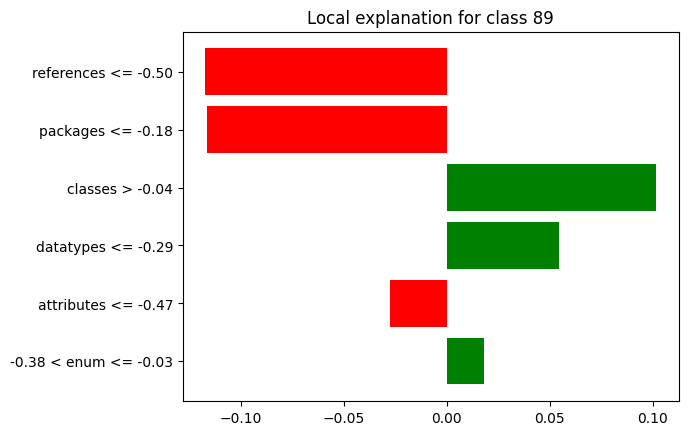

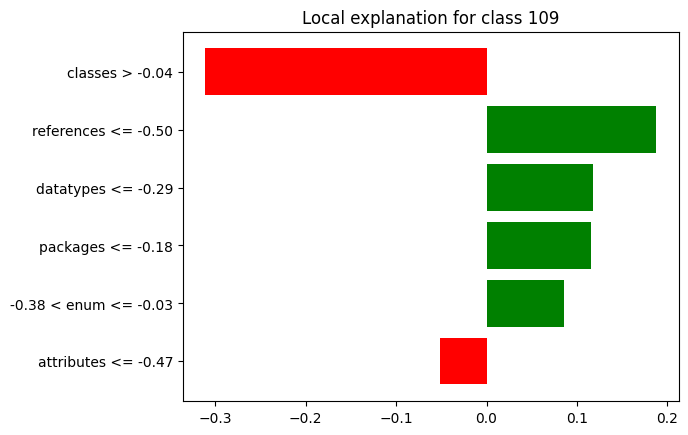

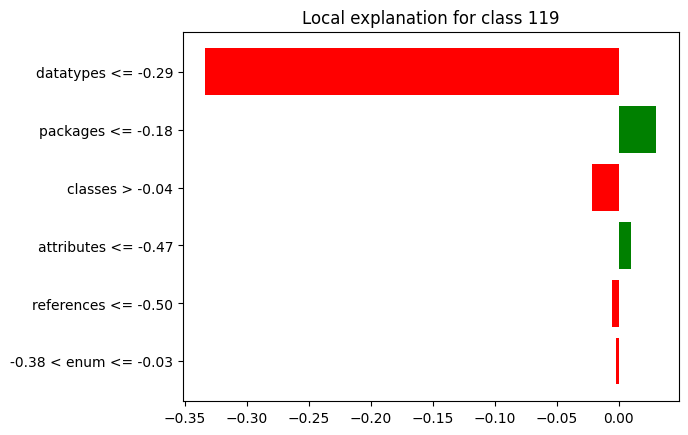

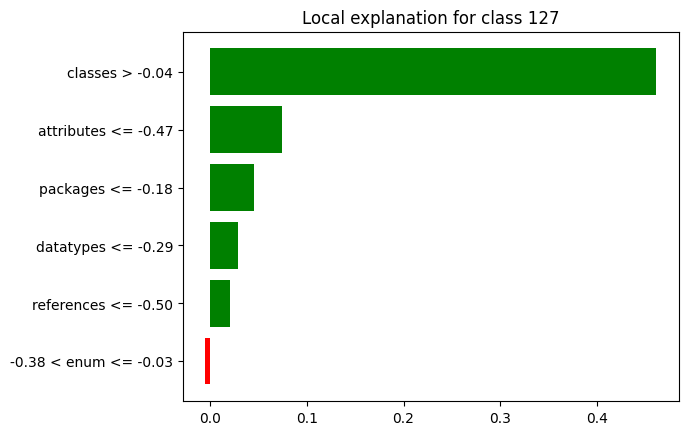

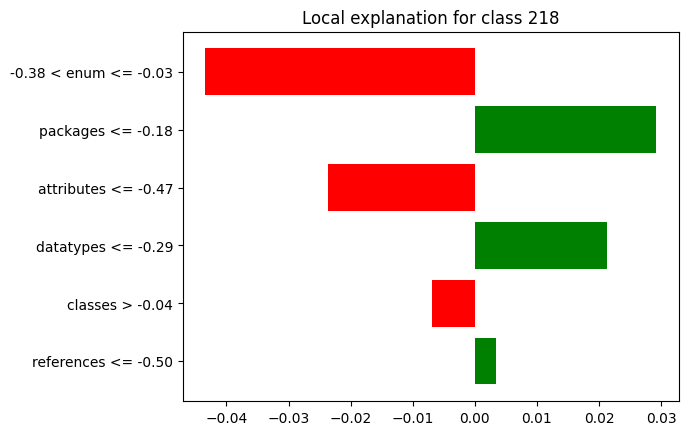

In [ ]:
for i in class_index:
  knn_exp_results['lime_modelling'][i].plot()

In [ ]:
breakdown_df_modelling_gpl, shap_df_modelling_gpl, lime_df_modelling_gpl, df_final_knn_mod_gpl = preprocess_dfs(breakdown_df_modelling_gpl, shap_df_modelling_gpl, lime_df_modelling_gpl, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_modelling_gpl)
print('----------------------------------------------')
print(shap_df_modelling_gpl)
print('----------------------------------------------')
print(lime_df_modelling_gpl)

['classes', 'packages', 'enum', 'references', 'attributes', 'datatypes']
----------------------------------------------
      Feature  Ranking      Sign
0  references        1  Negative
1     classes        2  Negative
2        enum        3  Positive
3  attributes        4  Positive
4    packages        5  Positive
5   datatypes        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0  references        1  Negative
1     classes        2  Negative
2    packages        3  Negative
3  attributes        4  Positive
4   datatypes        5  Positive
5        enum        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0  references        1  Negative
1    packages        2  Negative
2     classes        3  Positive
3   datatypes        4  Positive
4  attributes        5  Negative
5        enum        6  Positive


In [ ]:
df_final_knn_mod_gpl

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
references         1  Negative       1  Negative       1  Negative
classes            2  Negative       2  Negative       3  Positive
enum               3  Positive       6  Positive       6  Positive
attributes         4  Positive       4  Positive       5  Negative
packages           5  Positive       3  Negative       2  Negative
datatypes          6  Positive       5  Positive       4  Positive

In [ ]:
breakdown_df_modelling_lib, shap_df_modelling_lib, lime_df_modelling_lib, df_final_knn_mod_lib = preprocess_dfs(breakdown_df_modelling_lib, shap_df_modelling_lib, lime_df_modelling_lib, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_modelling_lib)
print('----------------------------------------------')
print(shap_df_modelling_lib)
print('----------------------------------------------')
print(lime_df_modelling_lib)

['classes', 'packages', 'enum', 'references', 'attributes', 'datatypes']
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Negative
1  references        2  Positive
2        enum        3  Positive
3  attributes        4  Negative
4    packages        5  Negative
5   datatypes        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Negative
1        enum        2  Positive
2  attributes        3  Negative
3  references        4  Positive
4   datatypes        5  Positive
5    packages        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Negative
1  references        2  Positive
2   datatypes        3  Positive
3    packages        4  Positive
4        enum        5  Positive
5  attributes        6  Negative


In [ ]:
df_final_knn_mod_lib

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
classes            1  Negative       1  Negative       1  Negative
references         2  Positive       4  Positive       2  Positive
enum               3  Positive       2  Positive       5  Positive
attributes         4  Negative       3  Negative       6  Negative
packages           5  Negative       6  Negative       4  Positive
datatypes          6  Positive       5  Positive       3  Positive

In [ ]:
breakdown_df_modelling_meta, shap_df_modelling_meta, lime_df_modelling_meta, df_final_knn_mod_meta = preprocess_dfs(breakdown_df_modelling_meta, shap_df_modelling_meta, lime_df_modelling_meta, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_modelling_meta)
print('----------------------------------------------')
print(shap_df_modelling_meta)
print('----------------------------------------------')
print(lime_df_modelling_meta)

['classes', 'enum', 'references', 'attributes', 'datatypes', 'packages']
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Negative
1        enum        2  Negative
2  attributes        3  Positive
3   datatypes        4  Negative
4  references        5  Positive
5    packages        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0   datatypes        1  Negative
1     classes        2  Negative
2  attributes        3  Negative
3  references        4  Negative
4        enum        5  Negative
5    packages        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0   datatypes        1  Negative
1    packages        2  Positive
2     classes        3  Negative
3  attributes        4  Positive
4  references        5  Negative
5        enum        6  Negative


In [ ]:
df_final_knn_mod_meta

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
classes            1  Negative       2  Negative       3  Negative
enum               2  Negative       5  Negative       6  Negative
attributes         3  Positive       3  Negative       4  Positive
datatypes          4  Negative       1  Negative       1  Negative
references         5  Positive       4  Negative       5  Negative
packages           6  Negative       6  Negative       2  Positive

In [ ]:
breakdown_df_modelling_mod, shap_df_modelling_mod, lime_df_modelling_mod, df_final_knn_mod_mod = preprocess_dfs(breakdown_df_modelling_mod, shap_df_modelling_mod, lime_df_modelling_mod, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_modelling_mod)
print('----------------------------------------------')
print(shap_df_modelling_mod)
print('----------------------------------------------')
print(lime_df_modelling_mod)

['classes', 'packages', 'enum', 'references', 'attributes', 'datatypes']
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Positive
1  references        2  Positive
2  attributes        3  Positive
3    packages        4  Positive
4        enum        5  Positive
5   datatypes        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Positive
1  references        2  Positive
2  attributes        3  Positive
3   datatypes        4  Positive
4    packages        5  Positive
5        enum        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Positive
1  attributes        2  Positive
2    packages        3  Positive
3   datatypes        4  Positive
4  references        5  Positive
5        enum        6  Negative


In [ ]:
df_final_knn_mod_mod

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
classes            1  Positive       1  Positive       1  Positive
references         2  Positive       2  Positive       5  Positive
attributes         3  Positive       3  Positive       2  Positive
packages           4  Positive       5  Positive       3  Positive
enum               5  Positive       6  Positive       6  Negative
datatypes          6  Positive       4  Positive       4  Positive

In [ ]:
breakdown_df_modelling_wf, shap_df_modelling_wf, lime_df_modelling_wf, df_final_knn_mod_wf = preprocess_dfs(breakdown_df_modelling_wf, shap_df_modelling_wf, lime_df_modelling_wf, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_modelling_wf)
print('----------------------------------------------')
print(shap_df_modelling_wf)
print('----------------------------------------------')
print(lime_df_modelling_wf)

['classes', 'packages', 'enum', 'references', 'attributes', 'datatypes']
----------------------------------------------
      Feature  Ranking      Sign
0  attributes        1  Negative
1  references        2  Negative
2        enum        3  Positive
3   datatypes        4  Positive
4    packages        5  Positive
5     classes        6      Null
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Negative
1  attributes        2  Negative
2        enum        3  Negative
3  references        4  Positive
4   datatypes        5  Negative
5    packages        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0        enum        1  Negative
1    packages        2  Positive
2  attributes        3  Negative
3   datatypes        4  Positive
4     classes        5  Negative
5  references        6  Positive


In [ ]:
df_final_knn_mod_wf

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
attributes         1  Negative       2  Negative       3  Negative
references         2  Negative       4  Positive       6  Positive
enum               3  Positive       3  Negative       1  Negative
datatypes          4  Positive       5  Negative       4  Positive
packages           5  Positive       6  Negative       2  Positive
classes            6      Null       1  Negative       5  Negative

### **RESULTS MODELLING:**

In [ ]:
df_topfeatures_mod_gpl = top3_features(df_final_knn_mod_gpl, 'Modelling - Class: GPL')
df_topfeatures_mod_lib = top3_features(df_final_knn_mod_lib, 'Modelling - Class: Library')
df_topfeatures_mod_meta = top3_features(df_final_knn_mod_meta, 'Modelling - Class: Metamodelling')
df_topfeatures_mod_mod = top3_features(df_final_knn_mod_mod, 'Modelling - Class: Modelling')
df_topfeatures_mod_wf = top3_features(df_final_knn_mod_wf, 'Modelling - Class: Workflow')

df_topfeatures_modelling_knn = pd.concat([df_topfeatures_mod_gpl, df_topfeatures_mod_lib, df_topfeatures_mod_meta, df_topfeatures_mod_mod, df_topfeatures_mod_wf])
df_topfeatures_modelling_knn

TOP3 Breakdown  \
Modelling - Class: GPL                  enum, classes, references   
Modelling - Class: Library              enum, classes, references   
Modelling - Class: Metamodelling        attributes, enum, classes   
Modelling - Class: Modelling      attributes, classes, references   
Modelling - Class: Workflow          attributes, enum, references   

                                                        TOP3 Shap  \
Modelling - Class: GPL              packages, classes, references   
Modelling - Class: Library              attributes, enum, classes   
Modelling - Class: Metamodelling   attributes, datatypes, classes   
Modelling - Class: Modelling      attributes, classes, references   
Modelling - Class: Workflow             attributes, enum, classes   

                                                       TOP3 Lime  \
Modelling - Class: GPL             packages, classes, references   
Modelling - Class: Library        datatypes, classes, references   
Modelling - Class: Metamodelling    packages, datatypes, classes   
Modelling - Class: Modelling       attributes, packages, classes   
Modelling - Class: Workflow           attributes, enum, packages   

                                  Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Modelling - Class: GPL                  0.666667        0.666667   1.000000  
Modelling - Class: Library              0.666667        0.666667   0.333333  
Modelling - Class: Metamodelling        0.666667        0.333333   0.666667  
Modelling - Class: Modelling            1.000000        0.666667   0.666667  
Modelling - Class: Workflow             0.666667        0.666667   0.666667

In [ ]:
df_topfeatures_mod_gpl_rank = top3_rank(df_final_knn_mod_gpl, 'Modelling - Class GPL')
df_topfeatures_mod_lib_rank = top3_rank(df_final_knn_mod_lib, 'Modelling - Class Library')
df_topfeatures_mod_meta_rank = top3_rank(df_final_knn_mod_meta, 'Modelling - Class Metamodelling')
df_topfeatures_mod_mod_rank = top3_rank(df_final_knn_mod_mod, 'Modelling - Class Modelling')
df_topfeatures_mod_wf_rank = top3_rank(df_final_knn_mod_wf, 'Modelling - Class Workflow')

df_topfeatures_rank_modelling_knn = pd.concat([df_topfeatures_mod_gpl_rank, df_topfeatures_mod_lib_rank, df_topfeatures_mod_meta_rank, df_topfeatures_mod_mod_rank, df_topfeatures_mod_wf_rank])
df_topfeatures_rank_modelling_knn

TOP3 Breakdown  \
Modelling - Class GPL                  1:references, 2:classes, 3:enum   
Modelling - Class Library              1:classes, 2:references, 3:enum   
Modelling - Class Metamodelling        1:classes, 2:enum, 3:attributes   
Modelling - Class Modelling      1:classes, 2:references, 3:attributes   
Modelling - Class Workflow          1:attributes, 2:references, 3:enum   

                                                             TOP3 Shap  \
Modelling - Class GPL              1:references, 2:classes, 3:packages   
Modelling - Class Library              1:classes, 2:enum, 3:attributes   
Modelling - Class Metamodelling   2:classes, 3:attributes, 1:datatypes   
Modelling - Class Modelling      1:classes, 2:references, 3:attributes   
Modelling - Class Workflow             2:attributes, 3:enum, 1:classes   

                                                            TOP3 Lime  \
Modelling - Class GPL             1:references, 3:classes, 2:packages   
Modelling - Class Library        1:classes, 2:references, 3:datatypes   
Modelling - Class Metamodelling    3:classes, 1:datatypes, 2:packages   
Modelling - Class Modelling       1:classes, 2:attributes, 3:packages   
Modelling - Class Workflow           3:attributes, 1:enum, 2:packages   

                                 Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Modelling - Class GPL                  0.666667        0.333333   0.333333  
Modelling - Class Library              0.333333        0.666667   0.333333  
Modelling - Class Metamodelling        0.333333        0.000000   0.333333  
Modelling - Class Modelling            1.000000        0.333333   0.333333  
Modelling - Class Workflow             0.333333        0.000000   0.000000

In [ ]:
df_topfeatures_mod_gpl_sign = top3_sign(df_final_knn_mod_gpl, 'Modelling - Class GPL')
df_topfeatures_mod_lib_sign = top3_sign(df_final_knn_mod_lib, 'Modelling - Class Library')
df_topfeatures_mod_meta_sign = top3_sign(df_final_knn_mod_meta, 'Modelling - Class Metamodelling')
df_topfeatures_mod_mod_sign = top3_sign(df_final_knn_mod_mod, 'Modelling - Class Modelling')
df_topfeatures_mod_wf_sign = top3_sign(df_final_knn_mod_wf, 'Modelling - Class Workflow')

df_topfeatures_sign_modelling_knn = pd.concat([df_topfeatures_mod_gpl_sign, df_topfeatures_mod_lib_sign, df_topfeatures_mod_meta_sign, df_topfeatures_mod_mod_sign, df_topfeatures_mod_wf_sign])
df_topfeatures_sign_modelling_knn

TOP3 Breakdown  \
Modelling - Class GPL            references:Negative, classes:Negative, enum:Po...   
Modelling - Class Library        classes:Negative, references:Positive, enum:Po...   
Modelling - Class Metamodelling  classes:Negative, enum:Negative, attributes:Po...   
Modelling - Class Modelling      classes:Positive, references:Positive, attribu...   
Modelling - Class Workflow       attributes:Negative, references:Negative, enum...   

                                                                         TOP3 Shap  \
Modelling - Class GPL            references:Negative, classes:Negative, package...   
Modelling - Class Library        classes:Negative, enum:Positive, attributes:Ne...   
Modelling - Class Metamodelling  classes:Negative, attributes:Negative, datatyp...   
Modelling - Class Modelling      classes:Positive, references:Positive, attribu...   
Modelling - Class Workflow       attributes:Negative, enum:Negative, classes:Ne...   

                                                                         TOP3 Lime  \
Modelling - Class GPL            references:Negative, classes:Positive, package...   
Modelling - Class Library        classes:Negative, references:Positive, datatyp...   
Modelling - Class Metamodelling  classes:Negative, datatypes:Negative, packages...   
Modelling - Class Modelling      classes:Positive, attributes:Positive, package...   
Modelling - Class Workflow       attributes:Negative, enum:Negative, packages:P...   

                                 Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Modelling - Class GPL                  0.666667        0.333333   0.666667  
Modelling - Class Library              0.666667        0.666667   0.333333  
Modelling - Class Metamodelling        0.333333        0.333333   0.666667  
Modelling - Class Modelling            1.000000        0.666667   0.666667  
Modelling - Class Workflow             0.333333        0.333333   0.666667

In [ ]:
df_topfeatures_mod_gpl_rank_sign = top3_rank_sign(df_final_knn_mod_gpl, 'Modelling - Class GPL')
df_topfeatures_mod_lib_rank_sign = top3_rank_sign(df_final_knn_mod_lib, 'Modelling - Class Library')
df_topfeatures_mod_meta_rank_sign = top3_rank_sign(df_final_knn_mod_meta, 'Modelling - Class Metamodelling')
df_topfeatures_mod_mod_rank_sign = top3_rank_sign(df_final_knn_mod_mod, 'Modelling - Class Modelling')
df_topfeatures_mod_wf_rank_sign = top3_rank_sign(df_final_knn_mod_wf, 'Modelling - Class Workflow')

df_topfeatures_rank_sign_modelling_knn = pd.concat([df_topfeatures_mod_gpl_rank_sign, df_topfeatures_mod_lib_rank_sign, df_topfeatures_mod_meta_rank_sign, df_topfeatures_mod_mod_rank_sign, df_topfeatures_mod_wf_rank_sign])
df_topfeatures_rank_sign_modelling_knn

TOP3 Breakdown  \
Modelling - Class GPL            1:references:Negative, 2:classes:Negative, 3:e...   
Modelling - Class Library        1:classes:Negative, 2:references:Positive, 3:e...   
Modelling - Class Metamodelling  1:classes:Negative, 2:enum:Negative, 3:attribu...   
Modelling - Class Modelling      1:classes:Positive, 2:references:Positive, 3:a...   
Modelling - Class Workflow       1:attributes:Negative, 2:references:Negative, ...   

                                                                         TOP3 Shap  \
Modelling - Class GPL            1:references:Negative, 2:classes:Negative, 3:p...   
Modelling - Class Library        1:classes:Negative, 2:enum:Positive, 3:attribu...   
Modelling - Class Metamodelling  2:classes:Negative, 3:attributes:Negative, 1:d...   
Modelling - Class Modelling      1:classes:Positive, 2:references:Positive, 3:a...   
Modelling - Class Workflow       2:attributes:Negative, 3:enum:Negative, 1:clas...   

                                                                         TOP3 Lime  \
Modelling - Class GPL            1:references:Negative, 3:classes:Positive, 2:p...   
Modelling - Class Library        1:classes:Negative, 2:references:Positive, 3:d...   
Modelling - Class Metamodelling  3:classes:Negative, 1:datatypes:Negative, 2:pa...   
Modelling - Class Modelling      1:classes:Positive, 2:attributes:Positive, 3:p...   
Modelling - Class Workflow       3:attributes:Negative, 1:enum:Negative, 2:pack...   

                                 Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Modelling - Class GPL                  0.666667        0.333333   0.333333  
Modelling - Class Library              0.333333        0.666667   0.333333  
Modelling - Class Metamodelling        0.000000        0.000000   0.333333  
Modelling - Class Modelling            1.000000        0.333333   0.333333  
Modelling - Class Workflow             0.000000        0.000000   0.000000

### **WORKFLOW:**

In [ ]:
breakdown_df_workflow_gpl = knn_exp_results['breakdown_workflow'][1].result
shap_df_workflow_gpl = knn_exp_results['shap_workflow'][1].result
lime_df_workflow_gpl = knn_exp_results['lime_workflow'][1].result

In [ ]:
breakdown_df_workflow_lib = knn_exp_results['breakdown_workflow'][2].result
shap_df_workflow_lib = knn_exp_results['shap_workflow'][2].result
lime_df_workflow_lib = knn_exp_results['lime_workflow'][2].result

In [ ]:
breakdown_df_workflow_meta = knn_exp_results['breakdown_workflow'][3].result
shap_df_workflow_meta = knn_exp_results['shap_workflow'][3].result
lime_df_workflow_meta = knn_exp_results['lime_workflow'][3].result

In [ ]:
breakdown_df_workflow_mod = knn_exp_results['breakdown_workflow'][4].result
shap_df_workflow_mod = knn_exp_results['shap_workflow'][4].result
lime_df_workflow_mod = knn_exp_results['lime_workflow'][4].result

In [ ]:
breakdown_df_workflow_wf = knn_exp_results['breakdown_workflow'][9].result
shap_df_workflow_wf = knn_exp_results['shap_workflow'][9].result
lime_df_workflow_wf = knn_exp_results['lime_workflow'][9].result

In [ ]:
exp_plots_bd = [knn_exp_results['breakdown_workflow'][i] for i in class_index]
exp_plots_bd[0].plot(exp_plots_bd[1:])

In [ ]:
exp_plots_shap = [knn_exp_results['shap_workflow'][i] for i in class_index]
exp_plots_shap[0].plot(exp_plots_shap[1:])

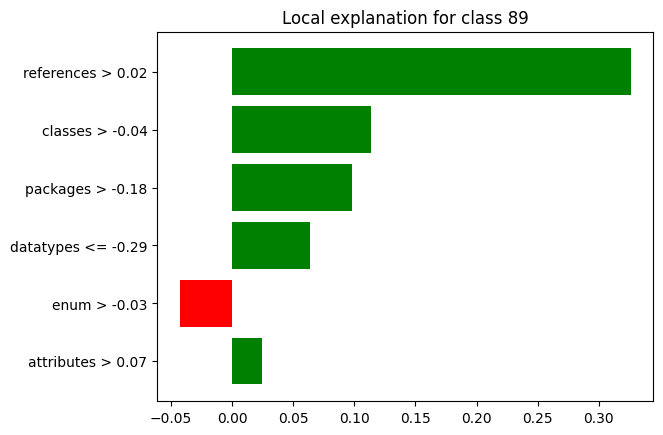

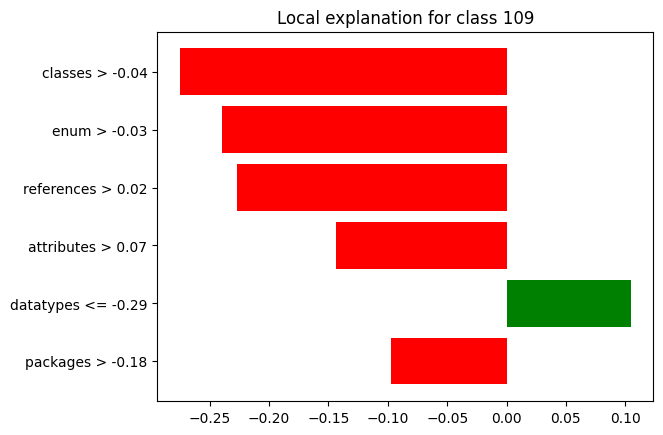

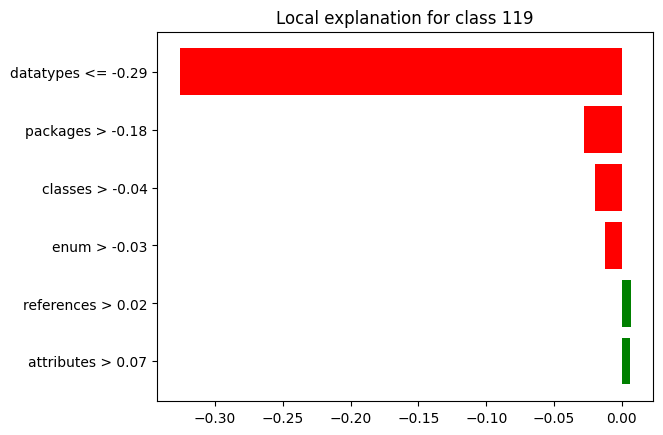

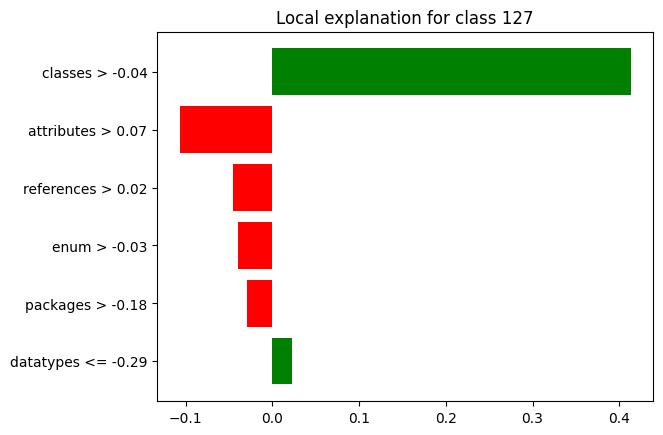

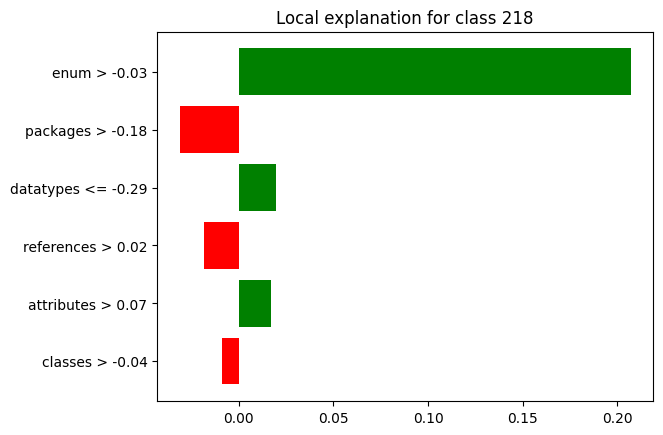

In [ ]:
for i in class_index:
  knn_exp_results['lime_workflow'][i].plot()

In [ ]:
breakdown_df_workflow_gpl, shap_df_workflow_gpl, lime_df_workflow_gpl, df_final_knn_wf_gpl = preprocess_dfs(breakdown_df_workflow_gpl, shap_df_workflow_gpl, lime_df_workflow_gpl, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_workflow_gpl)
print('----------------------------------------------')
print(shap_df_workflow_gpl)
print('----------------------------------------------')
print(lime_df_workflow_gpl)

['classes', 'enum', 'references', 'attributes', 'datatypes', 'packages']
----------------------------------------------
      Feature  Ranking      Sign
0        enum        1  Negative
1     classes        2  Positive
2  attributes        3  Positive
3  references        4  Positive
4   datatypes        5  Positive
5    packages        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0        enum        1  Negative
1     classes        2  Positive
2  references        3  Positive
3    packages        4  Negative
4  attributes        5  Negative
5   datatypes        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0  references        1  Positive
1     classes        2  Positive
2    packages        3  Positive
3   datatypes        4  Positive
4        enum        5  Negative
5  attributes        6  Positive


In [ ]:
df_final_knn_wf_gpl

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
enum               1  Negative       1  Negative       5  Negative
classes            2  Positive       2  Positive       2  Positive
attributes         3  Positive       5  Negative       6  Positive
references         4  Positive       3  Positive       1  Positive
datatypes          5  Positive       6  Positive       4  Positive
packages           6  Negative       4  Negative       3  Positive

In [ ]:
breakdown_df_workflow_lib, shap_df_workflow_lib, lime_df_workflow_lib, df_final_knn_wf_lib = preprocess_dfs(breakdown_df_workflow_lib, shap_df_workflow_lib, lime_df_workflow_lib, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_workflow_lib)
print('----------------------------------------------')
print(shap_df_workflow_lib)
print('----------------------------------------------')
print(lime_df_workflow_lib)

['classes', 'enum', 'references', 'attributes', 'datatypes', 'packages']
----------------------------------------------
      Feature  Ranking      Sign
0  references        1  Negative
1    packages        2  Positive
2  attributes        3  Negative
3   datatypes        4  Positive
4     classes        5      Null
5        enum        5      Null
----------------------------------------------
      Feature  Ranking      Sign
0        enum        1  Negative
1  references        2  Negative
2     classes        3  Negative
3    packages        4  Positive
4  attributes        5  Positive
5   datatypes        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Negative
1        enum        2  Negative
2  references        3  Negative
3  attributes        4  Negative
4   datatypes        5  Positive
5    packages        6  Negative


In [ ]:
df_final_knn_wf_lib

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
references         1  Negative       2  Negative       3  Negative
packages           2  Positive       4  Positive       6  Negative
attributes         3  Negative       5  Positive       4  Negative
datatypes          4  Positive       6  Positive       5  Positive
classes            5      Null       3  Negative       1  Negative
enum               5      Null       1  Negative       2  Negative

In [ ]:
breakdown_df_workflow_meta, shap_df_workflow_meta, lime_df_workflow_meta, df_final_knn_wf_meta = preprocess_dfs(breakdown_df_workflow_meta, shap_df_workflow_meta, lime_df_workflow_meta, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_workflow_meta)
print('----------------------------------------------')
print(shap_df_workflow_meta)
print('----------------------------------------------')
print(lime_df_workflow_meta)

['classes', 'enum', 'references', 'attributes', 'datatypes', 'packages']
----------------------------------------------
      Feature  Ranking      Sign
0    packages        1  Negative
1  references        2  Positive
2        enum        3  Negative
3  attributes        4  Positive
4     classes        5  Negative
5   datatypes        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0   datatypes        1  Negative
1        enum        2  Negative
2  references        3  Positive
3     classes        4  Negative
4    packages        5  Negative
5  attributes        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0   datatypes        1  Negative
1    packages        2  Negative
2     classes        3  Negative
3        enum        4  Negative
4  references        5  Positive
5  attributes        6  Positive


In [ ]:
df_final_knn_wf_meta

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
packages           1  Negative       5  Negative       2  Negative
references         2  Positive       3  Positive       5  Positive
enum               3  Negative       2  Negative       4  Negative
attributes         4  Positive       6  Negative       6  Positive
classes            5  Negative       4  Negative       3  Negative
datatypes          6  Negative       1  Negative       1  Negative

In [ ]:
breakdown_df_workflow_mod, shap_df_workflow_mod, lime_df_workflow_mod, df_final_knn_wf_mod = preprocess_dfs(breakdown_df_workflow_mod, shap_df_workflow_mod, lime_df_workflow_mod, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_workflow_mod)
print('----------------------------------------------')
print(shap_df_workflow_mod)
print('----------------------------------------------')
print(lime_df_workflow_mod)

['classes', 'packages', 'enum', 'references', 'attributes', 'datatypes']
----------------------------------------------
      Feature  Ranking      Sign
0  references        1  Negative
1     classes        2  Positive
2  attributes        3  Negative
3        enum        4  Positive
4    packages        5  Negative
5   datatypes        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0  attributes        1  Negative
1     classes        2  Positive
2        enum        3  Negative
3    packages        4  Negative
4   datatypes        5  Negative
5  references        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Positive
1  attributes        2  Negative
2  references        3  Negative
3        enum        4  Negative
4    packages        5  Negative
5   datatypes        6  Positive


In [ ]:
df_final_knn_wf_mod

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
references         1  Negative       6  Negative       3  Negative
classes            2  Positive       2  Positive       1  Positive
attributes         3  Negative       1  Negative       2  Negative
enum               4  Positive       3  Negative       4  Negative
packages           5  Negative       4  Negative       5  Negative
datatypes          6  Positive       5  Negative       6  Positive

In [ ]:
breakdown_df_workflow_wf, shap_df_workflow_wf, lime_df_workflow_wf, df_final_knn_wf_wf = preprocess_dfs(breakdown_df_workflow_wf, shap_df_workflow_wf, lime_df_workflow_wf, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_workflow_wf)
print('----------------------------------------------')
print(shap_df_workflow_wf)
print('----------------------------------------------')
print(lime_df_workflow_wf)

['classes', 'enum', 'references', 'attributes', 'datatypes', 'packages']
----------------------------------------------
      Feature  Ranking      Sign
0  attributes        1  Positive
1        enum        2  Positive
2  references        3  Positive
3    packages        4  Positive
4     classes        5  Positive
5   datatypes        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0        enum        1  Positive
1  attributes        2  Positive
2    packages        3  Positive
3     classes        4  Positive
4  references        5  Positive
5   datatypes        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0        enum        1  Positive
1    packages        2  Negative
2   datatypes        3  Positive
3  references        4  Negative
4  attributes        5  Positive
5     classes        6  Negative


In [ ]:
df_final_knn_wf_wf

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
attributes         1  Positive       2  Positive       5  Positive
enum               2  Positive       1  Positive       1  Positive
references         3  Positive       5  Positive       4  Negative
packages           4  Positive       3  Positive       2  Negative
classes            5  Positive       4  Positive       6  Negative
datatypes          6  Positive       6  Positive       3  Positive

### **RESULTS WORKFLOW:**

In [ ]:
df_topfeatures_wf_gpl = top3_features(df_final_knn_wf_gpl, 'Workflow - Class: GPL')
df_topfeatures_wf_lib = top3_features(df_final_knn_wf_lib, 'Workflow - Class: Library')
df_topfeatures_wf_meta = top3_features(df_final_knn_wf_meta, 'Workflow - Class: Metamodelling')
df_topfeatures_wf_mod = top3_features(df_final_knn_wf_mod, 'Workflow - Class: Modelling')
df_topfeatures_wf_wf = top3_features(df_final_knn_wf_wf, 'Workflow - Class: Workflow')

df_topfeatures_workflow_knn = pd.concat([df_topfeatures_wf_gpl, df_topfeatures_wf_lib, df_topfeatures_wf_meta, df_topfeatures_wf_mod, df_topfeatures_wf_wf])
df_topfeatures_workflow_knn

TOP3 Breakdown  \
Workflow - Class: GPL                   attributes, enum, classes   
Workflow - Class: Library        attributes, packages, references   
Workflow - Class: Metamodelling        enum, packages, references   
Workflow - Class: Modelling       attributes, classes, references   
Workflow - Class: Workflow           attributes, enum, references   

                                                   TOP3 Shap  \
Workflow - Class: GPL              enum, classes, references   
Workflow - Class: Library          enum, classes, references   
Workflow - Class: Metamodelling  datatypes, enum, references   
Workflow - Class: Modelling        attributes, enum, classes   
Workflow - Class: Workflow        attributes, enum, packages   

                                                       TOP3 Lime  \
Workflow - Class: GPL              packages, classes, references   
Workflow - Class: Library              enum, classes, references   
Workflow - Class: Metamodelling     datatypes, packages, classes   
Workflow - Class: Modelling      attributes, classes, references   
Workflow - Class: Workflow             datatypes, enum, packages   

                                 Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Workflow - Class: GPL                  0.666667        0.333333   0.666667  
Workflow - Class: Library              0.333333        0.333333   1.000000  
Workflow - Class: Metamodelling        0.666667        0.333333   0.333333  
Workflow - Class: Modelling            0.666667        1.000000   0.666667  
Workflow - Class: Workflow             0.666667        0.333333   0.666667

In [ ]:
df_topfeatures_wf_gpl_rank = top3_rank(df_final_knn_wf_gpl, 'Workflow - Class GPL')
df_topfeatures_wf_lib_rank = top3_rank(df_final_knn_wf_lib, 'Workflow - Class Library')
df_topfeatures_wf_meta_rank = top3_rank(df_final_knn_wf_meta, 'Workflow - Class Metamodelling')
df_topfeatures_wf_mod_rank = top3_rank(df_final_knn_wf_mod, 'Workflow - Class Modelling')
df_topfeatures_wf_wf_rank = top3_rank(df_final_knn_wf_wf, 'Workflow - Class Workflow')

df_topfeatures_rank_workflow_knn = pd.concat([df_topfeatures_wf_gpl_rank, df_topfeatures_wf_lib_rank, df_topfeatures_wf_meta_rank, df_topfeatures_wf_mod_rank, df_topfeatures_wf_wf_rank])
df_topfeatures_rank_workflow_knn

TOP3 Breakdown  \
Workflow - Class GPL                   1:enum, 2:classes, 3:attributes   
Workflow - Class Library        1:references, 2:packages, 3:attributes   
Workflow - Class Metamodelling        1:packages, 2:references, 3:enum   
Workflow - Class Modelling       1:references, 2:classes, 3:attributes   
Workflow - Class Workflow           1:attributes, 2:enum, 3:references   

                                                        TOP3 Shap  \
Workflow - Class GPL              1:enum, 2:classes, 3:references   
Workflow - Class Library          2:references, 3:classes, 1:enum   
Workflow - Class Metamodelling  3:references, 2:enum, 1:datatypes   
Workflow - Class Modelling        2:classes, 1:attributes, 3:enum   
Workflow - Class Workflow        2:attributes, 1:enum, 3:packages   

                                                            TOP3 Lime  \
Workflow - Class GPL              2:classes, 1:references, 3:packages   
Workflow - Class Library              3:references, 1:classes, 2:enum   
Workflow - Class Metamodelling     2:packages, 3:classes, 1:datatypes   
Workflow - Class Modelling      3:references, 1:classes, 2:attributes   
Workflow - Class Workflow             1:enum, 2:packages, 3:datatypes   

                                Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Workflow - Class GPL                  0.666667        0.333333   0.333333  
Workflow - Class Library              0.000000        0.000000   0.000000  
Workflow - Class Metamodelling        0.000000        0.000000   0.333333  
Workflow - Class Modelling            0.333333        0.000000   0.000000  
Workflow - Class Workflow             0.000000        0.000000   0.333333

In [ ]:
df_topfeatures_wf_gpl_sign = top3_sign(df_final_knn_wf_gpl, 'Workflow - Class GPL')
df_topfeatures_wf_lib_sign = top3_sign(df_final_knn_wf_lib, 'Workflow - Class Library')
df_topfeatures_wf_meta_sign = top3_sign(df_final_knn_wf_meta, 'Workflow - Class Metamodelling')
df_topfeatures_wf_mod_sign = top3_sign(df_final_knn_wf_mod, 'Workflow - Class Modelling')
df_topfeatures_wf_wf_sign = top3_sign(df_final_knn_wf_wf, 'Workflow - Class Workflow')

df_topfeatures_sign_workflow_knn = pd.concat([df_topfeatures_wf_gpl_sign, df_topfeatures_wf_lib_sign, df_topfeatures_wf_meta_sign, df_topfeatures_wf_mod_sign, df_topfeatures_wf_wf_sign])
df_topfeatures_sign_workflow_knn

TOP3 Breakdown  \
Workflow - Class GPL            enum:Negative, classes:Positive, attributes:Po...   
Workflow - Class Library        references:Negative, packages:Positive, attrib...   
Workflow - Class Metamodelling  packages:Negative, references:Positive, enum:N...   
Workflow - Class Modelling      references:Negative, classes:Positive, attribu...   
Workflow - Class Workflow       attributes:Positive, enum:Positive, references...   

                                                                        TOP3 Shap  \
Workflow - Class GPL            enum:Negative, classes:Positive, references:Po...   
Workflow - Class Library        references:Negative, classes:Negative, enum:Ne...   
Workflow - Class Metamodelling  references:Positive, enum:Negative, datatypes:...   
Workflow - Class Modelling      classes:Positive, attributes:Negative, enum:Ne...   
Workflow - Class Workflow       attributes:Positive, enum:Positive, packages:P...   

                                                                        TOP3 Lime  \
Workflow - Class GPL            classes:Positive, references:Positive, package...   
Workflow - Class Library        references:Negative, classes:Negative, enum:Ne...   
Workflow - Class Metamodelling  packages:Negative, classes:Negative, datatypes...   
Workflow - Class Modelling      references:Negative, classes:Positive, attribu...   
Workflow - Class Workflow       enum:Positive, packages:Negative, datatypes:Po...   

                                Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Workflow - Class GPL                  0.666667        0.333333   0.666667  
Workflow - Class Library              0.333333        0.333333   1.000000  
Workflow - Class Metamodelling        0.666667        0.333333   0.333333  
Workflow - Class Modelling            0.666667        1.000000   0.666667  
Workflow - Class Workflow             0.666667        0.333333   0.333333

In [ ]:
df_topfeatures_wf_gpl_rank_sign = top3_rank_sign(df_final_knn_wf_gpl, 'Workflow - Class GPL')
df_topfeatures_wf_lib_rank_sign = top3_rank_sign(df_final_knn_wf_lib, 'Workflow - Class Library')
df_topfeatures_wf_meta_rank_sign = top3_rank_sign(df_final_knn_wf_meta, 'Workflow - Class Metamodelling')
df_topfeatures_wf_mod_rank_sign = top3_rank_sign(df_final_knn_wf_mod, 'Workflow - Class Modelling')
df_topfeatures_wf_wf_rank_sign = top3_rank_sign(df_final_knn_wf_wf, 'Workflow - Class Workflow')

df_topfeatures_rank_sign_workflow_knn = pd.concat([df_topfeatures_wf_gpl_rank_sign, df_topfeatures_wf_lib_rank_sign, df_topfeatures_wf_meta_rank_sign, df_topfeatures_wf_mod_rank_sign, df_topfeatures_wf_wf_rank_sign])
df_topfeatures_rank_sign_workflow_knn

TOP3 Breakdown  \
Workflow - Class GPL            1:enum:Negative, 2:classes:Positive, 3:attribu...   
Workflow - Class Library        1:references:Negative, 2:packages:Positive, 3:...   
Workflow - Class Metamodelling  1:packages:Negative, 2:references:Positive, 3:...   
Workflow - Class Modelling      1:references:Negative, 2:classes:Positive, 3:a...   
Workflow - Class Workflow       1:attributes:Positive, 2:enum:Positive, 3:refe...   

                                                                        TOP3 Shap  \
Workflow - Class GPL            1:enum:Negative, 2:classes:Positive, 3:referen...   
Workflow - Class Library        2:references:Negative, 3:classes:Negative, 1:e...   
Workflow - Class Metamodelling  3:references:Positive, 2:enum:Negative, 1:data...   
Workflow - Class Modelling      2:classes:Positive, 1:attributes:Negative, 3:e...   
Workflow - Class Workflow       2:attributes:Positive, 1:enum:Positive, 3:pack...   

                                                                        TOP3 Lime  \
Workflow - Class GPL            2:classes:Positive, 1:references:Positive, 3:p...   
Workflow - Class Library        3:references:Negative, 1:classes:Negative, 2:e...   
Workflow - Class Metamodelling  2:packages:Negative, 3:classes:Negative, 1:dat...   
Workflow - Class Modelling      3:references:Negative, 1:classes:Positive, 2:a...   
Workflow - Class Workflow       1:enum:Positive, 2:packages:Negative, 3:dataty...   

                                Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Workflow - Class GPL                  0.666667        0.333333   0.333333  
Workflow - Class Library              0.000000        0.000000   0.000000  
Workflow - Class Metamodelling        0.000000        0.000000   0.333333  
Workflow - Class Modelling            0.333333        0.000000   0.000000  
Workflow - Class Workflow             0.000000        0.000000   0.333333

### **GPL:**

In [ ]:
breakdown_df_gpl_gpl = knn_exp_results['breakdown_gpl'][1].result
shap_df_gpl_gpl = knn_exp_results['shap_gpl'][1].result
lime_df_gpl_gpl = knn_exp_results['lime_gpl'][1].result

In [ ]:
breakdown_df_gpl_lib = knn_exp_results['breakdown_gpl'][2].result
shap_df_gpl_lib = knn_exp_results['shap_gpl'][2].result
lime_df_gpl_lib = knn_exp_results['lime_gpl'][2].result

In [ ]:
breakdown_df_gpl_meta = knn_exp_results['breakdown_gpl'][3].result
shap_df_gpl_meta = knn_exp_results['shap_gpl'][3].result
lime_df_gpl_meta = knn_exp_results['lime_gpl'][3].result

In [ ]:
breakdown_df_gpl_mod = knn_exp_results['breakdown_gpl'][4].result
shap_df_gpl_mod = knn_exp_results['shap_gpl'][4].result
lime_df_gpl_mod = knn_exp_results['lime_gpl'][4].result

In [ ]:
breakdown_df_gpl_wf = knn_exp_results['breakdown_gpl'][9].result
shap_df_gpl_wf = knn_exp_results['shap_gpl'][9].result
lime_df_gpl_wf = knn_exp_results['lime_gpl'][9].result

In [ ]:
exp_plots_bd = [knn_exp_results['breakdown_gpl'][i] for i in class_index]
exp_plots_bd[0].plot(exp_plots_bd[1:])

In [ ]:
exp_plots_shap = [knn_exp_results['shap_gpl'][i] for i in class_index]
exp_plots_shap[0].plot(exp_plots_shap[1:])

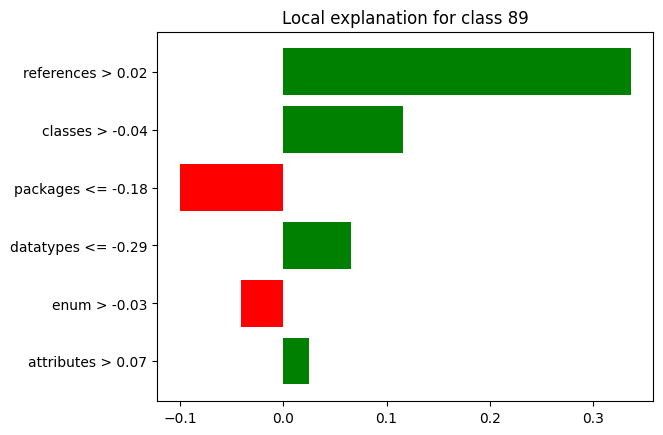

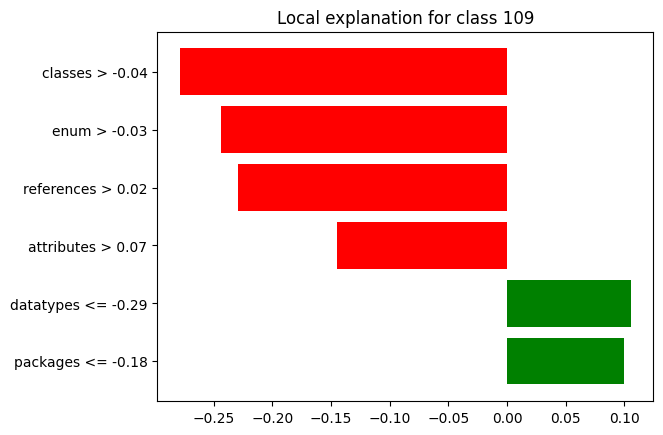

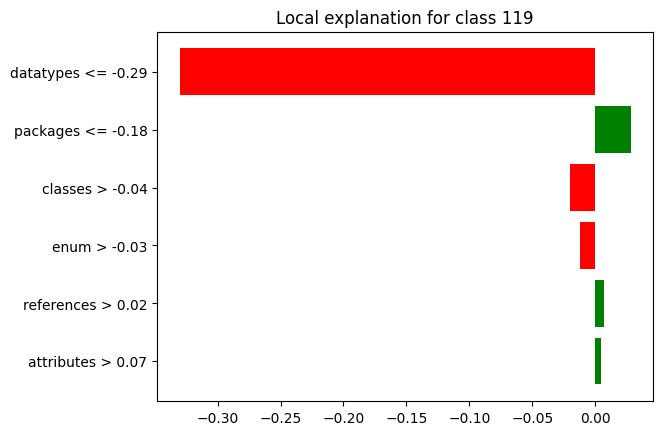

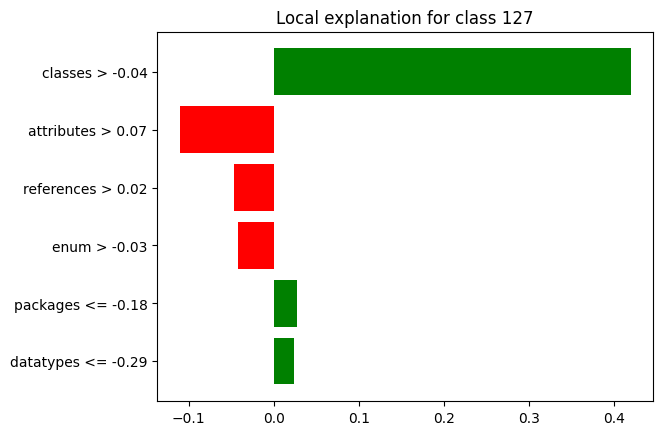

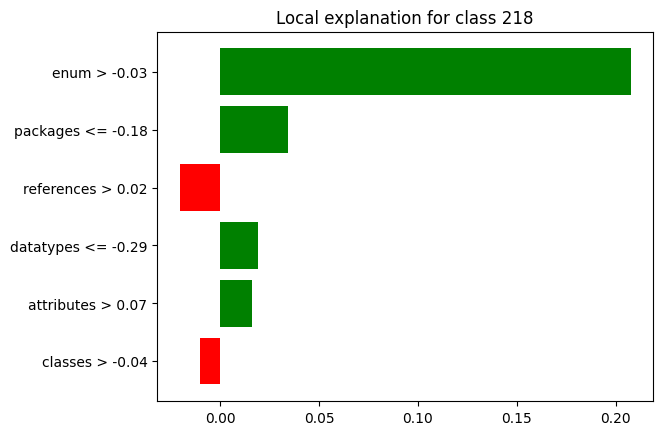

In [ ]:
for i in class_index:
  knn_exp_results['lime_gpl'][i].plot()

In [ ]:
breakdown_df_gpl_gpl, shap_df_gpl_gpl, lime_df_gpl_gpl, df_final_knn_gpl_gpl = preprocess_dfs(breakdown_df_gpl_gpl, shap_df_gpl_gpl, lime_df_gpl_gpl, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_gpl_gpl)
print('----------------------------------------------')
print(shap_df_gpl_gpl)
print('----------------------------------------------')
print(lime_df_gpl_gpl)

['classes', 'enum', 'references', 'attributes', 'datatypes', 'packages']
----------------------------------------------
      Feature  Ranking      Sign
0  references        1  Positive
1        enum        2  Positive
2     classes        3  Positive
3  attributes        4  Negative
4   datatypes        5  Positive
5    packages        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0  references        1  Positive
1        enum        2  Positive
2     classes        3  Positive
3  attributes        4  Positive
4   datatypes        5  Positive
5    packages        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0  references        1  Positive
1     classes        2  Positive
2    packages        3  Negative
3   datatypes        4  Positive
4        enum        5  Negative
5  attributes        6  Positive


In [ ]:
df_final_knn_gpl_gpl

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
references         1  Positive       1  Positive       1  Positive
enum               2  Positive       2  Positive       5  Negative
classes            3  Positive       3  Positive       2  Positive
attributes         4  Negative       4  Positive       6  Positive
datatypes          5  Positive       5  Positive       4  Positive
packages           6  Positive       6  Positive       3  Negative

In [ ]:
breakdown_df_gpl_lib, shap_df_gpl_lib, lime_df_gpl_lib, df_final_knn_gpl_lib = preprocess_dfs(breakdown_df_gpl_lib, shap_df_gpl_lib, lime_df_gpl_lib, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_gpl_lib)
print('----------------------------------------------')
print(shap_df_gpl_lib)
print('----------------------------------------------')
print(lime_df_gpl_lib)

['classes', 'packages', 'enum', 'references', 'attributes', 'datatypes']
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Negative
1  attributes        2  Positive
2   datatypes        3  Positive
3    packages        4  Positive
4  references        5      Null
5        enum        5      Null
----------------------------------------------
      Feature  Ranking      Sign
0        enum        1  Negative
1  references        2  Negative
2  attributes        3  Positive
3     classes        4  Negative
4   datatypes        5  Positive
5    packages        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Negative
1        enum        2  Negative
2  references        3  Negative
3  attributes        4  Negative
4   datatypes        5  Positive
5    packages        6  Positive


In [ ]:
df_final_knn_gpl_lib

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
classes            1  Negative       4  Negative       1  Negative
attributes         2  Positive       3  Positive       4  Negative
datatypes          3  Positive       5  Positive       5  Positive
packages           4  Positive       6  Negative       6  Positive
enum               5      Null       1  Negative       2  Negative
references         5      Null       2  Negative       3  Negative

In [ ]:
breakdown_df_gpl_meta, shap_df_gpl_meta, lime_df_gpl_meta, df_final_knn_gpl_meta = preprocess_dfs(breakdown_df_gpl_meta, shap_df_gpl_meta, lime_df_gpl_meta, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_gpl_meta)
print('----------------------------------------------')
print(shap_df_gpl_meta)
print('----------------------------------------------')
print(lime_df_gpl_meta)

['classes', 'packages', 'enum', 'references', 'attributes', 'datatypes']
----------------------------------------------
      Feature  Ranking      Sign
0        enum        1  Negative
1  attributes        2  Negative
2  references        3  Positive
3     classes        4  Positive
4    packages        5  Positive
5   datatypes        6      Null
----------------------------------------------
      Feature  Ranking      Sign
0   datatypes        1  Negative
1     classes        2  Negative
2        enum        3  Negative
3  attributes        4  Negative
4  references        5  Negative
5    packages        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0   datatypes        1  Negative
1    packages        2  Positive
2     classes        3  Negative
3        enum        4  Negative
4  references        5  Positive
5  attributes        6  Positive


In [ ]:
df_final_knn_gpl_meta

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
enum               1  Negative       3  Negative       4  Negative
attributes         2  Negative       4  Negative       6  Positive
references         3  Positive       5  Negative       5  Positive
classes            4  Positive       2  Negative       3  Negative
packages           5  Positive       6  Negative       2  Positive
datatypes          6      Null       1  Negative       1  Negative

In [ ]:
breakdown_df_gpl_mod, shap_df_gpl_mod, lime_df_gpl_mod, df_final_knn_gpl_mod = preprocess_dfs(breakdown_df_gpl_mod, shap_df_gpl_mod, lime_df_gpl_mod, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_gpl_mod)
print('----------------------------------------------')
print(shap_df_gpl_mod)
print('----------------------------------------------')
print(lime_df_gpl_mod)

['classes', 'packages', 'enum', 'references', 'attributes', 'datatypes']
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Positive
1        enum        2  Negative
2  attributes        3  Negative
3   datatypes        4  Positive
4    packages        5  Negative
5  references        6      Null
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Positive
1  attributes        2  Negative
2        enum        3  Negative
3  references        4  Negative
4    packages        5  Negative
5   datatypes        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Positive
1  attributes        2  Negative
2  references        3  Negative
3        enum        4  Negative
4    packages        5  Positive
5   datatypes        6  Positive


In [ ]:
df_final_knn_gpl_mod

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
classes            1  Positive       1  Positive       1  Positive
enum               2  Negative       3  Negative       4  Negative
attributes         3  Negative       2  Negative       2  Negative
datatypes          4  Positive       6  Negative       6  Positive
packages           5  Negative       5  Negative       5  Positive
references         6      Null       4  Negative       3  Negative

In [ ]:
breakdown_df_gpl_wf, shap_df_gpl_wf, lime_df_gpl_wf, df_final_knn_gpl_wf = preprocess_dfs(breakdown_df_gpl_wf, shap_df_gpl_wf, lime_df_gpl_wf, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_gpl_wf)
print('----------------------------------------------')
print(shap_df_gpl_wf)
print('----------------------------------------------')
print(lime_df_gpl_wf)

['classes', 'enum', 'references', 'attributes', 'datatypes', 'packages']
----------------------------------------------
      Feature  Ranking      Sign
0  references        1  Negative
1        enum        2  Positive
2     classes        3  Positive
3  attributes        4  Negative
4   datatypes        5  Positive
5    packages        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0        enum        1  Positive
1  references        2  Negative
2  attributes        3  Negative
3     classes        4  Negative
4    packages        5  Negative
5   datatypes        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0        enum        1  Positive
1    packages        2  Positive
2  references        3  Negative
3   datatypes        4  Positive
4  attributes        5  Positive
5     classes        6  Negative


In [ ]:
df_final_knn_gpl_wf

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
references         1  Negative       2  Negative       3  Negative
enum               2  Positive       1  Positive       1  Positive
classes            3  Positive       4  Negative       6  Negative
attributes         4  Negative       3  Negative       5  Positive
datatypes          5  Positive       6  Positive       4  Positive
packages           6  Positive       5  Negative       2  Positive

### **RESULTS GPL:**



In [ ]:
df_topfeatures_gpl_gpl = top3_features(df_final_knn_gpl_gpl, 'GPL - Class: GPL')
df_topfeatures_gpl_lib = top3_features(df_final_knn_gpl_lib, 'GPL - Class: Library')
df_topfeatures_gpl_meta = top3_features(df_final_knn_gpl_meta, 'GPL - Class: Metamodelling')
df_topfeatures_gpl_mod = top3_features(df_final_knn_gpl_mod, 'GPL - Class: Modelling')
df_topfeatures_gpl_wf = top3_features(df_final_knn_gpl_wf, 'GPL - Class: Workflow')

df_topfeatures_gpl_knn = pd.concat([df_topfeatures_gpl_gpl, df_topfeatures_gpl_lib, df_topfeatures_gpl_meta, df_topfeatures_gpl_mod, df_topfeatures_gpl_wf])
df_topfeatures_gpl_knn

TOP3 Breakdown  \
GPL - Class: GPL                 enum, classes, references   
GPL - Class: Library        attributes, datatypes, classes   
GPL - Class: Metamodelling    attributes, enum, references   
GPL - Class: Modelling           attributes, enum, classes   
GPL - Class: Workflow            enum, classes, references   

                                               TOP3 Shap  \
GPL - Class: GPL               enum, classes, references   
GPL - Class: Library        attributes, enum, references   
GPL - Class: Metamodelling      datatypes, enum, classes   
GPL - Class: Modelling         attributes, enum, classes   
GPL - Class: Workflow       attributes, enum, references   

                                                  TOP3 Lime  Breakdown-Shap  \
GPL - Class: GPL              packages, classes, references        1.000000   
GPL - Class: Library              enum, classes, references        0.333333   
GPL - Class: Metamodelling     packages, datatypes, classes        0.333333   
GPL - Class: Modelling      attributes, classes, references        1.000000   
GPL - Class: Workflow            enum, packages, references        0.666667   

                            Breakdown-Lime  Lime-Shap  
GPL - Class: GPL                  0.666667   0.666667  
GPL - Class: Library              0.333333   0.666667  
GPL - Class: Metamodelling        0.000000   0.666667  
GPL - Class: Modelling            0.666667   0.666667  
GPL - Class: Workflow             0.666667   0.666667

In [ ]:
df_topfeatures_gpl_gpl_rank = top3_rank(df_final_knn_gpl_gpl, 'GPL - Class GPL')
df_topfeatures_gpl_lib_rank = top3_rank(df_final_knn_gpl_lib, 'GPL - Class Library')
df_topfeatures_gpl_meta_rank = top3_rank(df_final_knn_gpl_meta, 'GPL - Class Metamodelling')
df_topfeatures_gpl_mod_rank = top3_rank(df_final_knn_gpl_mod, 'GPL - Class Modelling')
df_topfeatures_gpl_wf_rank = top3_rank(df_final_knn_gpl_wf, 'GPL - Class Workflow')

df_topfeatures_rank_gpl_knn = pd.concat([df_topfeatures_gpl_gpl_rank, df_topfeatures_gpl_lib_rank, df_topfeatures_gpl_meta_rank, df_topfeatures_gpl_mod_rank, df_topfeatures_gpl_wf_rank])
df_topfeatures_rank_gpl_knn

TOP3 Breakdown  \
GPL - Class GPL                 1:references, 2:enum, 3:classes   
GPL - Class Library        1:classes, 2:attributes, 3:datatypes   
GPL - Class Metamodelling    1:enum, 2:attributes, 3:references   
GPL - Class Modelling           1:classes, 2:enum, 3:attributes   
GPL - Class Workflow            1:references, 2:enum, 3:classes   

                                                    TOP3 Shap  \
GPL - Class GPL               1:references, 2:enum, 3:classes   
GPL - Class Library        3:attributes, 1:enum, 2:references   
GPL - Class Metamodelling      3:enum, 2:classes, 1:datatypes   
GPL - Class Modelling         1:classes, 3:enum, 2:attributes   
GPL - Class Workflow       2:references, 1:enum, 3:attributes   

                                                       TOP3 Lime  \
GPL - Class GPL              1:references, 2:classes, 3:packages   
GPL - Class Library              1:classes, 2:enum, 3:references   
GPL - Class Metamodelling     3:classes, 2:packages, 1:datatypes   
GPL - Class Modelling      1:classes, 2:attributes, 3:references   
GPL - Class Workflow            3:references, 1:enum, 2:packages   

                           Breakdown-Shap  Breakdown-Lime  Lime-Shap  
GPL - Class GPL                  1.000000        0.333333   0.333333  
GPL - Class Library              0.000000        0.333333   0.000000  
GPL - Class Metamodelling        0.000000        0.000000   0.333333  
GPL - Class Modelling            0.333333        0.333333   0.666667  
GPL - Class Workflow             0.000000        0.000000   0.333333

In [ ]:
df_topfeatures_gpl_gpl_sign = top3_sign(df_final_knn_gpl_gpl, 'GPL - Class GPL')
df_topfeatures_gpl_lib_sign = top3_sign(df_final_knn_gpl_lib, 'GPL - Class Library')
df_topfeatures_gpl_meta_sign = top3_sign(df_final_knn_gpl_meta, 'GPL - Class Metamodelling')
df_topfeatures_gpl_mod_sign = top3_sign(df_final_knn_gpl_mod, 'GPL - Class Modelling')
df_topfeatures_gpl_wf_sign = top3_sign(df_final_knn_gpl_wf, 'GPL - Class Workflow')

df_topfeatures_sign_gpl_knn = pd.concat([df_topfeatures_gpl_gpl_sign, df_topfeatures_gpl_lib_sign, df_topfeatures_gpl_meta_sign, df_topfeatures_gpl_mod_sign, df_topfeatures_gpl_wf_sign])
df_topfeatures_sign_gpl_knn

TOP3 Breakdown  \
GPL - Class GPL            references:Positive, enum:Positive, classes:Po...   
GPL - Class Library        classes:Negative, attributes:Positive, datatyp...   
GPL - Class Metamodelling  enum:Negative, attributes:Negative, references...   
GPL - Class Modelling      classes:Positive, enum:Negative, attributes:Ne...   
GPL - Class Workflow       references:Negative, enum:Positive, classes:Po...   

                                                                   TOP3 Shap  \
GPL - Class GPL            references:Positive, enum:Positive, classes:Po...   
GPL - Class Library        attributes:Positive, enum:Negative, references...   
GPL - Class Metamodelling  enum:Negative, classes:Negative, datatypes:Neg...   
GPL - Class Modelling      classes:Positive, enum:Negative, attributes:Ne...   
GPL - Class Workflow       references:Negative, enum:Positive, attributes...   

                                                                   TOP3 Lime  \
GPL - Class GPL            references:Positive, classes:Positive, package...   
GPL - Class Library        classes:Negative, enum:Negative, references:Ne...   
GPL - Class Metamodelling  classes:Negative, packages:Positive, datatypes...   
GPL - Class Modelling      classes:Positive, attributes:Negative, referen...   
GPL - Class Workflow       references:Negative, enum:Positive, packages:P...   

                           Breakdown-Shap  Breakdown-Lime  Lime-Shap  
GPL - Class GPL                  1.000000        0.666667   0.666667  
GPL - Class Library              0.333333        0.333333   0.666667  
GPL - Class Metamodelling        0.333333        0.000000   0.666667  
GPL - Class Modelling            1.000000        0.666667   0.666667  
GPL - Class Workflow             0.666667        0.666667   0.666667

In [ ]:
df_topfeatures_gpl_gpl_rank_sign = top3_rank_sign(df_final_knn_gpl_gpl, 'GPL - Class GPL')
df_topfeatures_gpl_lib_rank_sign = top3_rank_sign(df_final_knn_gpl_lib, 'GPL - Class Library')
df_topfeatures_gpl_meta_rank_sign = top3_rank_sign(df_final_knn_gpl_meta, 'GPL - Class Metamodelling')
df_topfeatures_gpl_mod_rank_sign = top3_rank_sign(df_final_knn_gpl_mod, 'GPL - Class Modelling')
df_topfeatures_gpl_wf_rank_sign = top3_rank_sign(df_final_knn_gpl_wf, 'GPL - Class Workflow')

df_topfeatures_rank_sign_gpl_knn = pd.concat([df_topfeatures_gpl_gpl_rank_sign, df_topfeatures_gpl_lib_rank_sign, df_topfeatures_gpl_meta_rank_sign, df_topfeatures_gpl_mod_rank_sign, df_topfeatures_gpl_wf_rank_sign])
df_topfeatures_rank_sign_gpl_knn

TOP3 Breakdown  \
GPL - Class GPL            1:references:Positive, 2:enum:Positive, 3:clas...   
GPL - Class Library        1:classes:Negative, 2:attributes:Positive, 3:d...   
GPL - Class Metamodelling  1:enum:Negative, 2:attributes:Negative, 3:refe...   
GPL - Class Modelling      1:classes:Positive, 2:enum:Negative, 3:attribu...   
GPL - Class Workflow       1:references:Negative, 2:enum:Positive, 3:clas...   

                                                                   TOP3 Shap  \
GPL - Class GPL            1:references:Positive, 2:enum:Positive, 3:clas...   
GPL - Class Library        3:attributes:Positive, 1:enum:Negative, 2:refe...   
GPL - Class Metamodelling  3:enum:Negative, 2:classes:Negative, 1:datatyp...   
GPL - Class Modelling      1:classes:Positive, 3:enum:Negative, 2:attribu...   
GPL - Class Workflow       2:references:Negative, 1:enum:Positive, 3:attr...   

                                                                   TOP3 Lime  \
GPL - Class GPL            1:references:Positive, 2:classes:Positive, 3:p...   
GPL - Class Library        1:classes:Negative, 2:enum:Negative, 3:referen...   
GPL - Class Metamodelling  3:classes:Negative, 2:packages:Positive, 1:dat...   
GPL - Class Modelling      1:classes:Positive, 2:attributes:Negative, 3:r...   
GPL - Class Workflow       3:references:Negative, 1:enum:Positive, 2:pack...   

                           Breakdown-Shap  Breakdown-Lime  Lime-Shap  
GPL - Class GPL                  1.000000        0.333333   0.333333  
GPL - Class Library              0.000000        0.333333   0.000000  
GPL - Class Metamodelling        0.000000        0.000000   0.333333  
GPL - Class Modelling            0.333333        0.333333   0.666667  
GPL - Class Workflow             0.000000        0.000000   0.333333

### **LIBRARY:**

In [ ]:
breakdown_df_library_gpl = knn_exp_results['breakdown_library'][1].result
shap_df_library_gpl = knn_exp_results['shap_library'][1].result
lime_df_library_gpl = knn_exp_results['lime_library'][1].result

In [ ]:
breakdown_df_library_lib = knn_exp_results['breakdown_library'][2].result
shap_df_library_lib = knn_exp_results['shap_library'][2].result
lime_df_library_lib = knn_exp_results['lime_library'][2].result

In [ ]:
breakdown_df_library_meta = knn_exp_results['breakdown_library'][3].result
shap_df_library_meta = knn_exp_results['shap_library'][3].result
lime_df_library_meta = knn_exp_results['lime_library'][3].result

In [ ]:
breakdown_df_library_mod = knn_exp_results['breakdown_library'][4].result
shap_df_library_mod = knn_exp_results['shap_library'][4].result
lime_df_library_mod = knn_exp_results['lime_library'][4].result

In [ ]:
breakdown_df_library_wf = knn_exp_results['breakdown_library'][9].result
shap_df_library_wf = knn_exp_results['shap_library'][9].result
lime_df_library_wf = knn_exp_results['lime_library'][9].result

In [ ]:
exp_plots_bd = [knn_exp_results['breakdown_library'][i] for i in class_index]
exp_plots_bd[0].plot(exp_plots_bd[1:])

In [ ]:
exp_plots_shap = [knn_exp_results['shap_library'][i] for i in class_index]
exp_plots_shap[0].plot(exp_plots_shap[1:])

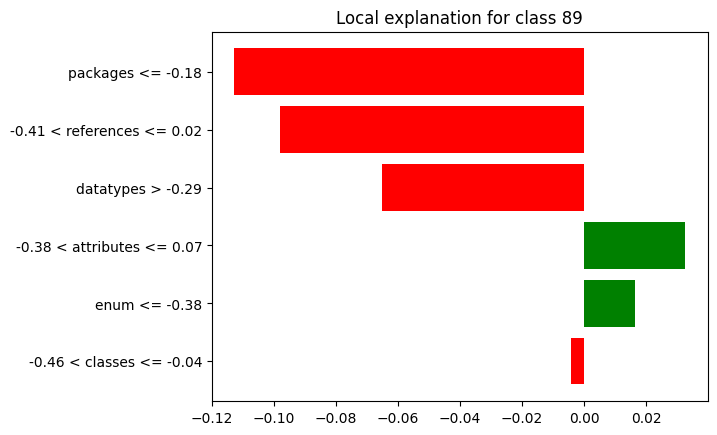

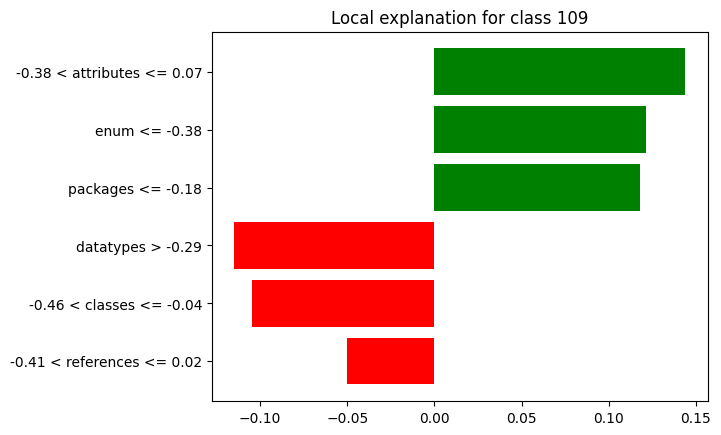

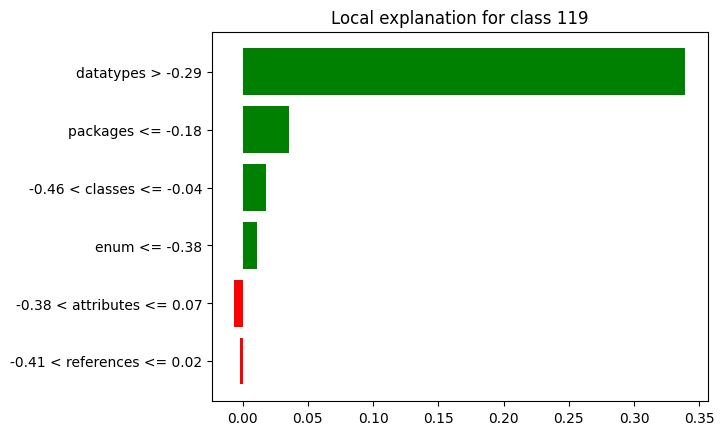

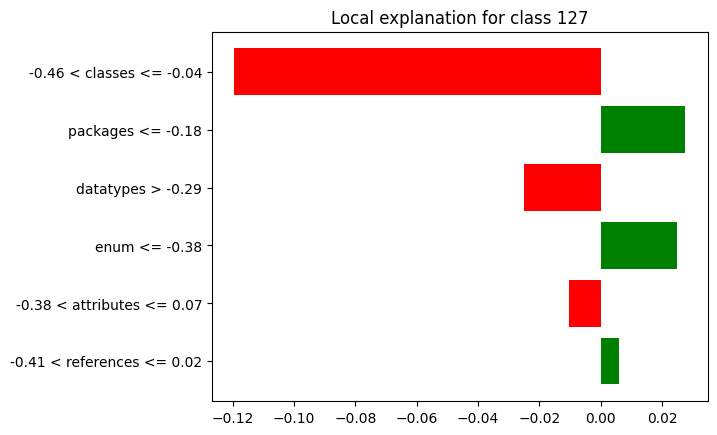

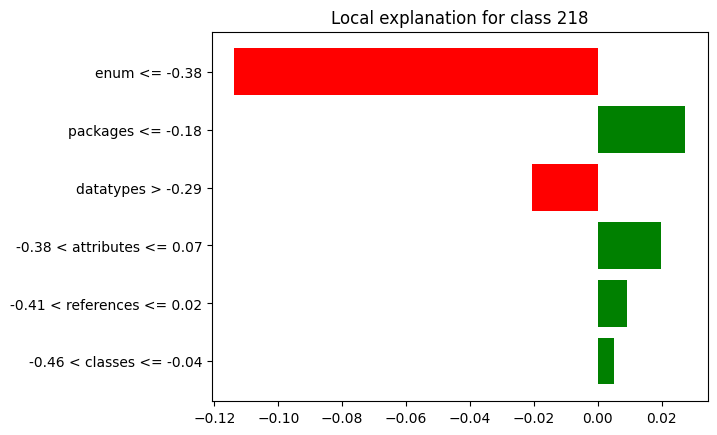

In [ ]:
for i in class_index:
  knn_exp_results['lime_library'][i].plot()

In [ ]:
breakdown_df_library_gpl, shap_df_library_gpl, lime_df_library_gpl, df_final_knn_lib_gpl = preprocess_dfs(breakdown_df_library_gpl, shap_df_library_gpl, lime_df_library_gpl, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_library_gpl)
print('----------------------------------------------')
print(shap_df_library_gpl)
print('----------------------------------------------')
print(lime_df_library_gpl)

['classes', 'packages', 'enum', 'references', 'attributes', 'datatypes']
----------------------------------------------
      Feature  Ranking      Sign
0  references        1  Negative
1     classes        2  Negative
2  attributes        3  Positive
3        enum        4  Positive
4    packages        5  Positive
5   datatypes        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0  references        1  Negative
1     classes        2  Negative
2   datatypes        3  Positive
3    packages        4  Negative
4  attributes        5  Positive
5        enum        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0    packages        1  Negative
1  references        2  Negative
2   datatypes        3  Negative
3  attributes        4  Positive
4        enum        5  Positive
5     classes        6  Negative


In [ ]:
df_final_knn_lib_gpl

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
references         1  Negative       1  Negative       2  Negative
classes            2  Negative       2  Negative       6  Negative
attributes         3  Positive       5  Positive       4  Positive
enum               4  Positive       6  Negative       5  Positive
packages           5  Positive       4  Negative       1  Negative
datatypes          6  Positive       3  Positive       3  Negative

In [ ]:
breakdown_df_library_lib, shap_df_library_lib, lime_df_library_lib, df_final_knn_lib_lib = preprocess_dfs(breakdown_df_library_lib, shap_df_library_lib, lime_df_library_lib, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_library_lib)
print('----------------------------------------------')
print(shap_df_library_lib)
print('----------------------------------------------')
print(lime_df_library_lib)

['classes', 'enum', 'references', 'attributes', 'datatypes', 'packages']
----------------------------------------------
      Feature  Ranking      Sign
0  references        1  Positive
1  attributes        2  Positive
2     classes        3  Positive
3   datatypes        4  Positive
4        enum        5  Negative
5    packages        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0   datatypes        1  Positive
1  attributes        2  Positive
2     classes        3  Positive
3  references        4  Positive
4        enum        5  Positive
5    packages        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0  attributes        1  Positive
1        enum        2  Positive
2    packages        3  Positive
3   datatypes        4  Negative
4     classes        5  Negative
5  references        6  Negative


In [ ]:
df_final_knn_lib_lib

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
references         1  Positive       4  Positive       6  Negative
attributes         2  Positive       2  Positive       1  Positive
classes            3  Positive       3  Positive       5  Negative
datatypes          4  Positive       1  Positive       4  Negative
enum               5  Negative       5  Positive       2  Positive
packages           6  Positive       6  Positive       3  Positive

In [ ]:
breakdown_df_library_meta, shap_df_library_meta, lime_df_library_meta, df_final_knn_lib_meta = preprocess_dfs(breakdown_df_library_meta, shap_df_library_meta, lime_df_library_meta, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_library_meta)
print('----------------------------------------------')
print(shap_df_library_meta)
print('----------------------------------------------')
print(lime_df_library_meta)

['classes', 'packages', 'enum', 'references', 'attributes', 'datatypes']
----------------------------------------------
      Feature  Ranking      Sign
0   datatypes        1  Negative
1  attributes        2  Negative
2     classes        3  Positive
3  references        4  Positive
4    packages        5  Positive
5        enum        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0   datatypes        1  Negative
1     classes        2  Positive
2  references        3  Negative
3    packages        4  Negative
4  attributes        5  Negative
5        enum        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0   datatypes        1  Positive
1    packages        2  Positive
2     classes        3  Positive
3        enum        4  Positive
4  attributes        5  Negative
5  references        6  Negative


In [ ]:
df_final_knn_lib_meta

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
datatypes          1  Negative       1  Negative       1  Positive
attributes         2  Negative       5  Negative       5  Negative
classes            3  Positive       2  Positive       3  Positive
references         4  Positive       3  Negative       6  Negative
packages           5  Positive       4  Negative       2  Positive
enum               6  Positive       6  Negative       4  Positive

In [ ]:
breakdown_df_library_mod, shap_df_library_mod, lime_df_library_mod, df_final_knn_lib_mod = preprocess_dfs(breakdown_df_library_mod, shap_df_library_mod, lime_df_library_mod, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_library_mod)
print('----------------------------------------------')
print(shap_df_library_mod)
print('----------------------------------------------')
print(lime_df_library_mod)

['classes', 'enum', 'references', 'attributes', 'datatypes', 'packages']
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Negative
1   datatypes        2  Negative
2  references        3  Positive
3  attributes        4  Positive
4        enum        5  Negative
5    packages        6  Negative
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Negative
1  references        2  Negative
2   datatypes        3  Negative
3    packages        4  Negative
4        enum        5  Negative
5  attributes        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0     classes        1  Negative
1    packages        2  Positive
2   datatypes        3  Negative
3        enum        4  Positive
4  attributes        5  Negative
5  references        6  Positive


In [ ]:
df_final_knn_lib_mod

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
classes            1  Negative       1  Negative       1  Negative
datatypes          2  Negative       3  Negative       3  Negative
references         3  Positive       2  Negative       6  Positive
attributes         4  Positive       6  Positive       5  Negative
enum               5  Negative       5  Negative       4  Positive
packages           6  Negative       4  Negative       2  Positive

In [ ]:
breakdown_df_library_wf, shap_df_library_wf, lime_df_library_wf, df_final_knn_lib_wf = preprocess_dfs(breakdown_df_library_wf, shap_df_library_wf, lime_df_library_wf, num_features, top_num_features)
print('----------------------------------------------')
print(breakdown_df_library_wf)
print('----------------------------------------------')
print(shap_df_library_wf)
print('----------------------------------------------')
print(lime_df_library_wf)

['classes', 'enum', 'references', 'attributes', 'datatypes', 'packages']
----------------------------------------------
      Feature  Ranking      Sign
0   datatypes        1  Negative
1     classes        2  Positive
2        enum        3  Negative
3  references        4  Positive
4  attributes        5  Positive
5    packages        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0   datatypes        1  Negative
1  attributes        2  Positive
2        enum        3  Negative
3  references        4  Positive
4     classes        5  Positive
5    packages        6  Positive
----------------------------------------------
      Feature  Ranking      Sign
0        enum        1  Negative
1    packages        2  Positive
2   datatypes        3  Negative
3  attributes        4  Positive
4  references        5  Positive
5     classes        6  Positive


In [ ]:
df_final_knn_lib_wf

Breakdown              Shap              Lime          
             Ranking      Sign Ranking      Sign Ranking      Sign
Feature                                                           
datatypes          1  Negative       1  Negative       3  Negative
classes            2  Positive       5  Positive       6  Positive
enum               3  Negative       3  Negative       1  Negative
references         4  Positive       4  Positive       5  Positive
attributes         5  Positive       2  Positive       4  Positive
packages           6  Positive       6  Positive       2  Positive

### **RESULTS LIBRARY:**

In [ ]:
df_topfeatures_lib_gpl = top3_features(df_final_knn_lib_gpl, 'Library - Class: GPL')
df_topfeatures_lib_lib = top3_features(df_final_knn_lib_lib, 'Library - Class: Library')
df_topfeatures_lib_meta = top3_features(df_final_knn_lib_meta, 'Library - Class: Metamodelling')
df_topfeatures_lib_mod = top3_features(df_final_knn_lib_mod, 'Library - Class: Modelling')
df_topfeatures_lib_wf = top3_features(df_final_knn_lib_wf, 'Library - Class: Workflow')

df_topfeatures_library_knn = pd.concat([df_topfeatures_lib_gpl, df_topfeatures_lib_lib, df_topfeatures_lib_meta, df_topfeatures_lib_mod, df_topfeatures_lib_wf])
df_topfeatures_library_knn

TOP3 Breakdown  \
Library - Class: GPL            attributes, classes, references   
Library - Class: Library        attributes, classes, references   
Library - Class: Metamodelling   attributes, datatypes, classes   
Library - Class: Modelling       datatypes, classes, references   
Library - Class: Workflow              enum, datatypes, classes   

                                                     TOP3 Shap  \
Library - Class: GPL            datatypes, classes, references   
Library - Class: Library        attributes, datatypes, classes   
Library - Class: Metamodelling  datatypes, classes, references   
Library - Class: Modelling      datatypes, classes, references   
Library - Class: Workflow          attributes, enum, datatypes   

                                                      TOP3 Lime  \
Library - Class: GPL            datatypes, packages, references   
Library - Class: Library             attributes, enum, packages   
Library - Class: Metamodelling     packages, datatypes, classes   
Library - Class: Modelling         packages, datatypes, classes   
Library - Class: Workflow             enum, datatypes, packages   

                                Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Library - Class: GPL                  0.666667        0.333333   0.666667  
Library - Class: Library              0.666667        0.333333   0.333333  
Library - Class: Metamodelling        0.666667        0.666667   0.666667  
Library - Class: Modelling            1.000000        0.666667   0.666667  
Library - Class: Workflow             0.666667        0.666667   0.666667

In [ ]:
df_topfeatures_lib_gpl_rank = top3_rank(df_final_knn_lib_gpl, 'Library - Class GPL')
df_topfeatures_lib_lib_rank = top3_rank(df_final_knn_lib_lib, 'Library - Class Library')
df_topfeatures_lib_meta_rank = top3_rank(df_final_knn_lib_meta, 'Library - Class Metamodelling')
df_topfeatures_lib_mod_rank = top3_rank(df_final_knn_lib_mod, 'Library - Class Modelling')
df_topfeatures_lib_wf_rank = top3_rank(df_final_knn_lib_wf, 'Library - Class Workflow')

df_topfeatures_rank_library_knn = pd.concat([df_topfeatures_lib_gpl_rank, df_topfeatures_lib_lib_rank, df_topfeatures_lib_meta_rank, df_topfeatures_lib_mod_rank, df_topfeatures_lib_wf_rank])
df_topfeatures_rank_library_knn

TOP3 Breakdown  \
Library - Class GPL            1:references, 2:classes, 3:attributes   
Library - Class Library        1:references, 2:attributes, 3:classes   
Library - Class Metamodelling   1:datatypes, 2:attributes, 3:classes   
Library - Class Modelling       1:classes, 2:datatypes, 3:references   
Library - Class Workflow              1:datatypes, 2:classes, 3:enum   

                                                          TOP3 Shap  \
Library - Class GPL            1:references, 2:classes, 3:datatypes   
Library - Class Library        2:attributes, 3:classes, 1:datatypes   
Library - Class Metamodelling  1:datatypes, 2:classes, 3:references   
Library - Class Modelling      1:classes, 3:datatypes, 2:references   
Library - Class Workflow          1:datatypes, 3:enum, 2:attributes   

                                                           TOP3 Lime  \
Library - Class GPL            2:references, 1:packages, 3:datatypes   
Library - Class Library             1:attributes, 2:enum, 3:packages   
Library - Class Metamodelling     1:datatypes, 3:classes, 2:packages   
Library - Class Modelling         1:classes, 3:datatypes, 2:packages   
Library - Class Workflow             3:datatypes, 1:enum, 2:packages   

                               Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Library - Class GPL                  0.666667        0.000000   0.333333  
Library - Class Library              0.666667        0.000000   0.000000  
Library - Class Metamodelling        0.333333        0.666667   0.333333  
Library - Class Modelling            0.333333        0.333333   0.666667  
Library - Class Workflow             0.666667        0.000000   0.000000

In [ ]:
df_topfeatures_lib_gpl_sign = top3_sign(df_final_knn_lib_gpl, 'Library - Class GPL')
df_topfeatures_lib_lib_sign = top3_sign(df_final_knn_lib_lib, 'Library - Class Library')
df_topfeatures_lib_meta_sign = top3_sign(df_final_knn_lib_meta, 'Library - Class Metamodelling')
df_topfeatures_lib_mod_sign = top3_sign(df_final_knn_lib_mod, 'Library - Class Modelling')
df_topfeatures_lib_wf_sign = top3_sign(df_final_knn_lib_wf, 'Library - Class Workflow')

df_topfeatures_sign_library_knn = pd.concat([df_topfeatures_lib_gpl_sign, df_topfeatures_lib_lib_sign, df_topfeatures_lib_meta_sign, df_topfeatures_lib_mod_sign, df_topfeatures_lib_wf_sign])
df_topfeatures_sign_library_knn

TOP3 Breakdown  \
Library - Class GPL            references:Negative, classes:Negative, attribu...   
Library - Class Library        references:Positive, attributes:Positive, clas...   
Library - Class Metamodelling  datatypes:Negative, attributes:Negative, class...   
Library - Class Modelling      classes:Negative, datatypes:Negative, referenc...   
Library - Class Workflow       datatypes:Negative, classes:Positive, enum:Neg...   

                                                                       TOP3 Shap  \
Library - Class GPL            references:Negative, classes:Negative, datatyp...   
Library - Class Library        attributes:Positive, classes:Positive, datatyp...   
Library - Class Metamodelling  datatypes:Negative, classes:Positive, referenc...   
Library - Class Modelling      classes:Negative, datatypes:Negative, referenc...   
Library - Class Workflow       datatypes:Negative, enum:Negative, attributes:...   

                                                                       TOP3 Lime  \
Library - Class GPL            references:Negative, packages:Negative, dataty...   
Library - Class Library        attributes:Positive, enum:Positive, packages:P...   
Library - Class Metamodelling  datatypes:Positive, classes:Positive, packages...   
Library - Class Modelling      classes:Negative, datatypes:Negative, packages...   
Library - Class Workflow       datatypes:Negative, enum:Negative, packages:Po...   

                               Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Library - Class GPL                  0.666667        0.333333   0.333333  
Library - Class Library              0.666667        0.333333   0.333333  
Library - Class Metamodelling        0.666667        0.333333   0.333333  
Library - Class Modelling            0.666667        0.666667   0.666667  
Library - Class Workflow             0.666667        0.666667   0.666667

In [ ]:
df_topfeatures_lib_gpl_rank_sign = top3_rank_sign(df_final_knn_lib_gpl, 'Library - Class GPL')
df_topfeatures_lib_lib_rank_sign = top3_rank_sign(df_final_knn_lib_lib, 'Library - Class Library')
df_topfeatures_lib_meta_rank_sign = top3_rank_sign(df_final_knn_lib_meta, 'Library - Class Metamodelling')
df_topfeatures_lib_mod_rank_sign = top3_rank_sign(df_final_knn_lib_mod, 'Library - Class Modelling')
df_topfeatures_lib_wf_rank_sign = top3_rank_sign(df_final_knn_lib_wf, 'Library - Class Workflow')

df_topfeatures_rank_sign_library_knn = pd.concat([df_topfeatures_lib_gpl_rank_sign, df_topfeatures_lib_lib_rank_sign, df_topfeatures_lib_meta_rank_sign, df_topfeatures_lib_mod_rank_sign, df_topfeatures_lib_wf_rank_sign])
df_topfeatures_rank_sign_library_knn

TOP3 Breakdown  \
Library - Class GPL            1:references:Negative, 2:classes:Negative, 3:a...   
Library - Class Library        1:references:Positive, 2:attributes:Positive, ...   
Library - Class Metamodelling  1:datatypes:Negative, 2:attributes:Negative, 3...   
Library - Class Modelling      1:classes:Negative, 2:datatypes:Negative, 3:re...   
Library - Class Workflow       1:datatypes:Negative, 2:classes:Positive, 3:en...   

                                                                       TOP3 Shap  \
Library - Class GPL            1:references:Negative, 2:classes:Negative, 3:d...   
Library - Class Library        2:attributes:Positive, 3:classes:Positive, 1:d...   
Library - Class Metamodelling  1:datatypes:Negative, 2:classes:Positive, 3:re...   
Library - Class Modelling      1:classes:Negative, 3:datatypes:Negative, 2:re...   
Library - Class Workflow       1:datatypes:Negative, 3:enum:Negative, 2:attri...   

                                                                       TOP3 Lime  \
Library - Class GPL            2:references:Negative, 1:packages:Negative, 3:...   
Library - Class Library        1:attributes:Positive, 2:enum:Positive, 3:pack...   
Library - Class Metamodelling  1:datatypes:Positive, 3:classes:Positive, 2:pa...   
Library - Class Modelling      1:classes:Negative, 3:datatypes:Negative, 2:pa...   
Library - Class Workflow       3:datatypes:Negative, 1:enum:Negative, 2:packa...   

                               Breakdown-Shap  Breakdown-Lime  Lime-Shap  
Library - Class GPL                  0.666667        0.000000   0.000000  
Library - Class Library              0.666667        0.000000   0.000000  
Library - Class Metamodelling        0.333333        0.333333   0.000000  
Library - Class Modelling            0.333333        0.333333   0.666667  
Library - Class Workflow             0.666667        0.000000   0.000000